In [1]:
#import non tensorflow libraries
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pathlib
import IPython.display as display

#import tensorflow libraries
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow.keras.layers as tfl
import pickle
import keras_cv

2024-04-15 23:21:56.267323: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 23:21:56.267450: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 23:21:56.419141: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BATCH_SIZE = 16

IMG_SIZE = (224,224)

train_dataset = image_dataset_from_directory('/kaggle/input/preprocessing-koa-dataset/new/train',
                                             label_mode="categorical",
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory('/kaggle/input/preprocessing-koa-dataset/new/val',
                                             label_mode="categorical",
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 7304 files belonging to 5 classes.


Found 826 files belonging to 5 classes.


tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)
tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)


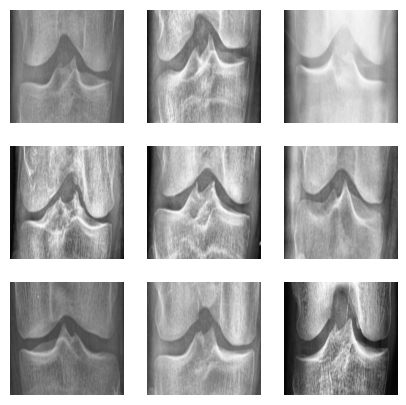

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        print(labels[i])
#         plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip(mode="horizontal"),
        tf.keras.layers.Resizing(224,224),
        tf.keras.layers.RandomZoom(0.1)
    ])
    
    return data_augmentation

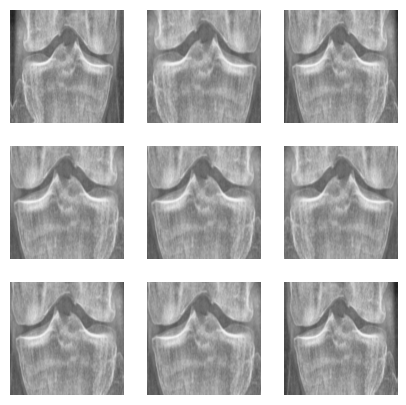

In [5]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(5, 5))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [6]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = keras_cv.models.DenseNetBackbone.from_preset("densenet201_imagenet")

Attaching 'config.json' from model 'keras/densenet/keras/densenet201_imagenet/2' to your Kaggle notebook...


Attaching 'config.json' from model 'keras/densenet/keras/densenet201_imagenet/2' to your Kaggle notebook...


Attaching 'model.weights.h5' from model 'keras/densenet/keras/densenet201_imagenet/2' to your Kaggle notebook...


In [7]:
base_model.trainable = True

In [8]:
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(320, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

In [9]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(), 
      metrics=['accuracy',keras.metrics.AUC()])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_net_backbone              │ ?                      │    18,321,984 │
│ (DenseNetBackbone)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 18,092,928 (69.02 MB)

 Non-trainable params: 229,056 (894.75 KB)

None


In [10]:
epochs = 9

# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)
checkpoint_filepath = '/kaggle/working/checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [11]:
class_weights = {0: 2.5273356401384084,
 1: 5.529144587433763,
 2: 3.8061490359562273,
 3: 7.632183908045977,
 4: 33.65898617511521}

In [12]:
history = model.fit(train_dataset,
                    class_weight = class_weights,
                    epochs=epochs,
                    validation_data = validation_dataset,
                    callbacks=[early_stopper, reduce_lr,model_checkpoint_callback])

Epoch 1/9



  1/457 ━━━━━━━━━━━━━━━━━━━━ 11:36:20 92s/step - accuracy: 0.1250 - auc: 0.6377 - loss: 5.8808


  2/457 ━━━━━━━━━━━━━━━━━━━━ 1:06:33 9s/step - accuracy: 0.1406 - auc: 0.6400 - loss: 6.0817  


  3/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:42 8s/step - accuracy: 0.1562 - auc: 0.6268 - loss: 6.2238


  4/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:31 8s/step - accuracy: 0.1875 - auc: 0.6286 - loss: 6.2267


  5/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:52 8s/step - accuracy: 0.2025 - auc: 0.6241 - loss: 6.3252


  6/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:08 8s/step - accuracy: 0.2104 - auc: 0.6211 - loss: 6.4868


  7/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:29 8s/step - accuracy: 0.2173 - auc: 0.6188 - loss: 6.5779


  8/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:02 8s/step - accuracy: 0.2244 - auc: 0.6184 - loss: 6.7431


  9/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:29 8s/step - accuracy: 0.2272 - auc: 0.6167 - loss: 6.8488


 10/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:42 8s/step - accuracy: 0.2295 - auc: 0.6146 - loss: 6.9527


 11/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:29 8s/step - accuracy: 0.2314 - auc: 0.6121 - loss: 7.0566


 12/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:18 8s/step - accuracy: 0.2338 - auc: 0.6105 - loss: 7.1330


 13/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:03 8s/step - accuracy: 0.2354 - auc: 0.6087 - loss: 7.2115


 14/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:08 8s/step - accuracy: 0.2358 - auc: 0.6065 - loss: 7.2750


 15/457 ━━━━━━━━━━━━━━━━━━━━ 59:54 8s/step - accuracy: 0.2359 - auc: 0.6040 - loss: 7.3301  


 16/457 ━━━━━━━━━━━━━━━━━━━━ 59:39 8s/step - accuracy: 0.2363 - auc: 0.6022 - loss: 7.3857


 17/457 ━━━━━━━━━━━━━━━━━━━━ 59:27 8s/step - accuracy: 0.2362 - auc: 0.6005 - loss: 7.4423


 18/457 ━━━━━━━━━━━━━━━━━━━━ 59:25 8s/step - accuracy: 0.2360 - auc: 0.5986 - loss: 7.4867


 19/457 ━━━━━━━━━━━━━━━━━━━━ 59:16 8s/step - accuracy: 0.2359 - auc: 0.5965 - loss: 7.5193


 20/457 ━━━━━━━━━━━━━━━━━━━━ 59:07 8s/step - accuracy: 0.2363 - auc: 0.5947 - loss: 7.5432


 21/457 ━━━━━━━━━━━━━━━━━━━━ 58:55 8s/step - accuracy: 0.2362 - auc: 0.5923 - loss: 7.5613


 22/457 ━━━━━━━━━━━━━━━━━━━━ 58:53 8s/step - accuracy: 0.2360 - auc: 0.5899 - loss: 7.5795


 23/457 ━━━━━━━━━━━━━━━━━━━━ 58:44 8s/step - accuracy: 0.2355 - auc: 0.5875 - loss: 7.5942


 24/457 ━━━━━━━━━━━━━━━━━━━━ 58:36 8s/step - accuracy: 0.2350 - auc: 0.5851 - loss: 7.6050


 25/457 ━━━━━━━━━━━━━━━━━━━━ 58:26 8s/step - accuracy: 0.2346 - auc: 0.5829 - loss: 7.6125


 26/457 ━━━━━━━━━━━━━━━━━━━━ 58:21 8s/step - accuracy: 0.2341 - auc: 0.5809 - loss: 7.6277


 27/457 ━━━━━━━━━━━━━━━━━━━━ 58:06 8s/step - accuracy: 0.2335 - auc: 0.5791 - loss: 7.6465


 28/457 ━━━━━━━━━━━━━━━━━━━━ 57:54 8s/step - accuracy: 0.2331 - auc: 0.5776 - loss: 7.6616


 29/457 ━━━━━━━━━━━━━━━━━━━━ 57:42 8s/step - accuracy: 0.2328 - auc: 0.5762 - loss: 7.6777


 30/457 ━━━━━━━━━━━━━━━━━━━━ 57:40 8s/step - accuracy: 0.2326 - auc: 0.5750 - loss: 7.6940


 31/457 ━━━━━━━━━━━━━━━━━━━━ 57:30 8s/step - accuracy: 0.2323 - auc: 0.5739 - loss: 7.7085


 32/457 ━━━━━━━━━━━━━━━━━━━━ 57:18 8s/step - accuracy: 0.2320 - auc: 0.5728 - loss: 7.7227


 33/457 ━━━━━━━━━━━━━━━━━━━━ 57:09 8s/step - accuracy: 0.2316 - auc: 0.5718 - loss: 7.7345


 34/457 ━━━━━━━━━━━━━━━━━━━━ 57:06 8s/step - accuracy: 0.2313 - auc: 0.5709 - loss: 7.7456


 35/457 ━━━━━━━━━━━━━━━━━━━━ 56:55 8s/step - accuracy: 0.2310 - auc: 0.5701 - loss: 7.7550


 36/457 ━━━━━━━━━━━━━━━━━━━━ 56:45 8s/step - accuracy: 0.2308 - auc: 0.5695 - loss: 7.7658


 37/457 ━━━━━━━━━━━━━━━━━━━━ 56:34 8s/step - accuracy: 0.2305 - auc: 0.5688 - loss: 7.7759


 38/457 ━━━━━━━━━━━━━━━━━━━━ 56:29 8s/step - accuracy: 0.2301 - auc: 0.5682 - loss: 7.7863


 39/457 ━━━━━━━━━━━━━━━━━━━━ 56:20 8s/step - accuracy: 0.2298 - auc: 0.5675 - loss: 7.7975


 40/457 ━━━━━━━━━━━━━━━━━━━━ 56:11 8s/step - accuracy: 0.2292 - auc: 0.5667 - loss: 7.8086


 41/457 ━━━━━━━━━━━━━━━━━━━━ 56:01 8s/step - accuracy: 0.2287 - auc: 0.5658 - loss: 7.8207


 42/457 ━━━━━━━━━━━━━━━━━━━━ 55:55 8s/step - accuracy: 0.2280 - auc: 0.5650 - loss: 7.8316


 43/457 ━━━━━━━━━━━━━━━━━━━━ 55:45 8s/step - accuracy: 0.2274 - auc: 0.5641 - loss: 7.8426


 44/457 ━━━━━━━━━━━━━━━━━━━━ 55:35 8s/step - accuracy: 0.2268 - auc: 0.5633 - loss: 7.8521


 45/457 ━━━━━━━━━━━━━━━━━━━━ 55:26 8s/step - accuracy: 0.2261 - auc: 0.5624 - loss: 7.8629


 46/457 ━━━━━━━━━━━━━━━━━━━━ 55:19 8s/step - accuracy: 0.2255 - auc: 0.5614 - loss: 7.8726


 47/457 ━━━━━━━━━━━━━━━━━━━━ 55:08 8s/step - accuracy: 0.2249 - auc: 0.5605 - loss: 7.8843


 48/457 ━━━━━━━━━━━━━━━━━━━━ 54:58 8s/step - accuracy: 0.2243 - auc: 0.5596 - loss: 7.8962


 49/457 ━━━━━━━━━━━━━━━━━━━━ 54:49 8s/step - accuracy: 0.2237 - auc: 0.5587 - loss: 7.9072


 50/457 ━━━━━━━━━━━━━━━━━━━━ 54:43 8s/step - accuracy: 0.2230 - auc: 0.5579 - loss: 7.9171


 51/457 ━━━━━━━━━━━━━━━━━━━━ 54:33 8s/step - accuracy: 0.2224 - auc: 0.5570 - loss: 7.9262


 52/457 ━━━━━━━━━━━━━━━━━━━━ 54:24 8s/step - accuracy: 0.2218 - auc: 0.5561 - loss: 7.9353


 53/457 ━━━━━━━━━━━━━━━━━━━━ 54:13 8s/step - accuracy: 0.2211 - auc: 0.5552 - loss: 7.9432


 54/457 ━━━━━━━━━━━━━━━━━━━━ 54:06 8s/step - accuracy: 0.2204 - auc: 0.5542 - loss: 7.9503


 55/457 ━━━━━━━━━━━━━━━━━━━━ 53:57 8s/step - accuracy: 0.2198 - auc: 0.5533 - loss: 7.9576


 56/457 ━━━━━━━━━━━━━━━━━━━━ 53:47 8s/step - accuracy: 0.2191 - auc: 0.5524 - loss: 7.9657


 57/457 ━━━━━━━━━━━━━━━━━━━━ 53:38 8s/step - accuracy: 0.2185 - auc: 0.5516 - loss: 7.9740


 58/457 ━━━━━━━━━━━━━━━━━━━━ 53:31 8s/step - accuracy: 0.2179 - auc: 0.5508 - loss: 7.9826


 59/457 ━━━━━━━━━━━━━━━━━━━━ 53:22 8s/step - accuracy: 0.2173 - auc: 0.5500 - loss: 7.9919


 60/457 ━━━━━━━━━━━━━━━━━━━━ 53:12 8s/step - accuracy: 0.2167 - auc: 0.5492 - loss: 8.0004


 61/457 ━━━━━━━━━━━━━━━━━━━━ 53:03 8s/step - accuracy: 0.2161 - auc: 0.5483 - loss: 8.0096


 62/457 ━━━━━━━━━━━━━━━━━━━━ 52:56 8s/step - accuracy: 0.2154 - auc: 0.5475 - loss: 8.0184


 63/457 ━━━━━━━━━━━━━━━━━━━━ 52:46 8s/step - accuracy: 0.2148 - auc: 0.5467 - loss: 8.0276


 64/457 ━━━━━━━━━━━━━━━━━━━━ 52:37 8s/step - accuracy: 0.2141 - auc: 0.5459 - loss: 8.0363


 65/457 ━━━━━━━━━━━━━━━━━━━━ 52:27 8s/step - accuracy: 0.2134 - auc: 0.5450 - loss: 8.0444


 66/457 ━━━━━━━━━━━━━━━━━━━━ 52:20 8s/step - accuracy: 0.2127 - auc: 0.5442 - loss: 8.0520


 67/457 ━━━━━━━━━━━━━━━━━━━━ 52:11 8s/step - accuracy: 0.2120 - auc: 0.5434 - loss: 8.0590


 68/457 ━━━━━━━━━━━━━━━━━━━━ 52:02 8s/step - accuracy: 0.2113 - auc: 0.5426 - loss: 8.0659


 69/457 ━━━━━━━━━━━━━━━━━━━━ 51:53 8s/step - accuracy: 0.2107 - auc: 0.5418 - loss: 8.0723


 70/457 ━━━━━━━━━━━━━━━━━━━━ 51:46 8s/step - accuracy: 0.2100 - auc: 0.5411 - loss: 8.0782


 71/457 ━━━━━━━━━━━━━━━━━━━━ 51:38 8s/step - accuracy: 0.2094 - auc: 0.5404 - loss: 8.0840


 72/457 ━━━━━━━━━━━━━━━━━━━━ 51:28 8s/step - accuracy: 0.2088 - auc: 0.5397 - loss: 8.0895


 73/457 ━━━━━━━━━━━━━━━━━━━━ 51:18 8s/step - accuracy: 0.2082 - auc: 0.5391 - loss: 8.0950


 74/457 ━━━━━━━━━━━━━━━━━━━━ 51:10 8s/step - accuracy: 0.2076 - auc: 0.5384 - loss: 8.1000


 75/457 ━━━━━━━━━━━━━━━━━━━━ 51:01 8s/step - accuracy: 0.2070 - auc: 0.5377 - loss: 8.1048


 76/457 ━━━━━━━━━━━━━━━━━━━━ 50:52 8s/step - accuracy: 0.2065 - auc: 0.5372 - loss: 8.1088


 77/457 ━━━━━━━━━━━━━━━━━━━━ 50:42 8s/step - accuracy: 0.2061 - auc: 0.5366 - loss: 8.1123


 78/457 ━━━━━━━━━━━━━━━━━━━━ 50:33 8s/step - accuracy: 0.2057 - auc: 0.5361 - loss: 8.1159


 79/457 ━━━━━━━━━━━━━━━━━━━━ 50:25 8s/step - accuracy: 0.2054 - auc: 0.5357 - loss: 8.1195


 80/457 ━━━━━━━━━━━━━━━━━━━━ 50:16 8s/step - accuracy: 0.2051 - auc: 0.5353 - loss: 8.1229


 81/457 ━━━━━━━━━━━━━━━━━━━━ 50:06 8s/step - accuracy: 0.2048 - auc: 0.5349 - loss: 8.1264


 82/457 ━━━━━━━━━━━━━━━━━━━━ 49:57 8s/step - accuracy: 0.2046 - auc: 0.5345 - loss: 8.1294


 83/457 ━━━━━━━━━━━━━━━━━━━━ 49:49 8s/step - accuracy: 0.2044 - auc: 0.5342 - loss: 8.1326


 84/457 ━━━━━━━━━━━━━━━━━━━━ 49:40 8s/step - accuracy: 0.2043 - auc: 0.5340 - loss: 8.1355


 85/457 ━━━━━━━━━━━━━━━━━━━━ 49:31 8s/step - accuracy: 0.2042 - auc: 0.5338 - loss: 8.1384


 86/457 ━━━━━━━━━━━━━━━━━━━━ 49:22 8s/step - accuracy: 0.2041 - auc: 0.5336 - loss: 8.1409


 87/457 ━━━━━━━━━━━━━━━━━━━━ 49:14 8s/step - accuracy: 0.2041 - auc: 0.5334 - loss: 8.1430


 88/457 ━━━━━━━━━━━━━━━━━━━━ 49:05 8s/step - accuracy: 0.2041 - auc: 0.5332 - loss: 8.1452


 89/457 ━━━━━━━━━━━━━━━━━━━━ 48:56 8s/step - accuracy: 0.2041 - auc: 0.5331 - loss: 8.1472


 90/457 ━━━━━━━━━━━━━━━━━━━━ 48:46 8s/step - accuracy: 0.2041 - auc: 0.5330 - loss: 8.1497


 91/457 ━━━━━━━━━━━━━━━━━━━━ 48:39 8s/step - accuracy: 0.2042 - auc: 0.5329 - loss: 8.1522


 92/457 ━━━━━━━━━━━━━━━━━━━━ 48:31 8s/step - accuracy: 0.2042 - auc: 0.5328 - loss: 8.1547


 93/457 ━━━━━━━━━━━━━━━━━━━━ 48:21 8s/step - accuracy: 0.2042 - auc: 0.5328 - loss: 8.1571


 94/457 ━━━━━━━━━━━━━━━━━━━━ 48:12 8s/step - accuracy: 0.2042 - auc: 0.5327 - loss: 8.1595


 95/457 ━━━━━━━━━━━━━━━━━━━━ 48:05 8s/step - accuracy: 0.2043 - auc: 0.5327 - loss: 8.1616


 96/457 ━━━━━━━━━━━━━━━━━━━━ 47:56 8s/step - accuracy: 0.2043 - auc: 0.5326 - loss: 8.1634


 97/457 ━━━━━━━━━━━━━━━━━━━━ 47:47 8s/step - accuracy: 0.2043 - auc: 0.5325 - loss: 8.1652


 98/457 ━━━━━━━━━━━━━━━━━━━━ 47:38 8s/step - accuracy: 0.2043 - auc: 0.5324 - loss: 8.1667


 99/457 ━━━━━━━━━━━━━━━━━━━━ 47:30 8s/step - accuracy: 0.2043 - auc: 0.5324 - loss: 8.1681


100/457 ━━━━━━━━━━━━━━━━━━━━ 47:22 8s/step - accuracy: 0.2042 - auc: 0.5323 - loss: 8.1693


101/457 ━━━━━━━━━━━━━━━━━━━━ 47:13 8s/step - accuracy: 0.2042 - auc: 0.5322 - loss: 8.1707


102/457 ━━━━━━━━━━━━━━━━━━━━ 47:05 8s/step - accuracy: 0.2042 - auc: 0.5321 - loss: 8.1722


103/457 ━━━━━━━━━━━━━━━━━━━━ 46:57 8s/step - accuracy: 0.2041 - auc: 0.5320 - loss: 8.1734


104/457 ━━━━━━━━━━━━━━━━━━━━ 46:49 8s/step - accuracy: 0.2041 - auc: 0.5320 - loss: 8.1744


105/457 ━━━━━━━━━━━━━━━━━━━━ 46:40 8s/step - accuracy: 0.2041 - auc: 0.5319 - loss: 8.1753


106/457 ━━━━━━━━━━━━━━━━━━━━ 46:31 8s/step - accuracy: 0.2040 - auc: 0.5318 - loss: 8.1759


107/457 ━━━━━━━━━━━━━━━━━━━━ 46:23 8s/step - accuracy: 0.2040 - auc: 0.5318 - loss: 8.1762


108/457 ━━━━━━━━━━━━━━━━━━━━ 46:14 8s/step - accuracy: 0.2039 - auc: 0.5317 - loss: 8.1767


109/457 ━━━━━━━━━━━━━━━━━━━━ 46:05 8s/step - accuracy: 0.2039 - auc: 0.5317 - loss: 8.1772


110/457 ━━━━━━━━━━━━━━━━━━━━ 45:56 8s/step - accuracy: 0.2039 - auc: 0.5316 - loss: 8.1775


111/457 ━━━━━━━━━━━━━━━━━━━━ 45:47 8s/step - accuracy: 0.2038 - auc: 0.5316 - loss: 8.1782


112/457 ━━━━━━━━━━━━━━━━━━━━ 45:39 8s/step - accuracy: 0.2038 - auc: 0.5316 - loss: 8.1790


113/457 ━━━━━━━━━━━━━━━━━━━━ 45:30 8s/step - accuracy: 0.2038 - auc: 0.5317 - loss: 8.1796


114/457 ━━━━━━━━━━━━━━━━━━━━ 45:21 8s/step - accuracy: 0.2038 - auc: 0.5317 - loss: 8.1803


115/457 ━━━━━━━━━━━━━━━━━━━━ 45:13 8s/step - accuracy: 0.2039 - auc: 0.5318 - loss: 8.1810


116/457 ━━━━━━━━━━━━━━━━━━━━ 45:05 8s/step - accuracy: 0.2039 - auc: 0.5318 - loss: 8.1816


117/457 ━━━━━━━━━━━━━━━━━━━━ 44:56 8s/step - accuracy: 0.2040 - auc: 0.5319 - loss: 8.1821


118/457 ━━━━━━━━━━━━━━━━━━━━ 44:47 8s/step - accuracy: 0.2040 - auc: 0.5320 - loss: 8.1826


119/457 ━━━━━━━━━━━━━━━━━━━━ 44:38 8s/step - accuracy: 0.2041 - auc: 0.5321 - loss: 8.1828


120/457 ━━━━━━━━━━━━━━━━━━━━ 44:31 8s/step - accuracy: 0.2041 - auc: 0.5322 - loss: 8.1829


121/457 ━━━━━━━━━━━━━━━━━━━━ 44:22 8s/step - accuracy: 0.2042 - auc: 0.5323 - loss: 8.1830


122/457 ━━━━━━━━━━━━━━━━━━━━ 44:13 8s/step - accuracy: 0.2042 - auc: 0.5324 - loss: 8.1832


123/457 ━━━━━━━━━━━━━━━━━━━━ 44:05 8s/step - accuracy: 0.2042 - auc: 0.5325 - loss: 8.1834


124/457 ━━━━━━━━━━━━━━━━━━━━ 43:57 8s/step - accuracy: 0.2043 - auc: 0.5325 - loss: 8.1834


125/457 ━━━━━━━━━━━━━━━━━━━━ 43:48 8s/step - accuracy: 0.2044 - auc: 0.5326 - loss: 8.1835


126/457 ━━━━━━━━━━━━━━━━━━━━ 43:40 8s/step - accuracy: 0.2045 - auc: 0.5327 - loss: 8.1835


127/457 ━━━━━━━━━━━━━━━━━━━━ 43:31 8s/step - accuracy: 0.2045 - auc: 0.5328 - loss: 8.1837


128/457 ━━━━━━━━━━━━━━━━━━━━ 43:23 8s/step - accuracy: 0.2046 - auc: 0.5330 - loss: 8.1837


129/457 ━━━━━━━━━━━━━━━━━━━━ 43:14 8s/step - accuracy: 0.2048 - auc: 0.5331 - loss: 8.1836


130/457 ━━━━━━━━━━━━━━━━━━━━ 43:05 8s/step - accuracy: 0.2049 - auc: 0.5332 - loss: 8.1834


131/457 ━━━━━━━━━━━━━━━━━━━━ 42:57 8s/step - accuracy: 0.2050 - auc: 0.5334 - loss: 8.1833


132/457 ━━━━━━━━━━━━━━━━━━━━ 42:48 8s/step - accuracy: 0.2051 - auc: 0.5335 - loss: 8.1830


133/457 ━━━━━━━━━━━━━━━━━━━━ 42:40 8s/step - accuracy: 0.2052 - auc: 0.5336 - loss: 8.1827


134/457 ━━━━━━━━━━━━━━━━━━━━ 42:31 8s/step - accuracy: 0.2054 - auc: 0.5338 - loss: 8.1823


135/457 ━━━━━━━━━━━━━━━━━━━━ 42:23 8s/step - accuracy: 0.2055 - auc: 0.5340 - loss: 8.1818


136/457 ━━━━━━━━━━━━━━━━━━━━ 42:14 8s/step - accuracy: 0.2057 - auc: 0.5342 - loss: 8.1814


137/457 ━━━━━━━━━━━━━━━━━━━━ 42:07 8s/step - accuracy: 0.2058 - auc: 0.5343 - loss: 8.1810


138/457 ━━━━━━━━━━━━━━━━━━━━ 41:58 8s/step - accuracy: 0.2060 - auc: 0.5345 - loss: 8.1808


139/457 ━━━━━━━━━━━━━━━━━━━━ 41:49 8s/step - accuracy: 0.2061 - auc: 0.5347 - loss: 8.1805


140/457 ━━━━━━━━━━━━━━━━━━━━ 41:41 8s/step - accuracy: 0.2062 - auc: 0.5349 - loss: 8.1803


141/457 ━━━━━━━━━━━━━━━━━━━━ 41:33 8s/step - accuracy: 0.2064 - auc: 0.5351 - loss: 8.1799


142/457 ━━━━━━━━━━━━━━━━━━━━ 41:25 8s/step - accuracy: 0.2065 - auc: 0.5353 - loss: 8.1795


143/457 ━━━━━━━━━━━━━━━━━━━━ 41:16 8s/step - accuracy: 0.2067 - auc: 0.5355 - loss: 8.1792


144/457 ━━━━━━━━━━━━━━━━━━━━ 41:07 8s/step - accuracy: 0.2068 - auc: 0.5357 - loss: 8.1788


145/457 ━━━━━━━━━━━━━━━━━━━━ 41:00 8s/step - accuracy: 0.2069 - auc: 0.5359 - loss: 8.1784


146/457 ━━━━━━━━━━━━━━━━━━━━ 40:51 8s/step - accuracy: 0.2071 - auc: 0.5361 - loss: 8.1779


147/457 ━━━━━━━━━━━━━━━━━━━━ 40:43 8s/step - accuracy: 0.2072 - auc: 0.5362 - loss: 8.1774


148/457 ━━━━━━━━━━━━━━━━━━━━ 40:34 8s/step - accuracy: 0.2073 - auc: 0.5364 - loss: 8.1768


149/457 ━━━━━━━━━━━━━━━━━━━━ 40:26 8s/step - accuracy: 0.2075 - auc: 0.5366 - loss: 8.1762


150/457 ━━━━━━━━━━━━━━━━━━━━ 40:18 8s/step - accuracy: 0.2076 - auc: 0.5368 - loss: 8.1756


151/457 ━━━━━━━━━━━━━━━━━━━━ 40:09 8s/step - accuracy: 0.2077 - auc: 0.5370 - loss: 8.1749


152/457 ━━━━━━━━━━━━━━━━━━━━ 40:01 8s/step - accuracy: 0.2079 - auc: 0.5372 - loss: 8.1742


153/457 ━━━━━━━━━━━━━━━━━━━━ 39:53 8s/step - accuracy: 0.2080 - auc: 0.5374 - loss: 8.1734


154/457 ━━━━━━━━━━━━━━━━━━━━ 39:45 8s/step - accuracy: 0.2081 - auc: 0.5376 - loss: 8.1725


155/457 ━━━━━━━━━━━━━━━━━━━━ 39:36 8s/step - accuracy: 0.2083 - auc: 0.5378 - loss: 8.1716


156/457 ━━━━━━━━━━━━━━━━━━━━ 39:28 8s/step - accuracy: 0.2084 - auc: 0.5380 - loss: 8.1706


157/457 ━━━━━━━━━━━━━━━━━━━━ 39:19 8s/step - accuracy: 0.2086 - auc: 0.5383 - loss: 8.1695


158/457 ━━━━━━━━━━━━━━━━━━━━ 39:12 8s/step - accuracy: 0.2087 - auc: 0.5385 - loss: 8.1685


159/457 ━━━━━━━━━━━━━━━━━━━━ 39:03 8s/step - accuracy: 0.2089 - auc: 0.5387 - loss: 8.1673


160/457 ━━━━━━━━━━━━━━━━━━━━ 38:55 8s/step - accuracy: 0.2091 - auc: 0.5390 - loss: 8.1661


161/457 ━━━━━━━━━━━━━━━━━━━━ 38:46 8s/step - accuracy: 0.2093 - auc: 0.5392 - loss: 8.1648


162/457 ━━━━━━━━━━━━━━━━━━━━ 38:39 8s/step - accuracy: 0.2095 - auc: 0.5395 - loss: 8.1635


163/457 ━━━━━━━━━━━━━━━━━━━━ 38:30 8s/step - accuracy: 0.2097 - auc: 0.5397 - loss: 8.1621


164/457 ━━━━━━━━━━━━━━━━━━━━ 38:22 8s/step - accuracy: 0.2099 - auc: 0.5400 - loss: 8.1606


165/457 ━━━━━━━━━━━━━━━━━━━━ 38:14 8s/step - accuracy: 0.2101 - auc: 0.5402 - loss: 8.1591


166/457 ━━━━━━━━━━━━━━━━━━━━ 38:06 8s/step - accuracy: 0.2103 - auc: 0.5405 - loss: 8.1577


167/457 ━━━━━━━━━━━━━━━━━━━━ 37:58 8s/step - accuracy: 0.2105 - auc: 0.5408 - loss: 8.1562


168/457 ━━━━━━━━━━━━━━━━━━━━ 37:50 8s/step - accuracy: 0.2107 - auc: 0.5410 - loss: 8.1547


169/457 ━━━━━━━━━━━━━━━━━━━━ 37:42 8s/step - accuracy: 0.2110 - auc: 0.5413 - loss: 8.1531


170/457 ━━━━━━━━━━━━━━━━━━━━ 37:35 8s/step - accuracy: 0.2112 - auc: 0.5416 - loss: 8.1514


171/457 ━━━━━━━━━━━━━━━━━━━━ 37:27 8s/step - accuracy: 0.2114 - auc: 0.5419 - loss: 8.1497


172/457 ━━━━━━━━━━━━━━━━━━━━ 37:19 8s/step - accuracy: 0.2117 - auc: 0.5422 - loss: 8.1480


173/457 ━━━━━━━━━━━━━━━━━━━━ 37:12 8s/step - accuracy: 0.2119 - auc: 0.5425 - loss: 8.1462


174/457 ━━━━━━━━━━━━━━━━━━━━ 37:04 8s/step - accuracy: 0.2122 - auc: 0.5428 - loss: 8.1444


175/457 ━━━━━━━━━━━━━━━━━━━━ 36:56 8s/step - accuracy: 0.2124 - auc: 0.5431 - loss: 8.1425


176/457 ━━━━━━━━━━━━━━━━━━━━ 36:49 8s/step - accuracy: 0.2127 - auc: 0.5433 - loss: 8.1406


177/457 ━━━━━━━━━━━━━━━━━━━━ 36:41 8s/step - accuracy: 0.2129 - auc: 0.5436 - loss: 8.1387


178/457 ━━━━━━━━━━━━━━━━━━━━ 36:33 8s/step - accuracy: 0.2132 - auc: 0.5439 - loss: 8.1368


179/457 ━━━━━━━━━━━━━━━━━━━━ 36:25 8s/step - accuracy: 0.2134 - auc: 0.5442 - loss: 8.1348


180/457 ━━━━━━━━━━━━━━━━━━━━ 36:17 8s/step - accuracy: 0.2137 - auc: 0.5446 - loss: 8.1328


181/457 ━━━━━━━━━━━━━━━━━━━━ 36:09 8s/step - accuracy: 0.2139 - auc: 0.5448 - loss: 8.1309


182/457 ━━━━━━━━━━━━━━━━━━━━ 36:01 8s/step - accuracy: 0.2142 - auc: 0.5451 - loss: 8.1290


183/457 ━━━━━━━━━━━━━━━━━━━━ 35:54 8s/step - accuracy: 0.2144 - auc: 0.5454 - loss: 8.1270


184/457 ━━━━━━━━━━━━━━━━━━━━ 35:45 8s/step - accuracy: 0.2146 - auc: 0.5457 - loss: 8.1250


185/457 ━━━━━━━━━━━━━━━━━━━━ 35:37 8s/step - accuracy: 0.2149 - auc: 0.5460 - loss: 8.1230


186/457 ━━━━━━━━━━━━━━━━━━━━ 35:29 8s/step - accuracy: 0.2151 - auc: 0.5463 - loss: 8.1209


187/457 ━━━━━━━━━━━━━━━━━━━━ 35:22 8s/step - accuracy: 0.2154 - auc: 0.5467 - loss: 8.1187


188/457 ━━━━━━━━━━━━━━━━━━━━ 35:14 8s/step - accuracy: 0.2156 - auc: 0.5470 - loss: 8.1166


189/457 ━━━━━━━━━━━━━━━━━━━━ 35:06 8s/step - accuracy: 0.2158 - auc: 0.5473 - loss: 8.1144


190/457 ━━━━━━━━━━━━━━━━━━━━ 34:58 8s/step - accuracy: 0.2161 - auc: 0.5476 - loss: 8.1122


191/457 ━━━━━━━━━━━━━━━━━━━━ 34:51 8s/step - accuracy: 0.2163 - auc: 0.5479 - loss: 8.1099


192/457 ━━━━━━━━━━━━━━━━━━━━ 34:43 8s/step - accuracy: 0.2166 - auc: 0.5482 - loss: 8.1076


193/457 ━━━━━━━━━━━━━━━━━━━━ 34:35 8s/step - accuracy: 0.2168 - auc: 0.5485 - loss: 8.1056


194/457 ━━━━━━━━━━━━━━━━━━━━ 34:27 8s/step - accuracy: 0.2170 - auc: 0.5488 - loss: 8.1035


195/457 ━━━━━━━━━━━━━━━━━━━━ 34:20 8s/step - accuracy: 0.2173 - auc: 0.5491 - loss: 8.1015


196/457 ━━━━━━━━━━━━━━━━━━━━ 34:12 8s/step - accuracy: 0.2175 - auc: 0.5495 - loss: 8.0996


197/457 ━━━━━━━━━━━━━━━━━━━━ 34:04 8s/step - accuracy: 0.2177 - auc: 0.5498 - loss: 8.0976


198/457 ━━━━━━━━━━━━━━━━━━━━ 33:57 8s/step - accuracy: 0.2180 - auc: 0.5501 - loss: 8.0957


199/457 ━━━━━━━━━━━━━━━━━━━━ 33:49 8s/step - accuracy: 0.2182 - auc: 0.5504 - loss: 8.0937


200/457 ━━━━━━━━━━━━━━━━━━━━ 33:42 8s/step - accuracy: 0.2184 - auc: 0.5507 - loss: 8.0916


201/457 ━━━━━━━━━━━━━━━━━━━━ 33:34 8s/step - accuracy: 0.2186 - auc: 0.5510 - loss: 8.0896


202/457 ━━━━━━━━━━━━━━━━━━━━ 33:26 8s/step - accuracy: 0.2189 - auc: 0.5513 - loss: 8.0875


203/457 ━━━━━━━━━━━━━━━━━━━━ 33:19 8s/step - accuracy: 0.2191 - auc: 0.5516 - loss: 8.0855


204/457 ━━━━━━━━━━━━━━━━━━━━ 33:11 8s/step - accuracy: 0.2193 - auc: 0.5519 - loss: 8.0834


205/457 ━━━━━━━━━━━━━━━━━━━━ 33:03 8s/step - accuracy: 0.2195 - auc: 0.5522 - loss: 8.0813


206/457 ━━━━━━━━━━━━━━━━━━━━ 32:56 8s/step - accuracy: 0.2198 - auc: 0.5525 - loss: 8.0793


207/457 ━━━━━━━━━━━━━━━━━━━━ 32:49 8s/step - accuracy: 0.2200 - auc: 0.5528 - loss: 8.0771


208/457 ━━━━━━━━━━━━━━━━━━━━ 32:41 8s/step - accuracy: 0.2202 - auc: 0.5531 - loss: 8.0750


209/457 ━━━━━━━━━━━━━━━━━━━━ 32:33 8s/step - accuracy: 0.2205 - auc: 0.5534 - loss: 8.0728


210/457 ━━━━━━━━━━━━━━━━━━━━ 32:26 8s/step - accuracy: 0.2207 - auc: 0.5537 - loss: 8.0707


211/457 ━━━━━━━━━━━━━━━━━━━━ 32:18 8s/step - accuracy: 0.2209 - auc: 0.5540 - loss: 8.0685


212/457 ━━━━━━━━━━━━━━━━━━━━ 32:11 8s/step - accuracy: 0.2211 - auc: 0.5543 - loss: 8.0662


213/457 ━━━━━━━━━━━━━━━━━━━━ 32:03 8s/step - accuracy: 0.2214 - auc: 0.5546 - loss: 8.0640


214/457 ━━━━━━━━━━━━━━━━━━━━ 31:55 8s/step - accuracy: 0.2216 - auc: 0.5549 - loss: 8.0618


215/457 ━━━━━━━━━━━━━━━━━━━━ 31:48 8s/step - accuracy: 0.2219 - auc: 0.5552 - loss: 8.0595


216/457 ━━━━━━━━━━━━━━━━━━━━ 31:40 8s/step - accuracy: 0.2221 - auc: 0.5555 - loss: 8.0573


217/457 ━━━━━━━━━━━━━━━━━━━━ 31:31 8s/step - accuracy: 0.2223 - auc: 0.5558 - loss: 8.0550


218/457 ━━━━━━━━━━━━━━━━━━━━ 31:23 8s/step - accuracy: 0.2226 - auc: 0.5562 - loss: 8.0528


219/457 ━━━━━━━━━━━━━━━━━━━━ 31:16 8s/step - accuracy: 0.2228 - auc: 0.5565 - loss: 8.0506


220/457 ━━━━━━━━━━━━━━━━━━━━ 31:08 8s/step - accuracy: 0.2231 - auc: 0.5568 - loss: 8.0483


221/457 ━━━━━━━━━━━━━━━━━━━━ 31:00 8s/step - accuracy: 0.2233 - auc: 0.5571 - loss: 8.0460


222/457 ━━━━━━━━━━━━━━━━━━━━ 30:52 8s/step - accuracy: 0.2236 - auc: 0.5574 - loss: 8.0438


223/457 ━━━━━━━━━━━━━━━━━━━━ 30:44 8s/step - accuracy: 0.2238 - auc: 0.5577 - loss: 8.0416


224/457 ━━━━━━━━━━━━━━━━━━━━ 30:36 8s/step - accuracy: 0.2241 - auc: 0.5580 - loss: 8.0394


225/457 ━━━━━━━━━━━━━━━━━━━━ 30:28 8s/step - accuracy: 0.2243 - auc: 0.5584 - loss: 8.0371


226/457 ━━━━━━━━━━━━━━━━━━━━ 30:20 8s/step - accuracy: 0.2246 - auc: 0.5587 - loss: 8.0348


227/457 ━━━━━━━━━━━━━━━━━━━━ 30:12 8s/step - accuracy: 0.2248 - auc: 0.5590 - loss: 8.0326


228/457 ━━━━━━━━━━━━━━━━━━━━ 30:04 8s/step - accuracy: 0.2251 - auc: 0.5593 - loss: 8.0305


229/457 ━━━━━━━━━━━━━━━━━━━━ 29:56 8s/step - accuracy: 0.2253 - auc: 0.5596 - loss: 8.0284


230/457 ━━━━━━━━━━━━━━━━━━━━ 29:48 8s/step - accuracy: 0.2255 - auc: 0.5599 - loss: 8.0262


231/457 ━━━━━━━━━━━━━━━━━━━━ 29:41 8s/step - accuracy: 0.2258 - auc: 0.5602 - loss: 8.0241


232/457 ━━━━━━━━━━━━━━━━━━━━ 29:33 8s/step - accuracy: 0.2260 - auc: 0.5605 - loss: 8.0219


233/457 ━━━━━━━━━━━━━━━━━━━━ 29:25 8s/step - accuracy: 0.2262 - auc: 0.5608 - loss: 8.0198


234/457 ━━━━━━━━━━━━━━━━━━━━ 29:17 8s/step - accuracy: 0.2265 - auc: 0.5611 - loss: 8.0176


235/457 ━━━━━━━━━━━━━━━━━━━━ 29:09 8s/step - accuracy: 0.2267 - auc: 0.5614 - loss: 8.0155


236/457 ━━━━━━━━━━━━━━━━━━━━ 29:01 8s/step - accuracy: 0.2269 - auc: 0.5617 - loss: 8.0133


237/457 ━━━━━━━━━━━━━━━━━━━━ 28:53 8s/step - accuracy: 0.2271 - auc: 0.5620 - loss: 8.0111


238/457 ━━━━━━━━━━━━━━━━━━━━ 28:45 8s/step - accuracy: 0.2274 - auc: 0.5623 - loss: 8.0089


239/457 ━━━━━━━━━━━━━━━━━━━━ 28:38 8s/step - accuracy: 0.2276 - auc: 0.5625 - loss: 8.0068


240/457 ━━━━━━━━━━━━━━━━━━━━ 28:30 8s/step - accuracy: 0.2278 - auc: 0.5628 - loss: 8.0046


241/457 ━━━━━━━━━━━━━━━━━━━━ 28:22 8s/step - accuracy: 0.2280 - auc: 0.5631 - loss: 8.0024


242/457 ━━━━━━━━━━━━━━━━━━━━ 28:14 8s/step - accuracy: 0.2282 - auc: 0.5634 - loss: 8.0002


243/457 ━━━━━━━━━━━━━━━━━━━━ 28:06 8s/step - accuracy: 0.2284 - auc: 0.5637 - loss: 7.9980


244/457 ━━━━━━━━━━━━━━━━━━━━ 27:58 8s/step - accuracy: 0.2286 - auc: 0.5640 - loss: 7.9959


245/457 ━━━━━━━━━━━━━━━━━━━━ 27:50 8s/step - accuracy: 0.2288 - auc: 0.5643 - loss: 7.9937


246/457 ━━━━━━━━━━━━━━━━━━━━ 27:42 8s/step - accuracy: 0.2291 - auc: 0.5645 - loss: 7.9915


247/457 ━━━━━━━━━━━━━━━━━━━━ 27:34 8s/step - accuracy: 0.2293 - auc: 0.5648 - loss: 7.9894


248/457 ━━━━━━━━━━━━━━━━━━━━ 27:27 8s/step - accuracy: 0.2295 - auc: 0.5651 - loss: 7.9873


249/457 ━━━━━━━━━━━━━━━━━━━━ 27:19 8s/step - accuracy: 0.2297 - auc: 0.5654 - loss: 7.9852


250/457 ━━━━━━━━━━━━━━━━━━━━ 27:11 8s/step - accuracy: 0.2299 - auc: 0.5657 - loss: 7.9830


251/457 ━━━━━━━━━━━━━━━━━━━━ 27:03 8s/step - accuracy: 0.2301 - auc: 0.5660 - loss: 7.9809


252/457 ━━━━━━━━━━━━━━━━━━━━ 26:55 8s/step - accuracy: 0.2303 - auc: 0.5662 - loss: 7.9788


253/457 ━━━━━━━━━━━━━━━━━━━━ 26:47 8s/step - accuracy: 0.2305 - auc: 0.5665 - loss: 7.9767


254/457 ━━━━━━━━━━━━━━━━━━━━ 26:40 8s/step - accuracy: 0.2307 - auc: 0.5668 - loss: 7.9746


255/457 ━━━━━━━━━━━━━━━━━━━━ 26:32 8s/step - accuracy: 0.2309 - auc: 0.5671 - loss: 7.9725


256/457 ━━━━━━━━━━━━━━━━━━━━ 26:24 8s/step - accuracy: 0.2311 - auc: 0.5674 - loss: 7.9704


257/457 ━━━━━━━━━━━━━━━━━━━━ 26:16 8s/step - accuracy: 0.2313 - auc: 0.5676 - loss: 7.9682


258/457 ━━━━━━━━━━━━━━━━━━━━ 26:08 8s/step - accuracy: 0.2315 - auc: 0.5679 - loss: 7.9661


259/457 ━━━━━━━━━━━━━━━━━━━━ 26:00 8s/step - accuracy: 0.2317 - auc: 0.5682 - loss: 7.9640


260/457 ━━━━━━━━━━━━━━━━━━━━ 25:52 8s/step - accuracy: 0.2320 - auc: 0.5685 - loss: 7.9619


261/457 ━━━━━━━━━━━━━━━━━━━━ 25:44 8s/step - accuracy: 0.2322 - auc: 0.5688 - loss: 7.9597


262/457 ━━━━━━━━━━━━━━━━━━━━ 25:36 8s/step - accuracy: 0.2324 - auc: 0.5690 - loss: 7.9576


263/457 ━━━━━━━━━━━━━━━━━━━━ 25:29 8s/step - accuracy: 0.2326 - auc: 0.5693 - loss: 7.9555


264/457 ━━━━━━━━━━━━━━━━━━━━ 25:21 8s/step - accuracy: 0.2328 - auc: 0.5696 - loss: 7.9535


265/457 ━━━━━━━━━━━━━━━━━━━━ 25:13 8s/step - accuracy: 0.2330 - auc: 0.5698 - loss: 7.9514


266/457 ━━━━━━━━━━━━━━━━━━━━ 25:05 8s/step - accuracy: 0.2332 - auc: 0.5701 - loss: 7.9494


267/457 ━━━━━━━━━━━━━━━━━━━━ 24:57 8s/step - accuracy: 0.2334 - auc: 0.5704 - loss: 7.9473


268/457 ━━━━━━━━━━━━━━━━━━━━ 24:49 8s/step - accuracy: 0.2336 - auc: 0.5707 - loss: 7.9452


269/457 ━━━━━━━━━━━━━━━━━━━━ 24:41 8s/step - accuracy: 0.2337 - auc: 0.5709 - loss: 7.9432


270/457 ━━━━━━━━━━━━━━━━━━━━ 24:33 8s/step - accuracy: 0.2339 - auc: 0.5712 - loss: 7.9412


271/457 ━━━━━━━━━━━━━━━━━━━━ 24:25 8s/step - accuracy: 0.2341 - auc: 0.5715 - loss: 7.9393


272/457 ━━━━━━━━━━━━━━━━━━━━ 24:17 8s/step - accuracy: 0.2343 - auc: 0.5717 - loss: 7.9374


273/457 ━━━━━━━━━━━━━━━━━━━━ 24:09 8s/step - accuracy: 0.2345 - auc: 0.5720 - loss: 7.9355


274/457 ━━━━━━━━━━━━━━━━━━━━ 24:01 8s/step - accuracy: 0.2347 - auc: 0.5723 - loss: 7.9336


275/457 ━━━━━━━━━━━━━━━━━━━━ 23:53 8s/step - accuracy: 0.2349 - auc: 0.5725 - loss: 7.9317


276/457 ━━━━━━━━━━━━━━━━━━━━ 23:45 8s/step - accuracy: 0.2351 - auc: 0.5728 - loss: 7.9298


277/457 ━━━━━━━━━━━━━━━━━━━━ 23:37 8s/step - accuracy: 0.2353 - auc: 0.5730 - loss: 7.9279


278/457 ━━━━━━━━━━━━━━━━━━━━ 23:29 8s/step - accuracy: 0.2355 - auc: 0.5733 - loss: 7.9260


279/457 ━━━━━━━━━━━━━━━━━━━━ 23:21 8s/step - accuracy: 0.2357 - auc: 0.5736 - loss: 7.9241


280/457 ━━━━━━━━━━━━━━━━━━━━ 23:14 8s/step - accuracy: 0.2358 - auc: 0.5738 - loss: 7.9222


281/457 ━━━━━━━━━━━━━━━━━━━━ 23:06 8s/step - accuracy: 0.2360 - auc: 0.5741 - loss: 7.9203


282/457 ━━━━━━━━━━━━━━━━━━━━ 22:58 8s/step - accuracy: 0.2362 - auc: 0.5743 - loss: 7.9184


283/457 ━━━━━━━━━━━━━━━━━━━━ 22:50 8s/step - accuracy: 0.2364 - auc: 0.5746 - loss: 7.9165


284/457 ━━━━━━━━━━━━━━━━━━━━ 22:42 8s/step - accuracy: 0.2366 - auc: 0.5748 - loss: 7.9145


285/457 ━━━━━━━━━━━━━━━━━━━━ 22:34 8s/step - accuracy: 0.2367 - auc: 0.5751 - loss: 7.9126


286/457 ━━━━━━━━━━━━━━━━━━━━ 22:27 8s/step - accuracy: 0.2369 - auc: 0.5753 - loss: 7.9107


287/457 ━━━━━━━━━━━━━━━━━━━━ 22:19 8s/step - accuracy: 0.2371 - auc: 0.5756 - loss: 7.9088


288/457 ━━━━━━━━━━━━━━━━━━━━ 22:11 8s/step - accuracy: 0.2373 - auc: 0.5758 - loss: 7.9068


289/457 ━━━━━━━━━━━━━━━━━━━━ 22:03 8s/step - accuracy: 0.2374 - auc: 0.5761 - loss: 7.9049


290/457 ━━━━━━━━━━━━━━━━━━━━ 21:55 8s/step - accuracy: 0.2376 - auc: 0.5763 - loss: 7.9030


291/457 ━━━━━━━━━━━━━━━━━━━━ 21:47 8s/step - accuracy: 0.2378 - auc: 0.5765 - loss: 7.9010


292/457 ━━━━━━━━━━━━━━━━━━━━ 21:39 8s/step - accuracy: 0.2380 - auc: 0.5768 - loss: 7.8991


293/457 ━━━━━━━━━━━━━━━━━━━━ 21:32 8s/step - accuracy: 0.2382 - auc: 0.5770 - loss: 7.8971


294/457 ━━━━━━━━━━━━━━━━━━━━ 21:24 8s/step - accuracy: 0.2383 - auc: 0.5773 - loss: 7.8952


295/457 ━━━━━━━━━━━━━━━━━━━━ 21:16 8s/step - accuracy: 0.2385 - auc: 0.5775 - loss: 7.8932


296/457 ━━━━━━━━━━━━━━━━━━━━ 21:08 8s/step - accuracy: 0.2387 - auc: 0.5778 - loss: 7.8912


297/457 ━━━━━━━━━━━━━━━━━━━━ 21:00 8s/step - accuracy: 0.2389 - auc: 0.5780 - loss: 7.8893


298/457 ━━━━━━━━━━━━━━━━━━━━ 20:52 8s/step - accuracy: 0.2391 - auc: 0.5782 - loss: 7.8873


299/457 ━━━━━━━━━━━━━━━━━━━━ 20:44 8s/step - accuracy: 0.2392 - auc: 0.5785 - loss: 7.8853


300/457 ━━━━━━━━━━━━━━━━━━━━ 20:36 8s/step - accuracy: 0.2394 - auc: 0.5787 - loss: 7.8833


301/457 ━━━━━━━━━━━━━━━━━━━━ 20:29 8s/step - accuracy: 0.2396 - auc: 0.5790 - loss: 7.8814


302/457 ━━━━━━━━━━━━━━━━━━━━ 20:21 8s/step - accuracy: 0.2398 - auc: 0.5792 - loss: 7.8796


303/457 ━━━━━━━━━━━━━━━━━━━━ 20:13 8s/step - accuracy: 0.2399 - auc: 0.5795 - loss: 7.8777


304/457 ━━━━━━━━━━━━━━━━━━━━ 20:05 8s/step - accuracy: 0.2401 - auc: 0.5797 - loss: 7.8759


305/457 ━━━━━━━━━━━━━━━━━━━━ 19:57 8s/step - accuracy: 0.2403 - auc: 0.5799 - loss: 7.8740


306/457 ━━━━━━━━━━━━━━━━━━━━ 19:49 8s/step - accuracy: 0.2405 - auc: 0.5802 - loss: 7.8722


307/457 ━━━━━━━━━━━━━━━━━━━━ 19:41 8s/step - accuracy: 0.2406 - auc: 0.5804 - loss: 7.8704


308/457 ━━━━━━━━━━━━━━━━━━━━ 19:33 8s/step - accuracy: 0.2408 - auc: 0.5807 - loss: 7.8685


309/457 ━━━━━━━━━━━━━━━━━━━━ 19:25 8s/step - accuracy: 0.2410 - auc: 0.5809 - loss: 7.8667


310/457 ━━━━━━━━━━━━━━━━━━━━ 19:17 8s/step - accuracy: 0.2412 - auc: 0.5811 - loss: 7.8649


311/457 ━━━━━━━━━━━━━━━━━━━━ 19:09 8s/step - accuracy: 0.2413 - auc: 0.5814 - loss: 7.8632


312/457 ━━━━━━━━━━━━━━━━━━━━ 19:01 8s/step - accuracy: 0.2415 - auc: 0.5816 - loss: 7.8614


313/457 ━━━━━━━━━━━━━━━━━━━━ 18:54 8s/step - accuracy: 0.2417 - auc: 0.5818 - loss: 7.8596


314/457 ━━━━━━━━━━━━━━━━━━━━ 18:46 8s/step - accuracy: 0.2418 - auc: 0.5821 - loss: 7.8579


315/457 ━━━━━━━━━━━━━━━━━━━━ 18:38 8s/step - accuracy: 0.2420 - auc: 0.5823 - loss: 7.8562


316/457 ━━━━━━━━━━━━━━━━━━━━ 18:30 8s/step - accuracy: 0.2421 - auc: 0.5825 - loss: 7.8544


317/457 ━━━━━━━━━━━━━━━━━━━━ 18:22 8s/step - accuracy: 0.2423 - auc: 0.5827 - loss: 7.8527


318/457 ━━━━━━━━━━━━━━━━━━━━ 18:14 8s/step - accuracy: 0.2424 - auc: 0.5830 - loss: 7.8509


319/457 ━━━━━━━━━━━━━━━━━━━━ 18:06 8s/step - accuracy: 0.2426 - auc: 0.5832 - loss: 7.8492


320/457 ━━━━━━━━━━━━━━━━━━━━ 17:58 8s/step - accuracy: 0.2427 - auc: 0.5834 - loss: 7.8475


321/457 ━━━━━━━━━━━━━━━━━━━━ 17:51 8s/step - accuracy: 0.2429 - auc: 0.5836 - loss: 7.8458


322/457 ━━━━━━━━━━━━━━━━━━━━ 17:43 8s/step - accuracy: 0.2430 - auc: 0.5838 - loss: 7.8441


323/457 ━━━━━━━━━━━━━━━━━━━━ 17:35 8s/step - accuracy: 0.2431 - auc: 0.5841 - loss: 7.8424


324/457 ━━━━━━━━━━━━━━━━━━━━ 17:27 8s/step - accuracy: 0.2433 - auc: 0.5843 - loss: 7.8406


325/457 ━━━━━━━━━━━━━━━━━━━━ 17:19 8s/step - accuracy: 0.2434 - auc: 0.5845 - loss: 7.8389


326/457 ━━━━━━━━━━━━━━━━━━━━ 17:11 8s/step - accuracy: 0.2436 - auc: 0.5847 - loss: 7.8372


327/457 ━━━━━━━━━━━━━━━━━━━━ 17:03 8s/step - accuracy: 0.2437 - auc: 0.5849 - loss: 7.8354


328/457 ━━━━━━━━━━━━━━━━━━━━ 16:55 8s/step - accuracy: 0.2439 - auc: 0.5852 - loss: 7.8337


329/457 ━━━━━━━━━━━━━━━━━━━━ 16:47 8s/step - accuracy: 0.2440 - auc: 0.5854 - loss: 7.8319


330/457 ━━━━━━━━━━━━━━━━━━━━ 16:39 8s/step - accuracy: 0.2442 - auc: 0.5856 - loss: 7.8302


331/457 ━━━━━━━━━━━━━━━━━━━━ 16:31 8s/step - accuracy: 0.2444 - auc: 0.5858 - loss: 7.8285


332/457 ━━━━━━━━━━━━━━━━━━━━ 16:23 8s/step - accuracy: 0.2445 - auc: 0.5860 - loss: 7.8268


333/457 ━━━━━━━━━━━━━━━━━━━━ 16:15 8s/step - accuracy: 0.2447 - auc: 0.5863 - loss: 7.8252


334/457 ━━━━━━━━━━━━━━━━━━━━ 16:08 8s/step - accuracy: 0.2448 - auc: 0.5865 - loss: 7.8235


335/457 ━━━━━━━━━━━━━━━━━━━━ 16:00 8s/step - accuracy: 0.2450 - auc: 0.5867 - loss: 7.8219


336/457 ━━━━━━━━━━━━━━━━━━━━ 15:52 8s/step - accuracy: 0.2451 - auc: 0.5869 - loss: 7.8203


337/457 ━━━━━━━━━━━━━━━━━━━━ 15:44 8s/step - accuracy: 0.2453 - auc: 0.5871 - loss: 7.8187


338/457 ━━━━━━━━━━━━━━━━━━━━ 15:36 8s/step - accuracy: 0.2454 - auc: 0.5874 - loss: 7.8170


339/457 ━━━━━━━━━━━━━━━━━━━━ 15:28 8s/step - accuracy: 0.2456 - auc: 0.5876 - loss: 7.8154


340/457 ━━━━━━━━━━━━━━━━━━━━ 15:20 8s/step - accuracy: 0.2457 - auc: 0.5878 - loss: 7.8138


341/457 ━━━━━━━━━━━━━━━━━━━━ 15:12 8s/step - accuracy: 0.2459 - auc: 0.5880 - loss: 7.8122


342/457 ━━━━━━━━━━━━━━━━━━━━ 15:04 8s/step - accuracy: 0.2460 - auc: 0.5882 - loss: 7.8106


343/457 ━━━━━━━━━━━━━━━━━━━━ 14:56 8s/step - accuracy: 0.2462 - auc: 0.5884 - loss: 7.8090


344/457 ━━━━━━━━━━━━━━━━━━━━ 14:49 8s/step - accuracy: 0.2463 - auc: 0.5886 - loss: 7.8074


345/457 ━━━━━━━━━━━━━━━━━━━━ 14:41 8s/step - accuracy: 0.2465 - auc: 0.5888 - loss: 7.8058


346/457 ━━━━━━━━━━━━━━━━━━━━ 14:33 8s/step - accuracy: 0.2466 - auc: 0.5891 - loss: 7.8042


347/457 ━━━━━━━━━━━━━━━━━━━━ 14:25 8s/step - accuracy: 0.2468 - auc: 0.5893 - loss: 7.8025


348/457 ━━━━━━━━━━━━━━━━━━━━ 14:17 8s/step - accuracy: 0.2469 - auc: 0.5895 - loss: 7.8010


349/457 ━━━━━━━━━━━━━━━━━━━━ 14:09 8s/step - accuracy: 0.2471 - auc: 0.5897 - loss: 7.7994


350/457 ━━━━━━━━━━━━━━━━━━━━ 14:01 8s/step - accuracy: 0.2472 - auc: 0.5899 - loss: 7.7978


351/457 ━━━━━━━━━━━━━━━━━━━━ 13:53 8s/step - accuracy: 0.2474 - auc: 0.5901 - loss: 7.7962


352/457 ━━━━━━━━━━━━━━━━━━━━ 13:45 8s/step - accuracy: 0.2475 - auc: 0.5903 - loss: 7.7946


353/457 ━━━━━━━━━━━━━━━━━━━━ 13:37 8s/step - accuracy: 0.2477 - auc: 0.5905 - loss: 7.7930


354/457 ━━━━━━━━━━━━━━━━━━━━ 13:29 8s/step - accuracy: 0.2478 - auc: 0.5907 - loss: 7.7913


355/457 ━━━━━━━━━━━━━━━━━━━━ 13:22 8s/step - accuracy: 0.2480 - auc: 0.5909 - loss: 7.7897


356/457 ━━━━━━━━━━━━━━━━━━━━ 13:14 8s/step - accuracy: 0.2481 - auc: 0.5911 - loss: 7.7881


357/457 ━━━━━━━━━━━━━━━━━━━━ 13:06 8s/step - accuracy: 0.2482 - auc: 0.5913 - loss: 7.7866


358/457 ━━━━━━━━━━━━━━━━━━━━ 12:58 8s/step - accuracy: 0.2484 - auc: 0.5915 - loss: 7.7850


359/457 ━━━━━━━━━━━━━━━━━━━━ 12:50 8s/step - accuracy: 0.2485 - auc: 0.5917 - loss: 7.7834


360/457 ━━━━━━━━━━━━━━━━━━━━ 12:42 8s/step - accuracy: 0.2487 - auc: 0.5920 - loss: 7.7817


361/457 ━━━━━━━━━━━━━━━━━━━━ 12:34 8s/step - accuracy: 0.2488 - auc: 0.5922 - loss: 7.7801


362/457 ━━━━━━━━━━━━━━━━━━━━ 12:27 8s/step - accuracy: 0.2489 - auc: 0.5924 - loss: 7.7785


363/457 ━━━━━━━━━━━━━━━━━━━━ 12:19 8s/step - accuracy: 0.2491 - auc: 0.5926 - loss: 7.7769


364/457 ━━━━━━━━━━━━━━━━━━━━ 12:11 8s/step - accuracy: 0.2492 - auc: 0.5928 - loss: 7.7752


365/457 ━━━━━━━━━━━━━━━━━━━━ 12:03 8s/step - accuracy: 0.2493 - auc: 0.5930 - loss: 7.7736


366/457 ━━━━━━━━━━━━━━━━━━━━ 11:55 8s/step - accuracy: 0.2495 - auc: 0.5932 - loss: 7.7720


367/457 ━━━━━━━━━━━━━━━━━━━━ 11:47 8s/step - accuracy: 0.2496 - auc: 0.5934 - loss: 7.7704


368/457 ━━━━━━━━━━━━━━━━━━━━ 11:40 8s/step - accuracy: 0.2497 - auc: 0.5936 - loss: 7.7688


369/457 ━━━━━━━━━━━━━━━━━━━━ 11:32 8s/step - accuracy: 0.2499 - auc: 0.5938 - loss: 7.7672


370/457 ━━━━━━━━━━━━━━━━━━━━ 11:24 8s/step - accuracy: 0.2500 - auc: 0.5940 - loss: 7.7657


371/457 ━━━━━━━━━━━━━━━━━━━━ 11:16 8s/step - accuracy: 0.2501 - auc: 0.5942 - loss: 7.7642


372/457 ━━━━━━━━━━━━━━━━━━━━ 11:08 8s/step - accuracy: 0.2503 - auc: 0.5944 - loss: 7.7627


373/457 ━━━━━━━━━━━━━━━━━━━━ 11:00 8s/step - accuracy: 0.2504 - auc: 0.5946 - loss: 7.7612


374/457 ━━━━━━━━━━━━━━━━━━━━ 10:52 8s/step - accuracy: 0.2506 - auc: 0.5948 - loss: 7.7596


375/457 ━━━━━━━━━━━━━━━━━━━━ 10:45 8s/step - accuracy: 0.2507 - auc: 0.5950 - loss: 7.7581


376/457 ━━━━━━━━━━━━━━━━━━━━ 10:37 8s/step - accuracy: 0.2508 - auc: 0.5952 - loss: 7.7566


377/457 ━━━━━━━━━━━━━━━━━━━━ 10:29 8s/step - accuracy: 0.2510 - auc: 0.5954 - loss: 7.7551


378/457 ━━━━━━━━━━━━━━━━━━━━ 10:21 8s/step - accuracy: 0.2511 - auc: 0.5956 - loss: 7.7536


379/457 ━━━━━━━━━━━━━━━━━━━━ 10:13 8s/step - accuracy: 0.2513 - auc: 0.5958 - loss: 7.7521


380/457 ━━━━━━━━━━━━━━━━━━━━ 10:05 8s/step - accuracy: 0.2514 - auc: 0.5959 - loss: 7.7507


381/457 ━━━━━━━━━━━━━━━━━━━━ 9:57 8s/step - accuracy: 0.2515 - auc: 0.5961 - loss: 7.7492 


382/457 ━━━━━━━━━━━━━━━━━━━━ 9:49 8s/step - accuracy: 0.2517 - auc: 0.5963 - loss: 7.7477


383/457 ━━━━━━━━━━━━━━━━━━━━ 9:41 8s/step - accuracy: 0.2518 - auc: 0.5965 - loss: 7.7462


384/457 ━━━━━━━━━━━━━━━━━━━━ 9:34 8s/step - accuracy: 0.2519 - auc: 0.5967 - loss: 7.7448


385/457 ━━━━━━━━━━━━━━━━━━━━ 9:26 8s/step - accuracy: 0.2521 - auc: 0.5969 - loss: 7.7433


386/457 ━━━━━━━━━━━━━━━━━━━━ 9:18 8s/step - accuracy: 0.2522 - auc: 0.5971 - loss: 7.7418


387/457 ━━━━━━━━━━━━━━━━━━━━ 9:10 8s/step - accuracy: 0.2523 - auc: 0.5973 - loss: 7.7404


388/457 ━━━━━━━━━━━━━━━━━━━━ 9:02 8s/step - accuracy: 0.2525 - auc: 0.5974 - loss: 7.7389


389/457 ━━━━━━━━━━━━━━━━━━━━ 8:54 8s/step - accuracy: 0.2526 - auc: 0.5976 - loss: 7.7375


390/457 ━━━━━━━━━━━━━━━━━━━━ 8:46 8s/step - accuracy: 0.2527 - auc: 0.5978 - loss: 7.7360


391/457 ━━━━━━━━━━━━━━━━━━━━ 8:38 8s/step - accuracy: 0.2529 - auc: 0.5980 - loss: 7.7345


392/457 ━━━━━━━━━━━━━━━━━━━━ 8:30 8s/step - accuracy: 0.2530 - auc: 0.5982 - loss: 7.7331


393/457 ━━━━━━━━━━━━━━━━━━━━ 8:23 8s/step - accuracy: 0.2531 - auc: 0.5984 - loss: 7.7316


394/457 ━━━━━━━━━━━━━━━━━━━━ 8:15 8s/step - accuracy: 0.2533 - auc: 0.5986 - loss: 7.7302


395/457 ━━━━━━━━━━━━━━━━━━━━ 8:07 8s/step - accuracy: 0.2534 - auc: 0.5987 - loss: 7.7287


396/457 ━━━━━━━━━━━━━━━━━━━━ 7:59 8s/step - accuracy: 0.2535 - auc: 0.5989 - loss: 7.7273


397/457 ━━━━━━━━━━━━━━━━━━━━ 7:51 8s/step - accuracy: 0.2536 - auc: 0.5991 - loss: 7.7258


398/457 ━━━━━━━━━━━━━━━━━━━━ 7:43 8s/step - accuracy: 0.2538 - auc: 0.5993 - loss: 7.7244


399/457 ━━━━━━━━━━━━━━━━━━━━ 7:36 8s/step - accuracy: 0.2539 - auc: 0.5995 - loss: 7.7230


400/457 ━━━━━━━━━━━━━━━━━━━━ 7:28 8s/step - accuracy: 0.2540 - auc: 0.5997 - loss: 7.7215


401/457 ━━━━━━━━━━━━━━━━━━━━ 7:20 8s/step - accuracy: 0.2542 - auc: 0.5998 - loss: 7.7201


402/457 ━━━━━━━━━━━━━━━━━━━━ 7:12 8s/step - accuracy: 0.2543 - auc: 0.6000 - loss: 7.7186


403/457 ━━━━━━━━━━━━━━━━━━━━ 7:04 8s/step - accuracy: 0.2544 - auc: 0.6002 - loss: 7.7172


404/457 ━━━━━━━━━━━━━━━━━━━━ 6:57 8s/step - accuracy: 0.2545 - auc: 0.6004 - loss: 7.7157


405/457 ━━━━━━━━━━━━━━━━━━━━ 6:49 8s/step - accuracy: 0.2547 - auc: 0.6006 - loss: 7.7143


406/457 ━━━━━━━━━━━━━━━━━━━━ 6:41 8s/step - accuracy: 0.2548 - auc: 0.6007 - loss: 7.7129


407/457 ━━━━━━━━━━━━━━━━━━━━ 6:33 8s/step - accuracy: 0.2549 - auc: 0.6009 - loss: 7.7115


408/457 ━━━━━━━━━━━━━━━━━━━━ 6:25 8s/step - accuracy: 0.2550 - auc: 0.6011 - loss: 7.7100


409/457 ━━━━━━━━━━━━━━━━━━━━ 6:17 8s/step - accuracy: 0.2551 - auc: 0.6013 - loss: 7.7086


410/457 ━━━━━━━━━━━━━━━━━━━━ 6:10 8s/step - accuracy: 0.2553 - auc: 0.6015 - loss: 7.7072


411/457 ━━━━━━━━━━━━━━━━━━━━ 6:02 8s/step - accuracy: 0.2554 - auc: 0.6016 - loss: 7.7057


412/457 ━━━━━━━━━━━━━━━━━━━━ 5:54 8s/step - accuracy: 0.2555 - auc: 0.6018 - loss: 7.7043


413/457 ━━━━━━━━━━━━━━━━━━━━ 5:46 8s/step - accuracy: 0.2556 - auc: 0.6020 - loss: 7.7029


414/457 ━━━━━━━━━━━━━━━━━━━━ 5:38 8s/step - accuracy: 0.2557 - auc: 0.6022 - loss: 7.7015


415/457 ━━━━━━━━━━━━━━━━━━━━ 5:30 8s/step - accuracy: 0.2558 - auc: 0.6023 - loss: 7.7001


416/457 ━━━━━━━━━━━━━━━━━━━━ 5:22 8s/step - accuracy: 0.2560 - auc: 0.6025 - loss: 7.6986


417/457 ━━━━━━━━━━━━━━━━━━━━ 5:15 8s/step - accuracy: 0.2561 - auc: 0.6027 - loss: 7.6972


418/457 ━━━━━━━━━━━━━━━━━━━━ 5:07 8s/step - accuracy: 0.2562 - auc: 0.6029 - loss: 7.6958


419/457 ━━━━━━━━━━━━━━━━━━━━ 4:59 8s/step - accuracy: 0.2563 - auc: 0.6030 - loss: 7.6944


420/457 ━━━━━━━━━━━━━━━━━━━━ 4:51 8s/step - accuracy: 0.2564 - auc: 0.6032 - loss: 7.6930


421/457 ━━━━━━━━━━━━━━━━━━━━ 4:43 8s/step - accuracy: 0.2566 - auc: 0.6034 - loss: 7.6916


422/457 ━━━━━━━━━━━━━━━━━━━━ 4:35 8s/step - accuracy: 0.2567 - auc: 0.6035 - loss: 7.6902


423/457 ━━━━━━━━━━━━━━━━━━━━ 4:27 8s/step - accuracy: 0.2568 - auc: 0.6037 - loss: 7.6888


424/457 ━━━━━━━━━━━━━━━━━━━━ 4:19 8s/step - accuracy: 0.2569 - auc: 0.6039 - loss: 7.6874


425/457 ━━━━━━━━━━━━━━━━━━━━ 4:12 8s/step - accuracy: 0.2570 - auc: 0.6041 - loss: 7.6860


426/457 ━━━━━━━━━━━━━━━━━━━━ 4:04 8s/step - accuracy: 0.2572 - auc: 0.6042 - loss: 7.6846


427/457 ━━━━━━━━━━━━━━━━━━━━ 3:56 8s/step - accuracy: 0.2573 - auc: 0.6044 - loss: 7.6832


428/457 ━━━━━━━━━━━━━━━━━━━━ 3:48 8s/step - accuracy: 0.2574 - auc: 0.6046 - loss: 7.6818


429/457 ━━━━━━━━━━━━━━━━━━━━ 3:40 8s/step - accuracy: 0.2575 - auc: 0.6047 - loss: 7.6805


430/457 ━━━━━━━━━━━━━━━━━━━━ 3:32 8s/step - accuracy: 0.2576 - auc: 0.6049 - loss: 7.6791


431/457 ━━━━━━━━━━━━━━━━━━━━ 3:24 8s/step - accuracy: 0.2577 - auc: 0.6051 - loss: 7.6777


432/457 ━━━━━━━━━━━━━━━━━━━━ 3:16 8s/step - accuracy: 0.2579 - auc: 0.6052 - loss: 7.6763


433/457 ━━━━━━━━━━━━━━━━━━━━ 3:09 8s/step - accuracy: 0.2580 - auc: 0.6054 - loss: 7.6749


434/457 ━━━━━━━━━━━━━━━━━━━━ 3:01 8s/step - accuracy: 0.2581 - auc: 0.6056 - loss: 7.6735


435/457 ━━━━━━━━━━━━━━━━━━━━ 2:53 8s/step - accuracy: 0.2582 - auc: 0.6057 - loss: 7.6722


436/457 ━━━━━━━━━━━━━━━━━━━━ 2:45 8s/step - accuracy: 0.2583 - auc: 0.6059 - loss: 7.6708


437/457 ━━━━━━━━━━━━━━━━━━━━ 2:37 8s/step - accuracy: 0.2585 - auc: 0.6061 - loss: 7.6694


438/457 ━━━━━━━━━━━━━━━━━━━━ 2:29 8s/step - accuracy: 0.2586 - auc: 0.6062 - loss: 7.6680


439/457 ━━━━━━━━━━━━━━━━━━━━ 2:21 8s/step - accuracy: 0.2587 - auc: 0.6064 - loss: 7.6666


440/457 ━━━━━━━━━━━━━━━━━━━━ 2:13 8s/step - accuracy: 0.2588 - auc: 0.6066 - loss: 7.6653


441/457 ━━━━━━━━━━━━━━━━━━━━ 2:06 8s/step - accuracy: 0.2589 - auc: 0.6067 - loss: 7.6639


442/457 ━━━━━━━━━━━━━━━━━━━━ 1:58 8s/step - accuracy: 0.2590 - auc: 0.6069 - loss: 7.6625


443/457 ━━━━━━━━━━━━━━━━━━━━ 1:50 8s/step - accuracy: 0.2592 - auc: 0.6071 - loss: 7.6611


444/457 ━━━━━━━━━━━━━━━━━━━━ 1:42 8s/step - accuracy: 0.2593 - auc: 0.6072 - loss: 7.6597


445/457 ━━━━━━━━━━━━━━━━━━━━ 1:34 8s/step - accuracy: 0.2594 - auc: 0.6074 - loss: 7.6583


446/457 ━━━━━━━━━━━━━━━━━━━━ 1:26 8s/step - accuracy: 0.2595 - auc: 0.6076 - loss: 7.6569


447/457 ━━━━━━━━━━━━━━━━━━━━ 1:18 8s/step - accuracy: 0.2596 - auc: 0.6077 - loss: 7.6555


448/457 ━━━━━━━━━━━━━━━━━━━━ 1:10 8s/step - accuracy: 0.2598 - auc: 0.6079 - loss: 7.6542


449/457 ━━━━━━━━━━━━━━━━━━━━ 1:03 8s/step - accuracy: 0.2599 - auc: 0.6081 - loss: 7.6528


450/457 ━━━━━━━━━━━━━━━━━━━━ 55s 8s/step - accuracy: 0.2600 - auc: 0.6082 - loss: 7.6514 


451/457 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.2601 - auc: 0.6084 - loss: 7.6500


452/457 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.2602 - auc: 0.6085 - loss: 7.6486


453/457 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - accuracy: 0.2603 - auc: 0.6087 - loss: 7.6472


454/457 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.2605 - auc: 0.6089 - loss: 7.6458


455/457 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.2606 - auc: 0.6090 - loss: 7.6444


456/457 ━━━━━━━━━━━━━━━━━━━━ 7s 8s/step - accuracy: 0.2607 - auc: 0.6092 - loss: 7.6431 


457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.2608 - auc: 0.6093 - loss: 7.6416


457/457 ━━━━━━━━━━━━━━━━━━━━ 3833s 8s/step - accuracy: 0.2609 - auc: 0.6095 - loss: 7.6402 - val_accuracy: 0.3874 - val_auc: 0.7231 - val_loss: 1.3811 - learning_rate: 0.0010


Epoch 2/9



  1/457 ━━━━━━━━━━━━━━━━━━━━ 7:30:53 59s/step - accuracy: 0.3125 - auc: 0.7368 - loss: 5.2344


  2/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:20 8s/step - accuracy: 0.3438 - auc: 0.7650 - loss: 5.1628 


  3/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:06 8s/step - accuracy: 0.3472 - auc: 0.7710 - loss: 5.1214


  4/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:26 8s/step - accuracy: 0.3581 - auc: 0.7737 - loss: 5.1333


  5/457 ━━━━━━━━━━━━━━━━━━━━ 59:51 8s/step - accuracy: 0.3690 - auc: 0.7756 - loss: 5.3986  


  6/457 ━━━━━━━━━━━━━━━━━━━━ 59:29 8s/step - accuracy: 0.3786 - auc: 0.7770 - loss: 5.7412


  7/457 ━━━━━━━━━━━━━━━━━━━━ 59:49 8s/step - accuracy: 0.3820 - auc: 0.7784 - loss: 5.9721


  8/457 ━━━━━━━━━━━━━━━━━━━━ 59:28 8s/step - accuracy: 0.3821 - auc: 0.7778 - loss: 6.1704


  9/457 ━━━━━━━━━━━━━━━━━━━━ 59:11 8s/step - accuracy: 0.3828 - auc: 0.7778 - loss: 6.2849


 10/457 ━━━━━━━━━━━━━━━━━━━━ 58:59 8s/step - accuracy: 0.3852 - auc: 0.7783 - loss: 6.3580


 11/457 ━━━━━━━━━━━━━━━━━━━━ 59:01 8s/step - accuracy: 0.3863 - auc: 0.7782 - loss: 6.4165


 12/457 ━━━━━━━━━━━━━━━━━━━━ 58:50 8s/step - accuracy: 0.3884 - auc: 0.7784 - loss: 6.4442


 13/457 ━━━━━━━━━━━━━━━━━━━━ 58:40 8s/step - accuracy: 0.3903 - auc: 0.7786 - loss: 6.4698


 14/457 ━━━━━━━━━━━━━━━━━━━━ 58:34 8s/step - accuracy: 0.3915 - auc: 0.7785 - loss: 6.4837


 15/457 ━━━━━━━━━━━━━━━━━━━━ 58:40 8s/step - accuracy: 0.3929 - auc: 0.7788 - loss: 6.4957


 16/457 ━━━━━━━━━━━━━━━━━━━━ 58:30 8s/step - accuracy: 0.3939 - auc: 0.7787 - loss: 6.5026


 17/457 ━━━━━━━━━━━━━━━━━━━━ 58:17 8s/step - accuracy: 0.3950 - auc: 0.7784 - loss: 6.5019


 18/457 ━━━━━━━━━━━━━━━━━━━━ 58:08 8s/step - accuracy: 0.3962 - auc: 0.7781 - loss: 6.5026


 19/457 ━━━━━━━━━━━━━━━━━━━━ 58:10 8s/step - accuracy: 0.3973 - auc: 0.7778 - loss: 6.4986


 20/457 ━━━━━━━━━━━━━━━━━━━━ 58:04 8s/step - accuracy: 0.3981 - auc: 0.7776 - loss: 6.4946


 21/457 ━━━━━━━━━━━━━━━━━━━━ 57:55 8s/step - accuracy: 0.3986 - auc: 0.7773 - loss: 6.4920


 22/457 ━━━━━━━━━━━━━━━━━━━━ 57:47 8s/step - accuracy: 0.3988 - auc: 0.7769 - loss: 6.4889


 23/457 ━━━━━━━━━━━━━━━━━━━━ 57:44 8s/step - accuracy: 0.3987 - auc: 0.7764 - loss: 6.4829


 24/457 ━━━━━━━━━━━━━━━━━━━━ 57:36 8s/step - accuracy: 0.3985 - auc: 0.7759 - loss: 6.4869


 25/457 ━━━━━━━━━━━━━━━━━━━━ 57:27 8s/step - accuracy: 0.3979 - auc: 0.7753 - loss: 6.4891


 26/457 ━━━━━━━━━━━━━━━━━━━━ 57:17 8s/step - accuracy: 0.3972 - auc: 0.7748 - loss: 6.4887


 27/457 ━━━━━━━━━━━━━━━━━━━━ 57:13 8s/step - accuracy: 0.3964 - auc: 0.7743 - loss: 6.4866


 28/457 ━━━━━━━━━━━━━━━━━━━━ 57:05 8s/step - accuracy: 0.3955 - auc: 0.7738 - loss: 6.4884


 29/457 ━━━━━━━━━━━━━━━━━━━━ 56:57 8s/step - accuracy: 0.3945 - auc: 0.7733 - loss: 6.4894


 30/457 ━━━━━━━━━━━━━━━━━━━━ 56:49 8s/step - accuracy: 0.3937 - auc: 0.7728 - loss: 6.4885


 31/457 ━━━━━━━━━━━━━━━━━━━━ 56:47 8s/step - accuracy: 0.3929 - auc: 0.7722 - loss: 6.4892


 32/457 ━━━━━━━━━━━━━━━━━━━━ 56:38 8s/step - accuracy: 0.3921 - auc: 0.7715 - loss: 6.4886


 33/457 ━━━━━━━━━━━━━━━━━━━━ 56:30 8s/step - accuracy: 0.3915 - auc: 0.7710 - loss: 6.4869


 34/457 ━━━━━━━━━━━━━━━━━━━━ 56:22 8s/step - accuracy: 0.3909 - auc: 0.7705 - loss: 6.4845


 35/457 ━━━━━━━━━━━━━━━━━━━━ 56:20 8s/step - accuracy: 0.3904 - auc: 0.7700 - loss: 6.4811


 36/457 ━━━━━━━━━━━━━━━━━━━━ 56:12 8s/step - accuracy: 0.3900 - auc: 0.7696 - loss: 6.4772


 37/457 ━━━━━━━━━━━━━━━━━━━━ 56:04 8s/step - accuracy: 0.3897 - auc: 0.7693 - loss: 6.4733


 38/457 ━━━━━━━━━━━━━━━━━━━━ 55:56 8s/step - accuracy: 0.3896 - auc: 0.7691 - loss: 6.4696


 39/457 ━━━━━━━━━━━━━━━━━━━━ 55:50 8s/step - accuracy: 0.3896 - auc: 0.7689 - loss: 6.4694


 40/457 ━━━━━━━━━━━━━━━━━━━━ 55:40 8s/step - accuracy: 0.3895 - auc: 0.7687 - loss: 6.4687


 41/457 ━━━━━━━━━━━━━━━━━━━━ 55:29 8s/step - accuracy: 0.3895 - auc: 0.7685 - loss: 6.4682


 42/457 ━━━━━━━━━━━━━━━━━━━━ 55:19 8s/step - accuracy: 0.3894 - auc: 0.7682 - loss: 6.4680


 43/457 ━━━━━━━━━━━━━━━━━━━━ 55:12 8s/step - accuracy: 0.3892 - auc: 0.7680 - loss: 6.4677


 44/457 ━━━━━━━━━━━━━━━━━━━━ 55:01 8s/step - accuracy: 0.3890 - auc: 0.7677 - loss: 6.4679


 45/457 ━━━━━━━━━━━━━━━━━━━━ 54:51 8s/step - accuracy: 0.3888 - auc: 0.7675 - loss: 6.4674


 46/457 ━━━━━━━━━━━━━━━━━━━━ 54:41 8s/step - accuracy: 0.3885 - auc: 0.7672 - loss: 6.4670


 47/457 ━━━━━━━━━━━━━━━━━━━━ 54:34 8s/step - accuracy: 0.3884 - auc: 0.7669 - loss: 6.4665


 48/457 ━━━━━━━━━━━━━━━━━━━━ 54:25 8s/step - accuracy: 0.3882 - auc: 0.7667 - loss: 6.4663


 49/457 ━━━━━━━━━━━━━━━━━━━━ 54:15 8s/step - accuracy: 0.3880 - auc: 0.7664 - loss: 6.4656


 50/457 ━━━━━━━━━━━━━━━━━━━━ 54:05 8s/step - accuracy: 0.3879 - auc: 0.7662 - loss: 6.4645


 51/457 ━━━━━━━━━━━━━━━━━━━━ 53:57 8s/step - accuracy: 0.3877 - auc: 0.7660 - loss: 6.4635


 52/457 ━━━━━━━━━━━━━━━━━━━━ 53:47 8s/step - accuracy: 0.3876 - auc: 0.7659 - loss: 6.4621


 53/457 ━━━━━━━━━━━━━━━━━━━━ 53:38 8s/step - accuracy: 0.3874 - auc: 0.7657 - loss: 6.4602


 54/457 ━━━━━━━━━━━━━━━━━━━━ 53:29 8s/step - accuracy: 0.3872 - auc: 0.7655 - loss: 6.4584


 55/457 ━━━━━━━━━━━━━━━━━━━━ 53:21 8s/step - accuracy: 0.3871 - auc: 0.7654 - loss: 6.4567


 56/457 ━━━━━━━━━━━━━━━━━━━━ 53:11 8s/step - accuracy: 0.3870 - auc: 0.7652 - loss: 6.4547


 57/457 ━━━━━━━━━━━━━━━━━━━━ 53:02 8s/step - accuracy: 0.3870 - auc: 0.7651 - loss: 6.4525


 58/457 ━━━━━━━━━━━━━━━━━━━━ 52:53 8s/step - accuracy: 0.3869 - auc: 0.7649 - loss: 6.4511


 59/457 ━━━━━━━━━━━━━━━━━━━━ 52:46 8s/step - accuracy: 0.3869 - auc: 0.7648 - loss: 6.4501


 60/457 ━━━━━━━━━━━━━━━━━━━━ 52:36 8s/step - accuracy: 0.3869 - auc: 0.7646 - loss: 6.4496


 61/457 ━━━━━━━━━━━━━━━━━━━━ 52:26 8s/step - accuracy: 0.3870 - auc: 0.7645 - loss: 6.4487


 62/457 ━━━━━━━━━━━━━━━━━━━━ 52:17 8s/step - accuracy: 0.3870 - auc: 0.7644 - loss: 6.4475


 63/457 ━━━━━━━━━━━━━━━━━━━━ 52:10 8s/step - accuracy: 0.3871 - auc: 0.7643 - loss: 6.4460


 64/457 ━━━━━━━━━━━━━━━━━━━━ 52:05 8s/step - accuracy: 0.3872 - auc: 0.7642 - loss: 6.4441


 65/457 ━━━━━━━━━━━━━━━━━━━━ 51:58 8s/step - accuracy: 0.3874 - auc: 0.7642 - loss: 6.4425


 66/457 ━━━━━━━━━━━━━━━━━━━━ 51:51 8s/step - accuracy: 0.3875 - auc: 0.7641 - loss: 6.4407


 67/457 ━━━━━━━━━━━━━━━━━━━━ 51:47 8s/step - accuracy: 0.3876 - auc: 0.7640 - loss: 6.4388


 68/457 ━━━━━━━━━━━━━━━━━━━━ 51:40 8s/step - accuracy: 0.3878 - auc: 0.7640 - loss: 6.4369


 69/457 ━━━━━━━━━━━━━━━━━━━━ 51:33 8s/step - accuracy: 0.3879 - auc: 0.7639 - loss: 6.4349


 70/457 ━━━━━━━━━━━━━━━━━━━━ 51:25 8s/step - accuracy: 0.3881 - auc: 0.7638 - loss: 6.4328


 71/457 ━━━━━━━━━━━━━━━━━━━━ 51:21 8s/step - accuracy: 0.3882 - auc: 0.7638 - loss: 6.4307


 72/457 ━━━━━━━━━━━━━━━━━━━━ 51:14 8s/step - accuracy: 0.3883 - auc: 0.7637 - loss: 6.4285


 73/457 ━━━━━━━━━━━━━━━━━━━━ 51:07 8s/step - accuracy: 0.3884 - auc: 0.7636 - loss: 6.4266


 74/457 ━━━━━━━━━━━━━━━━━━━━ 51:00 8s/step - accuracy: 0.3886 - auc: 0.7636 - loss: 6.4245


 75/457 ━━━━━━━━━━━━━━━━━━━━ 50:55 8s/step - accuracy: 0.3887 - auc: 0.7636 - loss: 6.4223


 76/457 ━━━━━━━━━━━━━━━━━━━━ 50:49 8s/step - accuracy: 0.3888 - auc: 0.7635 - loss: 6.4199


 77/457 ━━━━━━━━━━━━━━━━━━━━ 50:41 8s/step - accuracy: 0.3889 - auc: 0.7635 - loss: 6.4176


 78/457 ━━━━━━━━━━━━━━━━━━━━ 50:32 8s/step - accuracy: 0.3890 - auc: 0.7635 - loss: 6.4152


 79/457 ━━━━━━━━━━━━━━━━━━━━ 50:26 8s/step - accuracy: 0.3890 - auc: 0.7634 - loss: 6.4132


 80/457 ━━━━━━━━━━━━━━━━━━━━ 50:17 8s/step - accuracy: 0.3891 - auc: 0.7634 - loss: 6.4113


 81/457 ━━━━━━━━━━━━━━━━━━━━ 50:08 8s/step - accuracy: 0.3892 - auc: 0.7633 - loss: 6.4093


 82/457 ━━━━━━━━━━━━━━━━━━━━ 50:00 8s/step - accuracy: 0.3892 - auc: 0.7633 - loss: 6.4071


 83/457 ━━━━━━━━━━━━━━━━━━━━ 49:53 8s/step - accuracy: 0.3893 - auc: 0.7633 - loss: 6.4049


 84/457 ━━━━━━━━━━━━━━━━━━━━ 49:44 8s/step - accuracy: 0.3894 - auc: 0.7632 - loss: 6.4026


 85/457 ━━━━━━━━━━━━━━━━━━━━ 49:36 8s/step - accuracy: 0.3895 - auc: 0.7632 - loss: 6.4002


 86/457 ━━━━━━━━━━━━━━━━━━━━ 49:27 8s/step - accuracy: 0.3896 - auc: 0.7632 - loss: 6.3978


 87/457 ━━━━━━━━━━━━━━━━━━━━ 49:19 8s/step - accuracy: 0.3896 - auc: 0.7631 - loss: 6.3953


 88/457 ━━━━━━━━━━━━━━━━━━━━ 49:11 8s/step - accuracy: 0.3897 - auc: 0.7631 - loss: 6.3926


 89/457 ━━━━━━━━━━━━━━━━━━━━ 49:02 8s/step - accuracy: 0.3898 - auc: 0.7631 - loss: 6.3900


 90/457 ━━━━━━━━━━━━━━━━━━━━ 48:54 8s/step - accuracy: 0.3899 - auc: 0.7631 - loss: 6.3873


 91/457 ━━━━━━━━━━━━━━━━━━━━ 48:46 8s/step - accuracy: 0.3900 - auc: 0.7631 - loss: 6.3846


 92/457 ━━━━━━━━━━━━━━━━━━━━ 48:38 8s/step - accuracy: 0.3901 - auc: 0.7631 - loss: 6.3823


 93/457 ━━━━━━━━━━━━━━━━━━━━ 48:29 8s/step - accuracy: 0.3902 - auc: 0.7631 - loss: 6.3798


 94/457 ━━━━━━━━━━━━━━━━━━━━ 48:21 8s/step - accuracy: 0.3903 - auc: 0.7631 - loss: 6.3775


 95/457 ━━━━━━━━━━━━━━━━━━━━ 48:15 8s/step - accuracy: 0.3904 - auc: 0.7631 - loss: 6.3752


 96/457 ━━━━━━━━━━━━━━━━━━━━ 48:07 8s/step - accuracy: 0.3905 - auc: 0.7631 - loss: 6.3728


 97/457 ━━━━━━━━━━━━━━━━━━━━ 47:59 8s/step - accuracy: 0.3906 - auc: 0.7631 - loss: 6.3702


 98/457 ━━━━━━━━━━━━━━━━━━━━ 47:51 8s/step - accuracy: 0.3907 - auc: 0.7631 - loss: 6.3677


 99/457 ━━━━━━━━━━━━━━━━━━━━ 47:45 8s/step - accuracy: 0.3908 - auc: 0.7631 - loss: 6.3651


100/457 ━━━━━━━━━━━━━━━━━━━━ 47:37 8s/step - accuracy: 0.3909 - auc: 0.7631 - loss: 6.3626


101/457 ━━━━━━━━━━━━━━━━━━━━ 47:28 8s/step - accuracy: 0.3910 - auc: 0.7631 - loss: 6.3600


102/457 ━━━━━━━━━━━━━━━━━━━━ 47:20 8s/step - accuracy: 0.3911 - auc: 0.7631 - loss: 6.3575


103/457 ━━━━━━━━━━━━━━━━━━━━ 47:14 8s/step - accuracy: 0.3912 - auc: 0.7631 - loss: 6.3550


104/457 ━━━━━━━━━━━━━━━━━━━━ 47:06 8s/step - accuracy: 0.3913 - auc: 0.7631 - loss: 6.3524


105/457 ━━━━━━━━━━━━━━━━━━━━ 46:58 8s/step - accuracy: 0.3914 - auc: 0.7631 - loss: 6.3498


106/457 ━━━━━━━━━━━━━━━━━━━━ 46:50 8s/step - accuracy: 0.3915 - auc: 0.7631 - loss: 6.3472


107/457 ━━━━━━━━━━━━━━━━━━━━ 46:43 8s/step - accuracy: 0.3916 - auc: 0.7631 - loss: 6.3447


108/457 ━━━━━━━━━━━━━━━━━━━━ 46:35 8s/step - accuracy: 0.3918 - auc: 0.7632 - loss: 6.3422


109/457 ━━━━━━━━━━━━━━━━━━━━ 46:27 8s/step - accuracy: 0.3918 - auc: 0.7632 - loss: 6.3398


110/457 ━━━━━━━━━━━━━━━━━━━━ 46:20 8s/step - accuracy: 0.3919 - auc: 0.7632 - loss: 6.3374


111/457 ━━━━━━━━━━━━━━━━━━━━ 46:13 8s/step - accuracy: 0.3921 - auc: 0.7632 - loss: 6.3349


112/457 ━━━━━━━━━━━━━━━━━━━━ 46:05 8s/step - accuracy: 0.3922 - auc: 0.7632 - loss: 6.3325


113/457 ━━━━━━━━━━━━━━━━━━━━ 45:56 8s/step - accuracy: 0.3923 - auc: 0.7632 - loss: 6.3300


114/457 ━━━━━━━━━━━━━━━━━━━━ 45:48 8s/step - accuracy: 0.3924 - auc: 0.7632 - loss: 6.3276


115/457 ━━━━━━━━━━━━━━━━━━━━ 45:41 8s/step - accuracy: 0.3925 - auc: 0.7633 - loss: 6.3250


116/457 ━━━━━━━━━━━━━━━━━━━━ 45:32 8s/step - accuracy: 0.3927 - auc: 0.7633 - loss: 6.3224


117/457 ━━━━━━━━━━━━━━━━━━━━ 45:24 8s/step - accuracy: 0.3928 - auc: 0.7633 - loss: 6.3199


118/457 ━━━━━━━━━━━━━━━━━━━━ 45:15 8s/step - accuracy: 0.3929 - auc: 0.7633 - loss: 6.3174


119/457 ━━━━━━━━━━━━━━━━━━━━ 45:08 8s/step - accuracy: 0.3931 - auc: 0.7633 - loss: 6.3148


120/457 ━━━━━━━━━━━━━━━━━━━━ 44:59 8s/step - accuracy: 0.3932 - auc: 0.7634 - loss: 6.3124


121/457 ━━━━━━━━━━━━━━━━━━━━ 44:51 8s/step - accuracy: 0.3933 - auc: 0.7634 - loss: 6.3101


122/457 ━━━━━━━━━━━━━━━━━━━━ 44:42 8s/step - accuracy: 0.3933 - auc: 0.7634 - loss: 6.3076


123/457 ━━━━━━━━━━━━━━━━━━━━ 44:34 8s/step - accuracy: 0.3934 - auc: 0.7634 - loss: 6.3050


124/457 ━━━━━━━━━━━━━━━━━━━━ 44:25 8s/step - accuracy: 0.3935 - auc: 0.7634 - loss: 6.3025


125/457 ━━━━━━━━━━━━━━━━━━━━ 44:17 8s/step - accuracy: 0.3936 - auc: 0.7635 - loss: 6.3001


126/457 ━━━━━━━━━━━━━━━━━━━━ 44:08 8s/step - accuracy: 0.3937 - auc: 0.7635 - loss: 6.2978


127/457 ━━━━━━━━━━━━━━━━━━━━ 44:00 8s/step - accuracy: 0.3938 - auc: 0.7635 - loss: 6.2954


128/457 ━━━━━━━━━━━━━━━━━━━━ 43:52 8s/step - accuracy: 0.3939 - auc: 0.7636 - loss: 6.2931


129/457 ━━━━━━━━━━━━━━━━━━━━ 43:44 8s/step - accuracy: 0.3940 - auc: 0.7636 - loss: 6.2907


130/457 ━━━━━━━━━━━━━━━━━━━━ 43:36 8s/step - accuracy: 0.3941 - auc: 0.7636 - loss: 6.2883


131/457 ━━━━━━━━━━━━━━━━━━━━ 43:27 8s/step - accuracy: 0.3942 - auc: 0.7637 - loss: 6.2858


132/457 ━━━━━━━━━━━━━━━━━━━━ 43:19 8s/step - accuracy: 0.3943 - auc: 0.7637 - loss: 6.2834


133/457 ━━━━━━━━━━━━━━━━━━━━ 43:11 8s/step - accuracy: 0.3944 - auc: 0.7638 - loss: 6.2810


134/457 ━━━━━━━━━━━━━━━━━━━━ 43:02 8s/step - accuracy: 0.3945 - auc: 0.7638 - loss: 6.2787


135/457 ━━━━━━━━━━━━━━━━━━━━ 42:54 8s/step - accuracy: 0.3946 - auc: 0.7638 - loss: 6.2763


136/457 ━━━━━━━━━━━━━━━━━━━━ 42:46 8s/step - accuracy: 0.3947 - auc: 0.7639 - loss: 6.2740


137/457 ━━━━━━━━━━━━━━━━━━━━ 42:38 8s/step - accuracy: 0.3948 - auc: 0.7639 - loss: 6.2717


138/457 ━━━━━━━━━━━━━━━━━━━━ 42:30 8s/step - accuracy: 0.3949 - auc: 0.7640 - loss: 6.2694


139/457 ━━━━━━━━━━━━━━━━━━━━ 42:22 8s/step - accuracy: 0.3950 - auc: 0.7640 - loss: 6.2672


140/457 ━━━━━━━━━━━━━━━━━━━━ 42:15 8s/step - accuracy: 0.3951 - auc: 0.7641 - loss: 6.2649


141/457 ━━━━━━━━━━━━━━━━━━━━ 42:07 8s/step - accuracy: 0.3951 - auc: 0.7641 - loss: 6.2627


142/457 ━━━━━━━━━━━━━━━━━━━━ 41:59 8s/step - accuracy: 0.3952 - auc: 0.7641 - loss: 6.2605


143/457 ━━━━━━━━━━━━━━━━━━━━ 41:52 8s/step - accuracy: 0.3953 - auc: 0.7642 - loss: 6.2582


144/457 ━━━━━━━━━━━━━━━━━━━━ 41:45 8s/step - accuracy: 0.3954 - auc: 0.7642 - loss: 6.2559


145/457 ━━━━━━━━━━━━━━━━━━━━ 41:37 8s/step - accuracy: 0.3955 - auc: 0.7643 - loss: 6.2537


146/457 ━━━━━━━━━━━━━━━━━━━━ 41:29 8s/step - accuracy: 0.3955 - auc: 0.7643 - loss: 6.2514


147/457 ━━━━━━━━━━━━━━━━━━━━ 41:21 8s/step - accuracy: 0.3956 - auc: 0.7643 - loss: 6.2490


148/457 ━━━━━━━━━━━━━━━━━━━━ 41:14 8s/step - accuracy: 0.3956 - auc: 0.7643 - loss: 6.2468


149/457 ━━━━━━━━━━━━━━━━━━━━ 41:06 8s/step - accuracy: 0.3957 - auc: 0.7644 - loss: 6.2447


150/457 ━━━━━━━━━━━━━━━━━━━━ 40:58 8s/step - accuracy: 0.3958 - auc: 0.7644 - loss: 6.2424


151/457 ━━━━━━━━━━━━━━━━━━━━ 40:50 8s/step - accuracy: 0.3958 - auc: 0.7644 - loss: 6.2401


152/457 ━━━━━━━━━━━━━━━━━━━━ 40:42 8s/step - accuracy: 0.3959 - auc: 0.7645 - loss: 6.2379


153/457 ━━━━━━━━━━━━━━━━━━━━ 40:34 8s/step - accuracy: 0.3960 - auc: 0.7645 - loss: 6.2356


154/457 ━━━━━━━━━━━━━━━━━━━━ 40:26 8s/step - accuracy: 0.3961 - auc: 0.7645 - loss: 6.2332


155/457 ━━━━━━━━━━━━━━━━━━━━ 40:17 8s/step - accuracy: 0.3961 - auc: 0.7646 - loss: 6.2309


156/457 ━━━━━━━━━━━━━━━━━━━━ 40:09 8s/step - accuracy: 0.3962 - auc: 0.7646 - loss: 6.2285


157/457 ━━━━━━━━━━━━━━━━━━━━ 40:00 8s/step - accuracy: 0.3963 - auc: 0.7647 - loss: 6.2260


158/457 ━━━━━━━━━━━━━━━━━━━━ 39:52 8s/step - accuracy: 0.3964 - auc: 0.7647 - loss: 6.2236


159/457 ━━━━━━━━━━━━━━━━━━━━ 39:43 8s/step - accuracy: 0.3965 - auc: 0.7648 - loss: 6.2211


160/457 ━━━━━━━━━━━━━━━━━━━━ 39:35 8s/step - accuracy: 0.3966 - auc: 0.7649 - loss: 6.2185


161/457 ━━━━━━━━━━━━━━━━━━━━ 39:26 8s/step - accuracy: 0.3967 - auc: 0.7649 - loss: 6.2159


162/457 ━━━━━━━━━━━━━━━━━━━━ 39:18 8s/step - accuracy: 0.3969 - auc: 0.7650 - loss: 6.2133


163/457 ━━━━━━━━━━━━━━━━━━━━ 39:09 8s/step - accuracy: 0.3970 - auc: 0.7651 - loss: 6.2108


164/457 ━━━━━━━━━━━━━━━━━━━━ 39:01 8s/step - accuracy: 0.3971 - auc: 0.7651 - loss: 6.2082


165/457 ━━━━━━━━━━━━━━━━━━━━ 38:52 8s/step - accuracy: 0.3972 - auc: 0.7652 - loss: 6.2056


166/457 ━━━━━━━━━━━━━━━━━━━━ 38:44 8s/step - accuracy: 0.3974 - auc: 0.7653 - loss: 6.2030


167/457 ━━━━━━━━━━━━━━━━━━━━ 38:35 8s/step - accuracy: 0.3975 - auc: 0.7654 - loss: 6.2004


168/457 ━━━━━━━━━━━━━━━━━━━━ 38:28 8s/step - accuracy: 0.3976 - auc: 0.7654 - loss: 6.1978


169/457 ━━━━━━━━━━━━━━━━━━━━ 38:20 8s/step - accuracy: 0.3978 - auc: 0.7655 - loss: 6.1951


170/457 ━━━━━━━━━━━━━━━━━━━━ 38:11 8s/step - accuracy: 0.3979 - auc: 0.7656 - loss: 6.1925


171/457 ━━━━━━━━━━━━━━━━━━━━ 38:03 8s/step - accuracy: 0.3981 - auc: 0.7657 - loss: 6.1898


172/457 ━━━━━━━━━━━━━━━━━━━━ 37:55 8s/step - accuracy: 0.3982 - auc: 0.7658 - loss: 6.1870


173/457 ━━━━━━━━━━━━━━━━━━━━ 37:46 8s/step - accuracy: 0.3984 - auc: 0.7659 - loss: 6.1843


174/457 ━━━━━━━━━━━━━━━━━━━━ 37:38 8s/step - accuracy: 0.3986 - auc: 0.7660 - loss: 6.1817


175/457 ━━━━━━━━━━━━━━━━━━━━ 37:30 8s/step - accuracy: 0.3987 - auc: 0.7661 - loss: 6.1791


176/457 ━━━━━━━━━━━━━━━━━━━━ 37:23 8s/step - accuracy: 0.3989 - auc: 0.7661 - loss: 6.1765


177/457 ━━━━━━━━━━━━━━━━━━━━ 37:15 8s/step - accuracy: 0.3990 - auc: 0.7662 - loss: 6.1740


178/457 ━━━━━━━━━━━━━━━━━━━━ 37:07 8s/step - accuracy: 0.3991 - auc: 0.7663 - loss: 6.1714


179/457 ━━━━━━━━━━━━━━━━━━━━ 37:00 8s/step - accuracy: 0.3993 - auc: 0.7664 - loss: 6.1688


180/457 ━━━━━━━━━━━━━━━━━━━━ 36:52 8s/step - accuracy: 0.3994 - auc: 0.7665 - loss: 6.1662


181/457 ━━━━━━━━━━━━━━━━━━━━ 36:45 8s/step - accuracy: 0.3996 - auc: 0.7666 - loss: 6.1636


182/457 ━━━━━━━━━━━━━━━━━━━━ 36:37 8s/step - accuracy: 0.3997 - auc: 0.7666 - loss: 6.1610


183/457 ━━━━━━━━━━━━━━━━━━━━ 36:29 8s/step - accuracy: 0.3998 - auc: 0.7667 - loss: 6.1584


184/457 ━━━━━━━━━━━━━━━━━━━━ 36:22 8s/step - accuracy: 0.3999 - auc: 0.7668 - loss: 6.1559


185/457 ━━━━━━━━━━━━━━━━━━━━ 36:14 8s/step - accuracy: 0.4000 - auc: 0.7669 - loss: 6.1533


186/457 ━━━━━━━━━━━━━━━━━━━━ 36:06 8s/step - accuracy: 0.4001 - auc: 0.7670 - loss: 6.1508


187/457 ━━━━━━━━━━━━━━━━━━━━ 35:58 8s/step - accuracy: 0.4002 - auc: 0.7670 - loss: 6.1485


188/457 ━━━━━━━━━━━━━━━━━━━━ 35:51 8s/step - accuracy: 0.4003 - auc: 0.7671 - loss: 6.1462


189/457 ━━━━━━━━━━━━━━━━━━━━ 35:43 8s/step - accuracy: 0.4004 - auc: 0.7671 - loss: 6.1440


190/457 ━━━━━━━━━━━━━━━━━━━━ 35:34 8s/step - accuracy: 0.4005 - auc: 0.7672 - loss: 6.1418


191/457 ━━━━━━━━━━━━━━━━━━━━ 35:26 8s/step - accuracy: 0.4005 - auc: 0.7673 - loss: 6.1395


192/457 ━━━━━━━━━━━━━━━━━━━━ 35:18 8s/step - accuracy: 0.4006 - auc: 0.7673 - loss: 6.1373


193/457 ━━━━━━━━━━━━━━━━━━━━ 35:10 8s/step - accuracy: 0.4007 - auc: 0.7674 - loss: 6.1351


194/457 ━━━━━━━━━━━━━━━━━━━━ 35:01 8s/step - accuracy: 0.4008 - auc: 0.7675 - loss: 6.1328


195/457 ━━━━━━━━━━━━━━━━━━━━ 34:53 8s/step - accuracy: 0.4009 - auc: 0.7675 - loss: 6.1306


196/457 ━━━━━━━━━━━━━━━━━━━━ 34:45 8s/step - accuracy: 0.4009 - auc: 0.7676 - loss: 6.1284


197/457 ━━━━━━━━━━━━━━━━━━━━ 34:36 8s/step - accuracy: 0.4010 - auc: 0.7676 - loss: 6.1262


198/457 ━━━━━━━━━━━━━━━━━━━━ 34:28 8s/step - accuracy: 0.4011 - auc: 0.7677 - loss: 6.1240


199/457 ━━━━━━━━━━━━━━━━━━━━ 34:19 8s/step - accuracy: 0.4012 - auc: 0.7677 - loss: 6.1219


200/457 ━━━━━━━━━━━━━━━━━━━━ 34:11 8s/step - accuracy: 0.4012 - auc: 0.7678 - loss: 6.1197


201/457 ━━━━━━━━━━━━━━━━━━━━ 34:03 8s/step - accuracy: 0.4013 - auc: 0.7679 - loss: 6.1175


202/457 ━━━━━━━━━━━━━━━━━━━━ 33:55 8s/step - accuracy: 0.4014 - auc: 0.7679 - loss: 6.1154


203/457 ━━━━━━━━━━━━━━━━━━━━ 33:46 8s/step - accuracy: 0.4015 - auc: 0.7680 - loss: 6.1132


204/457 ━━━━━━━━━━━━━━━━━━━━ 33:38 8s/step - accuracy: 0.4016 - auc: 0.7680 - loss: 6.1111


205/457 ━━━━━━━━━━━━━━━━━━━━ 33:30 8s/step - accuracy: 0.4016 - auc: 0.7681 - loss: 6.1089


206/457 ━━━━━━━━━━━━━━━━━━━━ 33:22 8s/step - accuracy: 0.4017 - auc: 0.7682 - loss: 6.1068


207/457 ━━━━━━━━━━━━━━━━━━━━ 33:14 8s/step - accuracy: 0.4018 - auc: 0.7682 - loss: 6.1047


208/457 ━━━━━━━━━━━━━━━━━━━━ 33:06 8s/step - accuracy: 0.4019 - auc: 0.7683 - loss: 6.1026


209/457 ━━━━━━━━━━━━━━━━━━━━ 32:58 8s/step - accuracy: 0.4019 - auc: 0.7683 - loss: 6.1005


210/457 ━━━━━━━━━━━━━━━━━━━━ 32:50 8s/step - accuracy: 0.4020 - auc: 0.7684 - loss: 6.0985


211/457 ━━━━━━━━━━━━━━━━━━━━ 32:41 8s/step - accuracy: 0.4021 - auc: 0.7684 - loss: 6.0964


212/457 ━━━━━━━━━━━━━━━━━━━━ 32:33 8s/step - accuracy: 0.4022 - auc: 0.7685 - loss: 6.0944


213/457 ━━━━━━━━━━━━━━━━━━━━ 32:26 8s/step - accuracy: 0.4022 - auc: 0.7686 - loss: 6.0923


214/457 ━━━━━━━━━━━━━━━━━━━━ 32:18 8s/step - accuracy: 0.4023 - auc: 0.7686 - loss: 6.0902


215/457 ━━━━━━━━━━━━━━━━━━━━ 32:10 8s/step - accuracy: 0.4024 - auc: 0.7687 - loss: 6.0882


216/457 ━━━━━━━━━━━━━━━━━━━━ 32:02 8s/step - accuracy: 0.4025 - auc: 0.7687 - loss: 6.0862


217/457 ━━━━━━━━━━━━━━━━━━━━ 31:55 8s/step - accuracy: 0.4025 - auc: 0.7688 - loss: 6.0841


218/457 ━━━━━━━━━━━━━━━━━━━━ 31:47 8s/step - accuracy: 0.4026 - auc: 0.7688 - loss: 6.0821


219/457 ━━━━━━━━━━━━━━━━━━━━ 31:39 8s/step - accuracy: 0.4027 - auc: 0.7689 - loss: 6.0802


220/457 ━━━━━━━━━━━━━━━━━━━━ 31:31 8s/step - accuracy: 0.4028 - auc: 0.7689 - loss: 6.0782


221/457 ━━━━━━━━━━━━━━━━━━━━ 31:23 8s/step - accuracy: 0.4028 - auc: 0.7690 - loss: 6.0764


222/457 ━━━━━━━━━━━━━━━━━━━━ 31:15 8s/step - accuracy: 0.4029 - auc: 0.7690 - loss: 6.0745


223/457 ━━━━━━━━━━━━━━━━━━━━ 31:08 8s/step - accuracy: 0.4030 - auc: 0.7691 - loss: 6.0726


224/457 ━━━━━━━━━━━━━━━━━━━━ 31:00 8s/step - accuracy: 0.4030 - auc: 0.7692 - loss: 6.0708


225/457 ━━━━━━━━━━━━━━━━━━━━ 30:52 8s/step - accuracy: 0.4031 - auc: 0.7692 - loss: 6.0689


226/457 ━━━━━━━━━━━━━━━━━━━━ 30:44 8s/step - accuracy: 0.4032 - auc: 0.7693 - loss: 6.0671


227/457 ━━━━━━━━━━━━━━━━━━━━ 30:36 8s/step - accuracy: 0.4033 - auc: 0.7693 - loss: 6.0653


228/457 ━━━━━━━━━━━━━━━━━━━━ 30:27 8s/step - accuracy: 0.4033 - auc: 0.7694 - loss: 6.0634


229/457 ━━━━━━━━━━━━━━━━━━━━ 30:20 8s/step - accuracy: 0.4034 - auc: 0.7694 - loss: 6.0616


230/457 ━━━━━━━━━━━━━━━━━━━━ 30:11 8s/step - accuracy: 0.4035 - auc: 0.7695 - loss: 6.0598


231/457 ━━━━━━━━━━━━━━━━━━━━ 30:03 8s/step - accuracy: 0.4035 - auc: 0.7695 - loss: 6.0580


232/457 ━━━━━━━━━━━━━━━━━━━━ 29:55 8s/step - accuracy: 0.4036 - auc: 0.7696 - loss: 6.0562


233/457 ━━━━━━━━━━━━━━━━━━━━ 29:47 8s/step - accuracy: 0.4037 - auc: 0.7696 - loss: 6.0545


234/457 ━━━━━━━━━━━━━━━━━━━━ 29:38 8s/step - accuracy: 0.4038 - auc: 0.7697 - loss: 6.0527


235/457 ━━━━━━━━━━━━━━━━━━━━ 29:30 8s/step - accuracy: 0.4038 - auc: 0.7698 - loss: 6.0509


236/457 ━━━━━━━━━━━━━━━━━━━━ 29:22 8s/step - accuracy: 0.4039 - auc: 0.7698 - loss: 6.0492


237/457 ━━━━━━━━━━━━━━━━━━━━ 29:14 8s/step - accuracy: 0.4040 - auc: 0.7699 - loss: 6.0475


238/457 ━━━━━━━━━━━━━━━━━━━━ 29:05 8s/step - accuracy: 0.4041 - auc: 0.7699 - loss: 6.0458


239/457 ━━━━━━━━━━━━━━━━━━━━ 28:57 8s/step - accuracy: 0.4041 - auc: 0.7700 - loss: 6.0442


240/457 ━━━━━━━━━━━━━━━━━━━━ 28:49 8s/step - accuracy: 0.4042 - auc: 0.7700 - loss: 6.0425


241/457 ━━━━━━━━━━━━━━━━━━━━ 28:41 8s/step - accuracy: 0.4043 - auc: 0.7701 - loss: 6.0408


242/457 ━━━━━━━━━━━━━━━━━━━━ 28:33 8s/step - accuracy: 0.4043 - auc: 0.7701 - loss: 6.0392


243/457 ━━━━━━━━━━━━━━━━━━━━ 28:25 8s/step - accuracy: 0.4044 - auc: 0.7702 - loss: 6.0375


244/457 ━━━━━━━━━━━━━━━━━━━━ 28:16 8s/step - accuracy: 0.4045 - auc: 0.7702 - loss: 6.0358


245/457 ━━━━━━━━━━━━━━━━━━━━ 28:08 8s/step - accuracy: 0.4046 - auc: 0.7703 - loss: 6.0341


246/457 ━━━━━━━━━━━━━━━━━━━━ 28:01 8s/step - accuracy: 0.4046 - auc: 0.7703 - loss: 6.0324


247/457 ━━━━━━━━━━━━━━━━━━━━ 27:52 8s/step - accuracy: 0.4047 - auc: 0.7704 - loss: 6.0308


248/457 ━━━━━━━━━━━━━━━━━━━━ 27:44 8s/step - accuracy: 0.4048 - auc: 0.7704 - loss: 6.0291


249/457 ━━━━━━━━━━━━━━━━━━━━ 27:36 8s/step - accuracy: 0.4048 - auc: 0.7705 - loss: 6.0274


250/457 ━━━━━━━━━━━━━━━━━━━━ 27:29 8s/step - accuracy: 0.4049 - auc: 0.7705 - loss: 6.0258


251/457 ━━━━━━━━━━━━━━━━━━━━ 27:21 8s/step - accuracy: 0.4050 - auc: 0.7706 - loss: 6.0241


252/457 ━━━━━━━━━━━━━━━━━━━━ 27:13 8s/step - accuracy: 0.4050 - auc: 0.7706 - loss: 6.0224


253/457 ━━━━━━━━━━━━━━━━━━━━ 27:05 8s/step - accuracy: 0.4051 - auc: 0.7707 - loss: 6.0207


254/457 ━━━━━━━━━━━━━━━━━━━━ 26:58 8s/step - accuracy: 0.4051 - auc: 0.7707 - loss: 6.0191


255/457 ━━━━━━━━━━━━━━━━━━━━ 26:50 8s/step - accuracy: 0.4052 - auc: 0.7708 - loss: 6.0175


256/457 ━━━━━━━━━━━━━━━━━━━━ 26:42 8s/step - accuracy: 0.4053 - auc: 0.7708 - loss: 6.0159


257/457 ━━━━━━━━━━━━━━━━━━━━ 26:34 8s/step - accuracy: 0.4054 - auc: 0.7709 - loss: 6.0142


258/457 ━━━━━━━━━━━━━━━━━━━━ 26:26 8s/step - accuracy: 0.4054 - auc: 0.7709 - loss: 6.0126


259/457 ━━━━━━━━━━━━━━━━━━━━ 26:18 8s/step - accuracy: 0.4055 - auc: 0.7710 - loss: 6.0110


260/457 ━━━━━━━━━━━━━━━━━━━━ 26:11 8s/step - accuracy: 0.4056 - auc: 0.7710 - loss: 6.0093


261/457 ━━━━━━━━━━━━━━━━━━━━ 26:03 8s/step - accuracy: 0.4057 - auc: 0.7711 - loss: 6.0077


262/457 ━━━━━━━━━━━━━━━━━━━━ 25:55 8s/step - accuracy: 0.4057 - auc: 0.7711 - loss: 6.0061


263/457 ━━━━━━━━━━━━━━━━━━━━ 25:47 8s/step - accuracy: 0.4058 - auc: 0.7712 - loss: 6.0045


264/457 ━━━━━━━━━━━━━━━━━━━━ 25:39 8s/step - accuracy: 0.4059 - auc: 0.7712 - loss: 6.0030


265/457 ━━━━━━━━━━━━━━━━━━━━ 25:31 8s/step - accuracy: 0.4060 - auc: 0.7713 - loss: 6.0014


266/457 ━━━━━━━━━━━━━━━━━━━━ 25:23 8s/step - accuracy: 0.4060 - auc: 0.7713 - loss: 5.9999


267/457 ━━━━━━━━━━━━━━━━━━━━ 25:15 8s/step - accuracy: 0.4061 - auc: 0.7714 - loss: 5.9984


268/457 ━━━━━━━━━━━━━━━━━━━━ 25:07 8s/step - accuracy: 0.4062 - auc: 0.7714 - loss: 5.9969


269/457 ━━━━━━━━━━━━━━━━━━━━ 24:58 8s/step - accuracy: 0.4062 - auc: 0.7715 - loss: 5.9954


270/457 ━━━━━━━━━━━━━━━━━━━━ 24:51 8s/step - accuracy: 0.4063 - auc: 0.7715 - loss: 5.9938


271/457 ━━━━━━━━━━━━━━━━━━━━ 24:42 8s/step - accuracy: 0.4064 - auc: 0.7716 - loss: 5.9924


272/457 ━━━━━━━━━━━━━━━━━━━━ 24:34 8s/step - accuracy: 0.4064 - auc: 0.7716 - loss: 5.9909


273/457 ━━━━━━━━━━━━━━━━━━━━ 24:26 8s/step - accuracy: 0.4065 - auc: 0.7716 - loss: 5.9894


274/457 ━━━━━━━━━━━━━━━━━━━━ 24:18 8s/step - accuracy: 0.4065 - auc: 0.7717 - loss: 5.9879


275/457 ━━━━━━━━━━━━━━━━━━━━ 24:10 8s/step - accuracy: 0.4066 - auc: 0.7717 - loss: 5.9865


276/457 ━━━━━━━━━━━━━━━━━━━━ 24:02 8s/step - accuracy: 0.4066 - auc: 0.7718 - loss: 5.9850


277/457 ━━━━━━━━━━━━━━━━━━━━ 23:54 8s/step - accuracy: 0.4067 - auc: 0.7718 - loss: 5.9835


278/457 ━━━━━━━━━━━━━━━━━━━━ 23:46 8s/step - accuracy: 0.4068 - auc: 0.7719 - loss: 5.9821


279/457 ━━━━━━━━━━━━━━━━━━━━ 23:38 8s/step - accuracy: 0.4068 - auc: 0.7719 - loss: 5.9806


280/457 ━━━━━━━━━━━━━━━━━━━━ 23:30 8s/step - accuracy: 0.4068 - auc: 0.7720 - loss: 5.9791


281/457 ━━━━━━━━━━━━━━━━━━━━ 23:21 8s/step - accuracy: 0.4069 - auc: 0.7720 - loss: 5.9777


282/457 ━━━━━━━━━━━━━━━━━━━━ 23:13 8s/step - accuracy: 0.4069 - auc: 0.7721 - loss: 5.9762


283/457 ━━━━━━━━━━━━━━━━━━━━ 23:05 8s/step - accuracy: 0.4070 - auc: 0.7721 - loss: 5.9748


284/457 ━━━━━━━━━━━━━━━━━━━━ 22:57 8s/step - accuracy: 0.4070 - auc: 0.7721 - loss: 5.9734


285/457 ━━━━━━━━━━━━━━━━━━━━ 22:49 8s/step - accuracy: 0.4071 - auc: 0.7722 - loss: 5.9720


286/457 ━━━━━━━━━━━━━━━━━━━━ 22:41 8s/step - accuracy: 0.4071 - auc: 0.7722 - loss: 5.9706


287/457 ━━━━━━━━━━━━━━━━━━━━ 22:33 8s/step - accuracy: 0.4072 - auc: 0.7723 - loss: 5.9693


288/457 ━━━━━━━━━━━━━━━━━━━━ 22:25 8s/step - accuracy: 0.4072 - auc: 0.7723 - loss: 5.9680


289/457 ━━━━━━━━━━━━━━━━━━━━ 22:17 8s/step - accuracy: 0.4072 - auc: 0.7724 - loss: 5.9666


290/457 ━━━━━━━━━━━━━━━━━━━━ 22:09 8s/step - accuracy: 0.4073 - auc: 0.7724 - loss: 5.9653


291/457 ━━━━━━━━━━━━━━━━━━━━ 22:02 8s/step - accuracy: 0.4073 - auc: 0.7724 - loss: 5.9640


292/457 ━━━━━━━━━━━━━━━━━━━━ 21:54 8s/step - accuracy: 0.4073 - auc: 0.7725 - loss: 5.9627


293/457 ━━━━━━━━━━━━━━━━━━━━ 21:46 8s/step - accuracy: 0.4074 - auc: 0.7725 - loss: 5.9614


294/457 ━━━━━━━━━━━━━━━━━━━━ 21:38 8s/step - accuracy: 0.4074 - auc: 0.7725 - loss: 5.9601


295/457 ━━━━━━━━━━━━━━━━━━━━ 21:30 8s/step - accuracy: 0.4075 - auc: 0.7726 - loss: 5.9588


296/457 ━━━━━━━━━━━━━━━━━━━━ 21:23 8s/step - accuracy: 0.4075 - auc: 0.7726 - loss: 5.9575


297/457 ━━━━━━━━━━━━━━━━━━━━ 21:15 8s/step - accuracy: 0.4076 - auc: 0.7727 - loss: 5.9562


298/457 ━━━━━━━━━━━━━━━━━━━━ 21:07 8s/step - accuracy: 0.4076 - auc: 0.7727 - loss: 5.9549


299/457 ━━━━━━━━━━━━━━━━━━━━ 20:59 8s/step - accuracy: 0.4077 - auc: 0.7727 - loss: 5.9536


300/457 ━━━━━━━━━━━━━━━━━━━━ 20:51 8s/step - accuracy: 0.4077 - auc: 0.7728 - loss: 5.9524


301/457 ━━━━━━━━━━━━━━━━━━━━ 20:43 8s/step - accuracy: 0.4077 - auc: 0.7728 - loss: 5.9512


302/457 ━━━━━━━━━━━━━━━━━━━━ 20:36 8s/step - accuracy: 0.4078 - auc: 0.7729 - loss: 5.9499


303/457 ━━━━━━━━━━━━━━━━━━━━ 20:28 8s/step - accuracy: 0.4078 - auc: 0.7729 - loss: 5.9487


304/457 ━━━━━━━━━━━━━━━━━━━━ 20:20 8s/step - accuracy: 0.4079 - auc: 0.7729 - loss: 5.9474


305/457 ━━━━━━━━━━━━━━━━━━━━ 20:11 8s/step - accuracy: 0.4079 - auc: 0.7730 - loss: 5.9462


306/457 ━━━━━━━━━━━━━━━━━━━━ 20:04 8s/step - accuracy: 0.4080 - auc: 0.7730 - loss: 5.9449


307/457 ━━━━━━━━━━━━━━━━━━━━ 19:55 8s/step - accuracy: 0.4080 - auc: 0.7731 - loss: 5.9437


308/457 ━━━━━━━━━━━━━━━━━━━━ 19:47 8s/step - accuracy: 0.4080 - auc: 0.7731 - loss: 5.9424


309/457 ━━━━━━━━━━━━━━━━━━━━ 19:39 8s/step - accuracy: 0.4081 - auc: 0.7731 - loss: 5.9412


310/457 ━━━━━━━━━━━━━━━━━━━━ 19:31 8s/step - accuracy: 0.4081 - auc: 0.7732 - loss: 5.9400


311/457 ━━━━━━━━━━━━━━━━━━━━ 19:23 8s/step - accuracy: 0.4082 - auc: 0.7732 - loss: 5.9387


312/457 ━━━━━━━━━━━━━━━━━━━━ 19:15 8s/step - accuracy: 0.4082 - auc: 0.7732 - loss: 5.9375


313/457 ━━━━━━━━━━━━━━━━━━━━ 19:07 8s/step - accuracy: 0.4083 - auc: 0.7733 - loss: 5.9363


314/457 ━━━━━━━━━━━━━━━━━━━━ 18:59 8s/step - accuracy: 0.4083 - auc: 0.7733 - loss: 5.9351


315/457 ━━━━━━━━━━━━━━━━━━━━ 18:51 8s/step - accuracy: 0.4084 - auc: 0.7734 - loss: 5.9338


316/457 ━━━━━━━━━━━━━━━━━━━━ 18:43 8s/step - accuracy: 0.4084 - auc: 0.7734 - loss: 5.9326


317/457 ━━━━━━━━━━━━━━━━━━━━ 18:35 8s/step - accuracy: 0.4085 - auc: 0.7735 - loss: 5.9314


318/457 ━━━━━━━━━━━━━━━━━━━━ 18:27 8s/step - accuracy: 0.4086 - auc: 0.7735 - loss: 5.9301


319/457 ━━━━━━━━━━━━━━━━━━━━ 18:19 8s/step - accuracy: 0.4086 - auc: 0.7735 - loss: 5.9289


320/457 ━━━━━━━━━━━━━━━━━━━━ 18:11 8s/step - accuracy: 0.4087 - auc: 0.7736 - loss: 5.9277


321/457 ━━━━━━━━━━━━━━━━━━━━ 18:03 8s/step - accuracy: 0.4087 - auc: 0.7736 - loss: 5.9265


322/457 ━━━━━━━━━━━━━━━━━━━━ 17:55 8s/step - accuracy: 0.4088 - auc: 0.7737 - loss: 5.9253


323/457 ━━━━━━━━━━━━━━━━━━━━ 17:47 8s/step - accuracy: 0.4088 - auc: 0.7737 - loss: 5.9240


324/457 ━━━━━━━━━━━━━━━━━━━━ 17:39 8s/step - accuracy: 0.4089 - auc: 0.7737 - loss: 5.9228


325/457 ━━━━━━━━━━━━━━━━━━━━ 17:31 8s/step - accuracy: 0.4089 - auc: 0.7738 - loss: 5.9216


326/457 ━━━━━━━━━━━━━━━━━━━━ 17:24 8s/step - accuracy: 0.4090 - auc: 0.7738 - loss: 5.9203


327/457 ━━━━━━━━━━━━━━━━━━━━ 17:16 8s/step - accuracy: 0.4090 - auc: 0.7739 - loss: 5.9191


328/457 ━━━━━━━━━━━━━━━━━━━━ 17:08 8s/step - accuracy: 0.4091 - auc: 0.7739 - loss: 5.9178


329/457 ━━━━━━━━━━━━━━━━━━━━ 17:00 8s/step - accuracy: 0.4091 - auc: 0.7739 - loss: 5.9166


330/457 ━━━━━━━━━━━━━━━━━━━━ 16:52 8s/step - accuracy: 0.4092 - auc: 0.7740 - loss: 5.9153


331/457 ━━━━━━━━━━━━━━━━━━━━ 16:44 8s/step - accuracy: 0.4093 - auc: 0.7740 - loss: 5.9141


332/457 ━━━━━━━━━━━━━━━━━━━━ 16:36 8s/step - accuracy: 0.4093 - auc: 0.7741 - loss: 5.9128


333/457 ━━━━━━━━━━━━━━━━━━━━ 16:28 8s/step - accuracy: 0.4094 - auc: 0.7741 - loss: 5.9115


334/457 ━━━━━━━━━━━━━━━━━━━━ 16:20 8s/step - accuracy: 0.4094 - auc: 0.7742 - loss: 5.9103


335/457 ━━━━━━━━━━━━━━━━━━━━ 16:12 8s/step - accuracy: 0.4095 - auc: 0.7742 - loss: 5.9091


336/457 ━━━━━━━━━━━━━━━━━━━━ 16:04 8s/step - accuracy: 0.4096 - auc: 0.7743 - loss: 5.9078


337/457 ━━━━━━━━━━━━━━━━━━━━ 15:56 8s/step - accuracy: 0.4096 - auc: 0.7743 - loss: 5.9066


338/457 ━━━━━━━━━━━━━━━━━━━━ 15:48 8s/step - accuracy: 0.4097 - auc: 0.7743 - loss: 5.9054


339/457 ━━━━━━━━━━━━━━━━━━━━ 15:40 8s/step - accuracy: 0.4097 - auc: 0.7744 - loss: 5.9042


340/457 ━━━━━━━━━━━━━━━━━━━━ 15:33 8s/step - accuracy: 0.4098 - auc: 0.7744 - loss: 5.9030


341/457 ━━━━━━━━━━━━━━━━━━━━ 15:24 8s/step - accuracy: 0.4099 - auc: 0.7745 - loss: 5.9017


342/457 ━━━━━━━━━━━━━━━━━━━━ 15:17 8s/step - accuracy: 0.4099 - auc: 0.7745 - loss: 5.9005


343/457 ━━━━━━━━━━━━━━━━━━━━ 15:09 8s/step - accuracy: 0.4100 - auc: 0.7746 - loss: 5.8993


344/457 ━━━━━━━━━━━━━━━━━━━━ 15:01 8s/step - accuracy: 0.4101 - auc: 0.7746 - loss: 5.8981


345/457 ━━━━━━━━━━━━━━━━━━━━ 14:53 8s/step - accuracy: 0.4101 - auc: 0.7747 - loss: 5.8969


346/457 ━━━━━━━━━━━━━━━━━━━━ 14:45 8s/step - accuracy: 0.4102 - auc: 0.7747 - loss: 5.8957


347/457 ━━━━━━━━━━━━━━━━━━━━ 14:37 8s/step - accuracy: 0.4103 - auc: 0.7747 - loss: 5.8945


348/457 ━━━━━━━━━━━━━━━━━━━━ 14:28 8s/step - accuracy: 0.4103 - auc: 0.7748 - loss: 5.8934


349/457 ━━━━━━━━━━━━━━━━━━━━ 14:20 8s/step - accuracy: 0.4104 - auc: 0.7748 - loss: 5.8922


350/457 ━━━━━━━━━━━━━━━━━━━━ 14:12 8s/step - accuracy: 0.4104 - auc: 0.7749 - loss: 5.8910


351/457 ━━━━━━━━━━━━━━━━━━━━ 14:04 8s/step - accuracy: 0.4105 - auc: 0.7749 - loss: 5.8898


352/457 ━━━━━━━━━━━━━━━━━━━━ 13:56 8s/step - accuracy: 0.4106 - auc: 0.7749 - loss: 5.8887


353/457 ━━━━━━━━━━━━━━━━━━━━ 13:48 8s/step - accuracy: 0.4106 - auc: 0.7750 - loss: 5.8875


354/457 ━━━━━━━━━━━━━━━━━━━━ 13:40 8s/step - accuracy: 0.4107 - auc: 0.7750 - loss: 5.8863


355/457 ━━━━━━━━━━━━━━━━━━━━ 13:33 8s/step - accuracy: 0.4107 - auc: 0.7751 - loss: 5.8851


356/457 ━━━━━━━━━━━━━━━━━━━━ 13:24 8s/step - accuracy: 0.4108 - auc: 0.7751 - loss: 5.8839


357/457 ━━━━━━━━━━━━━━━━━━━━ 13:16 8s/step - accuracy: 0.4108 - auc: 0.7752 - loss: 5.8827


358/457 ━━━━━━━━━━━━━━━━━━━━ 13:08 8s/step - accuracy: 0.4109 - auc: 0.7752 - loss: 5.8815


359/457 ━━━━━━━━━━━━━━━━━━━━ 13:00 8s/step - accuracy: 0.4110 - auc: 0.7752 - loss: 5.8803


360/457 ━━━━━━━━━━━━━━━━━━━━ 12:52 8s/step - accuracy: 0.4110 - auc: 0.7753 - loss: 5.8792


361/457 ━━━━━━━━━━━━━━━━━━━━ 12:44 8s/step - accuracy: 0.4111 - auc: 0.7753 - loss: 5.8780


362/457 ━━━━━━━━━━━━━━━━━━━━ 12:36 8s/step - accuracy: 0.4111 - auc: 0.7753 - loss: 5.8768


363/457 ━━━━━━━━━━━━━━━━━━━━ 12:28 8s/step - accuracy: 0.4112 - auc: 0.7754 - loss: 5.8756


364/457 ━━━━━━━━━━━━━━━━━━━━ 12:20 8s/step - accuracy: 0.4112 - auc: 0.7754 - loss: 5.8745


365/457 ━━━━━━━━━━━━━━━━━━━━ 12:12 8s/step - accuracy: 0.4113 - auc: 0.7755 - loss: 5.8733


366/457 ━━━━━━━━━━━━━━━━━━━━ 12:04 8s/step - accuracy: 0.4114 - auc: 0.7755 - loss: 5.8721


367/457 ━━━━━━━━━━━━━━━━━━━━ 11:56 8s/step - accuracy: 0.4114 - auc: 0.7755 - loss: 5.8709


368/457 ━━━━━━━━━━━━━━━━━━━━ 11:48 8s/step - accuracy: 0.4115 - auc: 0.7756 - loss: 5.8698


369/457 ━━━━━━━━━━━━━━━━━━━━ 11:40 8s/step - accuracy: 0.4115 - auc: 0.7756 - loss: 5.8686


370/457 ━━━━━━━━━━━━━━━━━━━━ 11:32 8s/step - accuracy: 0.4116 - auc: 0.7757 - loss: 5.8674


371/457 ━━━━━━━━━━━━━━━━━━━━ 11:25 8s/step - accuracy: 0.4117 - auc: 0.7757 - loss: 5.8662


372/457 ━━━━━━━━━━━━━━━━━━━━ 11:17 8s/step - accuracy: 0.4117 - auc: 0.7758 - loss: 5.8650


373/457 ━━━━━━━━━━━━━━━━━━━━ 11:09 8s/step - accuracy: 0.4118 - auc: 0.7758 - loss: 5.8638


374/457 ━━━━━━━━━━━━━━━━━━━━ 11:01 8s/step - accuracy: 0.4119 - auc: 0.7758 - loss: 5.8627


375/457 ━━━━━━━━━━━━━━━━━━━━ 10:53 8s/step - accuracy: 0.4119 - auc: 0.7759 - loss: 5.8615


376/457 ━━━━━━━━━━━━━━━━━━━━ 10:45 8s/step - accuracy: 0.4120 - auc: 0.7759 - loss: 5.8603


377/457 ━━━━━━━━━━━━━━━━━━━━ 10:37 8s/step - accuracy: 0.4120 - auc: 0.7760 - loss: 5.8591


378/457 ━━━━━━━━━━━━━━━━━━━━ 10:29 8s/step - accuracy: 0.4121 - auc: 0.7760 - loss: 5.8579


379/457 ━━━━━━━━━━━━━━━━━━━━ 10:21 8s/step - accuracy: 0.4122 - auc: 0.7761 - loss: 5.8568


380/457 ━━━━━━━━━━━━━━━━━━━━ 10:13 8s/step - accuracy: 0.4122 - auc: 0.7761 - loss: 5.8556


381/457 ━━━━━━━━━━━━━━━━━━━━ 10:05 8s/step - accuracy: 0.4123 - auc: 0.7761 - loss: 5.8544


382/457 ━━━━━━━━━━━━━━━━━━━━ 9:57 8s/step - accuracy: 0.4123 - auc: 0.7762 - loss: 5.8533 


383/457 ━━━━━━━━━━━━━━━━━━━━ 9:49 8s/step - accuracy: 0.4124 - auc: 0.7762 - loss: 5.8521


384/457 ━━━━━━━━━━━━━━━━━━━━ 9:41 8s/step - accuracy: 0.4125 - auc: 0.7763 - loss: 5.8509


385/457 ━━━━━━━━━━━━━━━━━━━━ 9:33 8s/step - accuracy: 0.4125 - auc: 0.7763 - loss: 5.8498


386/457 ━━━━━━━━━━━━━━━━━━━━ 9:26 8s/step - accuracy: 0.4126 - auc: 0.7763 - loss: 5.8486


387/457 ━━━━━━━━━━━━━━━━━━━━ 9:18 8s/step - accuracy: 0.4126 - auc: 0.7764 - loss: 5.8474


388/457 ━━━━━━━━━━━━━━━━━━━━ 9:10 8s/step - accuracy: 0.4127 - auc: 0.7764 - loss: 5.8463


389/457 ━━━━━━━━━━━━━━━━━━━━ 9:02 8s/step - accuracy: 0.4128 - auc: 0.7765 - loss: 5.8451


390/457 ━━━━━━━━━━━━━━━━━━━━ 8:54 8s/step - accuracy: 0.4128 - auc: 0.7765 - loss: 5.8440


391/457 ━━━━━━━━━━━━━━━━━━━━ 8:46 8s/step - accuracy: 0.4129 - auc: 0.7766 - loss: 5.8428


392/457 ━━━━━━━━━━━━━━━━━━━━ 8:38 8s/step - accuracy: 0.4130 - auc: 0.7766 - loss: 5.8417


393/457 ━━━━━━━━━━━━━━━━━━━━ 8:30 8s/step - accuracy: 0.4130 - auc: 0.7766 - loss: 5.8406


394/457 ━━━━━━━━━━━━━━━━━━━━ 8:22 8s/step - accuracy: 0.4131 - auc: 0.7767 - loss: 5.8394


395/457 ━━━━━━━━━━━━━━━━━━━━ 8:14 8s/step - accuracy: 0.4131 - auc: 0.7767 - loss: 5.8383


396/457 ━━━━━━━━━━━━━━━━━━━━ 8:06 8s/step - accuracy: 0.4132 - auc: 0.7768 - loss: 5.8372


397/457 ━━━━━━━━━━━━━━━━━━━━ 7:58 8s/step - accuracy: 0.4133 - auc: 0.7768 - loss: 5.8361


398/457 ━━━━━━━━━━━━━━━━━━━━ 7:50 8s/step - accuracy: 0.4133 - auc: 0.7768 - loss: 5.8349


399/457 ━━━━━━━━━━━━━━━━━━━━ 7:42 8s/step - accuracy: 0.4134 - auc: 0.7769 - loss: 5.8338


400/457 ━━━━━━━━━━━━━━━━━━━━ 7:34 8s/step - accuracy: 0.4134 - auc: 0.7769 - loss: 5.8327


401/457 ━━━━━━━━━━━━━━━━━━━━ 7:26 8s/step - accuracy: 0.4135 - auc: 0.7770 - loss: 5.8315


402/457 ━━━━━━━━━━━━━━━━━━━━ 7:18 8s/step - accuracy: 0.4136 - auc: 0.7770 - loss: 5.8305


403/457 ━━━━━━━━━━━━━━━━━━━━ 7:10 8s/step - accuracy: 0.4136 - auc: 0.7771 - loss: 5.8294


404/457 ━━━━━━━━━━━━━━━━━━━━ 7:02 8s/step - accuracy: 0.4137 - auc: 0.7771 - loss: 5.8283


405/457 ━━━━━━━━━━━━━━━━━━━━ 6:54 8s/step - accuracy: 0.4137 - auc: 0.7771 - loss: 5.8273


406/457 ━━━━━━━━━━━━━━━━━━━━ 6:46 8s/step - accuracy: 0.4138 - auc: 0.7772 - loss: 5.8262


407/457 ━━━━━━━━━━━━━━━━━━━━ 6:38 8s/step - accuracy: 0.4139 - auc: 0.7772 - loss: 5.8251


408/457 ━━━━━━━━━━━━━━━━━━━━ 6:30 8s/step - accuracy: 0.4139 - auc: 0.7773 - loss: 5.8241


409/457 ━━━━━━━━━━━━━━━━━━━━ 6:22 8s/step - accuracy: 0.4140 - auc: 0.7773 - loss: 5.8231


410/457 ━━━━━━━━━━━━━━━━━━━━ 6:14 8s/step - accuracy: 0.4140 - auc: 0.7773 - loss: 5.8220


411/457 ━━━━━━━━━━━━━━━━━━━━ 6:06 8s/step - accuracy: 0.4141 - auc: 0.7774 - loss: 5.8210


412/457 ━━━━━━━━━━━━━━━━━━━━ 5:59 8s/step - accuracy: 0.4141 - auc: 0.7774 - loss: 5.8199


413/457 ━━━━━━━━━━━━━━━━━━━━ 5:51 8s/step - accuracy: 0.4142 - auc: 0.7775 - loss: 5.8189


414/457 ━━━━━━━━━━━━━━━━━━━━ 5:43 8s/step - accuracy: 0.4143 - auc: 0.7775 - loss: 5.8179


415/457 ━━━━━━━━━━━━━━━━━━━━ 5:35 8s/step - accuracy: 0.4143 - auc: 0.7775 - loss: 5.8169


416/457 ━━━━━━━━━━━━━━━━━━━━ 5:27 8s/step - accuracy: 0.4144 - auc: 0.7776 - loss: 5.8158


417/457 ━━━━━━━━━━━━━━━━━━━━ 5:19 8s/step - accuracy: 0.4144 - auc: 0.7776 - loss: 5.8148


418/457 ━━━━━━━━━━━━━━━━━━━━ 5:11 8s/step - accuracy: 0.4145 - auc: 0.7777 - loss: 5.8138


419/457 ━━━━━━━━━━━━━━━━━━━━ 5:03 8s/step - accuracy: 0.4146 - auc: 0.7777 - loss: 5.8128


420/457 ━━━━━━━━━━━━━━━━━━━━ 4:55 8s/step - accuracy: 0.4146 - auc: 0.7778 - loss: 5.8117


421/457 ━━━━━━━━━━━━━━━━━━━━ 4:47 8s/step - accuracy: 0.4147 - auc: 0.7778 - loss: 5.8107


422/457 ━━━━━━━━━━━━━━━━━━━━ 4:39 8s/step - accuracy: 0.4148 - auc: 0.7778 - loss: 5.8097


423/457 ━━━━━━━━━━━━━━━━━━━━ 4:31 8s/step - accuracy: 0.4148 - auc: 0.7779 - loss: 5.8087


424/457 ━━━━━━━━━━━━━━━━━━━━ 4:23 8s/step - accuracy: 0.4149 - auc: 0.7779 - loss: 5.8077


425/457 ━━━━━━━━━━━━━━━━━━━━ 4:15 8s/step - accuracy: 0.4150 - auc: 0.7780 - loss: 5.8067


426/457 ━━━━━━━━━━━━━━━━━━━━ 4:07 8s/step - accuracy: 0.4150 - auc: 0.7780 - loss: 5.8057


427/457 ━━━━━━━━━━━━━━━━━━━━ 3:59 8s/step - accuracy: 0.4151 - auc: 0.7781 - loss: 5.8047


428/457 ━━━━━━━━━━━━━━━━━━━━ 3:51 8s/step - accuracy: 0.4151 - auc: 0.7781 - loss: 5.8037


429/457 ━━━━━━━━━━━━━━━━━━━━ 3:43 8s/step - accuracy: 0.4152 - auc: 0.7781 - loss: 5.8027


430/457 ━━━━━━━━━━━━━━━━━━━━ 3:35 8s/step - accuracy: 0.4153 - auc: 0.7782 - loss: 5.8017


431/457 ━━━━━━━━━━━━━━━━━━━━ 3:27 8s/step - accuracy: 0.4153 - auc: 0.7782 - loss: 5.8007


432/457 ━━━━━━━━━━━━━━━━━━━━ 3:19 8s/step - accuracy: 0.4154 - auc: 0.7783 - loss: 5.7997


433/457 ━━━━━━━━━━━━━━━━━━━━ 3:11 8s/step - accuracy: 0.4154 - auc: 0.7783 - loss: 5.7987


434/457 ━━━━━━━━━━━━━━━━━━━━ 3:03 8s/step - accuracy: 0.4155 - auc: 0.7783 - loss: 5.7977


435/457 ━━━━━━━━━━━━━━━━━━━━ 2:55 8s/step - accuracy: 0.4156 - auc: 0.7784 - loss: 5.7967


436/457 ━━━━━━━━━━━━━━━━━━━━ 2:47 8s/step - accuracy: 0.4156 - auc: 0.7784 - loss: 5.7957


437/457 ━━━━━━━━━━━━━━━━━━━━ 2:39 8s/step - accuracy: 0.4157 - auc: 0.7785 - loss: 5.7947


438/457 ━━━━━━━━━━━━━━━━━━━━ 2:31 8s/step - accuracy: 0.4158 - auc: 0.7785 - loss: 5.7937


439/457 ━━━━━━━━━━━━━━━━━━━━ 2:23 8s/step - accuracy: 0.4158 - auc: 0.7786 - loss: 5.7927


440/457 ━━━━━━━━━━━━━━━━━━━━ 2:15 8s/step - accuracy: 0.4159 - auc: 0.7786 - loss: 5.7917


441/457 ━━━━━━━━━━━━━━━━━━━━ 2:07 8s/step - accuracy: 0.4159 - auc: 0.7786 - loss: 5.7908


442/457 ━━━━━━━━━━━━━━━━━━━━ 1:59 8s/step - accuracy: 0.4160 - auc: 0.7787 - loss: 5.7898


443/457 ━━━━━━━━━━━━━━━━━━━━ 1:51 8s/step - accuracy: 0.4161 - auc: 0.7787 - loss: 5.7888


444/457 ━━━━━━━━━━━━━━━━━━━━ 1:43 8s/step - accuracy: 0.4161 - auc: 0.7788 - loss: 5.7878


445/457 ━━━━━━━━━━━━━━━━━━━━ 1:35 8s/step - accuracy: 0.4162 - auc: 0.7788 - loss: 5.7868


446/457 ━━━━━━━━━━━━━━━━━━━━ 1:27 8s/step - accuracy: 0.4162 - auc: 0.7788 - loss: 5.7859


447/457 ━━━━━━━━━━━━━━━━━━━━ 1:19 8s/step - accuracy: 0.4163 - auc: 0.7789 - loss: 5.7849


448/457 ━━━━━━━━━━━━━━━━━━━━ 1:11 8s/step - accuracy: 0.4164 - auc: 0.7789 - loss: 5.7839


449/457 ━━━━━━━━━━━━━━━━━━━━ 1:03 8s/step - accuracy: 0.4164 - auc: 0.7790 - loss: 5.7830


450/457 ━━━━━━━━━━━━━━━━━━━━ 55s 8s/step - accuracy: 0.4165 - auc: 0.7790 - loss: 5.7820 


451/457 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.4165 - auc: 0.7790 - loss: 5.7810


452/457 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.4166 - auc: 0.7791 - loss: 5.7800


453/457 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - accuracy: 0.4167 - auc: 0.7791 - loss: 5.7790


454/457 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.4167 - auc: 0.7792 - loss: 5.7781


455/457 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.4168 - auc: 0.7792 - loss: 5.7771


456/457 ━━━━━━━━━━━━━━━━━━━━ 7s 8s/step - accuracy: 0.4169 - auc: 0.7792 - loss: 5.7761 


457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4169 - auc: 0.7793 - loss: 5.7752


457/457 ━━━━━━━━━━━━━━━━━━━━ 3838s 8s/step - accuracy: 0.4170 - auc: 0.7793 - loss: 5.7742 - val_accuracy: 0.4697 - val_auc: 0.7983 - val_loss: 1.2053 - learning_rate: 0.0010


Epoch 3/9



  1/457 ━━━━━━━━━━━━━━━━━━━━ 3:00:25 24s/step - accuracy: 0.7500 - auc: 0.8550 - loss: 4.7260


  2/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:03 8s/step - accuracy: 0.6875 - auc: 0.8423 - loss: 4.7263 


  3/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:55 8s/step - accuracy: 0.6250 - auc: 0.8264 - loss: 4.7828


  4/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:08 8s/step - accuracy: 0.6055 - auc: 0.8197 - loss: 4.8390


  5/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:41 8s/step - accuracy: 0.5894 - auc: 0.8173 - loss: 4.9417


  6/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:15 8s/step - accuracy: 0.5797 - auc: 0.8187 - loss: 5.1501


  7/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:42 8s/step - accuracy: 0.5734 - auc: 0.8187 - loss: 5.2785


  8/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:25 8s/step - accuracy: 0.5672 - auc: 0.8187 - loss: 5.3876


  9/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:18 8s/step - accuracy: 0.5620 - auc: 0.8189 - loss: 5.4408


 10/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:04 8s/step - accuracy: 0.5571 - auc: 0.8192 - loss: 5.4640


 11/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:08 8s/step - accuracy: 0.5524 - auc: 0.8194 - loss: 5.4791


 12/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:48 8s/step - accuracy: 0.5467 - auc: 0.8188 - loss: 5.4846


 13/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:30 8s/step - accuracy: 0.5413 - auc: 0.8184 - loss: 5.4825


 14/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:10 8s/step - accuracy: 0.5358 - auc: 0.8179 - loss: 5.4731


 15/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:06 8s/step - accuracy: 0.5309 - auc: 0.8174 - loss: 5.4602


 16/457 ━━━━━━━━━━━━━━━━━━━━ 59:50 8s/step - accuracy: 0.5258 - auc: 0.8168 - loss: 5.4469  


 17/457 ━━━━━━━━━━━━━━━━━━━━ 59:34 8s/step - accuracy: 0.5221 - auc: 0.8164 - loss: 5.4369


 18/457 ━━━━━━━━━━━━━━━━━━━━ 59:15 8s/step - accuracy: 0.5191 - auc: 0.8160 - loss: 5.4273


 19/457 ━━━━━━━━━━━━━━━━━━━━ 59:09 8s/step - accuracy: 0.5166 - auc: 0.8157 - loss: 5.4182


 20/457 ━━━━━━━━━━━━━━━━━━━━ 58:53 8s/step - accuracy: 0.5145 - auc: 0.8156 - loss: 5.4079


 21/457 ━━━━━━━━━━━━━━━━━━━━ 58:36 8s/step - accuracy: 0.5128 - auc: 0.8155 - loss: 5.3983


 22/457 ━━━━━━━━━━━━━━━━━━━━ 58:21 8s/step - accuracy: 0.5108 - auc: 0.8153 - loss: 5.3902


 23/457 ━━━━━━━━━━━━━━━━━━━━ 58:14 8s/step - accuracy: 0.5092 - auc: 0.8153 - loss: 5.3813


 24/457 ━━━━━━━━━━━━━━━━━━━━ 58:01 8s/step - accuracy: 0.5076 - auc: 0.8153 - loss: 5.3713


 25/457 ━━━━━━━━━━━━━━━━━━━━ 57:48 8s/step - accuracy: 0.5063 - auc: 0.8153 - loss: 5.3627


 26/457 ━━━━━━━━━━━━━━━━━━━━ 57:35 8s/step - accuracy: 0.5052 - auc: 0.8154 - loss: 5.3548


 27/457 ━━━━━━━━━━━━━━━━━━━━ 57:31 8s/step - accuracy: 0.5043 - auc: 0.8154 - loss: 5.3479


 28/457 ━━━━━━━━━━━━━━━━━━━━ 57:20 8s/step - accuracy: 0.5034 - auc: 0.8155 - loss: 5.3417


 29/457 ━━━━━━━━━━━━━━━━━━━━ 57:11 8s/step - accuracy: 0.5025 - auc: 0.8156 - loss: 5.3338


 30/457 ━━━━━━━━━━━━━━━━━━━━ 57:00 8s/step - accuracy: 0.5018 - auc: 0.8158 - loss: 5.3254


 31/457 ━━━━━━━━━━━━━━━━━━━━ 56:55 8s/step - accuracy: 0.5014 - auc: 0.8161 - loss: 5.3155


 32/457 ━━━━━━━━━━━━━━━━━━━━ 56:42 8s/step - accuracy: 0.5008 - auc: 0.8163 - loss: 5.3066


 33/457 ━━━━━━━━━━━━━━━━━━━━ 56:30 8s/step - accuracy: 0.5002 - auc: 0.8165 - loss: 5.2979


 34/457 ━━━━━━━━━━━━━━━━━━━━ 56:17 8s/step - accuracy: 0.4997 - auc: 0.8167 - loss: 5.2895


 35/457 ━━━━━━━━━━━━━━━━━━━━ 56:11 8s/step - accuracy: 0.4992 - auc: 0.8168 - loss: 5.2831


 36/457 ━━━━━━━━━━━━━━━━━━━━ 55:59 8s/step - accuracy: 0.4987 - auc: 0.8170 - loss: 5.2761


 37/457 ━━━━━━━━━━━━━━━━━━━━ 55:48 8s/step - accuracy: 0.4981 - auc: 0.8171 - loss: 5.2697


 38/457 ━━━━━━━━━━━━━━━━━━━━ 55:41 8s/step - accuracy: 0.4974 - auc: 0.8171 - loss: 5.2635


 39/457 ━━━━━━━━━━━━━━━━━━━━ 55:39 8s/step - accuracy: 0.4968 - auc: 0.8172 - loss: 5.2567


 40/457 ━━━━━━━━━━━━━━━━━━━━ 55:32 8s/step - accuracy: 0.4962 - auc: 0.8172 - loss: 5.2506


 41/457 ━━━━━━━━━━━━━━━━━━━━ 55:25 8s/step - accuracy: 0.4957 - auc: 0.8173 - loss: 5.2443


 42/457 ━━━━━━━━━━━━━━━━━━━━ 55:18 8s/step - accuracy: 0.4952 - auc: 0.8174 - loss: 5.2383


 43/457 ━━━━━━━━━━━━━━━━━━━━ 55:15 8s/step - accuracy: 0.4948 - auc: 0.8175 - loss: 5.2316


 44/457 ━━━━━━━━━━━━━━━━━━━━ 55:08 8s/step - accuracy: 0.4945 - auc: 0.8176 - loss: 5.2253


 45/457 ━━━━━━━━━━━━━━━━━━━━ 55:02 8s/step - accuracy: 0.4942 - auc: 0.8178 - loss: 5.2189


 46/457 ━━━━━━━━━━━━━━━━━━━━ 54:55 8s/step - accuracy: 0.4940 - auc: 0.8180 - loss: 5.2124


 47/457 ━━━━━━━━━━━━━━━━━━━━ 54:52 8s/step - accuracy: 0.4939 - auc: 0.8182 - loss: 5.2070


 48/457 ━━━━━━━━━━━━━━━━━━━━ 54:44 8s/step - accuracy: 0.4938 - auc: 0.8184 - loss: 5.2017


 49/457 ━━━━━━━━━━━━━━━━━━━━ 54:38 8s/step - accuracy: 0.4938 - auc: 0.8186 - loss: 5.1964


 50/457 ━━━━━━━━━━━━━━━━━━━━ 54:31 8s/step - accuracy: 0.4936 - auc: 0.8188 - loss: 5.1914


 51/457 ━━━━━━━━━━━━━━━━━━━━ 54:27 8s/step - accuracy: 0.4935 - auc: 0.8191 - loss: 5.1863


 52/457 ━━━━━━━━━━━━━━━━━━━━ 54:19 8s/step - accuracy: 0.4934 - auc: 0.8193 - loss: 5.1814


 53/457 ━━━━━━━━━━━━━━━━━━━━ 54:09 8s/step - accuracy: 0.4934 - auc: 0.8195 - loss: 5.1763


 54/457 ━━━━━━━━━━━━━━━━━━━━ 54:00 8s/step - accuracy: 0.4934 - auc: 0.8197 - loss: 5.1709


 55/457 ━━━━━━━━━━━━━━━━━━━━ 53:53 8s/step - accuracy: 0.4935 - auc: 0.8200 - loss: 5.1650


 56/457 ━━━━━━━━━━━━━━━━━━━━ 53:43 8s/step - accuracy: 0.4935 - auc: 0.8203 - loss: 5.1588


 57/457 ━━━━━━━━━━━━━━━━━━━━ 53:33 8s/step - accuracy: 0.4936 - auc: 0.8205 - loss: 5.1525


 58/457 ━━━━━━━━━━━━━━━━━━━━ 53:23 8s/step - accuracy: 0.4936 - auc: 0.8208 - loss: 5.1464


 59/457 ━━━━━━━━━━━━━━━━━━━━ 53:16 8s/step - accuracy: 0.4936 - auc: 0.8211 - loss: 5.1410


 60/457 ━━━━━━━━━━━━━━━━━━━━ 53:06 8s/step - accuracy: 0.4936 - auc: 0.8213 - loss: 5.1354


 61/457 ━━━━━━━━━━━━━━━━━━━━ 52:55 8s/step - accuracy: 0.4936 - auc: 0.8215 - loss: 5.1293


 62/457 ━━━━━━━━━━━━━━━━━━━━ 52:45 8s/step - accuracy: 0.4937 - auc: 0.8218 - loss: 5.1230


 63/457 ━━━━━━━━━━━━━━━━━━━━ 52:38 8s/step - accuracy: 0.4937 - auc: 0.8221 - loss: 5.1170


 64/457 ━━━━━━━━━━━━━━━━━━━━ 52:29 8s/step - accuracy: 0.4936 - auc: 0.8223 - loss: 5.1113


 65/457 ━━━━━━━━━━━━━━━━━━━━ 52:20 8s/step - accuracy: 0.4936 - auc: 0.8225 - loss: 5.1057


 66/457 ━━━━━━━━━━━━━━━━━━━━ 52:11 8s/step - accuracy: 0.4936 - auc: 0.8227 - loss: 5.1000


 67/457 ━━━━━━━━━━━━━━━━━━━━ 52:05 8s/step - accuracy: 0.4936 - auc: 0.8229 - loss: 5.0946


 68/457 ━━━━━━━━━━━━━━━━━━━━ 51:57 8s/step - accuracy: 0.4936 - auc: 0.8231 - loss: 5.0894


 69/457 ━━━━━━━━━━━━━━━━━━━━ 51:50 8s/step - accuracy: 0.4936 - auc: 0.8232 - loss: 5.0842


 70/457 ━━━━━━━━━━━━━━━━━━━━ 51:41 8s/step - accuracy: 0.4936 - auc: 0.8234 - loss: 5.0793


 71/457 ━━━━━━━━━━━━━━━━━━━━ 51:33 8s/step - accuracy: 0.4936 - auc: 0.8236 - loss: 5.0743


 72/457 ━━━━━━━━━━━━━━━━━━━━ 51:25 8s/step - accuracy: 0.4936 - auc: 0.8237 - loss: 5.0694


 73/457 ━━━━━━━━━━━━━━━━━━━━ 51:15 8s/step - accuracy: 0.4936 - auc: 0.8239 - loss: 5.0646


 74/457 ━━━━━━━━━━━━━━━━━━━━ 51:07 8s/step - accuracy: 0.4937 - auc: 0.8240 - loss: 5.0598


 75/457 ━━━━━━━━━━━━━━━━━━━━ 51:00 8s/step - accuracy: 0.4937 - auc: 0.8242 - loss: 5.0554


 76/457 ━━━━━━━━━━━━━━━━━━━━ 50:53 8s/step - accuracy: 0.4938 - auc: 0.8243 - loss: 5.0512


 77/457 ━━━━━━━━━━━━━━━━━━━━ 50:45 8s/step - accuracy: 0.4939 - auc: 0.8245 - loss: 5.0470


 78/457 ━━━━━━━━━━━━━━━━━━━━ 50:37 8s/step - accuracy: 0.4939 - auc: 0.8247 - loss: 5.0429


 79/457 ━━━━━━━━━━━━━━━━━━━━ 50:31 8s/step - accuracy: 0.4940 - auc: 0.8248 - loss: 5.0385


 80/457 ━━━━━━━━━━━━━━━━━━━━ 50:24 8s/step - accuracy: 0.4941 - auc: 0.8250 - loss: 5.0345


 81/457 ━━━━━━━━━━━━━━━━━━━━ 50:17 8s/step - accuracy: 0.4942 - auc: 0.8252 - loss: 5.0303


 82/457 ━━━━━━━━━━━━━━━━━━━━ 50:09 8s/step - accuracy: 0.4942 - auc: 0.8253 - loss: 5.0264


 83/457 ━━━━━━━━━━━━━━━━━━━━ 50:03 8s/step - accuracy: 0.4943 - auc: 0.8254 - loss: 5.0226


 84/457 ━━━━━━━━━━━━━━━━━━━━ 49:55 8s/step - accuracy: 0.4943 - auc: 0.8256 - loss: 5.0190


 85/457 ━━━━━━━━━━━━━━━━━━━━ 49:48 8s/step - accuracy: 0.4943 - auc: 0.8257 - loss: 5.0155


 86/457 ━━━━━━━━━━━━━━━━━━━━ 49:40 8s/step - accuracy: 0.4943 - auc: 0.8258 - loss: 5.0120


 87/457 ━━━━━━━━━━━━━━━━━━━━ 49:33 8s/step - accuracy: 0.4943 - auc: 0.8259 - loss: 5.0085


 88/457 ━━━━━━━━━━━━━━━━━━━━ 49:24 8s/step - accuracy: 0.4942 - auc: 0.8260 - loss: 5.0051


 89/457 ━━━━━━━━━━━━━━━━━━━━ 49:14 8s/step - accuracy: 0.4942 - auc: 0.8261 - loss: 5.0017


 90/457 ━━━━━━━━━━━━━━━━━━━━ 49:05 8s/step - accuracy: 0.4941 - auc: 0.8262 - loss: 4.9983


 91/457 ━━━━━━━━━━━━━━━━━━━━ 48:58 8s/step - accuracy: 0.4941 - auc: 0.8263 - loss: 4.9947


 92/457 ━━━━━━━━━━━━━━━━━━━━ 48:49 8s/step - accuracy: 0.4940 - auc: 0.8263 - loss: 4.9916


 93/457 ━━━━━━━━━━━━━━━━━━━━ 48:39 8s/step - accuracy: 0.4939 - auc: 0.8264 - loss: 4.9886


 94/457 ━━━━━━━━━━━━━━━━━━━━ 48:30 8s/step - accuracy: 0.4938 - auc: 0.8265 - loss: 4.9856


 95/457 ━━━━━━━━━━━━━━━━━━━━ 48:20 8s/step - accuracy: 0.4938 - auc: 0.8266 - loss: 4.9827


 96/457 ━━━━━━━━━━━━━━━━━━━━ 48:13 8s/step - accuracy: 0.4937 - auc: 0.8267 - loss: 4.9797


 97/457 ━━━━━━━━━━━━━━━━━━━━ 48:03 8s/step - accuracy: 0.4937 - auc: 0.8267 - loss: 4.9765


 98/457 ━━━━━━━━━━━━━━━━━━━━ 47:54 8s/step - accuracy: 0.4937 - auc: 0.8268 - loss: 4.9734


 99/457 ━━━━━━━━━━━━━━━━━━━━ 47:45 8s/step - accuracy: 0.4937 - auc: 0.8269 - loss: 4.9702


100/457 ━━━━━━━━━━━━━━━━━━━━ 47:37 8s/step - accuracy: 0.4937 - auc: 0.8270 - loss: 4.9671


101/457 ━━━━━━━━━━━━━━━━━━━━ 47:27 8s/step - accuracy: 0.4937 - auc: 0.8271 - loss: 4.9642


102/457 ━━━━━━━━━━━━━━━━━━━━ 47:18 8s/step - accuracy: 0.4937 - auc: 0.8272 - loss: 4.9613


103/457 ━━━━━━━━━━━━━━━━━━━━ 47:09 8s/step - accuracy: 0.4938 - auc: 0.8273 - loss: 4.9585


104/457 ━━━━━━━━━━━━━━━━━━━━ 47:01 8s/step - accuracy: 0.4938 - auc: 0.8274 - loss: 4.9556


105/457 ━━━━━━━━━━━━━━━━━━━━ 46:53 8s/step - accuracy: 0.4939 - auc: 0.8275 - loss: 4.9528


106/457 ━━━━━━━━━━━━━━━━━━━━ 46:43 8s/step - accuracy: 0.4939 - auc: 0.8276 - loss: 4.9501


107/457 ━━━━━━━━━━━━━━━━━━━━ 46:34 8s/step - accuracy: 0.4939 - auc: 0.8277 - loss: 4.9473


108/457 ━━━━━━━━━━━━━━━━━━━━ 46:26 8s/step - accuracy: 0.4940 - auc: 0.8278 - loss: 4.9445


109/457 ━━━━━━━━━━━━━━━━━━━━ 46:16 8s/step - accuracy: 0.4941 - auc: 0.8278 - loss: 4.9425


110/457 ━━━━━━━━━━━━━━━━━━━━ 46:07 8s/step - accuracy: 0.4942 - auc: 0.8279 - loss: 4.9403


111/457 ━━━━━━━━━━━━━━━━━━━━ 45:58 8s/step - accuracy: 0.4942 - auc: 0.8280 - loss: 4.9383


112/457 ━━━━━━━━━━━━━━━━━━━━ 45:50 8s/step - accuracy: 0.4943 - auc: 0.8281 - loss: 4.9362


113/457 ━━━━━━━━━━━━━━━━━━━━ 45:42 8s/step - accuracy: 0.4944 - auc: 0.8282 - loss: 4.9341


114/457 ━━━━━━━━━━━━━━━━━━━━ 45:34 8s/step - accuracy: 0.4945 - auc: 0.8282 - loss: 4.9320


115/457 ━━━━━━━━━━━━━━━━━━━━ 45:26 8s/step - accuracy: 0.4945 - auc: 0.8283 - loss: 4.9301


116/457 ━━━━━━━━━━━━━━━━━━━━ 45:20 8s/step - accuracy: 0.4946 - auc: 0.8284 - loss: 4.9281


117/457 ━━━━━━━━━━━━━━━━━━━━ 45:13 8s/step - accuracy: 0.4946 - auc: 0.8284 - loss: 4.9261


118/457 ━━━━━━━━━━━━━━━━━━━━ 45:05 8s/step - accuracy: 0.4947 - auc: 0.8285 - loss: 4.9240


119/457 ━━━━━━━━━━━━━━━━━━━━ 44:58 8s/step - accuracy: 0.4947 - auc: 0.8286 - loss: 4.9219


120/457 ━━━━━━━━━━━━━━━━━━━━ 44:52 8s/step - accuracy: 0.4948 - auc: 0.8286 - loss: 4.9198


121/457 ━━━━━━━━━━━━━━━━━━━━ 44:45 8s/step - accuracy: 0.4949 - auc: 0.8287 - loss: 4.9177


122/457 ━━━━━━━━━━━━━━━━━━━━ 44:37 8s/step - accuracy: 0.4950 - auc: 0.8288 - loss: 4.9156


123/457 ━━━━━━━━━━━━━━━━━━━━ 44:30 8s/step - accuracy: 0.4951 - auc: 0.8288 - loss: 4.9138


124/457 ━━━━━━━━━━━━━━━━━━━━ 44:23 8s/step - accuracy: 0.4951 - auc: 0.8289 - loss: 4.9119


125/457 ━━━━━━━━━━━━━━━━━━━━ 44:15 8s/step - accuracy: 0.4952 - auc: 0.8290 - loss: 4.9100


126/457 ━━━━━━━━━━━━━━━━━━━━ 44:08 8s/step - accuracy: 0.4953 - auc: 0.8290 - loss: 4.9083


127/457 ━━━━━━━━━━━━━━━━━━━━ 44:00 8s/step - accuracy: 0.4954 - auc: 0.8291 - loss: 4.9065


128/457 ━━━━━━━━━━━━━━━━━━━━ 43:53 8s/step - accuracy: 0.4955 - auc: 0.8292 - loss: 4.9046


129/457 ━━━━━━━━━━━━━━━━━━━━ 43:45 8s/step - accuracy: 0.4956 - auc: 0.8292 - loss: 4.9028


130/457 ━━━━━━━━━━━━━━━━━━━━ 43:37 8s/step - accuracy: 0.4956 - auc: 0.8293 - loss: 4.9010


131/457 ━━━━━━━━━━━━━━━━━━━━ 43:29 8s/step - accuracy: 0.4957 - auc: 0.8293 - loss: 4.8991


132/457 ━━━━━━━━━━━━━━━━━━━━ 43:21 8s/step - accuracy: 0.4958 - auc: 0.8294 - loss: 4.8973


133/457 ━━━━━━━━━━━━━━━━━━━━ 43:13 8s/step - accuracy: 0.4958 - auc: 0.8295 - loss: 4.8955


134/457 ━━━━━━━━━━━━━━━━━━━━ 43:05 8s/step - accuracy: 0.4959 - auc: 0.8295 - loss: 4.8937


135/457 ━━━━━━━━━━━━━━━━━━━━ 42:56 8s/step - accuracy: 0.4960 - auc: 0.8296 - loss: 4.8918


136/457 ━━━━━━━━━━━━━━━━━━━━ 42:49 8s/step - accuracy: 0.4961 - auc: 0.8297 - loss: 4.8901


137/457 ━━━━━━━━━━━━━━━━━━━━ 42:40 8s/step - accuracy: 0.4962 - auc: 0.8297 - loss: 4.8883


138/457 ━━━━━━━━━━━━━━━━━━━━ 42:31 8s/step - accuracy: 0.4963 - auc: 0.8298 - loss: 4.8864


139/457 ━━━━━━━━━━━━━━━━━━━━ 42:23 8s/step - accuracy: 0.4963 - auc: 0.8299 - loss: 4.8846


140/457 ━━━━━━━━━━━━━━━━━━━━ 42:15 8s/step - accuracy: 0.4964 - auc: 0.8299 - loss: 4.8827


141/457 ━━━━━━━━━━━━━━━━━━━━ 42:07 8s/step - accuracy: 0.4965 - auc: 0.8300 - loss: 4.8809


142/457 ━━━━━━━━━━━━━━━━━━━━ 41:58 8s/step - accuracy: 0.4966 - auc: 0.8301 - loss: 4.8790


143/457 ━━━━━━━━━━━━━━━━━━━━ 41:50 8s/step - accuracy: 0.4967 - auc: 0.8301 - loss: 4.8772


144/457 ━━━━━━━━━━━━━━━━━━━━ 41:43 8s/step - accuracy: 0.4968 - auc: 0.8302 - loss: 4.8754


145/457 ━━━━━━━━━━━━━━━━━━━━ 41:35 8s/step - accuracy: 0.4968 - auc: 0.8302 - loss: 4.8737


146/457 ━━━━━━━━━━━━━━━━━━━━ 41:26 8s/step - accuracy: 0.4969 - auc: 0.8303 - loss: 4.8719


147/457 ━━━━━━━━━━━━━━━━━━━━ 41:18 8s/step - accuracy: 0.4970 - auc: 0.8304 - loss: 4.8701


148/457 ━━━━━━━━━━━━━━━━━━━━ 41:11 8s/step - accuracy: 0.4971 - auc: 0.8304 - loss: 4.8683


149/457 ━━━━━━━━━━━━━━━━━━━━ 41:03 8s/step - accuracy: 0.4972 - auc: 0.8305 - loss: 4.8665


150/457 ━━━━━━━━━━━━━━━━━━━━ 40:55 8s/step - accuracy: 0.4973 - auc: 0.8306 - loss: 4.8647


151/457 ━━━━━━━━━━━━━━━━━━━━ 40:47 8s/step - accuracy: 0.4974 - auc: 0.8306 - loss: 4.8629


152/457 ━━━━━━━━━━━━━━━━━━━━ 40:40 8s/step - accuracy: 0.4975 - auc: 0.8307 - loss: 4.8610


153/457 ━━━━━━━━━━━━━━━━━━━━ 40:32 8s/step - accuracy: 0.4976 - auc: 0.8307 - loss: 4.8592


154/457 ━━━━━━━━━━━━━━━━━━━━ 40:24 8s/step - accuracy: 0.4976 - auc: 0.8308 - loss: 4.8575


155/457 ━━━━━━━━━━━━━━━━━━━━ 40:16 8s/step - accuracy: 0.4977 - auc: 0.8309 - loss: 4.8558


156/457 ━━━━━━━━━━━━━━━━━━━━ 40:09 8s/step - accuracy: 0.4978 - auc: 0.8309 - loss: 4.8541


157/457 ━━━━━━━━━━━━━━━━━━━━ 40:01 8s/step - accuracy: 0.4979 - auc: 0.8310 - loss: 4.8524


158/457 ━━━━━━━━━━━━━━━━━━━━ 39:53 8s/step - accuracy: 0.4980 - auc: 0.8311 - loss: 4.8506


159/457 ━━━━━━━━━━━━━━━━━━━━ 39:45 8s/step - accuracy: 0.4981 - auc: 0.8311 - loss: 4.8488


160/457 ━━━━━━━━━━━━━━━━━━━━ 39:38 8s/step - accuracy: 0.4982 - auc: 0.8312 - loss: 4.8469


161/457 ━━━━━━━━━━━━━━━━━━━━ 39:30 8s/step - accuracy: 0.4983 - auc: 0.8313 - loss: 4.8451


162/457 ━━━━━━━━━━━━━━━━━━━━ 39:22 8s/step - accuracy: 0.4984 - auc: 0.8313 - loss: 4.8432


163/457 ━━━━━━━━━━━━━━━━━━━━ 39:14 8s/step - accuracy: 0.4985 - auc: 0.8314 - loss: 4.8413


164/457 ━━━━━━━━━━━━━━━━━━━━ 39:07 8s/step - accuracy: 0.4986 - auc: 0.8314 - loss: 4.8394


165/457 ━━━━━━━━━━━━━━━━━━━━ 38:58 8s/step - accuracy: 0.4987 - auc: 0.8315 - loss: 4.8376


166/457 ━━━━━━━━━━━━━━━━━━━━ 38:50 8s/step - accuracy: 0.4988 - auc: 0.8316 - loss: 4.8357


167/457 ━━━━━━━━━━━━━━━━━━━━ 38:42 8s/step - accuracy: 0.4988 - auc: 0.8316 - loss: 4.8338


168/457 ━━━━━━━━━━━━━━━━━━━━ 38:34 8s/step - accuracy: 0.4989 - auc: 0.8317 - loss: 4.8319


169/457 ━━━━━━━━━━━━━━━━━━━━ 38:26 8s/step - accuracy: 0.4990 - auc: 0.8317 - loss: 4.8301


170/457 ━━━━━━━━━━━━━━━━━━━━ 38:17 8s/step - accuracy: 0.4991 - auc: 0.8318 - loss: 4.8282


171/457 ━━━━━━━━━━━━━━━━━━━━ 38:09 8s/step - accuracy: 0.4992 - auc: 0.8319 - loss: 4.8264


172/457 ━━━━━━━━━━━━━━━━━━━━ 38:01 8s/step - accuracy: 0.4992 - auc: 0.8319 - loss: 4.8246


173/457 ━━━━━━━━━━━━━━━━━━━━ 37:53 8s/step - accuracy: 0.4993 - auc: 0.8320 - loss: 4.8228


174/457 ━━━━━━━━━━━━━━━━━━━━ 37:45 8s/step - accuracy: 0.4994 - auc: 0.8320 - loss: 4.8211


175/457 ━━━━━━━━━━━━━━━━━━━━ 37:36 8s/step - accuracy: 0.4995 - auc: 0.8321 - loss: 4.8194


176/457 ━━━━━━━━━━━━━━━━━━━━ 37:28 8s/step - accuracy: 0.4996 - auc: 0.8322 - loss: 4.8177


177/457 ━━━━━━━━━━━━━━━━━━━━ 37:20 8s/step - accuracy: 0.4997 - auc: 0.8322 - loss: 4.8161


178/457 ━━━━━━━━━━━━━━━━━━━━ 37:11 8s/step - accuracy: 0.4998 - auc: 0.8323 - loss: 4.8144


179/457 ━━━━━━━━━━━━━━━━━━━━ 37:03 8s/step - accuracy: 0.4999 - auc: 0.8323 - loss: 4.8127


180/457 ━━━━━━━━━━━━━━━━━━━━ 36:55 8s/step - accuracy: 0.4999 - auc: 0.8324 - loss: 4.8110


181/457 ━━━━━━━━━━━━━━━━━━━━ 36:46 8s/step - accuracy: 0.5000 - auc: 0.8325 - loss: 4.8092


182/457 ━━━━━━━━━━━━━━━━━━━━ 36:38 8s/step - accuracy: 0.5001 - auc: 0.8325 - loss: 4.8075


183/457 ━━━━━━━━━━━━━━━━━━━━ 36:29 8s/step - accuracy: 0.5002 - auc: 0.8326 - loss: 4.8058


184/457 ━━━━━━━━━━━━━━━━━━━━ 36:21 8s/step - accuracy: 0.5003 - auc: 0.8326 - loss: 4.8042


185/457 ━━━━━━━━━━━━━━━━━━━━ 36:13 8s/step - accuracy: 0.5004 - auc: 0.8327 - loss: 4.8025


186/457 ━━━━━━━━━━━━━━━━━━━━ 36:04 8s/step - accuracy: 0.5004 - auc: 0.8327 - loss: 4.8010


187/457 ━━━━━━━━━━━━━━━━━━━━ 35:56 8s/step - accuracy: 0.5005 - auc: 0.8328 - loss: 4.7996


188/457 ━━━━━━━━━━━━━━━━━━━━ 35:48 8s/step - accuracy: 0.5005 - auc: 0.8328 - loss: 4.7981


189/457 ━━━━━━━━━━━━━━━━━━━━ 35:41 8s/step - accuracy: 0.5006 - auc: 0.8329 - loss: 4.7966


190/457 ━━━━━━━━━━━━━━━━━━━━ 35:33 8s/step - accuracy: 0.5007 - auc: 0.8329 - loss: 4.7951


191/457 ━━━━━━━━━━━━━━━━━━━━ 35:25 8s/step - accuracy: 0.5007 - auc: 0.8330 - loss: 4.7936


192/457 ━━━━━━━━━━━━━━━━━━━━ 35:16 8s/step - accuracy: 0.5008 - auc: 0.8330 - loss: 4.7921


193/457 ━━━━━━━━━━━━━━━━━━━━ 35:09 8s/step - accuracy: 0.5008 - auc: 0.8331 - loss: 4.7907


194/457 ━━━━━━━━━━━━━━━━━━━━ 35:01 8s/step - accuracy: 0.5009 - auc: 0.8331 - loss: 4.7892


195/457 ━━━━━━━━━━━━━━━━━━━━ 34:53 8s/step - accuracy: 0.5010 - auc: 0.8331 - loss: 4.7878


196/457 ━━━━━━━━━━━━━━━━━━━━ 34:45 8s/step - accuracy: 0.5010 - auc: 0.8332 - loss: 4.7863


197/457 ━━━━━━━━━━━━━━━━━━━━ 34:38 8s/step - accuracy: 0.5011 - auc: 0.8332 - loss: 4.7849


198/457 ━━━━━━━━━━━━━━━━━━━━ 34:30 8s/step - accuracy: 0.5011 - auc: 0.8333 - loss: 4.7834


199/457 ━━━━━━━━━━━━━━━━━━━━ 34:22 8s/step - accuracy: 0.5012 - auc: 0.8333 - loss: 4.7820


200/457 ━━━━━━━━━━━━━━━━━━━━ 34:14 8s/step - accuracy: 0.5013 - auc: 0.8334 - loss: 4.7806


201/457 ━━━━━━━━━━━━━━━━━━━━ 34:06 8s/step - accuracy: 0.5013 - auc: 0.8334 - loss: 4.7792


202/457 ━━━━━━━━━━━━━━━━━━━━ 33:58 8s/step - accuracy: 0.5014 - auc: 0.8335 - loss: 4.7778


203/457 ━━━━━━━━━━━━━━━━━━━━ 33:49 8s/step - accuracy: 0.5014 - auc: 0.8335 - loss: 4.7765


204/457 ━━━━━━━━━━━━━━━━━━━━ 33:41 8s/step - accuracy: 0.5015 - auc: 0.8336 - loss: 4.7751


205/457 ━━━━━━━━━━━━━━━━━━━━ 33:33 8s/step - accuracy: 0.5015 - auc: 0.8336 - loss: 4.7736


206/457 ━━━━━━━━━━━━━━━━━━━━ 33:25 8s/step - accuracy: 0.5016 - auc: 0.8336 - loss: 4.7722


207/457 ━━━━━━━━━━━━━━━━━━━━ 33:17 8s/step - accuracy: 0.5017 - auc: 0.8337 - loss: 4.7708


208/457 ━━━━━━━━━━━━━━━━━━━━ 33:09 8s/step - accuracy: 0.5018 - auc: 0.8337 - loss: 4.7694


209/457 ━━━━━━━━━━━━━━━━━━━━ 33:01 8s/step - accuracy: 0.5018 - auc: 0.8338 - loss: 4.7680


210/457 ━━━━━━━━━━━━━━━━━━━━ 32:52 8s/step - accuracy: 0.5019 - auc: 0.8338 - loss: 4.7667


211/457 ━━━━━━━━━━━━━━━━━━━━ 32:44 8s/step - accuracy: 0.5020 - auc: 0.8339 - loss: 4.7653


212/457 ━━━━━━━━━━━━━━━━━━━━ 32:36 8s/step - accuracy: 0.5021 - auc: 0.8339 - loss: 4.7640


213/457 ━━━━━━━━━━━━━━━━━━━━ 32:28 8s/step - accuracy: 0.5021 - auc: 0.8340 - loss: 4.7627


214/457 ━━━━━━━━━━━━━━━━━━━━ 32:19 8s/step - accuracy: 0.5022 - auc: 0.8340 - loss: 4.7614


215/457 ━━━━━━━━━━━━━━━━━━━━ 32:11 8s/step - accuracy: 0.5023 - auc: 0.8341 - loss: 4.7602


216/457 ━━━━━━━━━━━━━━━━━━━━ 32:03 8s/step - accuracy: 0.5023 - auc: 0.8341 - loss: 4.7589


217/457 ━━━━━━━━━━━━━━━━━━━━ 31:55 8s/step - accuracy: 0.5024 - auc: 0.8342 - loss: 4.7576


218/457 ━━━━━━━━━━━━━━━━━━━━ 31:47 8s/step - accuracy: 0.5024 - auc: 0.8342 - loss: 4.7564


219/457 ━━━━━━━━━━━━━━━━━━━━ 31:39 8s/step - accuracy: 0.5025 - auc: 0.8343 - loss: 4.7552


220/457 ━━━━━━━━━━━━━━━━━━━━ 31:30 8s/step - accuracy: 0.5025 - auc: 0.8343 - loss: 4.7539


221/457 ━━━━━━━━━━━━━━━━━━━━ 31:22 8s/step - accuracy: 0.5026 - auc: 0.8343 - loss: 4.7527


222/457 ━━━━━━━━━━━━━━━━━━━━ 31:14 8s/step - accuracy: 0.5026 - auc: 0.8344 - loss: 4.7515


223/457 ━━━━━━━━━━━━━━━━━━━━ 31:06 8s/step - accuracy: 0.5027 - auc: 0.8344 - loss: 4.7503


224/457 ━━━━━━━━━━━━━━━━━━━━ 30:58 8s/step - accuracy: 0.5027 - auc: 0.8345 - loss: 4.7491


225/457 ━━━━━━━━━━━━━━━━━━━━ 30:50 8s/step - accuracy: 0.5028 - auc: 0.8345 - loss: 4.7478


226/457 ━━━━━━━━━━━━━━━━━━━━ 30:42 8s/step - accuracy: 0.5028 - auc: 0.8345 - loss: 4.7466


227/457 ━━━━━━━━━━━━━━━━━━━━ 30:34 8s/step - accuracy: 0.5029 - auc: 0.8346 - loss: 4.7454


228/457 ━━━━━━━━━━━━━━━━━━━━ 30:26 8s/step - accuracy: 0.5029 - auc: 0.8346 - loss: 4.7442


229/457 ━━━━━━━━━━━━━━━━━━━━ 30:18 8s/step - accuracy: 0.5029 - auc: 0.8347 - loss: 4.7430


230/457 ━━━━━━━━━━━━━━━━━━━━ 30:11 8s/step - accuracy: 0.5030 - auc: 0.8347 - loss: 4.7418


231/457 ━━━━━━━━━━━━━━━━━━━━ 30:03 8s/step - accuracy: 0.5030 - auc: 0.8347 - loss: 4.7406


232/457 ━━━━━━━━━━━━━━━━━━━━ 29:55 8s/step - accuracy: 0.5030 - auc: 0.8348 - loss: 4.7395


233/457 ━━━━━━━━━━━━━━━━━━━━ 29:47 8s/step - accuracy: 0.5031 - auc: 0.8348 - loss: 4.7383


234/457 ━━━━━━━━━━━━━━━━━━━━ 29:40 8s/step - accuracy: 0.5031 - auc: 0.8348 - loss: 4.7372


235/457 ━━━━━━━━━━━━━━━━━━━━ 29:32 8s/step - accuracy: 0.5031 - auc: 0.8349 - loss: 4.7362


236/457 ━━━━━━━━━━━━━━━━━━━━ 29:24 8s/step - accuracy: 0.5032 - auc: 0.8349 - loss: 4.7352


237/457 ━━━━━━━━━━━━━━━━━━━━ 29:16 8s/step - accuracy: 0.5032 - auc: 0.8349 - loss: 4.7342


238/457 ━━━━━━━━━━━━━━━━━━━━ 29:08 8s/step - accuracy: 0.5033 - auc: 0.8350 - loss: 4.7332


239/457 ━━━━━━━━━━━━━━━━━━━━ 29:01 8s/step - accuracy: 0.5033 - auc: 0.8350 - loss: 4.7321


240/457 ━━━━━━━━━━━━━━━━━━━━ 28:53 8s/step - accuracy: 0.5033 - auc: 0.8350 - loss: 4.7311


241/457 ━━━━━━━━━━━━━━━━━━━━ 28:45 8s/step - accuracy: 0.5034 - auc: 0.8351 - loss: 4.7302


242/457 ━━━━━━━━━━━━━━━━━━━━ 28:37 8s/step - accuracy: 0.5034 - auc: 0.8351 - loss: 4.7292


243/457 ━━━━━━━━━━━━━━━━━━━━ 28:28 8s/step - accuracy: 0.5034 - auc: 0.8351 - loss: 4.7283


244/457 ━━━━━━━━━━━━━━━━━━━━ 28:20 8s/step - accuracy: 0.5035 - auc: 0.8352 - loss: 4.7273


245/457 ━━━━━━━━━━━━━━━━━━━━ 28:12 8s/step - accuracy: 0.5035 - auc: 0.8352 - loss: 4.7264


246/457 ━━━━━━━━━━━━━━━━━━━━ 28:04 8s/step - accuracy: 0.5035 - auc: 0.8352 - loss: 4.7255


247/457 ━━━━━━━━━━━━━━━━━━━━ 27:56 8s/step - accuracy: 0.5036 - auc: 0.8353 - loss: 4.7245


248/457 ━━━━━━━━━━━━━━━━━━━━ 27:48 8s/step - accuracy: 0.5036 - auc: 0.8353 - loss: 4.7236


249/457 ━━━━━━━━━━━━━━━━━━━━ 27:40 8s/step - accuracy: 0.5037 - auc: 0.8353 - loss: 4.7226


250/457 ━━━━━━━━━━━━━━━━━━━━ 27:32 8s/step - accuracy: 0.5037 - auc: 0.8354 - loss: 4.7217


251/457 ━━━━━━━━━━━━━━━━━━━━ 27:23 8s/step - accuracy: 0.5037 - auc: 0.8354 - loss: 4.7208


252/457 ━━━━━━━━━━━━━━━━━━━━ 27:15 8s/step - accuracy: 0.5038 - auc: 0.8354 - loss: 4.7199


253/457 ━━━━━━━━━━━━━━━━━━━━ 27:07 8s/step - accuracy: 0.5038 - auc: 0.8354 - loss: 4.7190


254/457 ━━━━━━━━━━━━━━━━━━━━ 26:59 8s/step - accuracy: 0.5038 - auc: 0.8355 - loss: 4.7182


255/457 ━━━━━━━━━━━━━━━━━━━━ 26:51 8s/step - accuracy: 0.5039 - auc: 0.8355 - loss: 4.7173


256/457 ━━━━━━━━━━━━━━━━━━━━ 26:43 8s/step - accuracy: 0.5039 - auc: 0.8355 - loss: 4.7165


257/457 ━━━━━━━━━━━━━━━━━━━━ 26:35 8s/step - accuracy: 0.5039 - auc: 0.8356 - loss: 4.7156


258/457 ━━━━━━━━━━━━━━━━━━━━ 26:27 8s/step - accuracy: 0.5040 - auc: 0.8356 - loss: 4.7147


259/457 ━━━━━━━━━━━━━━━━━━━━ 26:19 8s/step - accuracy: 0.5040 - auc: 0.8356 - loss: 4.7139


260/457 ━━━━━━━━━━━━━━━━━━━━ 26:10 8s/step - accuracy: 0.5040 - auc: 0.8356 - loss: 4.7131


261/457 ━━━━━━━━━━━━━━━━━━━━ 26:02 8s/step - accuracy: 0.5041 - auc: 0.8357 - loss: 4.7123


262/457 ━━━━━━━━━━━━━━━━━━━━ 25:55 8s/step - accuracy: 0.5041 - auc: 0.8357 - loss: 4.7114


263/457 ━━━━━━━━━━━━━━━━━━━━ 25:47 8s/step - accuracy: 0.5041 - auc: 0.8357 - loss: 4.7106


264/457 ━━━━━━━━━━━━━━━━━━━━ 25:39 8s/step - accuracy: 0.5041 - auc: 0.8357 - loss: 4.7098


265/457 ━━━━━━━━━━━━━━━━━━━━ 25:31 8s/step - accuracy: 0.5041 - auc: 0.8358 - loss: 4.7090


266/457 ━━━━━━━━━━━━━━━━━━━━ 25:23 8s/step - accuracy: 0.5042 - auc: 0.8358 - loss: 4.7082


267/457 ━━━━━━━━━━━━━━━━━━━━ 25:15 8s/step - accuracy: 0.5042 - auc: 0.8358 - loss: 4.7074


268/457 ━━━━━━━━━━━━━━━━━━━━ 25:07 8s/step - accuracy: 0.5042 - auc: 0.8358 - loss: 4.7066


269/457 ━━━━━━━━━━━━━━━━━━━━ 24:59 8s/step - accuracy: 0.5042 - auc: 0.8358 - loss: 4.7058


270/457 ━━━━━━━━━━━━━━━━━━━━ 24:52 8s/step - accuracy: 0.5042 - auc: 0.8359 - loss: 4.7050


271/457 ━━━━━━━━━━━━━━━━━━━━ 24:44 8s/step - accuracy: 0.5043 - auc: 0.8359 - loss: 4.7042


272/457 ━━━━━━━━━━━━━━━━━━━━ 24:36 8s/step - accuracy: 0.5043 - auc: 0.8359 - loss: 4.7034


273/457 ━━━━━━━━━━━━━━━━━━━━ 24:28 8s/step - accuracy: 0.5043 - auc: 0.8359 - loss: 4.7026


274/457 ━━━━━━━━━━━━━━━━━━━━ 24:20 8s/step - accuracy: 0.5043 - auc: 0.8360 - loss: 4.7018


275/457 ━━━━━━━━━━━━━━━━━━━━ 24:12 8s/step - accuracy: 0.5044 - auc: 0.8360 - loss: 4.7011


276/457 ━━━━━━━━━━━━━━━━━━━━ 24:04 8s/step - accuracy: 0.5044 - auc: 0.8360 - loss: 4.7003


277/457 ━━━━━━━━━━━━━━━━━━━━ 23:56 8s/step - accuracy: 0.5044 - auc: 0.8360 - loss: 4.6995


278/457 ━━━━━━━━━━━━━━━━━━━━ 23:48 8s/step - accuracy: 0.5044 - auc: 0.8361 - loss: 4.6987


279/457 ━━━━━━━━━━━━━━━━━━━━ 23:40 8s/step - accuracy: 0.5045 - auc: 0.8361 - loss: 4.6980


280/457 ━━━━━━━━━━━━━━━━━━━━ 23:32 8s/step - accuracy: 0.5045 - auc: 0.8361 - loss: 4.6972


281/457 ━━━━━━━━━━━━━━━━━━━━ 23:24 8s/step - accuracy: 0.5045 - auc: 0.8361 - loss: 4.6964


282/457 ━━━━━━━━━━━━━━━━━━━━ 23:16 8s/step - accuracy: 0.5045 - auc: 0.8361 - loss: 4.6957


283/457 ━━━━━━━━━━━━━━━━━━━━ 23:08 8s/step - accuracy: 0.5046 - auc: 0.8362 - loss: 4.6949


284/457 ━━━━━━━━━━━━━━━━━━━━ 23:00 8s/step - accuracy: 0.5046 - auc: 0.8362 - loss: 4.6941


285/457 ━━━━━━━━━━━━━━━━━━━━ 22:51 8s/step - accuracy: 0.5046 - auc: 0.8362 - loss: 4.6934


286/457 ━━━━━━━━━━━━━━━━━━━━ 22:43 8s/step - accuracy: 0.5046 - auc: 0.8362 - loss: 4.6926


287/457 ━━━━━━━━━━━━━━━━━━━━ 22:35 8s/step - accuracy: 0.5046 - auc: 0.8363 - loss: 4.6918


288/457 ━━━━━━━━━━━━━━━━━━━━ 22:27 8s/step - accuracy: 0.5046 - auc: 0.8363 - loss: 4.6911


289/457 ━━━━━━━━━━━━━━━━━━━━ 22:19 8s/step - accuracy: 0.5046 - auc: 0.8363 - loss: 4.6904


290/457 ━━━━━━━━━━━━━━━━━━━━ 22:11 8s/step - accuracy: 0.5047 - auc: 0.8363 - loss: 4.6897


291/457 ━━━━━━━━━━━━━━━━━━━━ 22:03 8s/step - accuracy: 0.5047 - auc: 0.8363 - loss: 4.6890


292/457 ━━━━━━━━━━━━━━━━━━━━ 21:55 8s/step - accuracy: 0.5047 - auc: 0.8363 - loss: 4.6883


293/457 ━━━━━━━━━━━━━━━━━━━━ 21:47 8s/step - accuracy: 0.5047 - auc: 0.8364 - loss: 4.6876


294/457 ━━━━━━━━━━━━━━━━━━━━ 21:39 8s/step - accuracy: 0.5047 - auc: 0.8364 - loss: 4.6869


295/457 ━━━━━━━━━━━━━━━━━━━━ 21:31 8s/step - accuracy: 0.5047 - auc: 0.8364 - loss: 4.6863


296/457 ━━━━━━━━━━━━━━━━━━━━ 21:23 8s/step - accuracy: 0.5047 - auc: 0.8364 - loss: 4.6856


297/457 ━━━━━━━━━━━━━━━━━━━━ 21:15 8s/step - accuracy: 0.5047 - auc: 0.8364 - loss: 4.6850


298/457 ━━━━━━━━━━━━━━━━━━━━ 21:07 8s/step - accuracy: 0.5047 - auc: 0.8364 - loss: 4.6843


299/457 ━━━━━━━━━━━━━━━━━━━━ 20:59 8s/step - accuracy: 0.5047 - auc: 0.8365 - loss: 4.6837


300/457 ━━━━━━━━━━━━━━━━━━━━ 20:51 8s/step - accuracy: 0.5047 - auc: 0.8365 - loss: 4.6830


301/457 ━━━━━━━━━━━━━━━━━━━━ 20:43 8s/step - accuracy: 0.5048 - auc: 0.8365 - loss: 4.6824


302/457 ━━━━━━━━━━━━━━━━━━━━ 20:35 8s/step - accuracy: 0.5048 - auc: 0.8365 - loss: 4.6819


303/457 ━━━━━━━━━━━━━━━━━━━━ 20:28 8s/step - accuracy: 0.5048 - auc: 0.8365 - loss: 4.6813


304/457 ━━━━━━━━━━━━━━━━━━━━ 20:20 8s/step - accuracy: 0.5048 - auc: 0.8365 - loss: 4.6808


305/457 ━━━━━━━━━━━━━━━━━━━━ 20:12 8s/step - accuracy: 0.5048 - auc: 0.8366 - loss: 4.6802


306/457 ━━━━━━━━━━━━━━━━━━━━ 20:04 8s/step - accuracy: 0.5048 - auc: 0.8366 - loss: 4.6796


307/457 ━━━━━━━━━━━━━━━━━━━━ 19:56 8s/step - accuracy: 0.5048 - auc: 0.8366 - loss: 4.6790


308/457 ━━━━━━━━━━━━━━━━━━━━ 19:48 8s/step - accuracy: 0.5049 - auc: 0.8366 - loss: 4.6785


309/457 ━━━━━━━━━━━━━━━━━━━━ 19:40 8s/step - accuracy: 0.5049 - auc: 0.8366 - loss: 4.6779


310/457 ━━━━━━━━━━━━━━━━━━━━ 19:32 8s/step - accuracy: 0.5049 - auc: 0.8366 - loss: 4.6773


311/457 ━━━━━━━━━━━━━━━━━━━━ 19:24 8s/step - accuracy: 0.5049 - auc: 0.8367 - loss: 4.6768


312/457 ━━━━━━━━━━━━━━━━━━━━ 19:16 8s/step - accuracy: 0.5049 - auc: 0.8367 - loss: 4.6762


313/457 ━━━━━━━━━━━━━━━━━━━━ 19:08 8s/step - accuracy: 0.5049 - auc: 0.8367 - loss: 4.6757


314/457 ━━━━━━━━━━━━━━━━━━━━ 19:01 8s/step - accuracy: 0.5049 - auc: 0.8367 - loss: 4.6751


315/457 ━━━━━━━━━━━━━━━━━━━━ 18:53 8s/step - accuracy: 0.5049 - auc: 0.8367 - loss: 4.6746


316/457 ━━━━━━━━━━━━━━━━━━━━ 18:44 8s/step - accuracy: 0.5050 - auc: 0.8367 - loss: 4.6741


317/457 ━━━━━━━━━━━━━━━━━━━━ 18:36 8s/step - accuracy: 0.5050 - auc: 0.8368 - loss: 4.6736


318/457 ━━━━━━━━━━━━━━━━━━━━ 18:28 8s/step - accuracy: 0.5050 - auc: 0.8368 - loss: 4.6731


319/457 ━━━━━━━━━━━━━━━━━━━━ 18:20 8s/step - accuracy: 0.5050 - auc: 0.8368 - loss: 4.6725


320/457 ━━━━━━━━━━━━━━━━━━━━ 18:12 8s/step - accuracy: 0.5050 - auc: 0.8368 - loss: 4.6720


321/457 ━━━━━━━━━━━━━━━━━━━━ 18:04 8s/step - accuracy: 0.5050 - auc: 0.8368 - loss: 4.6715


322/457 ━━━━━━━━━━━━━━━━━━━━ 17:56 8s/step - accuracy: 0.5050 - auc: 0.8368 - loss: 4.6710


323/457 ━━━━━━━━━━━━━━━━━━━━ 17:48 8s/step - accuracy: 0.5050 - auc: 0.8369 - loss: 4.6704


324/457 ━━━━━━━━━━━━━━━━━━━━ 17:40 8s/step - accuracy: 0.5051 - auc: 0.8369 - loss: 4.6699


325/457 ━━━━━━━━━━━━━━━━━━━━ 17:32 8s/step - accuracy: 0.5051 - auc: 0.8369 - loss: 4.6694


326/457 ━━━━━━━━━━━━━━━━━━━━ 17:24 8s/step - accuracy: 0.5051 - auc: 0.8369 - loss: 4.6688


327/457 ━━━━━━━━━━━━━━━━━━━━ 17:16 8s/step - accuracy: 0.5051 - auc: 0.8369 - loss: 4.6683


328/457 ━━━━━━━━━━━━━━━━━━━━ 17:08 8s/step - accuracy: 0.5051 - auc: 0.8369 - loss: 4.6678


329/457 ━━━━━━━━━━━━━━━━━━━━ 17:00 8s/step - accuracy: 0.5051 - auc: 0.8370 - loss: 4.6673


330/457 ━━━━━━━━━━━━━━━━━━━━ 16:52 8s/step - accuracy: 0.5051 - auc: 0.8370 - loss: 4.6668


331/457 ━━━━━━━━━━━━━━━━━━━━ 16:44 8s/step - accuracy: 0.5051 - auc: 0.8370 - loss: 4.6663


332/457 ━━━━━━━━━━━━━━━━━━━━ 16:36 8s/step - accuracy: 0.5052 - auc: 0.8370 - loss: 4.6658


333/457 ━━━━━━━━━━━━━━━━━━━━ 16:27 8s/step - accuracy: 0.5052 - auc: 0.8370 - loss: 4.6653


334/457 ━━━━━━━━━━━━━━━━━━━━ 16:19 8s/step - accuracy: 0.5052 - auc: 0.8370 - loss: 4.6648


335/457 ━━━━━━━━━━━━━━━━━━━━ 16:11 8s/step - accuracy: 0.5052 - auc: 0.8371 - loss: 4.6643


336/457 ━━━━━━━━━━━━━━━━━━━━ 16:03 8s/step - accuracy: 0.5052 - auc: 0.8371 - loss: 4.6638


337/457 ━━━━━━━━━━━━━━━━━━━━ 15:55 8s/step - accuracy: 0.5052 - auc: 0.8371 - loss: 4.6633


338/457 ━━━━━━━━━━━━━━━━━━━━ 15:47 8s/step - accuracy: 0.5052 - auc: 0.8371 - loss: 4.6628


339/457 ━━━━━━━━━━━━━━━━━━━━ 15:39 8s/step - accuracy: 0.5053 - auc: 0.8371 - loss: 4.6623


340/457 ━━━━━━━━━━━━━━━━━━━━ 15:31 8s/step - accuracy: 0.5053 - auc: 0.8371 - loss: 4.6618


341/457 ━━━━━━━━━━━━━━━━━━━━ 15:23 8s/step - accuracy: 0.5053 - auc: 0.8372 - loss: 4.6613


342/457 ━━━━━━━━━━━━━━━━━━━━ 15:15 8s/step - accuracy: 0.5053 - auc: 0.8372 - loss: 4.6608


343/457 ━━━━━━━━━━━━━━━━━━━━ 15:08 8s/step - accuracy: 0.5053 - auc: 0.8372 - loss: 4.6603


344/457 ━━━━━━━━━━━━━━━━━━━━ 15:00 8s/step - accuracy: 0.5053 - auc: 0.8372 - loss: 4.6598


345/457 ━━━━━━━━━━━━━━━━━━━━ 14:52 8s/step - accuracy: 0.5054 - auc: 0.8372 - loss: 4.6593


346/457 ━━━━━━━━━━━━━━━━━━━━ 14:44 8s/step - accuracy: 0.5054 - auc: 0.8373 - loss: 4.6588


347/457 ━━━━━━━━━━━━━━━━━━━━ 14:36 8s/step - accuracy: 0.5054 - auc: 0.8373 - loss: 4.6583


348/457 ━━━━━━━━━━━━━━━━━━━━ 14:28 8s/step - accuracy: 0.5054 - auc: 0.8373 - loss: 4.6578


349/457 ━━━━━━━━━━━━━━━━━━━━ 14:20 8s/step - accuracy: 0.5054 - auc: 0.8373 - loss: 4.6574


350/457 ━━━━━━━━━━━━━━━━━━━━ 14:12 8s/step - accuracy: 0.5054 - auc: 0.8373 - loss: 4.6569


351/457 ━━━━━━━━━━━━━━━━━━━━ 14:05 8s/step - accuracy: 0.5054 - auc: 0.8373 - loss: 4.6564


352/457 ━━━━━━━━━━━━━━━━━━━━ 13:57 8s/step - accuracy: 0.5055 - auc: 0.8373 - loss: 4.6559


353/457 ━━━━━━━━━━━━━━━━━━━━ 13:49 8s/step - accuracy: 0.5055 - auc: 0.8374 - loss: 4.6555


354/457 ━━━━━━━━━━━━━━━━━━━━ 13:41 8s/step - accuracy: 0.5055 - auc: 0.8374 - loss: 4.6550


355/457 ━━━━━━━━━━━━━━━━━━━━ 13:33 8s/step - accuracy: 0.5055 - auc: 0.8374 - loss: 4.6545


356/457 ━━━━━━━━━━━━━━━━━━━━ 13:25 8s/step - accuracy: 0.5055 - auc: 0.8374 - loss: 4.6540


357/457 ━━━━━━━━━━━━━━━━━━━━ 13:17 8s/step - accuracy: 0.5055 - auc: 0.8374 - loss: 4.6535


358/457 ━━━━━━━━━━━━━━━━━━━━ 13:09 8s/step - accuracy: 0.5055 - auc: 0.8374 - loss: 4.6530


359/457 ━━━━━━━━━━━━━━━━━━━━ 13:01 8s/step - accuracy: 0.5055 - auc: 0.8375 - loss: 4.6526


360/457 ━━━━━━━━━━━━━━━━━━━━ 12:53 8s/step - accuracy: 0.5055 - auc: 0.8375 - loss: 4.6521


361/457 ━━━━━━━━━━━━━━━━━━━━ 12:45 8s/step - accuracy: 0.5055 - auc: 0.8375 - loss: 4.6516


362/457 ━━━━━━━━━━━━━━━━━━━━ 12:37 8s/step - accuracy: 0.5055 - auc: 0.8375 - loss: 4.6511


363/457 ━━━━━━━━━━━━━━━━━━━━ 12:29 8s/step - accuracy: 0.5056 - auc: 0.8375 - loss: 4.6506


364/457 ━━━━━━━━━━━━━━━━━━━━ 12:21 8s/step - accuracy: 0.5056 - auc: 0.8375 - loss: 4.6501


365/457 ━━━━━━━━━━━━━━━━━━━━ 12:13 8s/step - accuracy: 0.5056 - auc: 0.8376 - loss: 4.6497


366/457 ━━━━━━━━━━━━━━━━━━━━ 12:05 8s/step - accuracy: 0.5056 - auc: 0.8376 - loss: 4.6492


367/457 ━━━━━━━━━━━━━━━━━━━━ 11:57 8s/step - accuracy: 0.5056 - auc: 0.8376 - loss: 4.6487


368/457 ━━━━━━━━━━━━━━━━━━━━ 11:49 8s/step - accuracy: 0.5056 - auc: 0.8376 - loss: 4.6482


369/457 ━━━━━━━━━━━━━━━━━━━━ 11:41 8s/step - accuracy: 0.5056 - auc: 0.8376 - loss: 4.6477


370/457 ━━━━━━━━━━━━━━━━━━━━ 11:33 8s/step - accuracy: 0.5056 - auc: 0.8376 - loss: 4.6472


371/457 ━━━━━━━━━━━━━━━━━━━━ 11:25 8s/step - accuracy: 0.5056 - auc: 0.8377 - loss: 4.6467


372/457 ━━━━━━━━━━━━━━━━━━━━ 11:17 8s/step - accuracy: 0.5056 - auc: 0.8377 - loss: 4.6462


373/457 ━━━━━━━━━━━━━━━━━━━━ 11:09 8s/step - accuracy: 0.5056 - auc: 0.8377 - loss: 4.6457


374/457 ━━━━━━━━━━━━━━━━━━━━ 11:01 8s/step - accuracy: 0.5057 - auc: 0.8377 - loss: 4.6452


375/457 ━━━━━━━━━━━━━━━━━━━━ 10:53 8s/step - accuracy: 0.5057 - auc: 0.8377 - loss: 4.6447


376/457 ━━━━━━━━━━━━━━━━━━━━ 10:46 8s/step - accuracy: 0.5057 - auc: 0.8377 - loss: 4.6442


377/457 ━━━━━━━━━━━━━━━━━━━━ 10:38 8s/step - accuracy: 0.5057 - auc: 0.8378 - loss: 4.6437


378/457 ━━━━━━━━━━━━━━━━━━━━ 10:30 8s/step - accuracy: 0.5057 - auc: 0.8378 - loss: 4.6432


379/457 ━━━━━━━━━━━━━━━━━━━━ 10:22 8s/step - accuracy: 0.5057 - auc: 0.8378 - loss: 4.6427


380/457 ━━━━━━━━━━━━━━━━━━━━ 10:14 8s/step - accuracy: 0.5057 - auc: 0.8378 - loss: 4.6422


381/457 ━━━━━━━━━━━━━━━━━━━━ 10:06 8s/step - accuracy: 0.5057 - auc: 0.8378 - loss: 4.6417


382/457 ━━━━━━━━━━━━━━━━━━━━ 9:58 8s/step - accuracy: 0.5058 - auc: 0.8378 - loss: 4.6412 


383/457 ━━━━━━━━━━━━━━━━━━━━ 9:50 8s/step - accuracy: 0.5058 - auc: 0.8379 - loss: 4.6407


384/457 ━━━━━━━━━━━━━━━━━━━━ 9:42 8s/step - accuracy: 0.5058 - auc: 0.8379 - loss: 4.6402


385/457 ━━━━━━━━━━━━━━━━━━━━ 9:34 8s/step - accuracy: 0.5058 - auc: 0.8379 - loss: 4.6397


386/457 ━━━━━━━━━━━━━━━━━━━━ 9:26 8s/step - accuracy: 0.5058 - auc: 0.8379 - loss: 4.6392


387/457 ━━━━━━━━━━━━━━━━━━━━ 9:18 8s/step - accuracy: 0.5058 - auc: 0.8379 - loss: 4.6387


388/457 ━━━━━━━━━━━━━━━━━━━━ 9:10 8s/step - accuracy: 0.5059 - auc: 0.8380 - loss: 4.6383


389/457 ━━━━━━━━━━━━━━━━━━━━ 9:02 8s/step - accuracy: 0.5059 - auc: 0.8380 - loss: 4.6378


390/457 ━━━━━━━━━━━━━━━━━━━━ 8:54 8s/step - accuracy: 0.5059 - auc: 0.8380 - loss: 4.6373


391/457 ━━━━━━━━━━━━━━━━━━━━ 8:46 8s/step - accuracy: 0.5059 - auc: 0.8380 - loss: 4.6368


392/457 ━━━━━━━━━━━━━━━━━━━━ 8:38 8s/step - accuracy: 0.5059 - auc: 0.8380 - loss: 4.6363


393/457 ━━━━━━━━━━━━━━━━━━━━ 8:30 8s/step - accuracy: 0.5059 - auc: 0.8380 - loss: 4.6358


394/457 ━━━━━━━━━━━━━━━━━━━━ 8:22 8s/step - accuracy: 0.5059 - auc: 0.8381 - loss: 4.6354


395/457 ━━━━━━━━━━━━━━━━━━━━ 8:14 8s/step - accuracy: 0.5060 - auc: 0.8381 - loss: 4.6349


396/457 ━━━━━━━━━━━━━━━━━━━━ 8:06 8s/step - accuracy: 0.5060 - auc: 0.8381 - loss: 4.6344


397/457 ━━━━━━━━━━━━━━━━━━━━ 7:58 8s/step - accuracy: 0.5060 - auc: 0.8381 - loss: 4.6340


398/457 ━━━━━━━━━━━━━━━━━━━━ 7:50 8s/step - accuracy: 0.5060 - auc: 0.8381 - loss: 4.6335


399/457 ━━━━━━━━━━━━━━━━━━━━ 7:42 8s/step - accuracy: 0.5060 - auc: 0.8381 - loss: 4.6331


400/457 ━━━━━━━━━━━━━━━━━━━━ 7:34 8s/step - accuracy: 0.5060 - auc: 0.8382 - loss: 4.6326


401/457 ━━━━━━━━━━━━━━━━━━━━ 7:26 8s/step - accuracy: 0.5061 - auc: 0.8382 - loss: 4.6321


402/457 ━━━━━━━━━━━━━━━━━━━━ 7:18 8s/step - accuracy: 0.5061 - auc: 0.8382 - loss: 4.6317


403/457 ━━━━━━━━━━━━━━━━━━━━ 7:10 8s/step - accuracy: 0.5061 - auc: 0.8382 - loss: 4.6312


404/457 ━━━━━━━━━━━━━━━━━━━━ 7:02 8s/step - accuracy: 0.5061 - auc: 0.8382 - loss: 4.6308


405/457 ━━━━━━━━━━━━━━━━━━━━ 6:54 8s/step - accuracy: 0.5061 - auc: 0.8382 - loss: 4.6303


406/457 ━━━━━━━━━━━━━━━━━━━━ 6:46 8s/step - accuracy: 0.5061 - auc: 0.8382 - loss: 4.6299


407/457 ━━━━━━━━━━━━━━━━━━━━ 6:38 8s/step - accuracy: 0.5062 - auc: 0.8383 - loss: 4.6295


408/457 ━━━━━━━━━━━━━━━━━━━━ 6:30 8s/step - accuracy: 0.5062 - auc: 0.8383 - loss: 4.6292


409/457 ━━━━━━━━━━━━━━━━━━━━ 6:22 8s/step - accuracy: 0.5062 - auc: 0.8383 - loss: 4.6288


410/457 ━━━━━━━━━━━━━━━━━━━━ 6:14 8s/step - accuracy: 0.5062 - auc: 0.8383 - loss: 4.6285


411/457 ━━━━━━━━━━━━━━━━━━━━ 6:06 8s/step - accuracy: 0.5062 - auc: 0.8383 - loss: 4.6281


412/457 ━━━━━━━━━━━━━━━━━━━━ 5:58 8s/step - accuracy: 0.5062 - auc: 0.8383 - loss: 4.6278


413/457 ━━━━━━━━━━━━━━━━━━━━ 5:50 8s/step - accuracy: 0.5062 - auc: 0.8384 - loss: 4.6274


414/457 ━━━━━━━━━━━━━━━━━━━━ 5:42 8s/step - accuracy: 0.5062 - auc: 0.8384 - loss: 4.6271


415/457 ━━━━━━━━━━━━━━━━━━━━ 5:34 8s/step - accuracy: 0.5063 - auc: 0.8384 - loss: 4.6268


416/457 ━━━━━━━━━━━━━━━━━━━━ 5:26 8s/step - accuracy: 0.5063 - auc: 0.8384 - loss: 4.6265


417/457 ━━━━━━━━━━━━━━━━━━━━ 5:18 8s/step - accuracy: 0.5063 - auc: 0.8384 - loss: 4.6261


418/457 ━━━━━━━━━━━━━━━━━━━━ 5:10 8s/step - accuracy: 0.5063 - auc: 0.8384 - loss: 4.6258


419/457 ━━━━━━━━━━━━━━━━━━━━ 5:02 8s/step - accuracy: 0.5063 - auc: 0.8384 - loss: 4.6255


420/457 ━━━━━━━━━━━━━━━━━━━━ 4:54 8s/step - accuracy: 0.5063 - auc: 0.8385 - loss: 4.6251


421/457 ━━━━━━━━━━━━━━━━━━━━ 4:46 8s/step - accuracy: 0.5063 - auc: 0.8385 - loss: 4.6248


422/457 ━━━━━━━━━━━━━━━━━━━━ 4:39 8s/step - accuracy: 0.5064 - auc: 0.8385 - loss: 4.6245


423/457 ━━━━━━━━━━━━━━━━━━━━ 4:31 8s/step - accuracy: 0.5064 - auc: 0.8385 - loss: 4.6241


424/457 ━━━━━━━━━━━━━━━━━━━━ 4:23 8s/step - accuracy: 0.5064 - auc: 0.8385 - loss: 4.6238


425/457 ━━━━━━━━━━━━━━━━━━━━ 4:15 8s/step - accuracy: 0.5064 - auc: 0.8385 - loss: 4.6235


426/457 ━━━━━━━━━━━━━━━━━━━━ 4:07 8s/step - accuracy: 0.5064 - auc: 0.8385 - loss: 4.6232


427/457 ━━━━━━━━━━━━━━━━━━━━ 3:59 8s/step - accuracy: 0.5064 - auc: 0.8386 - loss: 4.6228


428/457 ━━━━━━━━━━━━━━━━━━━━ 3:51 8s/step - accuracy: 0.5065 - auc: 0.8386 - loss: 4.6225


429/457 ━━━━━━━━━━━━━━━━━━━━ 3:43 8s/step - accuracy: 0.5065 - auc: 0.8386 - loss: 4.6222


430/457 ━━━━━━━━━━━━━━━━━━━━ 3:35 8s/step - accuracy: 0.5065 - auc: 0.8386 - loss: 4.6219


431/457 ━━━━━━━━━━━━━━━━━━━━ 3:27 8s/step - accuracy: 0.5065 - auc: 0.8386 - loss: 4.6216


432/457 ━━━━━━━━━━━━━━━━━━━━ 3:19 8s/step - accuracy: 0.5065 - auc: 0.8386 - loss: 4.6213


433/457 ━━━━━━━━━━━━━━━━━━━━ 3:11 8s/step - accuracy: 0.5066 - auc: 0.8386 - loss: 4.6210


434/457 ━━━━━━━━━━━━━━━━━━━━ 3:03 8s/step - accuracy: 0.5066 - auc: 0.8387 - loss: 4.6207


435/457 ━━━━━━━━━━━━━━━━━━━━ 2:55 8s/step - accuracy: 0.5066 - auc: 0.8387 - loss: 4.6203


436/457 ━━━━━━━━━━━━━━━━━━━━ 2:47 8s/step - accuracy: 0.5066 - auc: 0.8387 - loss: 4.6200


437/457 ━━━━━━━━━━━━━━━━━━━━ 2:39 8s/step - accuracy: 0.5066 - auc: 0.8387 - loss: 4.6197


438/457 ━━━━━━━━━━━━━━━━━━━━ 2:31 8s/step - accuracy: 0.5067 - auc: 0.8387 - loss: 4.6194


439/457 ━━━━━━━━━━━━━━━━━━━━ 2:23 8s/step - accuracy: 0.5067 - auc: 0.8387 - loss: 4.6190


440/457 ━━━━━━━━━━━━━━━━━━━━ 2:15 8s/step - accuracy: 0.5067 - auc: 0.8387 - loss: 4.6187


441/457 ━━━━━━━━━━━━━━━━━━━━ 2:07 8s/step - accuracy: 0.5067 - auc: 0.8388 - loss: 4.6184


442/457 ━━━━━━━━━━━━━━━━━━━━ 1:59 8s/step - accuracy: 0.5067 - auc: 0.8388 - loss: 4.6181


443/457 ━━━━━━━━━━━━━━━━━━━━ 1:51 8s/step - accuracy: 0.5067 - auc: 0.8388 - loss: 4.6178


444/457 ━━━━━━━━━━━━━━━━━━━━ 1:43 8s/step - accuracy: 0.5068 - auc: 0.8388 - loss: 4.6175


445/457 ━━━━━━━━━━━━━━━━━━━━ 1:35 8s/step - accuracy: 0.5068 - auc: 0.8388 - loss: 4.6172


446/457 ━━━━━━━━━━━━━━━━━━━━ 1:27 8s/step - accuracy: 0.5068 - auc: 0.8388 - loss: 4.6168


447/457 ━━━━━━━━━━━━━━━━━━━━ 1:19 8s/step - accuracy: 0.5068 - auc: 0.8388 - loss: 4.6165


448/457 ━━━━━━━━━━━━━━━━━━━━ 1:11 8s/step - accuracy: 0.5068 - auc: 0.8389 - loss: 4.6162


449/457 ━━━━━━━━━━━━━━━━━━━━ 1:03 8s/step - accuracy: 0.5069 - auc: 0.8389 - loss: 4.6159


450/457 ━━━━━━━━━━━━━━━━━━━━ 55s 8s/step - accuracy: 0.5069 - auc: 0.8389 - loss: 4.6155 


451/457 ━━━━━━━━━━━━━━━━━━━━ 47s 8s/step - accuracy: 0.5069 - auc: 0.8389 - loss: 4.6152


452/457 ━━━━━━━━━━━━━━━━━━━━ 39s 8s/step - accuracy: 0.5069 - auc: 0.8389 - loss: 4.6149


453/457 ━━━━━━━━━━━━━━━━━━━━ 31s 8s/step - accuracy: 0.5069 - auc: 0.8389 - loss: 4.6145


454/457 ━━━━━━━━━━━━━━━━━━━━ 23s 8s/step - accuracy: 0.5069 - auc: 0.8389 - loss: 4.6142


455/457 ━━━━━━━━━━━━━━━━━━━━ 15s 8s/step - accuracy: 0.5070 - auc: 0.8390 - loss: 4.6138


456/457 ━━━━━━━━━━━━━━━━━━━━ 7s 8s/step - accuracy: 0.5070 - auc: 0.8390 - loss: 4.6135 


457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5070 - auc: 0.8390 - loss: 4.6132


457/457 ━━━━━━━━━━━━━━━━━━━━ 3801s 8s/step - accuracy: 0.5070 - auc: 0.8390 - loss: 4.6128 - val_accuracy: 0.5726 - val_auc: 0.8668 - val_loss: 0.9872 - learning_rate: 0.0010


Epoch 4/9



  1/457 ━━━━━━━━━━━━━━━━━━━━ 3:04:02 24s/step - accuracy: 0.5625 - auc: 0.8521 - loss: 4.6867


  2/457 ━━━━━━━━━━━━━━━━━━━━ 57:04 8s/step - accuracy: 0.5469 - auc: 0.8550 - loss: 4.5497   


  3/457 ━━━━━━━━━━━━━━━━━━━━ 57:03 8s/step - accuracy: 0.5590 - auc: 0.8646 - loss: 4.4025


  4/457 ━━━━━━━━━━━━━━━━━━━━ 57:46 8s/step - accuracy: 0.5560 - auc: 0.8639 - loss: 4.3452


  5/457 ━━━━━━━━━━━━━━━━━━━━ 57:18 8s/step - accuracy: 0.5473 - auc: 0.8625 - loss: 4.2839


  6/457 ━━━━━━━━━━━━━━━━━━━━ 57:01 8s/step - accuracy: 0.5411 - auc: 0.8615 - loss: 4.2668


  7/457 ━━━━━━━━━━━━━━━━━━━━ 56:48 8s/step - accuracy: 0.5365 - auc: 0.8608 - loss: 4.2372


  8/457 ━━━━━━━━━━━━━━━━━━━━ 57:00 8s/step - accuracy: 0.5359 - auc: 0.8615 - loss: 4.2066


  9/457 ━━━━━━━━━━━━━━━━━━━━ 56:46 8s/step - accuracy: 0.5373 - auc: 0.8628 - loss: 4.1703


 10/457 ━━━━━━━━━━━━━━━━━━━━ 56:34 8s/step - accuracy: 0.5373 - auc: 0.8632 - loss: 4.1735


 11/457 ━━━━━━━━━━━━━━━━━━━━ 56:24 8s/step - accuracy: 0.5375 - auc: 0.8630 - loss: 4.1872


 12/457 ━━━━━━━━━━━━━━━━━━━━ 56:30 8s/step - accuracy: 0.5383 - auc: 0.8634 - loss: 4.1881


 13/457 ━━━━━━━━━━━━━━━━━━━━ 56:33 8s/step - accuracy: 0.5409 - auc: 0.8643 - loss: 4.1796


 14/457 ━━━━━━━━━━━━━━━━━━━━ 56:41 8s/step - accuracy: 0.5425 - auc: 0.8651 - loss: 4.1737


 15/457 ━━━━━━━━━━━━━━━━━━━━ 56:48 8s/step - accuracy: 0.5427 - auc: 0.8654 - loss: 4.1697


 16/457 ━━━━━━━━━━━━━━━━━━━━ 57:04 8s/step - accuracy: 0.5434 - auc: 0.8658 - loss: 4.1604


 17/457 ━━━━━━━━━━━━━━━━━━━━ 57:05 8s/step - accuracy: 0.5437 - auc: 0.8659 - loss: 4.1591


 18/457 ━━━━━━━━━━━━━━━━━━━━ 57:06 8s/step - accuracy: 0.5432 - auc: 0.8658 - loss: 4.1589


 19/457 ━━━━━━━━━━━━━━━━━━━━ 57:06 8s/step - accuracy: 0.5432 - auc: 0.8658 - loss: 4.1578


 20/457 ━━━━━━━━━━━━━━━━━━━━ 57:15 8s/step - accuracy: 0.5437 - auc: 0.8660 - loss: 4.1529


 21/457 ━━━━━━━━━━━━━━━━━━━━ 57:14 8s/step - accuracy: 0.5440 - auc: 0.8662 - loss: 4.1465


 22/457 ━━━━━━━━━━━━━━━━━━━━ 57:13 8s/step - accuracy: 0.5439 - auc: 0.8662 - loss: 4.1411


 23/457 ━━━━━━━━━━━━━━━━━━━━ 57:11 8s/step - accuracy: 0.5442 - auc: 0.8664 - loss: 4.1343


 24/457 ━━━━━━━━━━━━━━━━━━━━ 57:17 8s/step - accuracy: 0.5446 - auc: 0.8666 - loss: 4.1305


 25/457 ━━━━━━━━━━━━━━━━━━━━ 57:15 8s/step - accuracy: 0.5447 - auc: 0.8667 - loss: 4.1277


 26/457 ━━━━━━━━━━━━━━━━━━━━ 57:08 8s/step - accuracy: 0.5448 - auc: 0.8668 - loss: 4.1251


 27/457 ━━━━━━━━━━━━━━━━━━━━ 57:00 8s/step - accuracy: 0.5449 - auc: 0.8669 - loss: 4.1222


 28/457 ━━━━━━━━━━━━━━━━━━━━ 56:57 8s/step - accuracy: 0.5451 - auc: 0.8671 - loss: 4.1174


 29/457 ━━━━━━━━━━━━━━━━━━━━ 56:48 8s/step - accuracy: 0.5452 - auc: 0.8672 - loss: 4.1158


 30/457 ━━━━━━━━━━━━━━━━━━━━ 56:39 8s/step - accuracy: 0.5454 - auc: 0.8674 - loss: 4.1153


 31/457 ━━━━━━━━━━━━━━━━━━━━ 56:29 8s/step - accuracy: 0.5457 - auc: 0.8675 - loss: 4.1150


 32/457 ━━━━━━━━━━━━━━━━━━━━ 56:24 8s/step - accuracy: 0.5460 - auc: 0.8677 - loss: 4.1140


 33/457 ━━━━━━━━━━━━━━━━━━━━ 56:15 8s/step - accuracy: 0.5464 - auc: 0.8679 - loss: 4.1126


 34/457 ━━━━━━━━━━━━━━━━━━━━ 56:05 8s/step - accuracy: 0.5465 - auc: 0.8680 - loss: 4.1126


 35/457 ━━━━━━━━━━━━━━━━━━━━ 55:56 8s/step - accuracy: 0.5466 - auc: 0.8680 - loss: 4.1129


 36/457 ━━━━━━━━━━━━━━━━━━━━ 55:50 8s/step - accuracy: 0.5466 - auc: 0.8680 - loss: 4.1132


 37/457 ━━━━━━━━━━━━━━━━━━━━ 55:42 8s/step - accuracy: 0.5467 - auc: 0.8680 - loss: 4.1135


 38/457 ━━━━━━━━━━━━━━━━━━━━ 55:33 8s/step - accuracy: 0.5465 - auc: 0.8679 - loss: 4.1144


 39/457 ━━━━━━━━━━━━━━━━━━━━ 55:25 8s/step - accuracy: 0.5462 - auc: 0.8678 - loss: 4.1159


 40/457 ━━━━━━━━━━━━━━━━━━━━ 55:20 8s/step - accuracy: 0.5459 - auc: 0.8676 - loss: 4.1166


 41/457 ━━━━━━━━━━━━━━━━━━━━ 55:11 8s/step - accuracy: 0.5454 - auc: 0.8674 - loss: 4.1179


 42/457 ━━━━━━━━━━━━━━━━━━━━ 55:04 8s/step - accuracy: 0.5449 - auc: 0.8672 - loss: 4.1201


 43/457 ━━━━━━━━━━━━━━━━━━━━ 54:56 8s/step - accuracy: 0.5443 - auc: 0.8669 - loss: 4.1224


 44/457 ━━━━━━━━━━━━━━━━━━━━ 54:54 8s/step - accuracy: 0.5438 - auc: 0.8667 - loss: 4.1246


 45/457 ━━━━━━━━━━━━━━━━━━━━ 54:47 8s/step - accuracy: 0.5433 - auc: 0.8665 - loss: 4.1265


 46/457 ━━━━━━━━━━━━━━━━━━━━ 54:40 8s/step - accuracy: 0.5428 - auc: 0.8663 - loss: 4.1283


 47/457 ━━━━━━━━━━━━━━━━━━━━ 54:33 8s/step - accuracy: 0.5424 - auc: 0.8662 - loss: 4.1298


 48/457 ━━━━━━━━━━━━━━━━━━━━ 54:29 8s/step - accuracy: 0.5421 - auc: 0.8660 - loss: 4.1307


 49/457 ━━━━━━━━━━━━━━━━━━━━ 54:22 8s/step - accuracy: 0.5418 - auc: 0.8659 - loss: 4.1319


 50/457 ━━━━━━━━━━━━━━━━━━━━ 54:14 8s/step - accuracy: 0.5417 - auc: 0.8659 - loss: 4.1326


 51/457 ━━━━━━━━━━━━━━━━━━━━ 54:07 8s/step - accuracy: 0.5415 - auc: 0.8658 - loss: 4.1330


 52/457 ━━━━━━━━━━━━━━━━━━━━ 54:03 8s/step - accuracy: 0.5415 - auc: 0.8658 - loss: 4.1336


 53/457 ━━━━━━━━━━━━━━━━━━━━ 53:56 8s/step - accuracy: 0.5414 - auc: 0.8658 - loss: 4.1341


 54/457 ━━━━━━━━━━━━━━━━━━━━ 53:48 8s/step - accuracy: 0.5415 - auc: 0.8658 - loss: 4.1340


 55/457 ━━━━━━━━━━━━━━━━━━━━ 53:43 8s/step - accuracy: 0.5416 - auc: 0.8659 - loss: 4.1335


 56/457 ━━━━━━━━━━━━━━━━━━━━ 53:37 8s/step - accuracy: 0.5418 - auc: 0.8660 - loss: 4.1325


 57/457 ━━━━━━━━━━━━━━━━━━━━ 53:30 8s/step - accuracy: 0.5420 - auc: 0.8661 - loss: 4.1315


 58/457 ━━━━━━━━━━━━━━━━━━━━ 53:23 8s/step - accuracy: 0.5423 - auc: 0.8662 - loss: 4.1301


 59/457 ━━━━━━━━━━━━━━━━━━━━ 53:16 8s/step - accuracy: 0.5425 - auc: 0.8664 - loss: 4.1284


 60/457 ━━━━━━━━━━━━━━━━━━━━ 53:11 8s/step - accuracy: 0.5428 - auc: 0.8665 - loss: 4.1268


 61/457 ━━━━━━━━━━━━━━━━━━━━ 53:03 8s/step - accuracy: 0.5431 - auc: 0.8667 - loss: 4.1250


 62/457 ━━━━━━━━━━━━━━━━━━━━ 52:55 8s/step - accuracy: 0.5434 - auc: 0.8668 - loss: 4.1230


 63/457 ━━━━━━━━━━━━━━━━━━━━ 52:47 8s/step - accuracy: 0.5437 - auc: 0.8670 - loss: 4.1210


 64/457 ━━━━━━━━━━━━━━━━━━━━ 52:40 8s/step - accuracy: 0.5440 - auc: 0.8672 - loss: 4.1190


 65/457 ━━━━━━━━━━━━━━━━━━━━ 52:31 8s/step - accuracy: 0.5442 - auc: 0.8673 - loss: 4.1171


 66/457 ━━━━━━━━━━━━━━━━━━━━ 52:21 8s/step - accuracy: 0.5444 - auc: 0.8674 - loss: 4.1152


 67/457 ━━━━━━━━━━━━━━━━━━━━ 52:12 8s/step - accuracy: 0.5445 - auc: 0.8675 - loss: 4.1137


 68/457 ━━━━━━━━━━━━━━━━━━━━ 52:05 8s/step - accuracy: 0.5446 - auc: 0.8676 - loss: 4.1123


 69/457 ━━━━━━━━━━━━━━━━━━━━ 51:55 8s/step - accuracy: 0.5447 - auc: 0.8676 - loss: 4.1107


 70/457 ━━━━━━━━━━━━━━━━━━━━ 51:44 8s/step - accuracy: 0.5449 - auc: 0.8677 - loss: 4.1092


 71/457 ━━━━━━━━━━━━━━━━━━━━ 51:34 8s/step - accuracy: 0.5450 - auc: 0.8678 - loss: 4.1075


 72/457 ━━━━━━━━━━━━━━━━━━━━ 51:26 8s/step - accuracy: 0.5451 - auc: 0.8679 - loss: 4.1057


 73/457 ━━━━━━━━━━━━━━━━━━━━ 51:15 8s/step - accuracy: 0.5453 - auc: 0.8679 - loss: 4.1039


 74/457 ━━━━━━━━━━━━━━━━━━━━ 51:04 8s/step - accuracy: 0.5454 - auc: 0.8680 - loss: 4.1023


 75/457 ━━━━━━━━━━━━━━━━━━━━ 50:54 8s/step - accuracy: 0.5456 - auc: 0.8681 - loss: 4.1008


 76/457 ━━━━━━━━━━━━━━━━━━━━ 50:46 8s/step - accuracy: 0.5457 - auc: 0.8682 - loss: 4.0993


 77/457 ━━━━━━━━━━━━━━━━━━━━ 50:36 8s/step - accuracy: 0.5459 - auc: 0.8683 - loss: 4.0981


 78/457 ━━━━━━━━━━━━━━━━━━━━ 50:25 8s/step - accuracy: 0.5460 - auc: 0.8683 - loss: 4.0969


 79/457 ━━━━━━━━━━━━━━━━━━━━ 50:15 8s/step - accuracy: 0.5461 - auc: 0.8684 - loss: 4.0958


 80/457 ━━━━━━━━━━━━━━━━━━━━ 50:07 8s/step - accuracy: 0.5462 - auc: 0.8684 - loss: 4.0946


 81/457 ━━━━━━━━━━━━━━━━━━━━ 49:57 8s/step - accuracy: 0.5463 - auc: 0.8685 - loss: 4.0936


 82/457 ━━━━━━━━━━━━━━━━━━━━ 49:47 8s/step - accuracy: 0.5464 - auc: 0.8685 - loss: 4.0927


 83/457 ━━━━━━━━━━━━━━━━━━━━ 49:37 8s/step - accuracy: 0.5466 - auc: 0.8686 - loss: 4.0918


 84/457 ━━━━━━━━━━━━━━━━━━━━ 49:27 8s/step - accuracy: 0.5467 - auc: 0.8687 - loss: 4.0908


 85/457 ━━━━━━━━━━━━━━━━━━━━ 49:19 8s/step - accuracy: 0.5468 - auc: 0.8687 - loss: 4.0900


 86/457 ━━━━━━━━━━━━━━━━━━━━ 49:09 8s/step - accuracy: 0.5469 - auc: 0.8688 - loss: 4.0891


 87/457 ━━━━━━━━━━━━━━━━━━━━ 49:00 8s/step - accuracy: 0.5470 - auc: 0.8688 - loss: 4.0885


 88/457 ━━━━━━━━━━━━━━━━━━━━ 48:51 8s/step - accuracy: 0.5471 - auc: 0.8688 - loss: 4.0878


 89/457 ━━━━━━━━━━━━━━━━━━━━ 48:45 8s/step - accuracy: 0.5472 - auc: 0.8689 - loss: 4.0872


 90/457 ━━━━━━━━━━━━━━━━━━━━ 48:38 8s/step - accuracy: 0.5473 - auc: 0.8689 - loss: 4.0865


 91/457 ━━━━━━━━━━━━━━━━━━━━ 48:31 8s/step - accuracy: 0.5474 - auc: 0.8690 - loss: 4.0857


 92/457 ━━━━━━━━━━━━━━━━━━━━ 48:24 8s/step - accuracy: 0.5475 - auc: 0.8690 - loss: 4.0848


 93/457 ━━━━━━━━━━━━━━━━━━━━ 48:19 8s/step - accuracy: 0.5476 - auc: 0.8690 - loss: 4.0838


 94/457 ━━━━━━━━━━━━━━━━━━━━ 48:11 8s/step - accuracy: 0.5477 - auc: 0.8691 - loss: 4.0830


 95/457 ━━━━━━━━━━━━━━━━━━━━ 48:04 8s/step - accuracy: 0.5479 - auc: 0.8691 - loss: 4.0821


 96/457 ━━━━━━━━━━━━━━━━━━━━ 47:57 8s/step - accuracy: 0.5480 - auc: 0.8692 - loss: 4.0813


 97/457 ━━━━━━━━━━━━━━━━━━━━ 47:51 8s/step - accuracy: 0.5482 - auc: 0.8692 - loss: 4.0804


 98/457 ━━━━━━━━━━━━━━━━━━━━ 47:44 8s/step - accuracy: 0.5483 - auc: 0.8693 - loss: 4.0797


 99/457 ━━━━━━━━━━━━━━━━━━━━ 47:36 8s/step - accuracy: 0.5484 - auc: 0.8693 - loss: 4.0789


100/457 ━━━━━━━━━━━━━━━━━━━━ 47:30 8s/step - accuracy: 0.5486 - auc: 0.8694 - loss: 4.0780


101/457 ━━━━━━━━━━━━━━━━━━━━ 47:24 8s/step - accuracy: 0.5488 - auc: 0.8694 - loss: 4.0771


102/457 ━━━━━━━━━━━━━━━━━━━━ 47:15 8s/step - accuracy: 0.5489 - auc: 0.8695 - loss: 4.0762


103/457 ━━━━━━━━━━━━━━━━━━━━ 47:07 8s/step - accuracy: 0.5491 - auc: 0.8695 - loss: 4.0752


104/457 ━━━━━━━━━━━━━━━━━━━━ 47:00 8s/step - accuracy: 0.5492 - auc: 0.8695 - loss: 4.0745


105/457 ━━━━━━━━━━━━━━━━━━━━ 46:52 8s/step - accuracy: 0.5494 - auc: 0.8696 - loss: 4.0737


106/457 ━━━━━━━━━━━━━━━━━━━━ 46:43 8s/step - accuracy: 0.5495 - auc: 0.8696 - loss: 4.0730


107/457 ━━━━━━━━━━━━━━━━━━━━ 46:34 8s/step - accuracy: 0.5496 - auc: 0.8697 - loss: 4.0723


108/457 ━━━━━━━━━━━━━━━━━━━━ 46:26 8s/step - accuracy: 0.5497 - auc: 0.8697 - loss: 4.0715


109/457 ━━━━━━━━━━━━━━━━━━━━ 46:18 8s/step - accuracy: 0.5499 - auc: 0.8698 - loss: 4.0707


110/457 ━━━━━━━━━━━━━━━━━━━━ 46:10 8s/step - accuracy: 0.5500 - auc: 0.8698 - loss: 4.0700


111/457 ━━━━━━━━━━━━━━━━━━━━ 46:01 8s/step - accuracy: 0.5502 - auc: 0.8698 - loss: 4.0692


112/457 ━━━━━━━━━━━━━━━━━━━━ 45:53 8s/step - accuracy: 0.5503 - auc: 0.8699 - loss: 4.0683


113/457 ━━━━━━━━━━━━━━━━━━━━ 45:46 8s/step - accuracy: 0.5505 - auc: 0.8699 - loss: 4.0676


114/457 ━━━━━━━━━━━━━━━━━━━━ 45:37 8s/step - accuracy: 0.5507 - auc: 0.8700 - loss: 4.0669


115/457 ━━━━━━━━━━━━━━━━━━━━ 45:29 8s/step - accuracy: 0.5508 - auc: 0.8701 - loss: 4.0663


116/457 ━━━━━━━━━━━━━━━━━━━━ 45:21 8s/step - accuracy: 0.5510 - auc: 0.8701 - loss: 4.0656


117/457 ━━━━━━━━━━━━━━━━━━━━ 45:14 8s/step - accuracy: 0.5511 - auc: 0.8702 - loss: 4.0649


118/457 ━━━━━━━━━━━━━━━━━━━━ 45:06 8s/step - accuracy: 0.5513 - auc: 0.8702 - loss: 4.0642


119/457 ━━━━━━━━━━━━━━━━━━━━ 44:58 8s/step - accuracy: 0.5515 - auc: 0.8702 - loss: 4.0635


120/457 ━━━━━━━━━━━━━━━━━━━━ 44:50 8s/step - accuracy: 0.5516 - auc: 0.8703 - loss: 4.0628


121/457 ━━━━━━━━━━━━━━━━━━━━ 44:43 8s/step - accuracy: 0.5518 - auc: 0.8703 - loss: 4.0620


122/457 ━━━━━━━━━━━━━━━━━━━━ 44:36 8s/step - accuracy: 0.5520 - auc: 0.8704 - loss: 4.0613


123/457 ━━━━━━━━━━━━━━━━━━━━ 44:29 8s/step - accuracy: 0.5521 - auc: 0.8704 - loss: 4.0606


124/457 ━━━━━━━━━━━━━━━━━━━━ 44:22 8s/step - accuracy: 0.5523 - auc: 0.8705 - loss: 4.0599


125/457 ━━━━━━━━━━━━━━━━━━━━ 44:15 8s/step - accuracy: 0.5525 - auc: 0.8705 - loss: 4.0591


126/457 ━━━━━━━━━━━━━━━━━━━━ 44:08 8s/step - accuracy: 0.5526 - auc: 0.8706 - loss: 4.0584


127/457 ━━━━━━━━━━━━━━━━━━━━ 44:00 8s/step - accuracy: 0.5528 - auc: 0.8706 - loss: 4.0576


128/457 ━━━━━━━━━━━━━━━━━━━━ 43:54 8s/step - accuracy: 0.5530 - auc: 0.8707 - loss: 4.0569


129/457 ━━━━━━━━━━━━━━━━━━━━ 43:47 8s/step - accuracy: 0.5531 - auc: 0.8707 - loss: 4.0562


130/457 ━━━━━━━━━━━━━━━━━━━━ 43:39 8s/step - accuracy: 0.5533 - auc: 0.8708 - loss: 4.0555


131/457 ━━━━━━━━━━━━━━━━━━━━ 43:31 8s/step - accuracy: 0.5535 - auc: 0.8708 - loss: 4.0548


132/457 ━━━━━━━━━━━━━━━━━━━━ 43:24 8s/step - accuracy: 0.5536 - auc: 0.8709 - loss: 4.0541


133/457 ━━━━━━━━━━━━━━━━━━━━ 43:16 8s/step - accuracy: 0.5538 - auc: 0.8709 - loss: 4.0535


134/457 ━━━━━━━━━━━━━━━━━━━━ 43:09 8s/step - accuracy: 0.5540 - auc: 0.8709 - loss: 4.0528


135/457 ━━━━━━━━━━━━━━━━━━━━ 43:01 8s/step - accuracy: 0.5541 - auc: 0.8710 - loss: 4.0522


136/457 ━━━━━━━━━━━━━━━━━━━━ 42:54 8s/step - accuracy: 0.5543 - auc: 0.8710 - loss: 4.0516


137/457 ━━━━━━━━━━━━━━━━━━━━ 42:46 8s/step - accuracy: 0.5544 - auc: 0.8711 - loss: 4.0510


138/457 ━━━━━━━━━━━━━━━━━━━━ 42:38 8s/step - accuracy: 0.5545 - auc: 0.8711 - loss: 4.0505


139/457 ━━━━━━━━━━━━━━━━━━━━ 42:29 8s/step - accuracy: 0.5547 - auc: 0.8711 - loss: 4.0499


140/457 ━━━━━━━━━━━━━━━━━━━━ 42:21 8s/step - accuracy: 0.5548 - auc: 0.8712 - loss: 4.0492


141/457 ━━━━━━━━━━━━━━━━━━━━ 42:13 8s/step - accuracy: 0.5549 - auc: 0.8712 - loss: 4.0486


142/457 ━━━━━━━━━━━━━━━━━━━━ 42:04 8s/step - accuracy: 0.5550 - auc: 0.8712 - loss: 4.0480


143/457 ━━━━━━━━━━━━━━━━━━━━ 41:55 8s/step - accuracy: 0.5551 - auc: 0.8712 - loss: 4.0473


144/457 ━━━━━━━━━━━━━━━━━━━━ 41:46 8s/step - accuracy: 0.5552 - auc: 0.8713 - loss: 4.0467


145/457 ━━━━━━━━━━━━━━━━━━━━ 41:38 8s/step - accuracy: 0.5553 - auc: 0.8713 - loss: 4.0460


146/457 ━━━━━━━━━━━━━━━━━━━━ 41:29 8s/step - accuracy: 0.5555 - auc: 0.8713 - loss: 4.0452


147/457 ━━━━━━━━━━━━━━━━━━━━ 41:20 8s/step - accuracy: 0.5556 - auc: 0.8713 - loss: 4.0445


148/457 ━━━━━━━━━━━━━━━━━━━━ 41:11 8s/step - accuracy: 0.5557 - auc: 0.8714 - loss: 4.0438


149/457 ━━━━━━━━━━━━━━━━━━━━ 41:02 8s/step - accuracy: 0.5558 - auc: 0.8714 - loss: 4.0430


150/457 ━━━━━━━━━━━━━━━━━━━━ 40:53 8s/step - accuracy: 0.5559 - auc: 0.8714 - loss: 4.0423


151/457 ━━━━━━━━━━━━━━━━━━━━ 40:44 8s/step - accuracy: 0.5560 - auc: 0.8715 - loss: 4.0415


152/457 ━━━━━━━━━━━━━━━━━━━━ 40:35 8s/step - accuracy: 0.5561 - auc: 0.8715 - loss: 4.0409


153/457 ━━━━━━━━━━━━━━━━━━━━ 40:27 8s/step - accuracy: 0.5562 - auc: 0.8715 - loss: 4.0401


154/457 ━━━━━━━━━━━━━━━━━━━━ 40:18 8s/step - accuracy: 0.5563 - auc: 0.8716 - loss: 4.0394


155/457 ━━━━━━━━━━━━━━━━━━━━ 40:09 8s/step - accuracy: 0.5565 - auc: 0.8716 - loss: 4.0387


156/457 ━━━━━━━━━━━━━━━━━━━━ 40:00 8s/step - accuracy: 0.5566 - auc: 0.8716 - loss: 4.0380


157/457 ━━━━━━━━━━━━━━━━━━━━ 39:51 8s/step - accuracy: 0.5567 - auc: 0.8717 - loss: 4.0373


158/457 ━━━━━━━━━━━━━━━━━━━━ 39:42 8s/step - accuracy: 0.5568 - auc: 0.8717 - loss: 4.0367


159/457 ━━━━━━━━━━━━━━━━━━━━ 39:33 8s/step - accuracy: 0.5569 - auc: 0.8717 - loss: 4.0359


160/457 ━━━━━━━━━━━━━━━━━━━━ 39:24 8s/step - accuracy: 0.5570 - auc: 0.8717 - loss: 4.0352


161/457 ━━━━━━━━━━━━━━━━━━━━ 39:15 8s/step - accuracy: 0.5571 - auc: 0.8718 - loss: 4.0345


162/457 ━━━━━━━━━━━━━━━━━━━━ 39:07 8s/step - accuracy: 0.5572 - auc: 0.8718 - loss: 4.0337


163/457 ━━━━━━━━━━━━━━━━━━━━ 38:58 8s/step - accuracy: 0.5573 - auc: 0.8718 - loss: 4.0330


164/457 ━━━━━━━━━━━━━━━━━━━━ 38:50 8s/step - accuracy: 0.5574 - auc: 0.8719 - loss: 4.0322


165/457 ━━━━━━━━━━━━━━━━━━━━ 38:42 8s/step - accuracy: 0.5575 - auc: 0.8719 - loss: 4.0314


166/457 ━━━━━━━━━━━━━━━━━━━━ 38:35 8s/step - accuracy: 0.5576 - auc: 0.8719 - loss: 4.0307


167/457 ━━━━━━━━━━━━━━━━━━━━ 38:27 8s/step - accuracy: 0.5577 - auc: 0.8720 - loss: 4.0299


168/457 ━━━━━━━━━━━━━━━━━━━━ 38:20 8s/step - accuracy: 0.5578 - auc: 0.8720 - loss: 4.0291


169/457 ━━━━━━━━━━━━━━━━━━━━ 38:12 8s/step - accuracy: 0.5579 - auc: 0.8720 - loss: 4.0283


170/457 ━━━━━━━━━━━━━━━━━━━━ 38:05 8s/step - accuracy: 0.5580 - auc: 0.8721 - loss: 4.0276


171/457 ━━━━━━━━━━━━━━━━━━━━ 37:57 8s/step - accuracy: 0.5581 - auc: 0.8721 - loss: 4.0268


172/457 ━━━━━━━━━━━━━━━━━━━━ 37:50 8s/step - accuracy: 0.5582 - auc: 0.8721 - loss: 4.0261


173/457 ━━━━━━━━━━━━━━━━━━━━ 37:42 8s/step - accuracy: 0.5583 - auc: 0.8721 - loss: 4.0254


174/457 ━━━━━━━━━━━━━━━━━━━━ 37:35 8s/step - accuracy: 0.5584 - auc: 0.8722 - loss: 4.0246


175/457 ━━━━━━━━━━━━━━━━━━━━ 37:27 8s/step - accuracy: 0.5585 - auc: 0.8722 - loss: 4.0239


176/457 ━━━━━━━━━━━━━━━━━━━━ 37:20 8s/step - accuracy: 0.5586 - auc: 0.8722 - loss: 4.0232


177/457 ━━━━━━━━━━━━━━━━━━━━ 37:13 8s/step - accuracy: 0.5587 - auc: 0.8722 - loss: 4.0224


178/457 ━━━━━━━━━━━━━━━━━━━━ 37:05 8s/step - accuracy: 0.5588 - auc: 0.8723 - loss: 4.0217


179/457 ━━━━━━━━━━━━━━━━━━━━ 36:57 8s/step - accuracy: 0.5589 - auc: 0.8723 - loss: 4.0210


180/457 ━━━━━━━━━━━━━━━━━━━━ 36:48 8s/step - accuracy: 0.5590 - auc: 0.8723 - loss: 4.0202


181/457 ━━━━━━━━━━━━━━━━━━━━ 36:41 8s/step - accuracy: 0.5591 - auc: 0.8724 - loss: 4.0195


182/457 ━━━━━━━━━━━━━━━━━━━━ 36:33 8s/step - accuracy: 0.5592 - auc: 0.8724 - loss: 4.0188


183/457 ━━━━━━━━━━━━━━━━━━━━ 36:25 8s/step - accuracy: 0.5593 - auc: 0.8724 - loss: 4.0180


184/457 ━━━━━━━━━━━━━━━━━━━━ 36:17 8s/step - accuracy: 0.5594 - auc: 0.8724 - loss: 4.0173


185/457 ━━━━━━━━━━━━━━━━━━━━ 36:09 8s/step - accuracy: 0.5595 - auc: 0.8725 - loss: 4.0165


186/457 ━━━━━━━━━━━━━━━━━━━━ 36:01 8s/step - accuracy: 0.5596 - auc: 0.8725 - loss: 4.0158


187/457 ━━━━━━━━━━━━━━━━━━━━ 35:53 8s/step - accuracy: 0.5596 - auc: 0.8725 - loss: 4.0150


188/457 ━━━━━━━━━━━━━━━━━━━━ 35:45 8s/step - accuracy: 0.5597 - auc: 0.8725 - loss: 4.0143


189/457 ━━━━━━━━━━━━━━━━━━━━ 35:37 8s/step - accuracy: 0.5598 - auc: 0.8726 - loss: 4.0135


190/457 ━━━━━━━━━━━━━━━━━━━━ 35:29 8s/step - accuracy: 0.5599 - auc: 0.8726 - loss: 4.0127


191/457 ━━━━━━━━━━━━━━━━━━━━ 35:21 8s/step - accuracy: 0.5600 - auc: 0.8726 - loss: 4.0120


192/457 ━━━━━━━━━━━━━━━━━━━━ 35:13 8s/step - accuracy: 0.5600 - auc: 0.8726 - loss: 4.0112


193/457 ━━━━━━━━━━━━━━━━━━━━ 35:06 8s/step - accuracy: 0.5601 - auc: 0.8726 - loss: 4.0105


194/457 ━━━━━━━━━━━━━━━━━━━━ 34:58 8s/step - accuracy: 0.5602 - auc: 0.8727 - loss: 4.0097


195/457 ━━━━━━━━━━━━━━━━━━━━ 34:51 8s/step - accuracy: 0.5603 - auc: 0.8727 - loss: 4.0090


196/457 ━━━━━━━━━━━━━━━━━━━━ 34:42 8s/step - accuracy: 0.5603 - auc: 0.8727 - loss: 4.0081


197/457 ━━━━━━━━━━━━━━━━━━━━ 34:35 8s/step - accuracy: 0.5604 - auc: 0.8727 - loss: 4.0074


198/457 ━━━━━━━━━━━━━━━━━━━━ 34:27 8s/step - accuracy: 0.5605 - auc: 0.8728 - loss: 4.0067


199/457 ━━━━━━━━━━━━━━━━━━━━ 34:19 8s/step - accuracy: 0.5606 - auc: 0.8728 - loss: 4.0059


200/457 ━━━━━━━━━━━━━━━━━━━━ 34:11 8s/step - accuracy: 0.5606 - auc: 0.8728 - loss: 4.0052


201/457 ━━━━━━━━━━━━━━━━━━━━ 34:03 8s/step - accuracy: 0.5607 - auc: 0.8728 - loss: 4.0045


202/457 ━━━━━━━━━━━━━━━━━━━━ 33:55 8s/step - accuracy: 0.5608 - auc: 0.8728 - loss: 4.0038


203/457 ━━━━━━━━━━━━━━━━━━━━ 33:47 8s/step - accuracy: 0.5608 - auc: 0.8729 - loss: 4.0031


204/457 ━━━━━━━━━━━━━━━━━━━━ 33:39 8s/step - accuracy: 0.5609 - auc: 0.8729 - loss: 4.0023


205/457 ━━━━━━━━━━━━━━━━━━━━ 33:32 8s/step - accuracy: 0.5610 - auc: 0.8729 - loss: 4.0016


206/457 ━━━━━━━━━━━━━━━━━━━━ 33:24 8s/step - accuracy: 0.5610 - auc: 0.8729 - loss: 4.0008


207/457 ━━━━━━━━━━━━━━━━━━━━ 33:16 8s/step - accuracy: 0.5611 - auc: 0.8729 - loss: 4.0001


208/457 ━━━━━━━━━━━━━━━━━━━━ 33:08 8s/step - accuracy: 0.5612 - auc: 0.8730 - loss: 3.9993


209/457 ━━━━━━━━━━━━━━━━━━━━ 33:00 8s/step - accuracy: 0.5612 - auc: 0.8730 - loss: 3.9986


210/457 ━━━━━━━━━━━━━━━━━━━━ 32:53 8s/step - accuracy: 0.5613 - auc: 0.8730 - loss: 3.9979


211/457 ━━━━━━━━━━━━━━━━━━━━ 32:45 8s/step - accuracy: 0.5613 - auc: 0.8730 - loss: 3.9972


212/457 ━━━━━━━━━━━━━━━━━━━━ 32:37 8s/step - accuracy: 0.5614 - auc: 0.8730 - loss: 3.9965


213/457 ━━━━━━━━━━━━━━━━━━━━ 32:29 8s/step - accuracy: 0.5614 - auc: 0.8731 - loss: 3.9958


214/457 ━━━━━━━━━━━━━━━━━━━━ 32:21 8s/step - accuracy: 0.5615 - auc: 0.8731 - loss: 3.9951


215/457 ━━━━━━━━━━━━━━━━━━━━ 32:13 8s/step - accuracy: 0.5615 - auc: 0.8731 - loss: 3.9944


216/457 ━━━━━━━━━━━━━━━━━━━━ 32:05 8s/step - accuracy: 0.5616 - auc: 0.8731 - loss: 3.9937


217/457 ━━━━━━━━━━━━━━━━━━━━ 31:57 8s/step - accuracy: 0.5616 - auc: 0.8731 - loss: 3.9930


218/457 ━━━━━━━━━━━━━━━━━━━━ 31:49 8s/step - accuracy: 0.5617 - auc: 0.8731 - loss: 3.9923


219/457 ━━━━━━━━━━━━━━━━━━━━ 31:41 8s/step - accuracy: 0.5617 - auc: 0.8732 - loss: 3.9916


220/457 ━━━━━━━━━━━━━━━━━━━━ 31:33 8s/step - accuracy: 0.5618 - auc: 0.8732 - loss: 3.9910


221/457 ━━━━━━━━━━━━━━━━━━━━ 31:25 8s/step - accuracy: 0.5618 - auc: 0.8732 - loss: 3.9903


222/457 ━━━━━━━━━━━━━━━━━━━━ 31:17 8s/step - accuracy: 0.5619 - auc: 0.8732 - loss: 3.9896


223/457 ━━━━━━━━━━━━━━━━━━━━ 31:09 8s/step - accuracy: 0.5620 - auc: 0.8732 - loss: 3.9890


224/457 ━━━━━━━━━━━━━━━━━━━━ 31:01 8s/step - accuracy: 0.5620 - auc: 0.8733 - loss: 3.9883


225/457 ━━━━━━━━━━━━━━━━━━━━ 30:53 8s/step - accuracy: 0.5621 - auc: 0.8733 - loss: 3.9875


226/457 ━━━━━━━━━━━━━━━━━━━━ 30:45 8s/step - accuracy: 0.5621 - auc: 0.8733 - loss: 3.9869


227/457 ━━━━━━━━━━━━━━━━━━━━ 30:36 8s/step - accuracy: 0.5622 - auc: 0.8733 - loss: 3.9862


228/457 ━━━━━━━━━━━━━━━━━━━━ 30:28 8s/step - accuracy: 0.5623 - auc: 0.8733 - loss: 3.9856


229/457 ━━━━━━━━━━━━━━━━━━━━ 30:20 8s/step - accuracy: 0.5623 - auc: 0.8734 - loss: 3.9849


230/457 ━━━━━━━━━━━━━━━━━━━━ 30:12 8s/step - accuracy: 0.5624 - auc: 0.8734 - loss: 3.9843


231/457 ━━━━━━━━━━━━━━━━━━━━ 30:04 8s/step - accuracy: 0.5624 - auc: 0.8734 - loss: 3.9837


232/457 ━━━━━━━━━━━━━━━━━━━━ 29:55 8s/step - accuracy: 0.5625 - auc: 0.8734 - loss: 3.9831


233/457 ━━━━━━━━━━━━━━━━━━━━ 29:47 8s/step - accuracy: 0.5626 - auc: 0.8734 - loss: 3.9825


234/457 ━━━━━━━━━━━━━━━━━━━━ 29:39 8s/step - accuracy: 0.5626 - auc: 0.8735 - loss: 3.9818


235/457 ━━━━━━━━━━━━━━━━━━━━ 29:31 8s/step - accuracy: 0.5627 - auc: 0.8735 - loss: 3.9813


236/457 ━━━━━━━━━━━━━━━━━━━━ 29:22 8s/step - accuracy: 0.5627 - auc: 0.8735 - loss: 3.9807


237/457 ━━━━━━━━━━━━━━━━━━━━ 29:14 8s/step - accuracy: 0.5628 - auc: 0.8735 - loss: 3.9801


238/457 ━━━━━━━━━━━━━━━━━━━━ 29:06 8s/step - accuracy: 0.5629 - auc: 0.8735 - loss: 3.9795


239/457 ━━━━━━━━━━━━━━━━━━━━ 28:58 8s/step - accuracy: 0.5629 - auc: 0.8735 - loss: 3.9789


240/457 ━━━━━━━━━━━━━━━━━━━━ 28:50 8s/step - accuracy: 0.5630 - auc: 0.8736 - loss: 3.9783


241/457 ━━━━━━━━━━━━━━━━━━━━ 28:43 8s/step - accuracy: 0.5630 - auc: 0.8736 - loss: 3.9777


242/457 ━━━━━━━━━━━━━━━━━━━━ 28:35 8s/step - accuracy: 0.5631 - auc: 0.8736 - loss: 3.9771


243/457 ━━━━━━━━━━━━━━━━━━━━ 28:27 8s/step - accuracy: 0.5631 - auc: 0.8736 - loss: 3.9765


244/457 ━━━━━━━━━━━━━━━━━━━━ 28:19 8s/step - accuracy: 0.5632 - auc: 0.8736 - loss: 3.9759


245/457 ━━━━━━━━━━━━━━━━━━━━ 28:11 8s/step - accuracy: 0.5632 - auc: 0.8736 - loss: 3.9754


246/457 ━━━━━━━━━━━━━━━━━━━━ 28:03 8s/step - accuracy: 0.5632 - auc: 0.8737 - loss: 3.9748


247/457 ━━━━━━━━━━━━━━━━━━━━ 27:56 8s/step - accuracy: 0.5633 - auc: 0.8737 - loss: 3.9743


248/457 ━━━━━━━━━━━━━━━━━━━━ 27:48 8s/step - accuracy: 0.5633 - auc: 0.8737 - loss: 3.9737


249/457 ━━━━━━━━━━━━━━━━━━━━ 27:40 8s/step - accuracy: 0.5633 - auc: 0.8737 - loss: 3.9732


250/457 ━━━━━━━━━━━━━━━━━━━━ 27:32 8s/step - accuracy: 0.5634 - auc: 0.8737 - loss: 3.9726


251/457 ━━━━━━━━━━━━━━━━━━━━ 27:24 8s/step - accuracy: 0.5634 - auc: 0.8737 - loss: 3.9721


252/457 ━━━━━━━━━━━━━━━━━━━━ 27:16 8s/step - accuracy: 0.5634 - auc: 0.8737 - loss: 3.9715


253/457 ━━━━━━━━━━━━━━━━━━━━ 27:08 8s/step - accuracy: 0.5635 - auc: 0.8737 - loss: 3.9710


254/457 ━━━━━━━━━━━━━━━━━━━━ 27:01 8s/step - accuracy: 0.5635 - auc: 0.8738 - loss: 3.9705


255/457 ━━━━━━━━━━━━━━━━━━━━ 26:53 8s/step - accuracy: 0.5635 - auc: 0.8738 - loss: 3.9700


256/457 ━━━━━━━━━━━━━━━━━━━━ 26:45 8s/step - accuracy: 0.5636 - auc: 0.8738 - loss: 3.9695


257/457 ━━━━━━━━━━━━━━━━━━━━ 26:37 8s/step - accuracy: 0.5636 - auc: 0.8738 - loss: 3.9690


258/457 ━━━━━━━━━━━━━━━━━━━━ 26:29 8s/step - accuracy: 0.5636 - auc: 0.8738 - loss: 3.9684


259/457 ━━━━━━━━━━━━━━━━━━━━ 26:21 8s/step - accuracy: 0.5637 - auc: 0.8738 - loss: 3.9679


260/457 ━━━━━━━━━━━━━━━━━━━━ 26:13 8s/step - accuracy: 0.5637 - auc: 0.8738 - loss: 3.9674


261/457 ━━━━━━━━━━━━━━━━━━━━ 26:05 8s/step - accuracy: 0.5637 - auc: 0.8738 - loss: 3.9669


262/457 ━━━━━━━━━━━━━━━━━━━━ 25:57 8s/step - accuracy: 0.5638 - auc: 0.8739 - loss: 3.9665


263/457 ━━━━━━━━━━━━━━━━━━━━ 25:49 8s/step - accuracy: 0.5638 - auc: 0.8739 - loss: 3.9660


264/457 ━━━━━━━━━━━━━━━━━━━━ 25:41 8s/step - accuracy: 0.5638 - auc: 0.8739 - loss: 3.9656


265/457 ━━━━━━━━━━━━━━━━━━━━ 25:33 8s/step - accuracy: 0.5639 - auc: 0.8739 - loss: 3.9651


266/457 ━━━━━━━━━━━━━━━━━━━━ 25:25 8s/step - accuracy: 0.5639 - auc: 0.8739 - loss: 3.9646


267/457 ━━━━━━━━━━━━━━━━━━━━ 25:17 8s/step - accuracy: 0.5639 - auc: 0.8739 - loss: 3.9642


268/457 ━━━━━━━━━━━━━━━━━━━━ 25:09 8s/step - accuracy: 0.5640 - auc: 0.8740 - loss: 3.9637


269/457 ━━━━━━━━━━━━━━━━━━━━ 25:01 8s/step - accuracy: 0.5640 - auc: 0.8740 - loss: 3.9633


270/457 ━━━━━━━━━━━━━━━━━━━━ 24:53 8s/step - accuracy: 0.5641 - auc: 0.8740 - loss: 3.9629


271/457 ━━━━━━━━━━━━━━━━━━━━ 24:45 8s/step - accuracy: 0.5641 - auc: 0.8740 - loss: 3.9625


272/457 ━━━━━━━━━━━━━━━━━━━━ 24:37 8s/step - accuracy: 0.5641 - auc: 0.8740 - loss: 3.9621


273/457 ━━━━━━━━━━━━━━━━━━━━ 24:29 8s/step - accuracy: 0.5641 - auc: 0.8740 - loss: 3.9618


274/457 ━━━━━━━━━━━━━━━━━━━━ 24:22 8s/step - accuracy: 0.5642 - auc: 0.8740 - loss: 3.9614


275/457 ━━━━━━━━━━━━━━━━━━━━ 24:14 8s/step - accuracy: 0.5642 - auc: 0.8740 - loss: 3.9611


276/457 ━━━━━━━━━━━━━━━━━━━━ 24:06 8s/step - accuracy: 0.5642 - auc: 0.8740 - loss: 3.9607


277/457 ━━━━━━━━━━━━━━━━━━━━ 23:58 8s/step - accuracy: 0.5642 - auc: 0.8740 - loss: 3.9604


278/457 ━━━━━━━━━━━━━━━━━━━━ 23:50 8s/step - accuracy: 0.5642 - auc: 0.8741 - loss: 3.9600


279/457 ━━━━━━━━━━━━━━━━━━━━ 23:42 8s/step - accuracy: 0.5642 - auc: 0.8741 - loss: 3.9597


280/457 ━━━━━━━━━━━━━━━━━━━━ 23:34 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9594


281/457 ━━━━━━━━━━━━━━━━━━━━ 23:26 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9590


282/457 ━━━━━━━━━━━━━━━━━━━━ 23:18 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9587


283/457 ━━━━━━━━━━━━━━━━━━━━ 23:10 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9584


284/457 ━━━━━━━━━━━━━━━━━━━━ 23:02 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9581


285/457 ━━━━━━━━━━━━━━━━━━━━ 22:55 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9577


286/457 ━━━━━━━━━━━━━━━━━━━━ 22:47 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9574


287/457 ━━━━━━━━━━━━━━━━━━━━ 22:39 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9571


288/457 ━━━━━━━━━━━━━━━━━━━━ 22:31 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9568


289/457 ━━━━━━━━━━━━━━━━━━━━ 22:23 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9565


290/457 ━━━━━━━━━━━━━━━━━━━━ 22:15 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9562


291/457 ━━━━━━━━━━━━━━━━━━━━ 22:07 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9559


292/457 ━━━━━━━━━━━━━━━━━━━━ 21:59 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9556


293/457 ━━━━━━━━━━━━━━━━━━━━ 21:51 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9554


294/457 ━━━━━━━━━━━━━━━━━━━━ 21:43 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9551


295/457 ━━━━━━━━━━━━━━━━━━━━ 21:34 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9548


296/457 ━━━━━━━━━━━━━━━━━━━━ 21:26 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9545


297/457 ━━━━━━━━━━━━━━━━━━━━ 21:18 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9542


298/457 ━━━━━━━━━━━━━━━━━━━━ 21:10 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9539


299/457 ━━━━━━━━━━━━━━━━━━━━ 21:02 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9537


300/457 ━━━━━━━━━━━━━━━━━━━━ 20:54 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9534


301/457 ━━━━━━━━━━━━━━━━━━━━ 20:46 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9531


302/457 ━━━━━━━━━━━━━━━━━━━━ 20:38 8s/step - accuracy: 0.5643 - auc: 0.8741 - loss: 3.9528


303/457 ━━━━━━━━━━━━━━━━━━━━ 20:30 8s/step - accuracy: 0.5643 - auc: 0.8742 - loss: 3.9526


304/457 ━━━━━━━━━━━━━━━━━━━━ 20:22 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9523


305/457 ━━━━━━━━━━━━━━━━━━━━ 20:14 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9520


306/457 ━━━━━━━━━━━━━━━━━━━━ 20:06 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9517


307/457 ━━━━━━━━━━━━━━━━━━━━ 19:58 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9514


308/457 ━━━━━━━━━━━━━━━━━━━━ 19:50 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9511


309/457 ━━━━━━━━━━━━━━━━━━━━ 19:41 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9508


310/457 ━━━━━━━━━━━━━━━━━━━━ 19:33 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9505


311/457 ━━━━━━━━━━━━━━━━━━━━ 19:26 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9501


312/457 ━━━━━━━━━━━━━━━━━━━━ 19:18 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9498


313/457 ━━━━━━━━━━━━━━━━━━━━ 19:10 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9495


314/457 ━━━━━━━━━━━━━━━━━━━━ 19:02 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9492


315/457 ━━━━━━━━━━━━━━━━━━━━ 18:54 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9489


316/457 ━━━━━━━━━━━━━━━━━━━━ 18:46 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9485


317/457 ━━━━━━━━━━━━━━━━━━━━ 18:38 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9482


318/457 ━━━━━━━━━━━━━━━━━━━━ 18:31 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9479


319/457 ━━━━━━━━━━━━━━━━━━━━ 18:23 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9476


320/457 ━━━━━━━━━━━━━━━━━━━━ 18:15 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9472


321/457 ━━━━━━━━━━━━━━━━━━━━ 18:07 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9469


322/457 ━━━━━━━━━━━━━━━━━━━━ 17:59 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9466


323/457 ━━━━━━━━━━━━━━━━━━━━ 17:51 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9462


324/457 ━━━━━━━━━━━━━━━━━━━━ 17:43 8s/step - accuracy: 0.5644 - auc: 0.8742 - loss: 3.9459


325/457 ━━━━━━━━━━━━━━━━━━━━ 17:35 8s/step - accuracy: 0.5644 - auc: 0.8743 - loss: 3.9455


326/457 ━━━━━━━━━━━━━━━━━━━━ 17:27 8s/step - accuracy: 0.5644 - auc: 0.8743 - loss: 3.9452


327/457 ━━━━━━━━━━━━━━━━━━━━ 17:19 8s/step - accuracy: 0.5644 - auc: 0.8743 - loss: 3.9449


328/457 ━━━━━━━━━━━━━━━━━━━━ 17:11 8s/step - accuracy: 0.5644 - auc: 0.8743 - loss: 3.9446


329/457 ━━━━━━━━━━━━━━━━━━━━ 17:03 8s/step - accuracy: 0.5644 - auc: 0.8743 - loss: 3.9443


330/457 ━━━━━━━━━━━━━━━━━━━━ 16:55 8s/step - accuracy: 0.5644 - auc: 0.8743 - loss: 3.9441


331/457 ━━━━━━━━━━━━━━━━━━━━ 16:47 8s/step - accuracy: 0.5644 - auc: 0.8743 - loss: 3.9438


332/457 ━━━━━━━━━━━━━━━━━━━━ 16:39 8s/step - accuracy: 0.5644 - auc: 0.8743 - loss: 3.9435


333/457 ━━━━━━━━━━━━━━━━━━━━ 16:31 8s/step - accuracy: 0.5644 - auc: 0.8743 - loss: 3.9433


334/457 ━━━━━━━━━━━━━━━━━━━━ 16:23 8s/step - accuracy: 0.5644 - auc: 0.8743 - loss: 3.9430


335/457 ━━━━━━━━━━━━━━━━━━━━ 16:15 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9428


336/457 ━━━━━━━━━━━━━━━━━━━━ 16:07 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9426


337/457 ━━━━━━━━━━━━━━━━━━━━ 15:59 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9424


338/457 ━━━━━━━━━━━━━━━━━━━━ 15:51 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9422


339/457 ━━━━━━━━━━━━━━━━━━━━ 15:43 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9420


340/457 ━━━━━━━━━━━━━━━━━━━━ 15:36 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9418


341/457 ━━━━━━━━━━━━━━━━━━━━ 15:28 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9416


342/457 ━━━━━━━━━━━━━━━━━━━━ 15:20 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9414


343/457 ━━━━━━━━━━━━━━━━━━━━ 15:12 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9412


344/457 ━━━━━━━━━━━━━━━━━━━━ 15:04 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9410


345/457 ━━━━━━━━━━━━━━━━━━━━ 14:56 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9409


346/457 ━━━━━━━━━━━━━━━━━━━━ 14:48 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9407


347/457 ━━━━━━━━━━━━━━━━━━━━ 14:40 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9405


348/457 ━━━━━━━━━━━━━━━━━━━━ 14:32 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9403


349/457 ━━━━━━━━━━━━━━━━━━━━ 14:24 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9401


350/457 ━━━━━━━━━━━━━━━━━━━━ 14:16 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9400


351/457 ━━━━━━━━━━━━━━━━━━━━ 14:08 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9398


352/457 ━━━━━━━━━━━━━━━━━━━━ 14:00 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9396


353/457 ━━━━━━━━━━━━━━━━━━━━ 13:52 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9394


354/457 ━━━━━━━━━━━━━━━━━━━━ 13:44 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9393


355/457 ━━━━━━━━━━━━━━━━━━━━ 13:36 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9391


356/457 ━━━━━━━━━━━━━━━━━━━━ 13:28 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9389


357/457 ━━━━━━━━━━━━━━━━━━━━ 13:20 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9388


358/457 ━━━━━━━━━━━━━━━━━━━━ 13:12 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9386


359/457 ━━━━━━━━━━━━━━━━━━━━ 13:04 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9384


360/457 ━━━━━━━━━━━━━━━━━━━━ 12:56 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9382


361/457 ━━━━━━━━━━━━━━━━━━━━ 12:48 8s/step - accuracy: 0.5645 - auc: 0.8743 - loss: 3.9380


362/457 ━━━━━━━━━━━━━━━━━━━━ 12:40 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9378


363/457 ━━━━━━━━━━━━━━━━━━━━ 12:32 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9376


364/457 ━━━━━━━━━━━━━━━━━━━━ 12:24 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9375


365/457 ━━━━━━━━━━━━━━━━━━━━ 12:16 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9373


366/457 ━━━━━━━━━━━━━━━━━━━━ 12:08 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9371


367/457 ━━━━━━━━━━━━━━━━━━━━ 12:00 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9369


368/457 ━━━━━━━━━━━━━━━━━━━━ 11:51 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9367


369/457 ━━━━━━━━━━━━━━━━━━━━ 11:43 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9365


370/457 ━━━━━━━━━━━━━━━━━━━━ 11:35 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9363


371/457 ━━━━━━━━━━━━━━━━━━━━ 11:27 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9361


372/457 ━━━━━━━━━━━━━━━━━━━━ 11:19 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9359


373/457 ━━━━━━━━━━━━━━━━━━━━ 11:11 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9357


374/457 ━━━━━━━━━━━━━━━━━━━━ 11:03 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9355


375/457 ━━━━━━━━━━━━━━━━━━━━ 10:55 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9353


376/457 ━━━━━━━━━━━━━━━━━━━━ 10:47 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9351


377/457 ━━━━━━━━━━━━━━━━━━━━ 10:39 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9349


378/457 ━━━━━━━━━━━━━━━━━━━━ 10:31 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9347


379/457 ━━━━━━━━━━━━━━━━━━━━ 10:23 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9345


380/457 ━━━━━━━━━━━━━━━━━━━━ 10:15 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9343


381/457 ━━━━━━━━━━━━━━━━━━━━ 10:07 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9341


382/457 ━━━━━━━━━━━━━━━━━━━━ 9:59 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9339 


383/457 ━━━━━━━━━━━━━━━━━━━━ 9:51 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9337


384/457 ━━━━━━━━━━━━━━━━━━━━ 9:43 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9335


385/457 ━━━━━━━━━━━━━━━━━━━━ 9:35 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9333


386/457 ━━━━━━━━━━━━━━━━━━━━ 9:27 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9332


387/457 ━━━━━━━━━━━━━━━━━━━━ 9:19 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9330


388/457 ━━━━━━━━━━━━━━━━━━━━ 9:11 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9328


389/457 ━━━━━━━━━━━━━━━━━━━━ 9:03 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9327


390/457 ━━━━━━━━━━━━━━━━━━━━ 8:55 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9325


391/457 ━━━━━━━━━━━━━━━━━━━━ 8:47 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9323


392/457 ━━━━━━━━━━━━━━━━━━━━ 8:39 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9321


393/457 ━━━━━━━━━━━━━━━━━━━━ 8:31 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9320


394/457 ━━━━━━━━━━━━━━━━━━━━ 8:23 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9319


395/457 ━━━━━━━━━━━━━━━━━━━━ 8:15 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9318


396/457 ━━━━━━━━━━━━━━━━━━━━ 8:07 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9316


397/457 ━━━━━━━━━━━━━━━━━━━━ 7:59 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9315


398/457 ━━━━━━━━━━━━━━━━━━━━ 7:51 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9314


399/457 ━━━━━━━━━━━━━━━━━━━━ 7:43 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9313


400/457 ━━━━━━━━━━━━━━━━━━━━ 7:35 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9312


401/457 ━━━━━━━━━━━━━━━━━━━━ 7:27 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9311


402/457 ━━━━━━━━━━━━━━━━━━━━ 7:19 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9310


403/457 ━━━━━━━━━━━━━━━━━━━━ 7:11 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9308


404/457 ━━━━━━━━━━━━━━━━━━━━ 7:03 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9307


405/457 ━━━━━━━━━━━━━━━━━━━━ 6:55 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9306


406/457 ━━━━━━━━━━━━━━━━━━━━ 6:47 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9305


407/457 ━━━━━━━━━━━━━━━━━━━━ 6:39 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9304


408/457 ━━━━━━━━━━━━━━━━━━━━ 6:31 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9303


409/457 ━━━━━━━━━━━━━━━━━━━━ 6:23 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9302


410/457 ━━━━━━━━━━━━━━━━━━━━ 6:15 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9301


411/457 ━━━━━━━━━━━━━━━━━━━━ 6:07 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9300


412/457 ━━━━━━━━━━━━━━━━━━━━ 5:59 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9299


413/457 ━━━━━━━━━━━━━━━━━━━━ 5:51 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9298


414/457 ━━━━━━━━━━━━━━━━━━━━ 5:43 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9297


415/457 ━━━━━━━━━━━━━━━━━━━━ 5:35 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9296


416/457 ━━━━━━━━━━━━━━━━━━━━ 5:27 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9295


417/457 ━━━━━━━━━━━━━━━━━━━━ 5:19 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9293


418/457 ━━━━━━━━━━━━━━━━━━━━ 5:11 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9292


419/457 ━━━━━━━━━━━━━━━━━━━━ 5:04 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9291


420/457 ━━━━━━━━━━━━━━━━━━━━ 4:56 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9290


421/457 ━━━━━━━━━━━━━━━━━━━━ 4:48 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9289


422/457 ━━━━━━━━━━━━━━━━━━━━ 4:40 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9288


423/457 ━━━━━━━━━━━━━━━━━━━━ 4:32 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9287


424/457 ━━━━━━━━━━━━━━━━━━━━ 4:24 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9286


425/457 ━━━━━━━━━━━━━━━━━━━━ 4:16 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9285


426/457 ━━━━━━━━━━━━━━━━━━━━ 4:08 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9285


427/457 ━━━━━━━━━━━━━━━━━━━━ 4:00 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9284


428/457 ━━━━━━━━━━━━━━━━━━━━ 3:52 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9282


429/457 ━━━━━━━━━━━━━━━━━━━━ 3:44 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9281


430/457 ━━━━━━━━━━━━━━━━━━━━ 3:36 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9280


431/457 ━━━━━━━━━━━━━━━━━━━━ 3:28 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9279


432/457 ━━━━━━━━━━━━━━━━━━━━ 3:20 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9278


433/457 ━━━━━━━━━━━━━━━━━━━━ 3:12 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9277


434/457 ━━━━━━━━━━━━━━━━━━━━ 3:04 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9276


435/457 ━━━━━━━━━━━━━━━━━━━━ 2:56 8s/step - accuracy: 0.5645 - auc: 0.8744 - loss: 3.9275


436/457 ━━━━━━━━━━━━━━━━━━━━ 2:48 8s/step - accuracy: 0.5646 - auc: 0.8744 - loss: 3.9274


437/457 ━━━━━━━━━━━━━━━━━━━━ 2:40 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9272


438/457 ━━━━━━━━━━━━━━━━━━━━ 2:32 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9271


439/457 ━━━━━━━━━━━━━━━━━━━━ 2:24 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9270


440/457 ━━━━━━━━━━━━━━━━━━━━ 2:16 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9269


441/457 ━━━━━━━━━━━━━━━━━━━━ 2:08 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9268


442/457 ━━━━━━━━━━━━━━━━━━━━ 2:00 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9267


443/457 ━━━━━━━━━━━━━━━━━━━━ 1:52 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9266


444/457 ━━━━━━━━━━━━━━━━━━━━ 1:44 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9265


445/457 ━━━━━━━━━━━━━━━━━━━━ 1:36 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9264


446/457 ━━━━━━━━━━━━━━━━━━━━ 1:28 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9263


447/457 ━━━━━━━━━━━━━━━━━━━━ 1:20 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9262


448/457 ━━━━━━━━━━━━━━━━━━━━ 1:12 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9261


449/457 ━━━━━━━━━━━━━━━━━━━━ 1:04 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9260


450/457 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9259 


451/457 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9258


452/457 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9257


453/457 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9256


454/457 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9255


455/457 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9254


456/457 ━━━━━━━━━━━━━━━━━━━━ 7s 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9253 


457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9252


457/457 ━━━━━━━━━━━━━━━━━━━━ 3810s 8s/step - accuracy: 0.5646 - auc: 0.8745 - loss: 3.9251 - val_accuracy: 0.5642 - val_auc: 0.8662 - val_loss: 0.9931 - learning_rate: 0.0010


Epoch 5/9



  1/457 ━━━━━━━━━━━━━━━━━━━━ 2:05:30 17s/step - accuracy: 0.6875 - auc: 0.9224 - loss: 3.0865


  2/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:04 8s/step - accuracy: 0.7031 - auc: 0.9304 - loss: 2.9758 


  3/457 ━━━━━━━━━━━━━━━━━━━━ 59:42 8s/step - accuracy: 0.7049 - auc: 0.9323 - loss: 2.9385  


  4/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:30 8s/step - accuracy: 0.6888 - auc: 0.9285 - loss: 3.0388


  5/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:01 8s/step - accuracy: 0.6810 - auc: 0.9258 - loss: 3.0925


  6/457 ━━━━━━━━━━━━━━━━━━━━ 59:41 8s/step - accuracy: 0.6752 - auc: 0.9233 - loss: 3.1347  


  7/457 ━━━━━━━━━━━━━━━━━━━━ 59:26 8s/step - accuracy: 0.6693 - auc: 0.9208 - loss: 3.1593


  8/457 ━━━━━━━━━━━━━━━━━━━━ 59:37 8s/step - accuracy: 0.6657 - auc: 0.9185 - loss: 3.2127


  9/457 ━━━━━━━━━━━━━━━━━━━━ 59:21 8s/step - accuracy: 0.6627 - auc: 0.9170 - loss: 3.2515


 10/457 ━━━━━━━━━━━━━━━━━━━━ 59:13 8s/step - accuracy: 0.6589 - auc: 0.9153 - loss: 3.2958


 11/457 ━━━━━━━━━━━━━━━━━━━━ 59:02 8s/step - accuracy: 0.6574 - auc: 0.9144 - loss: 3.3215


 12/457 ━━━━━━━━━━━━━━━━━━━━ 59:09 8s/step - accuracy: 0.6547 - auc: 0.9134 - loss: 3.3424


 13/457 ━━━━━━━━━━━━━━━━━━━━ 58:59 8s/step - accuracy: 0.6521 - auc: 0.9122 - loss: 3.3647


 14/457 ━━━━━━━━━━━━━━━━━━━━ 58:48 8s/step - accuracy: 0.6501 - auc: 0.9111 - loss: 3.3801


 15/457 ━━━━━━━━━━━━━━━━━━━━ 58:40 8s/step - accuracy: 0.6490 - auc: 0.9105 - loss: 3.3885


 16/457 ━━━━━━━━━━━━━━━━━━━━ 58:46 8s/step - accuracy: 0.6477 - auc: 0.9099 - loss: 3.3942


 17/457 ━━━━━━━━━━━━━━━━━━━━ 58:40 8s/step - accuracy: 0.6460 - auc: 0.9090 - loss: 3.4027


 18/457 ━━━━━━━━━━━━━━━━━━━━ 58:34 8s/step - accuracy: 0.6433 - auc: 0.9078 - loss: 3.4148


 19/457 ━━━━━━━━━━━━━━━━━━━━ 58:26 8s/step - accuracy: 0.6413 - auc: 0.9068 - loss: 3.4296


 20/457 ━━━━━━━━━━━━━━━━━━━━ 58:31 8s/step - accuracy: 0.6389 - auc: 0.9058 - loss: 3.4434


 21/457 ━━━━━━━━━━━━━━━━━━━━ 58:23 8s/step - accuracy: 0.6365 - auc: 0.9047 - loss: 3.4585


 22/457 ━━━━━━━━━━━━━━━━━━━━ 58:12 8s/step - accuracy: 0.6347 - auc: 0.9039 - loss: 3.4715


 23/457 ━━━━━━━━━━━━━━━━━━━━ 58:02 8s/step - accuracy: 0.6332 - auc: 0.9032 - loss: 3.4816


 24/457 ━━━━━━━━━━━━━━━━━━━━ 58:02 8s/step - accuracy: 0.6318 - auc: 0.9027 - loss: 3.4897


 25/457 ━━━━━━━━━━━━━━━━━━━━ 57:53 8s/step - accuracy: 0.6301 - auc: 0.9020 - loss: 3.5003


 26/457 ━━━━━━━━━━━━━━━━━━━━ 57:45 8s/step - accuracy: 0.6286 - auc: 0.9015 - loss: 3.5093


 27/457 ━━━━━━━━━━━━━━━━━━━━ 57:37 8s/step - accuracy: 0.6276 - auc: 0.9011 - loss: 3.5165


 28/457 ━━━━━━━━━━━━━━━━━━━━ 57:38 8s/step - accuracy: 0.6264 - auc: 0.9006 - loss: 3.5232


 29/457 ━━━━━━━━━━━━━━━━━━━━ 57:31 8s/step - accuracy: 0.6253 - auc: 0.9002 - loss: 3.5288


 30/457 ━━━━━━━━━━━━━━━━━━━━ 57:21 8s/step - accuracy: 0.6240 - auc: 0.8997 - loss: 3.5381


 31/457 ━━━━━━━━━━━━━━━━━━━━ 57:12 8s/step - accuracy: 0.6229 - auc: 0.8993 - loss: 3.5477


 32/457 ━━━━━━━━━━━━━━━━━━━━ 57:10 8s/step - accuracy: 0.6215 - auc: 0.8987 - loss: 3.5566


 33/457 ━━━━━━━━━━━━━━━━━━━━ 57:00 8s/step - accuracy: 0.6201 - auc: 0.8981 - loss: 3.5665


 34/457 ━━━━━━━━━━━━━━━━━━━━ 56:51 8s/step - accuracy: 0.6187 - auc: 0.8976 - loss: 3.5764


 35/457 ━━━━━━━━━━━━━━━━━━━━ 56:43 8s/step - accuracy: 0.6173 - auc: 0.8971 - loss: 3.5856


 36/457 ━━━━━━━━━━━━━━━━━━━━ 56:42 8s/step - accuracy: 0.6159 - auc: 0.8966 - loss: 3.5949


 37/457 ━━━━━━━━━━━━━━━━━━━━ 56:34 8s/step - accuracy: 0.6147 - auc: 0.8962 - loss: 3.6031


 38/457 ━━━━━━━━━━━━━━━━━━━━ 56:25 8s/step - accuracy: 0.6137 - auc: 0.8959 - loss: 3.6107


 39/457 ━━━━━━━━━━━━━━━━━━━━ 56:14 8s/step - accuracy: 0.6129 - auc: 0.8956 - loss: 3.6169


 40/457 ━━━━━━━━━━━━━━━━━━━━ 56:08 8s/step - accuracy: 0.6122 - auc: 0.8953 - loss: 3.6219


 41/457 ━━━━━━━━━━━━━━━━━━━━ 55:56 8s/step - accuracy: 0.6115 - auc: 0.8951 - loss: 3.6273


 42/457 ━━━━━━━━━━━━━━━━━━━━ 55:43 8s/step - accuracy: 0.6108 - auc: 0.8948 - loss: 3.6328


 43/457 ━━━━━━━━━━━━━━━━━━━━ 55:30 8s/step - accuracy: 0.6101 - auc: 0.8946 - loss: 3.6378


 44/457 ━━━━━━━━━━━━━━━━━━━━ 55:20 8s/step - accuracy: 0.6093 - auc: 0.8943 - loss: 3.6433


 45/457 ━━━━━━━━━━━━━━━━━━━━ 55:07 8s/step - accuracy: 0.6085 - auc: 0.8941 - loss: 3.6484


 46/457 ━━━━━━━━━━━━━━━━━━━━ 54:54 8s/step - accuracy: 0.6077 - auc: 0.8938 - loss: 3.6537


 47/457 ━━━━━━━━━━━━━━━━━━━━ 54:41 8s/step - accuracy: 0.6071 - auc: 0.8936 - loss: 3.6580


 48/457 ━━━━━━━━━━━━━━━━━━━━ 54:33 8s/step - accuracy: 0.6065 - auc: 0.8934 - loss: 3.6618


 49/457 ━━━━━━━━━━━━━━━━━━━━ 54:20 8s/step - accuracy: 0.6060 - auc: 0.8932 - loss: 3.6651


 50/457 ━━━━━━━━━━━━━━━━━━━━ 54:07 8s/step - accuracy: 0.6055 - auc: 0.8931 - loss: 3.6680


 51/457 ━━━━━━━━━━━━━━━━━━━━ 53:55 8s/step - accuracy: 0.6050 - auc: 0.8930 - loss: 3.6702


 52/457 ━━━━━━━━━━━━━━━━━━━━ 53:44 8s/step - accuracy: 0.6046 - auc: 0.8929 - loss: 3.6724


 53/457 ━━━━━━━━━━━━━━━━━━━━ 53:34 8s/step - accuracy: 0.6042 - auc: 0.8927 - loss: 3.6745


 54/457 ━━━━━━━━━━━━━━━━━━━━ 53:21 8s/step - accuracy: 0.6039 - auc: 0.8927 - loss: 3.6761


 55/457 ━━━━━━━━━━━━━━━━━━━━ 53:08 8s/step - accuracy: 0.6036 - auc: 0.8926 - loss: 3.6778


 56/457 ━━━━━━━━━━━━━━━━━━━━ 52:55 8s/step - accuracy: 0.6033 - auc: 0.8925 - loss: 3.6791


 57/457 ━━━━━━━━━━━━━━━━━━━━ 52:45 8s/step - accuracy: 0.6032 - auc: 0.8925 - loss: 3.6798


 58/457 ━━━━━━━━━━━━━━━━━━━━ 52:32 8s/step - accuracy: 0.6031 - auc: 0.8925 - loss: 3.6800


 59/457 ━━━━━━━━━━━━━━━━━━━━ 52:20 8s/step - accuracy: 0.6030 - auc: 0.8925 - loss: 3.6802


 60/457 ━━━━━━━━━━━━━━━━━━━━ 52:07 8s/step - accuracy: 0.6030 - auc: 0.8925 - loss: 3.6801


 61/457 ━━━━━━━━━━━━━━━━━━━━ 51:58 8s/step - accuracy: 0.6030 - auc: 0.8925 - loss: 3.6799


 62/457 ━━━━━━━━━━━━━━━━━━━━ 51:49 8s/step - accuracy: 0.6032 - auc: 0.8926 - loss: 3.6794


 63/457 ━━━━━━━━━━━━━━━━━━━━ 51:43 8s/step - accuracy: 0.6033 - auc: 0.8926 - loss: 3.6786


 64/457 ━━━━━━━━━━━━━━━━━━━━ 51:36 8s/step - accuracy: 0.6033 - auc: 0.8926 - loss: 3.6780


 65/457 ━━━━━━━━━━━━━━━━━━━━ 51:31 8s/step - accuracy: 0.6035 - auc: 0.8927 - loss: 3.6771


 66/457 ━━━━━━━━━━━━━━━━━━━━ 51:24 8s/step - accuracy: 0.6036 - auc: 0.8928 - loss: 3.6762


 67/457 ━━━━━━━━━━━━━━━━━━━━ 51:17 8s/step - accuracy: 0.6037 - auc: 0.8928 - loss: 3.6754


 68/457 ━━━━━━━━━━━━━━━━━━━━ 51:09 8s/step - accuracy: 0.6039 - auc: 0.8929 - loss: 3.6744


 69/457 ━━━━━━━━━━━━━━━━━━━━ 51:05 8s/step - accuracy: 0.6040 - auc: 0.8929 - loss: 3.6732


 70/457 ━━━━━━━━━━━━━━━━━━━━ 50:58 8s/step - accuracy: 0.6041 - auc: 0.8930 - loss: 3.6723


 71/457 ━━━━━━━━━━━━━━━━━━━━ 50:51 8s/step - accuracy: 0.6042 - auc: 0.8930 - loss: 3.6714


 72/457 ━━━━━━━━━━━━━━━━━━━━ 50:44 8s/step - accuracy: 0.6043 - auc: 0.8931 - loss: 3.6705


 73/457 ━━━━━━━━━━━━━━━━━━━━ 50:40 8s/step - accuracy: 0.6045 - auc: 0.8931 - loss: 3.6695


 74/457 ━━━━━━━━━━━━━━━━━━━━ 50:33 8s/step - accuracy: 0.6046 - auc: 0.8932 - loss: 3.6685


 75/457 ━━━━━━━━━━━━━━━━━━━━ 50:26 8s/step - accuracy: 0.6047 - auc: 0.8932 - loss: 3.6676


 76/457 ━━━━━━━━━━━━━━━━━━━━ 50:18 8s/step - accuracy: 0.6048 - auc: 0.8933 - loss: 3.6669


 77/457 ━━━━━━━━━━━━━━━━━━━━ 50:12 8s/step - accuracy: 0.6049 - auc: 0.8933 - loss: 3.6660


 78/457 ━━━━━━━━━━━━━━━━━━━━ 50:04 8s/step - accuracy: 0.6049 - auc: 0.8934 - loss: 3.6656


 79/457 ━━━━━━━━━━━━━━━━━━━━ 49:56 8s/step - accuracy: 0.6050 - auc: 0.8934 - loss: 3.6653


 80/457 ━━━━━━━━━━━━━━━━━━━━ 49:48 8s/step - accuracy: 0.6051 - auc: 0.8935 - loss: 3.6648


 81/457 ━━━━━━━━━━━━━━━━━━━━ 49:40 8s/step - accuracy: 0.6052 - auc: 0.8935 - loss: 3.6643


 82/457 ━━━━━━━━━━━━━━━━━━━━ 49:32 8s/step - accuracy: 0.6053 - auc: 0.8936 - loss: 3.6636


 83/457 ━━━━━━━━━━━━━━━━━━━━ 49:23 8s/step - accuracy: 0.6053 - auc: 0.8936 - loss: 3.6629


 84/457 ━━━━━━━━━━━━━━━━━━━━ 49:15 8s/step - accuracy: 0.6054 - auc: 0.8936 - loss: 3.6622


 85/457 ━━━━━━━━━━━━━━━━━━━━ 49:08 8s/step - accuracy: 0.6054 - auc: 0.8937 - loss: 3.6615


 86/457 ━━━━━━━━━━━━━━━━━━━━ 49:00 8s/step - accuracy: 0.6054 - auc: 0.8937 - loss: 3.6608


 87/457 ━━━━━━━━━━━━━━━━━━━━ 48:52 8s/step - accuracy: 0.6054 - auc: 0.8937 - loss: 3.6602


 88/457 ━━━━━━━━━━━━━━━━━━━━ 48:44 8s/step - accuracy: 0.6054 - auc: 0.8937 - loss: 3.6595


 89/457 ━━━━━━━━━━━━━━━━━━━━ 48:37 8s/step - accuracy: 0.6054 - auc: 0.8938 - loss: 3.6587


 90/457 ━━━━━━━━━━━━━━━━━━━━ 48:30 8s/step - accuracy: 0.6054 - auc: 0.8938 - loss: 3.6582


 91/457 ━━━━━━━━━━━━━━━━━━━━ 48:22 8s/step - accuracy: 0.6053 - auc: 0.8938 - loss: 3.6578


 92/457 ━━━━━━━━━━━━━━━━━━━━ 48:15 8s/step - accuracy: 0.6053 - auc: 0.8938 - loss: 3.6572


 93/457 ━━━━━━━━━━━━━━━━━━━━ 48:08 8s/step - accuracy: 0.6053 - auc: 0.8938 - loss: 3.6565


 94/457 ━━━━━━━━━━━━━━━━━━━━ 48:01 8s/step - accuracy: 0.6053 - auc: 0.8939 - loss: 3.6557


 95/457 ━━━━━━━━━━━━━━━━━━━━ 47:54 8s/step - accuracy: 0.6053 - auc: 0.8939 - loss: 3.6550


 96/457 ━━━━━━━━━━━━━━━━━━━━ 47:46 8s/step - accuracy: 0.6054 - auc: 0.8939 - loss: 3.6542


 97/457 ━━━━━━━━━━━━━━━━━━━━ 47:40 8s/step - accuracy: 0.6054 - auc: 0.8940 - loss: 3.6533


 98/457 ━━━━━━━━━━━━━━━━━━━━ 47:32 8s/step - accuracy: 0.6054 - auc: 0.8940 - loss: 3.6524


 99/457 ━━━━━━━━━━━━━━━━━━━━ 47:25 8s/step - accuracy: 0.6055 - auc: 0.8940 - loss: 3.6517


100/457 ━━━━━━━━━━━━━━━━━━━━ 47:18 8s/step - accuracy: 0.6055 - auc: 0.8941 - loss: 3.6510


101/457 ━━━━━━━━━━━━━━━━━━━━ 47:12 8s/step - accuracy: 0.6055 - auc: 0.8941 - loss: 3.6502


102/457 ━━━━━━━━━━━━━━━━━━━━ 47:04 8s/step - accuracy: 0.6056 - auc: 0.8941 - loss: 3.6496


103/457 ━━━━━━━━━━━━━━━━━━━━ 46:57 8s/step - accuracy: 0.6056 - auc: 0.8942 - loss: 3.6489


104/457 ━━━━━━━━━━━━━━━━━━━━ 46:50 8s/step - accuracy: 0.6056 - auc: 0.8942 - loss: 3.6485


105/457 ━━━━━━━━━━━━━━━━━━━━ 46:44 8s/step - accuracy: 0.6056 - auc: 0.8942 - loss: 3.6482


106/457 ━━━━━━━━━━━━━━━━━━━━ 46:37 8s/step - accuracy: 0.6057 - auc: 0.8942 - loss: 3.6478


107/457 ━━━━━━━━━━━━━━━━━━━━ 46:29 8s/step - accuracy: 0.6057 - auc: 0.8942 - loss: 3.6473


108/457 ━━━━━━━━━━━━━━━━━━━━ 46:21 8s/step - accuracy: 0.6057 - auc: 0.8942 - loss: 3.6467


109/457 ━━━━━━━━━━━━━━━━━━━━ 46:14 8s/step - accuracy: 0.6058 - auc: 0.8943 - loss: 3.6461


110/457 ━━━━━━━━━━━━━━━━━━━━ 46:06 8s/step - accuracy: 0.6058 - auc: 0.8943 - loss: 3.6456


111/457 ━━━━━━━━━━━━━━━━━━━━ 45:58 8s/step - accuracy: 0.6059 - auc: 0.8943 - loss: 3.6450


112/457 ━━━━━━━━━━━━━━━━━━━━ 45:49 8s/step - accuracy: 0.6059 - auc: 0.8943 - loss: 3.6445


113/457 ━━━━━━━━━━━━━━━━━━━━ 45:41 8s/step - accuracy: 0.6059 - auc: 0.8944 - loss: 3.6438


114/457 ━━━━━━━━━━━━━━━━━━━━ 45:33 8s/step - accuracy: 0.6060 - auc: 0.8944 - loss: 3.6432


115/457 ━━━━━━━━━━━━━━━━━━━━ 45:24 8s/step - accuracy: 0.6060 - auc: 0.8944 - loss: 3.6425


116/457 ━━━━━━━━━━━━━━━━━━━━ 45:15 8s/step - accuracy: 0.6061 - auc: 0.8944 - loss: 3.6419


117/457 ━━━━━━━━━━━━━━━━━━━━ 45:07 8s/step - accuracy: 0.6061 - auc: 0.8945 - loss: 3.6412


118/457 ━━━━━━━━━━━━━━━━━━━━ 44:58 8s/step - accuracy: 0.6061 - auc: 0.8945 - loss: 3.6406


119/457 ━━━━━━━━━━━━━━━━━━━━ 44:49 8s/step - accuracy: 0.6062 - auc: 0.8945 - loss: 3.6399


120/457 ━━━━━━━━━━━━━━━━━━━━ 44:40 8s/step - accuracy: 0.6062 - auc: 0.8945 - loss: 3.6392


121/457 ━━━━━━━━━━━━━━━━━━━━ 44:31 8s/step - accuracy: 0.6062 - auc: 0.8946 - loss: 3.6384


122/457 ━━━━━━━━━━━━━━━━━━━━ 44:22 8s/step - accuracy: 0.6063 - auc: 0.8946 - loss: 3.6376


123/457 ━━━━━━━━━━━━━━━━━━━━ 44:13 8s/step - accuracy: 0.6063 - auc: 0.8946 - loss: 3.6368


124/457 ━━━━━━━━━━━━━━━━━━━━ 44:04 8s/step - accuracy: 0.6063 - auc: 0.8946 - loss: 3.6360


125/457 ━━━━━━━━━━━━━━━━━━━━ 43:55 8s/step - accuracy: 0.6064 - auc: 0.8947 - loss: 3.6353


126/457 ━━━━━━━━━━━━━━━━━━━━ 43:46 8s/step - accuracy: 0.6064 - auc: 0.8947 - loss: 3.6344


127/457 ━━━━━━━━━━━━━━━━━━━━ 43:37 8s/step - accuracy: 0.6064 - auc: 0.8947 - loss: 3.6337


128/457 ━━━━━━━━━━━━━━━━━━━━ 43:27 8s/step - accuracy: 0.6064 - auc: 0.8947 - loss: 3.6330


129/457 ━━━━━━━━━━━━━━━━━━━━ 43:18 8s/step - accuracy: 0.6065 - auc: 0.8948 - loss: 3.6323


130/457 ━━━━━━━━━━━━━━━━━━━━ 43:09 8s/step - accuracy: 0.6065 - auc: 0.8948 - loss: 3.6316


131/457 ━━━━━━━━━━━━━━━━━━━━ 43:00 8s/step - accuracy: 0.6065 - auc: 0.8948 - loss: 3.6310


132/457 ━━━━━━━━━━━━━━━━━━━━ 42:51 8s/step - accuracy: 0.6065 - auc: 0.8948 - loss: 3.6303


133/457 ━━━━━━━━━━━━━━━━━━━━ 42:41 8s/step - accuracy: 0.6065 - auc: 0.8948 - loss: 3.6296


134/457 ━━━━━━━━━━━━━━━━━━━━ 42:33 8s/step - accuracy: 0.6065 - auc: 0.8949 - loss: 3.6289


135/457 ━━━━━━━━━━━━━━━━━━━━ 42:24 8s/step - accuracy: 0.6066 - auc: 0.8949 - loss: 3.6281


136/457 ━━━━━━━━━━━━━━━━━━━━ 42:15 8s/step - accuracy: 0.6066 - auc: 0.8949 - loss: 3.6274


137/457 ━━━━━━━━━━━━━━━━━━━━ 42:07 8s/step - accuracy: 0.6066 - auc: 0.8949 - loss: 3.6266


138/457 ━━━━━━━━━━━━━━━━━━━━ 41:59 8s/step - accuracy: 0.6066 - auc: 0.8949 - loss: 3.6259


139/457 ━━━━━━━━━━━━━━━━━━━━ 41:53 8s/step - accuracy: 0.6067 - auc: 0.8950 - loss: 3.6252


140/457 ━━━━━━━━━━━━━━━━━━━━ 41:45 8s/step - accuracy: 0.6067 - auc: 0.8950 - loss: 3.6245


141/457 ━━━━━━━━━━━━━━━━━━━━ 41:38 8s/step - accuracy: 0.6067 - auc: 0.8950 - loss: 3.6239


142/457 ━━━━━━━━━━━━━━━━━━━━ 41:30 8s/step - accuracy: 0.6067 - auc: 0.8950 - loss: 3.6232


143/457 ━━━━━━━━━━━━━━━━━━━━ 41:24 8s/step - accuracy: 0.6067 - auc: 0.8950 - loss: 3.6226


144/457 ━━━━━━━━━━━━━━━━━━━━ 41:16 8s/step - accuracy: 0.6068 - auc: 0.8950 - loss: 3.6220


145/457 ━━━━━━━━━━━━━━━━━━━━ 41:09 8s/step - accuracy: 0.6068 - auc: 0.8950 - loss: 3.6215


146/457 ━━━━━━━━━━━━━━━━━━━━ 41:02 8s/step - accuracy: 0.6068 - auc: 0.8951 - loss: 3.6209


147/457 ━━━━━━━━━━━━━━━━━━━━ 40:55 8s/step - accuracy: 0.6068 - auc: 0.8951 - loss: 3.6202


148/457 ━━━━━━━━━━━━━━━━━━━━ 40:47 8s/step - accuracy: 0.6068 - auc: 0.8951 - loss: 3.6197


149/457 ━━━━━━━━━━━━━━━━━━━━ 40:40 8s/step - accuracy: 0.6069 - auc: 0.8951 - loss: 3.6191


150/457 ━━━━━━━━━━━━━━━━━━━━ 40:33 8s/step - accuracy: 0.6069 - auc: 0.8951 - loss: 3.6184


151/457 ━━━━━━━━━━━━━━━━━━━━ 40:25 8s/step - accuracy: 0.6069 - auc: 0.8951 - loss: 3.6178


152/457 ━━━━━━━━━━━━━━━━━━━━ 40:17 8s/step - accuracy: 0.6070 - auc: 0.8951 - loss: 3.6171


153/457 ━━━━━━━━━━━━━━━━━━━━ 40:09 8s/step - accuracy: 0.6070 - auc: 0.8952 - loss: 3.6164


154/457 ━━━━━━━━━━━━━━━━━━━━ 40:01 8s/step - accuracy: 0.6071 - auc: 0.8952 - loss: 3.6156


155/457 ━━━━━━━━━━━━━━━━━━━━ 39:53 8s/step - accuracy: 0.6071 - auc: 0.8952 - loss: 3.6149


156/457 ━━━━━━━━━━━━━━━━━━━━ 39:45 8s/step - accuracy: 0.6072 - auc: 0.8952 - loss: 3.6141


157/457 ━━━━━━━━━━━━━━━━━━━━ 39:36 8s/step - accuracy: 0.6072 - auc: 0.8952 - loss: 3.6134


158/457 ━━━━━━━━━━━━━━━━━━━━ 39:28 8s/step - accuracy: 0.6073 - auc: 0.8953 - loss: 3.6128


159/457 ━━━━━━━━━━━━━━━━━━━━ 39:20 8s/step - accuracy: 0.6073 - auc: 0.8953 - loss: 3.6121


160/457 ━━━━━━━━━━━━━━━━━━━━ 39:12 8s/step - accuracy: 0.6074 - auc: 0.8953 - loss: 3.6114


161/457 ━━━━━━━━━━━━━━━━━━━━ 39:04 8s/step - accuracy: 0.6074 - auc: 0.8953 - loss: 3.6108


162/457 ━━━━━━━━━━━━━━━━━━━━ 38:56 8s/step - accuracy: 0.6075 - auc: 0.8954 - loss: 3.6101


163/457 ━━━━━━━━━━━━━━━━━━━━ 38:48 8s/step - accuracy: 0.6076 - auc: 0.8954 - loss: 3.6096


164/457 ━━━━━━━━━━━━━━━━━━━━ 38:40 8s/step - accuracy: 0.6076 - auc: 0.8954 - loss: 3.6091


165/457 ━━━━━━━━━━━━━━━━━━━━ 38:32 8s/step - accuracy: 0.6077 - auc: 0.8954 - loss: 3.6086


166/457 ━━━━━━━━━━━━━━━━━━━━ 38:24 8s/step - accuracy: 0.6077 - auc: 0.8954 - loss: 3.6081


167/457 ━━━━━━━━━━━━━━━━━━━━ 38:17 8s/step - accuracy: 0.6078 - auc: 0.8954 - loss: 3.6077


168/457 ━━━━━━━━━━━━━━━━━━━━ 38:09 8s/step - accuracy: 0.6078 - auc: 0.8954 - loss: 3.6072


169/457 ━━━━━━━━━━━━━━━━━━━━ 38:01 8s/step - accuracy: 0.6079 - auc: 0.8955 - loss: 3.6066


170/457 ━━━━━━━━━━━━━━━━━━━━ 37:53 8s/step - accuracy: 0.6079 - auc: 0.8955 - loss: 3.6061


171/457 ━━━━━━━━━━━━━━━━━━━━ 37:46 8s/step - accuracy: 0.6080 - auc: 0.8955 - loss: 3.6055


172/457 ━━━━━━━━━━━━━━━━━━━━ 37:39 8s/step - accuracy: 0.6080 - auc: 0.8955 - loss: 3.6049


173/457 ━━━━━━━━━━━━━━━━━━━━ 37:31 8s/step - accuracy: 0.6081 - auc: 0.8955 - loss: 3.6043


174/457 ━━━━━━━━━━━━━━━━━━━━ 37:23 8s/step - accuracy: 0.6081 - auc: 0.8956 - loss: 3.6037


175/457 ━━━━━━━━━━━━━━━━━━━━ 37:16 8s/step - accuracy: 0.6082 - auc: 0.8956 - loss: 3.6031


176/457 ━━━━━━━━━━━━━━━━━━━━ 37:08 8s/step - accuracy: 0.6083 - auc: 0.8956 - loss: 3.6024


177/457 ━━━━━━━━━━━━━━━━━━━━ 37:00 8s/step - accuracy: 0.6083 - auc: 0.8956 - loss: 3.6018


178/457 ━━━━━━━━━━━━━━━━━━━━ 36:52 8s/step - accuracy: 0.6084 - auc: 0.8956 - loss: 3.6011


179/457 ━━━━━━━━━━━━━━━━━━━━ 36:45 8s/step - accuracy: 0.6084 - auc: 0.8957 - loss: 3.6005


180/457 ━━━━━━━━━━━━━━━━━━━━ 36:37 8s/step - accuracy: 0.6085 - auc: 0.8957 - loss: 3.5999


181/457 ━━━━━━━━━━━━━━━━━━━━ 36:30 8s/step - accuracy: 0.6085 - auc: 0.8957 - loss: 3.5993


182/457 ━━━━━━━━━━━━━━━━━━━━ 36:22 8s/step - accuracy: 0.6085 - auc: 0.8957 - loss: 3.5987


183/457 ━━━━━━━━━━━━━━━━━━━━ 36:15 8s/step - accuracy: 0.6086 - auc: 0.8957 - loss: 3.5981


184/457 ━━━━━━━━━━━━━━━━━━━━ 36:07 8s/step - accuracy: 0.6086 - auc: 0.8957 - loss: 3.5976


185/457 ━━━━━━━━━━━━━━━━━━━━ 36:00 8s/step - accuracy: 0.6086 - auc: 0.8958 - loss: 3.5970


186/457 ━━━━━━━━━━━━━━━━━━━━ 35:52 8s/step - accuracy: 0.6087 - auc: 0.8958 - loss: 3.5964


187/457 ━━━━━━━━━━━━━━━━━━━━ 35:45 8s/step - accuracy: 0.6087 - auc: 0.8958 - loss: 3.5958


188/457 ━━━━━━━━━━━━━━━━━━━━ 35:37 8s/step - accuracy: 0.6087 - auc: 0.8958 - loss: 3.5952


189/457 ━━━━━━━━━━━━━━━━━━━━ 35:28 8s/step - accuracy: 0.6087 - auc: 0.8958 - loss: 3.5946


190/457 ━━━━━━━━━━━━━━━━━━━━ 35:20 8s/step - accuracy: 0.6088 - auc: 0.8958 - loss: 3.5940


191/457 ━━━━━━━━━━━━━━━━━━━━ 35:13 8s/step - accuracy: 0.6088 - auc: 0.8958 - loss: 3.5934


192/457 ━━━━━━━━━━━━━━━━━━━━ 35:05 8s/step - accuracy: 0.6088 - auc: 0.8958 - loss: 3.5928


193/457 ━━━━━━━━━━━━━━━━━━━━ 34:56 8s/step - accuracy: 0.6088 - auc: 0.8959 - loss: 3.5923


194/457 ━━━━━━━━━━━━━━━━━━━━ 34:48 8s/step - accuracy: 0.6089 - auc: 0.8959 - loss: 3.5917


195/457 ━━━━━━━━━━━━━━━━━━━━ 34:40 8s/step - accuracy: 0.6089 - auc: 0.8959 - loss: 3.5911


196/457 ━━━━━━━━━━━━━━━━━━━━ 34:32 8s/step - accuracy: 0.6089 - auc: 0.8959 - loss: 3.5906


197/457 ━━━━━━━━━━━━━━━━━━━━ 34:23 8s/step - accuracy: 0.6090 - auc: 0.8959 - loss: 3.5900


198/457 ━━━━━━━━━━━━━━━━━━━━ 34:15 8s/step - accuracy: 0.6090 - auc: 0.8959 - loss: 3.5895


199/457 ━━━━━━━━━━━━━━━━━━━━ 34:07 8s/step - accuracy: 0.6090 - auc: 0.8959 - loss: 3.5889


200/457 ━━━━━━━━━━━━━━━━━━━━ 33:59 8s/step - accuracy: 0.6091 - auc: 0.8959 - loss: 3.5883


201/457 ━━━━━━━━━━━━━━━━━━━━ 33:50 8s/step - accuracy: 0.6091 - auc: 0.8960 - loss: 3.5878


202/457 ━━━━━━━━━━━━━━━━━━━━ 33:42 8s/step - accuracy: 0.6091 - auc: 0.8960 - loss: 3.5872


203/457 ━━━━━━━━━━━━━━━━━━━━ 33:34 8s/step - accuracy: 0.6092 - auc: 0.8960 - loss: 3.5867


204/457 ━━━━━━━━━━━━━━━━━━━━ 33:26 8s/step - accuracy: 0.6092 - auc: 0.8960 - loss: 3.5861


205/457 ━━━━━━━━━━━━━━━━━━━━ 33:17 8s/step - accuracy: 0.6092 - auc: 0.8960 - loss: 3.5856


206/457 ━━━━━━━━━━━━━━━━━━━━ 33:09 8s/step - accuracy: 0.6092 - auc: 0.8960 - loss: 3.5851


207/457 ━━━━━━━━━━━━━━━━━━━━ 33:01 8s/step - accuracy: 0.6093 - auc: 0.8960 - loss: 3.5846


208/457 ━━━━━━━━━━━━━━━━━━━━ 32:53 8s/step - accuracy: 0.6093 - auc: 0.8960 - loss: 3.5841


209/457 ━━━━━━━━━━━━━━━━━━━━ 32:44 8s/step - accuracy: 0.6093 - auc: 0.8961 - loss: 3.5835


210/457 ━━━━━━━━━━━━━━━━━━━━ 32:36 8s/step - accuracy: 0.6093 - auc: 0.8961 - loss: 3.5831


211/457 ━━━━━━━━━━━━━━━━━━━━ 32:28 8s/step - accuracy: 0.6093 - auc: 0.8961 - loss: 3.5826


212/457 ━━━━━━━━━━━━━━━━━━━━ 32:20 8s/step - accuracy: 0.6093 - auc: 0.8961 - loss: 3.5821


213/457 ━━━━━━━━━━━━━━━━━━━━ 32:12 8s/step - accuracy: 0.6093 - auc: 0.8961 - loss: 3.5817


214/457 ━━━━━━━━━━━━━━━━━━━━ 32:04 8s/step - accuracy: 0.6093 - auc: 0.8961 - loss: 3.5812


215/457 ━━━━━━━━━━━━━━━━━━━━ 31:56 8s/step - accuracy: 0.6093 - auc: 0.8961 - loss: 3.5807


216/457 ━━━━━━━━━━━━━━━━━━━━ 31:49 8s/step - accuracy: 0.6093 - auc: 0.8961 - loss: 3.5803


217/457 ━━━━━━━━━━━━━━━━━━━━ 31:41 8s/step - accuracy: 0.6093 - auc: 0.8961 - loss: 3.5798


218/457 ━━━━━━━━━━━━━━━━━━━━ 31:34 8s/step - accuracy: 0.6093 - auc: 0.8961 - loss: 3.5794


219/457 ━━━━━━━━━━━━━━━━━━━━ 31:26 8s/step - accuracy: 0.6094 - auc: 0.8961 - loss: 3.5789


220/457 ━━━━━━━━━━━━━━━━━━━━ 31:19 8s/step - accuracy: 0.6093 - auc: 0.8961 - loss: 3.5786


221/457 ━━━━━━━━━━━━━━━━━━━━ 31:11 8s/step - accuracy: 0.6094 - auc: 0.8961 - loss: 3.5782


222/457 ━━━━━━━━━━━━━━━━━━━━ 31:03 8s/step - accuracy: 0.6094 - auc: 0.8961 - loss: 3.5778


223/457 ━━━━━━━━━━━━━━━━━━━━ 30:56 8s/step - accuracy: 0.6094 - auc: 0.8961 - loss: 3.5774


224/457 ━━━━━━━━━━━━━━━━━━━━ 30:48 8s/step - accuracy: 0.6094 - auc: 0.8961 - loss: 3.5770


225/457 ━━━━━━━━━━━━━━━━━━━━ 30:41 8s/step - accuracy: 0.6094 - auc: 0.8961 - loss: 3.5767


226/457 ━━━━━━━━━━━━━━━━━━━━ 30:33 8s/step - accuracy: 0.6094 - auc: 0.8961 - loss: 3.5763


227/457 ━━━━━━━━━━━━━━━━━━━━ 30:25 8s/step - accuracy: 0.6094 - auc: 0.8961 - loss: 3.5760


228/457 ━━━━━━━━━━━━━━━━━━━━ 30:17 8s/step - accuracy: 0.6094 - auc: 0.8962 - loss: 3.5756


229/457 ━━━━━━━━━━━━━━━━━━━━ 30:09 8s/step - accuracy: 0.6094 - auc: 0.8962 - loss: 3.5753


230/457 ━━━━━━━━━━━━━━━━━━━━ 30:02 8s/step - accuracy: 0.6094 - auc: 0.8962 - loss: 3.5749


231/457 ━━━━━━━━━━━━━━━━━━━━ 29:54 8s/step - accuracy: 0.6094 - auc: 0.8962 - loss: 3.5746


232/457 ━━━━━━━━━━━━━━━━━━━━ 29:46 8s/step - accuracy: 0.6095 - auc: 0.8962 - loss: 3.5743


233/457 ━━━━━━━━━━━━━━━━━━━━ 29:38 8s/step - accuracy: 0.6095 - auc: 0.8962 - loss: 3.5739


234/457 ━━━━━━━━━━━━━━━━━━━━ 29:30 8s/step - accuracy: 0.6095 - auc: 0.8962 - loss: 3.5736


235/457 ━━━━━━━━━━━━━━━━━━━━ 29:22 8s/step - accuracy: 0.6095 - auc: 0.8962 - loss: 3.5732


236/457 ━━━━━━━━━━━━━━━━━━━━ 29:14 8s/step - accuracy: 0.6095 - auc: 0.8962 - loss: 3.5729


237/457 ━━━━━━━━━━━━━━━━━━━━ 29:06 8s/step - accuracy: 0.6095 - auc: 0.8962 - loss: 3.5726


238/457 ━━━━━━━━━━━━━━━━━━━━ 28:58 8s/step - accuracy: 0.6095 - auc: 0.8962 - loss: 3.5723


239/457 ━━━━━━━━━━━━━━━━━━━━ 28:50 8s/step - accuracy: 0.6096 - auc: 0.8962 - loss: 3.5719


240/457 ━━━━━━━━━━━━━━━━━━━━ 28:43 8s/step - accuracy: 0.6096 - auc: 0.8962 - loss: 3.5716


241/457 ━━━━━━━━━━━━━━━━━━━━ 28:34 8s/step - accuracy: 0.6096 - auc: 0.8962 - loss: 3.5712


242/457 ━━━━━━━━━━━━━━━━━━━━ 28:27 8s/step - accuracy: 0.6096 - auc: 0.8962 - loss: 3.5708


243/457 ━━━━━━━━━━━━━━━━━━━━ 28:19 8s/step - accuracy: 0.6096 - auc: 0.8962 - loss: 3.5705


244/457 ━━━━━━━━━━━━━━━━━━━━ 28:11 8s/step - accuracy: 0.6096 - auc: 0.8962 - loss: 3.5701


245/457 ━━━━━━━━━━━━━━━━━━━━ 28:03 8s/step - accuracy: 0.6096 - auc: 0.8962 - loss: 3.5698


246/457 ━━━━━━━━━━━━━━━━━━━━ 27:56 8s/step - accuracy: 0.6097 - auc: 0.8962 - loss: 3.5694


247/457 ━━━━━━━━━━━━━━━━━━━━ 27:48 8s/step - accuracy: 0.6097 - auc: 0.8962 - loss: 3.5691


248/457 ━━━━━━━━━━━━━━━━━━━━ 27:40 8s/step - accuracy: 0.6097 - auc: 0.8962 - loss: 3.5687


249/457 ━━━━━━━━━━━━━━━━━━━━ 27:32 8s/step - accuracy: 0.6097 - auc: 0.8962 - loss: 3.5684


250/457 ━━━━━━━━━━━━━━━━━━━━ 27:24 8s/step - accuracy: 0.6097 - auc: 0.8962 - loss: 3.5681


251/457 ━━━━━━━━━━━━━━━━━━━━ 27:16 8s/step - accuracy: 0.6097 - auc: 0.8962 - loss: 3.5678


252/457 ━━━━━━━━━━━━━━━━━━━━ 27:08 8s/step - accuracy: 0.6097 - auc: 0.8962 - loss: 3.5674


253/457 ━━━━━━━━━━━━━━━━━━━━ 27:01 8s/step - accuracy: 0.6097 - auc: 0.8962 - loss: 3.5671


254/457 ━━━━━━━━━━━━━━━━━━━━ 26:53 8s/step - accuracy: 0.6097 - auc: 0.8962 - loss: 3.5668


255/457 ━━━━━━━━━━━━━━━━━━━━ 26:45 8s/step - accuracy: 0.6098 - auc: 0.8963 - loss: 3.5665


256/457 ━━━━━━━━━━━━━━━━━━━━ 26:37 8s/step - accuracy: 0.6098 - auc: 0.8963 - loss: 3.5662


257/457 ━━━━━━━━━━━━━━━━━━━━ 26:29 8s/step - accuracy: 0.6098 - auc: 0.8963 - loss: 3.5659


258/457 ━━━━━━━━━━━━━━━━━━━━ 26:22 8s/step - accuracy: 0.6098 - auc: 0.8963 - loss: 3.5656


259/457 ━━━━━━━━━━━━━━━━━━━━ 26:14 8s/step - accuracy: 0.6098 - auc: 0.8963 - loss: 3.5653


260/457 ━━━━━━━━━━━━━━━━━━━━ 26:06 8s/step - accuracy: 0.6098 - auc: 0.8963 - loss: 3.5650


261/457 ━━━━━━━━━━━━━━━━━━━━ 25:58 8s/step - accuracy: 0.6098 - auc: 0.8963 - loss: 3.5647


262/457 ━━━━━━━━━━━━━━━━━━━━ 25:50 8s/step - accuracy: 0.6098 - auc: 0.8963 - loss: 3.5645


263/457 ━━━━━━━━━━━━━━━━━━━━ 25:42 8s/step - accuracy: 0.6098 - auc: 0.8963 - loss: 3.5642


264/457 ━━━━━━━━━━━━━━━━━━━━ 25:34 8s/step - accuracy: 0.6098 - auc: 0.8963 - loss: 3.5639


265/457 ━━━━━━━━━━━━━━━━━━━━ 25:26 8s/step - accuracy: 0.6099 - auc: 0.8963 - loss: 3.5636


266/457 ━━━━━━━━━━━━━━━━━━━━ 25:18 8s/step - accuracy: 0.6099 - auc: 0.8963 - loss: 3.5633


267/457 ━━━━━━━━━━━━━━━━━━━━ 25:10 8s/step - accuracy: 0.6099 - auc: 0.8963 - loss: 3.5630


268/457 ━━━━━━━━━━━━━━━━━━━━ 25:02 8s/step - accuracy: 0.6099 - auc: 0.8963 - loss: 3.5627


269/457 ━━━━━━━━━━━━━━━━━━━━ 24:55 8s/step - accuracy: 0.6099 - auc: 0.8963 - loss: 3.5624


270/457 ━━━━━━━━━━━━━━━━━━━━ 24:47 8s/step - accuracy: 0.6099 - auc: 0.8963 - loss: 3.5621


271/457 ━━━━━━━━━━━━━━━━━━━━ 24:38 8s/step - accuracy: 0.6099 - auc: 0.8963 - loss: 3.5618


272/457 ━━━━━━━━━━━━━━━━━━━━ 24:30 8s/step - accuracy: 0.6100 - auc: 0.8963 - loss: 3.5615


273/457 ━━━━━━━━━━━━━━━━━━━━ 24:22 8s/step - accuracy: 0.6100 - auc: 0.8963 - loss: 3.5612


274/457 ━━━━━━━━━━━━━━━━━━━━ 24:14 8s/step - accuracy: 0.6100 - auc: 0.8963 - loss: 3.5608


275/457 ━━━━━━━━━━━━━━━━━━━━ 24:06 8s/step - accuracy: 0.6100 - auc: 0.8963 - loss: 3.5605


276/457 ━━━━━━━━━━━━━━━━━━━━ 23:58 8s/step - accuracy: 0.6100 - auc: 0.8963 - loss: 3.5602


277/457 ━━━━━━━━━━━━━━━━━━━━ 23:49 8s/step - accuracy: 0.6101 - auc: 0.8963 - loss: 3.5599


278/457 ━━━━━━━━━━━━━━━━━━━━ 23:41 8s/step - accuracy: 0.6101 - auc: 0.8963 - loss: 3.5595


279/457 ━━━━━━━━━━━━━━━━━━━━ 23:33 8s/step - accuracy: 0.6101 - auc: 0.8963 - loss: 3.5592


280/457 ━━━━━━━━━━━━━━━━━━━━ 23:25 8s/step - accuracy: 0.6101 - auc: 0.8963 - loss: 3.5589


281/457 ━━━━━━━━━━━━━━━━━━━━ 23:16 8s/step - accuracy: 0.6101 - auc: 0.8964 - loss: 3.5585


282/457 ━━━━━━━━━━━━━━━━━━━━ 23:08 8s/step - accuracy: 0.6101 - auc: 0.8964 - loss: 3.5582


283/457 ━━━━━━━━━━━━━━━━━━━━ 23:00 8s/step - accuracy: 0.6102 - auc: 0.8964 - loss: 3.5579


284/457 ━━━━━━━━━━━━━━━━━━━━ 22:52 8s/step - accuracy: 0.6102 - auc: 0.8964 - loss: 3.5575


285/457 ━━━━━━━━━━━━━━━━━━━━ 22:44 8s/step - accuracy: 0.6102 - auc: 0.8964 - loss: 3.5572


286/457 ━━━━━━━━━━━━━━━━━━━━ 22:35 8s/step - accuracy: 0.6102 - auc: 0.8964 - loss: 3.5569


287/457 ━━━━━━━━━━━━━━━━━━━━ 22:27 8s/step - accuracy: 0.6102 - auc: 0.8964 - loss: 3.5566


288/457 ━━━━━━━━━━━━━━━━━━━━ 22:19 8s/step - accuracy: 0.6102 - auc: 0.8964 - loss: 3.5562


289/457 ━━━━━━━━━━━━━━━━━━━━ 22:11 8s/step - accuracy: 0.6103 - auc: 0.8964 - loss: 3.5559


290/457 ━━━━━━━━━━━━━━━━━━━━ 22:03 8s/step - accuracy: 0.6103 - auc: 0.8964 - loss: 3.5556


291/457 ━━━━━━━━━━━━━━━━━━━━ 21:56 8s/step - accuracy: 0.6103 - auc: 0.8964 - loss: 3.5553


292/457 ━━━━━━━━━━━━━━━━━━━━ 21:48 8s/step - accuracy: 0.6103 - auc: 0.8964 - loss: 3.5550


293/457 ━━━━━━━━━━━━━━━━━━━━ 21:40 8s/step - accuracy: 0.6103 - auc: 0.8964 - loss: 3.5547


294/457 ━━━━━━━━━━━━━━━━━━━━ 21:33 8s/step - accuracy: 0.6103 - auc: 0.8964 - loss: 3.5544


295/457 ━━━━━━━━━━━━━━━━━━━━ 21:25 8s/step - accuracy: 0.6104 - auc: 0.8964 - loss: 3.5541


296/457 ━━━━━━━━━━━━━━━━━━━━ 21:17 8s/step - accuracy: 0.6104 - auc: 0.8964 - loss: 3.5539


297/457 ━━━━━━━━━━━━━━━━━━━━ 21:10 8s/step - accuracy: 0.6104 - auc: 0.8964 - loss: 3.5536


298/457 ━━━━━━━━━━━━━━━━━━━━ 21:02 8s/step - accuracy: 0.6104 - auc: 0.8964 - loss: 3.5534


299/457 ━━━━━━━━━━━━━━━━━━━━ 20:54 8s/step - accuracy: 0.6104 - auc: 0.8964 - loss: 3.5532


300/457 ━━━━━━━━━━━━━━━━━━━━ 20:47 8s/step - accuracy: 0.6104 - auc: 0.8964 - loss: 3.5530


301/457 ━━━━━━━━━━━━━━━━━━━━ 20:39 8s/step - accuracy: 0.6104 - auc: 0.8964 - loss: 3.5527


302/457 ━━━━━━━━━━━━━━━━━━━━ 20:31 8s/step - accuracy: 0.6104 - auc: 0.8964 - loss: 3.5525


303/457 ━━━━━━━━━━━━━━━━━━━━ 20:23 8s/step - accuracy: 0.6104 - auc: 0.8964 - loss: 3.5523


304/457 ━━━━━━━━━━━━━━━━━━━━ 20:16 8s/step - accuracy: 0.6104 - auc: 0.8964 - loss: 3.5521


305/457 ━━━━━━━━━━━━━━━━━━━━ 20:08 8s/step - accuracy: 0.6104 - auc: 0.8964 - loss: 3.5518


306/457 ━━━━━━━━━━━━━━━━━━━━ 20:00 8s/step - accuracy: 0.6105 - auc: 0.8965 - loss: 3.5516


307/457 ━━━━━━━━━━━━━━━━━━━━ 19:52 8s/step - accuracy: 0.6105 - auc: 0.8965 - loss: 3.5513


308/457 ━━━━━━━━━━━━━━━━━━━━ 19:44 8s/step - accuracy: 0.6105 - auc: 0.8965 - loss: 3.5510


309/457 ━━━━━━━━━━━━━━━━━━━━ 19:36 8s/step - accuracy: 0.6105 - auc: 0.8965 - loss: 3.5508


310/457 ━━━━━━━━━━━━━━━━━━━━ 19:28 8s/step - accuracy: 0.6105 - auc: 0.8965 - loss: 3.5505


311/457 ━━━━━━━━━━━━━━━━━━━━ 19:20 8s/step - accuracy: 0.6105 - auc: 0.8965 - loss: 3.5503


312/457 ━━━━━━━━━━━━━━━━━━━━ 19:12 8s/step - accuracy: 0.6105 - auc: 0.8965 - loss: 3.5500


313/457 ━━━━━━━━━━━━━━━━━━━━ 19:04 8s/step - accuracy: 0.6105 - auc: 0.8965 - loss: 3.5497


314/457 ━━━━━━━━━━━━━━━━━━━━ 18:56 8s/step - accuracy: 0.6105 - auc: 0.8965 - loss: 3.5494


315/457 ━━━━━━━━━━━━━━━━━━━━ 18:48 8s/step - accuracy: 0.6106 - auc: 0.8965 - loss: 3.5492


316/457 ━━━━━━━━━━━━━━━━━━━━ 18:40 8s/step - accuracy: 0.6106 - auc: 0.8965 - loss: 3.5489


317/457 ━━━━━━━━━━━━━━━━━━━━ 18:33 8s/step - accuracy: 0.6106 - auc: 0.8965 - loss: 3.5486


318/457 ━━━━━━━━━━━━━━━━━━━━ 18:25 8s/step - accuracy: 0.6106 - auc: 0.8965 - loss: 3.5483


319/457 ━━━━━━━━━━━━━━━━━━━━ 18:17 8s/step - accuracy: 0.6106 - auc: 0.8965 - loss: 3.5481


320/457 ━━━━━━━━━━━━━━━━━━━━ 18:09 8s/step - accuracy: 0.6106 - auc: 0.8965 - loss: 3.5478


321/457 ━━━━━━━━━━━━━━━━━━━━ 18:01 8s/step - accuracy: 0.6106 - auc: 0.8965 - loss: 3.5475


322/457 ━━━━━━━━━━━━━━━━━━━━ 17:53 8s/step - accuracy: 0.6106 - auc: 0.8965 - loss: 3.5472


323/457 ━━━━━━━━━━━━━━━━━━━━ 17:45 8s/step - accuracy: 0.6106 - auc: 0.8965 - loss: 3.5469


324/457 ━━━━━━━━━━━━━━━━━━━━ 17:38 8s/step - accuracy: 0.6106 - auc: 0.8965 - loss: 3.5466


325/457 ━━━━━━━━━━━━━━━━━━━━ 17:30 8s/step - accuracy: 0.6107 - auc: 0.8965 - loss: 3.5463


326/457 ━━━━━━━━━━━━━━━━━━━━ 17:22 8s/step - accuracy: 0.6107 - auc: 0.8965 - loss: 3.5460


327/457 ━━━━━━━━━━━━━━━━━━━━ 17:14 8s/step - accuracy: 0.6107 - auc: 0.8966 - loss: 3.5458


328/457 ━━━━━━━━━━━━━━━━━━━━ 17:06 8s/step - accuracy: 0.6107 - auc: 0.8966 - loss: 3.5455


329/457 ━━━━━━━━━━━━━━━━━━━━ 16:58 8s/step - accuracy: 0.6107 - auc: 0.8966 - loss: 3.5451


330/457 ━━━━━━━━━━━━━━━━━━━━ 16:50 8s/step - accuracy: 0.6107 - auc: 0.8966 - loss: 3.5449


331/457 ━━━━━━━━━━━━━━━━━━━━ 16:42 8s/step - accuracy: 0.6107 - auc: 0.8966 - loss: 3.5446


332/457 ━━━━━━━━━━━━━━━━━━━━ 16:35 8s/step - accuracy: 0.6108 - auc: 0.8966 - loss: 3.5443


333/457 ━━━━━━━━━━━━━━━━━━━━ 16:27 8s/step - accuracy: 0.6108 - auc: 0.8966 - loss: 3.5440


334/457 ━━━━━━━━━━━━━━━━━━━━ 16:19 8s/step - accuracy: 0.6108 - auc: 0.8966 - loss: 3.5437


335/457 ━━━━━━━━━━━━━━━━━━━━ 16:11 8s/step - accuracy: 0.6108 - auc: 0.8966 - loss: 3.5434


336/457 ━━━━━━━━━━━━━━━━━━━━ 16:03 8s/step - accuracy: 0.6108 - auc: 0.8966 - loss: 3.5431


337/457 ━━━━━━━━━━━━━━━━━━━━ 15:55 8s/step - accuracy: 0.6108 - auc: 0.8966 - loss: 3.5428


338/457 ━━━━━━━━━━━━━━━━━━━━ 15:47 8s/step - accuracy: 0.6108 - auc: 0.8966 - loss: 3.5425


339/457 ━━━━━━━━━━━━━━━━━━━━ 15:39 8s/step - accuracy: 0.6109 - auc: 0.8966 - loss: 3.5422


340/457 ━━━━━━━━━━━━━━━━━━━━ 15:31 8s/step - accuracy: 0.6109 - auc: 0.8966 - loss: 3.5419


341/457 ━━━━━━━━━━━━━━━━━━━━ 15:23 8s/step - accuracy: 0.6109 - auc: 0.8966 - loss: 3.5416


342/457 ━━━━━━━━━━━━━━━━━━━━ 15:15 8s/step - accuracy: 0.6109 - auc: 0.8967 - loss: 3.5413


343/457 ━━━━━━━━━━━━━━━━━━━━ 15:07 8s/step - accuracy: 0.6109 - auc: 0.8967 - loss: 3.5410


344/457 ━━━━━━━━━━━━━━━━━━━━ 14:59 8s/step - accuracy: 0.6110 - auc: 0.8967 - loss: 3.5407


345/457 ━━━━━━━━━━━━━━━━━━━━ 14:51 8s/step - accuracy: 0.6110 - auc: 0.8967 - loss: 3.5404


346/457 ━━━━━━━━━━━━━━━━━━━━ 14:43 8s/step - accuracy: 0.6110 - auc: 0.8967 - loss: 3.5401


347/457 ━━━━━━━━━━━━━━━━━━━━ 14:35 8s/step - accuracy: 0.6110 - auc: 0.8967 - loss: 3.5398


348/457 ━━━━━━━━━━━━━━━━━━━━ 14:27 8s/step - accuracy: 0.6110 - auc: 0.8967 - loss: 3.5395


349/457 ━━━━━━━━━━━━━━━━━━━━ 14:19 8s/step - accuracy: 0.6110 - auc: 0.8967 - loss: 3.5393


350/457 ━━━━━━━━━━━━━━━━━━━━ 14:11 8s/step - accuracy: 0.6111 - auc: 0.8967 - loss: 3.5390


351/457 ━━━━━━━━━━━━━━━━━━━━ 14:03 8s/step - accuracy: 0.6111 - auc: 0.8967 - loss: 3.5387


352/457 ━━━━━━━━━━━━━━━━━━━━ 13:55 8s/step - accuracy: 0.6111 - auc: 0.8967 - loss: 3.5384


353/457 ━━━━━━━━━━━━━━━━━━━━ 13:47 8s/step - accuracy: 0.6111 - auc: 0.8967 - loss: 3.5381


354/457 ━━━━━━━━━━━━━━━━━━━━ 13:39 8s/step - accuracy: 0.6111 - auc: 0.8967 - loss: 3.5378


355/457 ━━━━━━━━━━━━━━━━━━━━ 13:31 8s/step - accuracy: 0.6111 - auc: 0.8967 - loss: 3.5375


356/457 ━━━━━━━━━━━━━━━━━━━━ 13:23 8s/step - accuracy: 0.6111 - auc: 0.8968 - loss: 3.5372


357/457 ━━━━━━━━━━━━━━━━━━━━ 13:15 8s/step - accuracy: 0.6111 - auc: 0.8968 - loss: 3.5369


358/457 ━━━━━━━━━━━━━━━━━━━━ 13:07 8s/step - accuracy: 0.6112 - auc: 0.8968 - loss: 3.5366


359/457 ━━━━━━━━━━━━━━━━━━━━ 12:58 8s/step - accuracy: 0.6112 - auc: 0.8968 - loss: 3.5363


360/457 ━━━━━━━━━━━━━━━━━━━━ 12:50 8s/step - accuracy: 0.6112 - auc: 0.8968 - loss: 3.5360


361/457 ━━━━━━━━━━━━━━━━━━━━ 12:42 8s/step - accuracy: 0.6112 - auc: 0.8968 - loss: 3.5357


362/457 ━━━━━━━━━━━━━━━━━━━━ 12:34 8s/step - accuracy: 0.6112 - auc: 0.8968 - loss: 3.5354


363/457 ━━━━━━━━━━━━━━━━━━━━ 12:26 8s/step - accuracy: 0.6112 - auc: 0.8968 - loss: 3.5351


364/457 ━━━━━━━━━━━━━━━━━━━━ 12:18 8s/step - accuracy: 0.6112 - auc: 0.8968 - loss: 3.5348


365/457 ━━━━━━━━━━━━━━━━━━━━ 12:11 8s/step - accuracy: 0.6113 - auc: 0.8968 - loss: 3.5345


366/457 ━━━━━━━━━━━━━━━━━━━━ 12:03 8s/step - accuracy: 0.6113 - auc: 0.8968 - loss: 3.5342


367/457 ━━━━━━━━━━━━━━━━━━━━ 11:55 8s/step - accuracy: 0.6113 - auc: 0.8968 - loss: 3.5339


368/457 ━━━━━━━━━━━━━━━━━━━━ 11:47 8s/step - accuracy: 0.6113 - auc: 0.8968 - loss: 3.5337


369/457 ━━━━━━━━━━━━━━━━━━━━ 11:39 8s/step - accuracy: 0.6113 - auc: 0.8968 - loss: 3.5334


370/457 ━━━━━━━━━━━━━━━━━━━━ 11:31 8s/step - accuracy: 0.6113 - auc: 0.8968 - loss: 3.5332


371/457 ━━━━━━━━━━━━━━━━━━━━ 11:23 8s/step - accuracy: 0.6113 - auc: 0.8968 - loss: 3.5329


372/457 ━━━━━━━━━━━━━━━━━━━━ 11:15 8s/step - accuracy: 0.6113 - auc: 0.8968 - loss: 3.5327


373/457 ━━━━━━━━━━━━━━━━━━━━ 11:08 8s/step - accuracy: 0.6114 - auc: 0.8968 - loss: 3.5324


374/457 ━━━━━━━━━━━━━━━━━━━━ 11:00 8s/step - accuracy: 0.6114 - auc: 0.8969 - loss: 3.5321


375/457 ━━━━━━━━━━━━━━━━━━━━ 10:52 8s/step - accuracy: 0.6114 - auc: 0.8969 - loss: 3.5319


376/457 ━━━━━━━━━━━━━━━━━━━━ 10:44 8s/step - accuracy: 0.6114 - auc: 0.8969 - loss: 3.5316


377/457 ━━━━━━━━━━━━━━━━━━━━ 10:36 8s/step - accuracy: 0.6114 - auc: 0.8969 - loss: 3.5313


378/457 ━━━━━━━━━━━━━━━━━━━━ 10:28 8s/step - accuracy: 0.6114 - auc: 0.8969 - loss: 3.5310


379/457 ━━━━━━━━━━━━━━━━━━━━ 10:20 8s/step - accuracy: 0.6115 - auc: 0.8969 - loss: 3.5308


380/457 ━━━━━━━━━━━━━━━━━━━━ 10:12 8s/step - accuracy: 0.6115 - auc: 0.8969 - loss: 3.5305


381/457 ━━━━━━━━━━━━━━━━━━━━ 10:05 8s/step - accuracy: 0.6115 - auc: 0.8969 - loss: 3.5302


382/457 ━━━━━━━━━━━━━━━━━━━━ 9:57 8s/step - accuracy: 0.6115 - auc: 0.8969 - loss: 3.5300 


383/457 ━━━━━━━━━━━━━━━━━━━━ 9:49 8s/step - accuracy: 0.6115 - auc: 0.8969 - loss: 3.5297


384/457 ━━━━━━━━━━━━━━━━━━━━ 9:41 8s/step - accuracy: 0.6115 - auc: 0.8969 - loss: 3.5294


385/457 ━━━━━━━━━━━━━━━━━━━━ 9:33 8s/step - accuracy: 0.6116 - auc: 0.8969 - loss: 3.5292


386/457 ━━━━━━━━━━━━━━━━━━━━ 9:25 8s/step - accuracy: 0.6116 - auc: 0.8969 - loss: 3.5289


387/457 ━━━━━━━━━━━━━━━━━━━━ 9:17 8s/step - accuracy: 0.6116 - auc: 0.8969 - loss: 3.5286


388/457 ━━━━━━━━━━━━━━━━━━━━ 9:09 8s/step - accuracy: 0.6116 - auc: 0.8969 - loss: 3.5284


389/457 ━━━━━━━━━━━━━━━━━━━━ 9:01 8s/step - accuracy: 0.6116 - auc: 0.8969 - loss: 3.5281


390/457 ━━━━━━━━━━━━━━━━━━━━ 8:53 8s/step - accuracy: 0.6116 - auc: 0.8970 - loss: 3.5278


391/457 ━━━━━━━━━━━━━━━━━━━━ 8:45 8s/step - accuracy: 0.6116 - auc: 0.8970 - loss: 3.5276


392/457 ━━━━━━━━━━━━━━━━━━━━ 8:37 8s/step - accuracy: 0.6117 - auc: 0.8970 - loss: 3.5273


393/457 ━━━━━━━━━━━━━━━━━━━━ 8:29 8s/step - accuracy: 0.6117 - auc: 0.8970 - loss: 3.5270


394/457 ━━━━━━━━━━━━━━━━━━━━ 8:21 8s/step - accuracy: 0.6117 - auc: 0.8970 - loss: 3.5268


395/457 ━━━━━━━━━━━━━━━━━━━━ 8:14 8s/step - accuracy: 0.6117 - auc: 0.8970 - loss: 3.5265


396/457 ━━━━━━━━━━━━━━━━━━━━ 8:06 8s/step - accuracy: 0.6117 - auc: 0.8970 - loss: 3.5263


397/457 ━━━━━━━━━━━━━━━━━━━━ 7:58 8s/step - accuracy: 0.6117 - auc: 0.8970 - loss: 3.5260


398/457 ━━━━━━━━━━━━━━━━━━━━ 7:50 8s/step - accuracy: 0.6118 - auc: 0.8970 - loss: 3.5258


399/457 ━━━━━━━━━━━━━━━━━━━━ 7:42 8s/step - accuracy: 0.6118 - auc: 0.8970 - loss: 3.5256


400/457 ━━━━━━━━━━━━━━━━━━━━ 7:34 8s/step - accuracy: 0.6118 - auc: 0.8970 - loss: 3.5253


401/457 ━━━━━━━━━━━━━━━━━━━━ 7:26 8s/step - accuracy: 0.6118 - auc: 0.8970 - loss: 3.5251


402/457 ━━━━━━━━━━━━━━━━━━━━ 7:18 8s/step - accuracy: 0.6118 - auc: 0.8970 - loss: 3.5249


403/457 ━━━━━━━━━━━━━━━━━━━━ 7:10 8s/step - accuracy: 0.6118 - auc: 0.8970 - loss: 3.5247


404/457 ━━━━━━━━━━━━━━━━━━━━ 7:02 8s/step - accuracy: 0.6118 - auc: 0.8970 - loss: 3.5244


405/457 ━━━━━━━━━━━━━━━━━━━━ 6:54 8s/step - accuracy: 0.6118 - auc: 0.8970 - loss: 3.5242


406/457 ━━━━━━━━━━━━━━━━━━━━ 6:46 8s/step - accuracy: 0.6119 - auc: 0.8970 - loss: 3.5240


407/457 ━━━━━━━━━━━━━━━━━━━━ 6:38 8s/step - accuracy: 0.6119 - auc: 0.8970 - loss: 3.5238


408/457 ━━━━━━━━━━━━━━━━━━━━ 6:30 8s/step - accuracy: 0.6119 - auc: 0.8971 - loss: 3.5236


409/457 ━━━━━━━━━━━━━━━━━━━━ 6:22 8s/step - accuracy: 0.6119 - auc: 0.8971 - loss: 3.5234


410/457 ━━━━━━━━━━━━━━━━━━━━ 6:14 8s/step - accuracy: 0.6119 - auc: 0.8971 - loss: 3.5231


411/457 ━━━━━━━━━━━━━━━━━━━━ 6:06 8s/step - accuracy: 0.6119 - auc: 0.8971 - loss: 3.5229


412/457 ━━━━━━━━━━━━━━━━━━━━ 5:59 8s/step - accuracy: 0.6120 - auc: 0.8971 - loss: 3.5227


413/457 ━━━━━━━━━━━━━━━━━━━━ 5:51 8s/step - accuracy: 0.6120 - auc: 0.8971 - loss: 3.5225


414/457 ━━━━━━━━━━━━━━━━━━━━ 5:43 8s/step - accuracy: 0.6120 - auc: 0.8971 - loss: 3.5222


415/457 ━━━━━━━━━━━━━━━━━━━━ 5:35 8s/step - accuracy: 0.6120 - auc: 0.8971 - loss: 3.5220


416/457 ━━━━━━━━━━━━━━━━━━━━ 5:27 8s/step - accuracy: 0.6120 - auc: 0.8971 - loss: 3.5218


417/457 ━━━━━━━━━━━━━━━━━━━━ 5:19 8s/step - accuracy: 0.6120 - auc: 0.8971 - loss: 3.5216


418/457 ━━━━━━━━━━━━━━━━━━━━ 5:11 8s/step - accuracy: 0.6121 - auc: 0.8971 - loss: 3.5214


419/457 ━━━━━━━━━━━━━━━━━━━━ 5:03 8s/step - accuracy: 0.6121 - auc: 0.8971 - loss: 3.5212


420/457 ━━━━━━━━━━━━━━━━━━━━ 4:55 8s/step - accuracy: 0.6121 - auc: 0.8971 - loss: 3.5209


421/457 ━━━━━━━━━━━━━━━━━━━━ 4:47 8s/step - accuracy: 0.6121 - auc: 0.8971 - loss: 3.5207


422/457 ━━━━━━━━━━━━━━━━━━━━ 4:39 8s/step - accuracy: 0.6121 - auc: 0.8971 - loss: 3.5205


423/457 ━━━━━━━━━━━━━━━━━━━━ 4:31 8s/step - accuracy: 0.6121 - auc: 0.8972 - loss: 3.5202


424/457 ━━━━━━━━━━━━━━━━━━━━ 4:23 8s/step - accuracy: 0.6122 - auc: 0.8972 - loss: 3.5200


425/457 ━━━━━━━━━━━━━━━━━━━━ 4:15 8s/step - accuracy: 0.6122 - auc: 0.8972 - loss: 3.5198


426/457 ━━━━━━━━━━━━━━━━━━━━ 4:07 8s/step - accuracy: 0.6122 - auc: 0.8972 - loss: 3.5195


427/457 ━━━━━━━━━━━━━━━━━━━━ 3:59 8s/step - accuracy: 0.6122 - auc: 0.8972 - loss: 3.5193


428/457 ━━━━━━━━━━━━━━━━━━━━ 3:51 8s/step - accuracy: 0.6122 - auc: 0.8972 - loss: 3.5191


429/457 ━━━━━━━━━━━━━━━━━━━━ 3:43 8s/step - accuracy: 0.6122 - auc: 0.8972 - loss: 3.5188


430/457 ━━━━━━━━━━━━━━━━━━━━ 3:35 8s/step - accuracy: 0.6123 - auc: 0.8972 - loss: 3.5186


431/457 ━━━━━━━━━━━━━━━━━━━━ 3:27 8s/step - accuracy: 0.6123 - auc: 0.8972 - loss: 3.5183


432/457 ━━━━━━━━━━━━━━━━━━━━ 3:19 8s/step - accuracy: 0.6123 - auc: 0.8972 - loss: 3.5181


433/457 ━━━━━━━━━━━━━━━━━━━━ 3:11 8s/step - accuracy: 0.6123 - auc: 0.8972 - loss: 3.5179


434/457 ━━━━━━━━━━━━━━━━━━━━ 3:03 8s/step - accuracy: 0.6123 - auc: 0.8972 - loss: 3.5176


435/457 ━━━━━━━━━━━━━━━━━━━━ 2:55 8s/step - accuracy: 0.6124 - auc: 0.8972 - loss: 3.5174


436/457 ━━━━━━━━━━━━━━━━━━━━ 2:47 8s/step - accuracy: 0.6124 - auc: 0.8972 - loss: 3.5172


437/457 ━━━━━━━━━━━━━━━━━━━━ 2:39 8s/step - accuracy: 0.6124 - auc: 0.8973 - loss: 3.5169


438/457 ━━━━━━━━━━━━━━━━━━━━ 2:31 8s/step - accuracy: 0.6124 - auc: 0.8973 - loss: 3.5167


439/457 ━━━━━━━━━━━━━━━━━━━━ 2:23 8s/step - accuracy: 0.6124 - auc: 0.8973 - loss: 3.5164


440/457 ━━━━━━━━━━━━━━━━━━━━ 2:15 8s/step - accuracy: 0.6124 - auc: 0.8973 - loss: 3.5162


441/457 ━━━━━━━━━━━━━━━━━━━━ 2:07 8s/step - accuracy: 0.6125 - auc: 0.8973 - loss: 3.5160


442/457 ━━━━━━━━━━━━━━━━━━━━ 1:59 8s/step - accuracy: 0.6125 - auc: 0.8973 - loss: 3.5157


443/457 ━━━━━━━━━━━━━━━━━━━━ 1:51 8s/step - accuracy: 0.6125 - auc: 0.8973 - loss: 3.5155


444/457 ━━━━━━━━━━━━━━━━━━━━ 1:43 8s/step - accuracy: 0.6125 - auc: 0.8973 - loss: 3.5152


445/457 ━━━━━━━━━━━━━━━━━━━━ 1:35 8s/step - accuracy: 0.6125 - auc: 0.8973 - loss: 3.5150


446/457 ━━━━━━━━━━━━━━━━━━━━ 1:27 8s/step - accuracy: 0.6125 - auc: 0.8973 - loss: 3.5148


447/457 ━━━━━━━━━━━━━━━━━━━━ 1:19 8s/step - accuracy: 0.6126 - auc: 0.8973 - loss: 3.5145


448/457 ━━━━━━━━━━━━━━━━━━━━ 1:11 8s/step - accuracy: 0.6126 - auc: 0.8973 - loss: 3.5143


449/457 ━━━━━━━━━━━━━━━━━━━━ 1:03 8s/step - accuracy: 0.6126 - auc: 0.8973 - loss: 3.5141


450/457 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.6126 - auc: 0.8973 - loss: 3.5138 


451/457 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.6126 - auc: 0.8974 - loss: 3.5136


452/457 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.6127 - auc: 0.8974 - loss: 3.5134


453/457 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step - accuracy: 0.6127 - auc: 0.8974 - loss: 3.5131


454/457 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.6127 - auc: 0.8974 - loss: 3.5129


455/457 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - accuracy: 0.6127 - auc: 0.8974 - loss: 3.5126


456/457 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.6127 - auc: 0.8974 - loss: 3.5124 


457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6128 - auc: 0.8974 - loss: 3.5122


457/457 ━━━━━━━━━━━━━━━━━━━━ 3758s 8s/step - accuracy: 0.6128 - auc: 0.8974 - loss: 3.5119 - val_accuracy: 0.5763 - val_auc: 0.8690 - val_loss: 0.9976 - learning_rate: 0.0010


Epoch 6/9



  1/457 ━━━━━━━━━━━━━━━━━━━━ 1:05:47 9s/step - accuracy: 0.6250 - auc: 0.9302 - loss: 2.8781


  2/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:22 8s/step - accuracy: 0.6094 - auc: 0.9254 - loss: 2.9599


  3/457 ━━━━━━━━━━━━━━━━━━━━ 1:04:01 8s/step - accuracy: 0.6146 - auc: 0.9252 - loss: 3.0106


  4/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:17 8s/step - accuracy: 0.6250 - auc: 0.9242 - loss: 3.0399


  5/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:57 8s/step - accuracy: 0.6325 - auc: 0.9225 - loss: 3.1363


  6/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:42 8s/step - accuracy: 0.6417 - auc: 0.9228 - loss: 3.1627


  7/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:53 8s/step - accuracy: 0.6495 - auc: 0.9239 - loss: 3.1689


  8/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:31 8s/step - accuracy: 0.6513 - auc: 0.9236 - loss: 3.1797


  9/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:19 8s/step - accuracy: 0.6538 - auc: 0.9233 - loss: 3.1793


 10/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:04 8s/step - accuracy: 0.6522 - auc: 0.9219 - loss: 3.1944


 11/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:08 8s/step - accuracy: 0.6518 - auc: 0.9213 - loss: 3.2003


 12/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:53 8s/step - accuracy: 0.6513 - auc: 0.9206 - loss: 3.2044


 13/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:43 8s/step - accuracy: 0.6500 - auc: 0.9195 - loss: 3.2125


 14/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:32 8s/step - accuracy: 0.6492 - auc: 0.9186 - loss: 3.2232


 15/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:31 8s/step - accuracy: 0.6473 - auc: 0.9177 - loss: 3.2310


 16/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:19 8s/step - accuracy: 0.6456 - auc: 0.9170 - loss: 3.2342


 17/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:08 8s/step - accuracy: 0.6444 - auc: 0.9163 - loss: 3.2376


 18/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:01 8s/step - accuracy: 0.6428 - auc: 0.9157 - loss: 3.2388


 19/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:57 8s/step - accuracy: 0.6417 - auc: 0.9151 - loss: 3.2426


 20/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:46 8s/step - accuracy: 0.6405 - auc: 0.9147 - loss: 3.2441


 21/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:35 8s/step - accuracy: 0.6401 - auc: 0.9144 - loss: 3.2437


 22/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:29 8s/step - accuracy: 0.6398 - auc: 0.9143 - loss: 3.2415


 23/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:18 8s/step - accuracy: 0.6395 - auc: 0.9142 - loss: 3.2400


 24/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:07 8s/step - accuracy: 0.6391 - auc: 0.9141 - loss: 3.2390


 25/457 ━━━━━━━━━━━━━━━━━━━━ 59:57 8s/step - accuracy: 0.6390 - auc: 0.9141 - loss: 3.2393  


 26/457 ━━━━━━━━━━━━━━━━━━━━ 59:53 8s/step - accuracy: 0.6389 - auc: 0.9141 - loss: 3.2394


 27/457 ━━━━━━━━━━━━━━━━━━━━ 59:42 8s/step - accuracy: 0.6389 - auc: 0.9140 - loss: 3.2390


 28/457 ━━━━━━━━━━━━━━━━━━━━ 59:30 8s/step - accuracy: 0.6391 - auc: 0.9142 - loss: 3.2368


 29/457 ━━━━━━━━━━━━━━━━━━━━ 59:21 8s/step - accuracy: 0.6392 - auc: 0.9142 - loss: 3.2343


 30/457 ━━━━━━━━━━━━━━━━━━━━ 59:17 8s/step - accuracy: 0.6393 - auc: 0.9143 - loss: 3.2314


 31/457 ━━━━━━━━━━━━━━━━━━━━ 59:07 8s/step - accuracy: 0.6393 - auc: 0.9143 - loss: 3.2292


 32/457 ━━━━━━━━━━━━━━━━━━━━ 58:56 8s/step - accuracy: 0.6392 - auc: 0.9143 - loss: 3.2270


 33/457 ━━━━━━━━━━━━━━━━━━━━ 58:46 8s/step - accuracy: 0.6389 - auc: 0.9142 - loss: 3.2256


 34/457 ━━━━━━━━━━━━━━━━━━━━ 58:40 8s/step - accuracy: 0.6388 - auc: 0.9142 - loss: 3.2237


 35/457 ━━━━━━━━━━━━━━━━━━━━ 58:29 8s/step - accuracy: 0.6386 - auc: 0.9141 - loss: 3.2230


 36/457 ━━━━━━━━━━━━━━━━━━━━ 58:19 8s/step - accuracy: 0.6385 - auc: 0.9141 - loss: 3.2220


 37/457 ━━━━━━━━━━━━━━━━━━━━ 58:09 8s/step - accuracy: 0.6382 - auc: 0.9140 - loss: 3.2212


 38/457 ━━━━━━━━━━━━━━━━━━━━ 58:02 8s/step - accuracy: 0.6381 - auc: 0.9140 - loss: 3.2203


 39/457 ━━━━━━━━━━━━━━━━━━━━ 57:53 8s/step - accuracy: 0.6379 - auc: 0.9140 - loss: 3.2197


 40/457 ━━━━━━━━━━━━━━━━━━━━ 57:47 8s/step - accuracy: 0.6377 - auc: 0.9139 - loss: 3.2196


 41/457 ━━━━━━━━━━━━━━━━━━━━ 57:42 8s/step - accuracy: 0.6375 - auc: 0.9138 - loss: 3.2195


 42/457 ━━━━━━━━━━━━━━━━━━━━ 57:40 8s/step - accuracy: 0.6375 - auc: 0.9138 - loss: 3.2187


 43/457 ━━━━━━━━━━━━━━━━━━━━ 57:37 8s/step - accuracy: 0.6374 - auc: 0.9138 - loss: 3.2183


 44/457 ━━━━━━━━━━━━━━━━━━━━ 57:30 8s/step - accuracy: 0.6372 - auc: 0.9137 - loss: 3.2182


 45/457 ━━━━━━━━━━━━━━━━━━━━ 57:25 8s/step - accuracy: 0.6371 - auc: 0.9137 - loss: 3.2178


 46/457 ━━━━━━━━━━━━━━━━━━━━ 57:22 8s/step - accuracy: 0.6369 - auc: 0.9136 - loss: 3.2177


 47/457 ━━━━━━━━━━━━━━━━━━━━ 57:17 8s/step - accuracy: 0.6367 - auc: 0.9135 - loss: 3.2172


 48/457 ━━━━━━━━━━━━━━━━━━━━ 57:12 8s/step - accuracy: 0.6366 - auc: 0.9135 - loss: 3.2164


 49/457 ━━━━━━━━━━━━━━━━━━━━ 57:10 8s/step - accuracy: 0.6365 - auc: 0.9135 - loss: 3.2152


 50/457 ━━━━━━━━━━━━━━━━━━━━ 57:03 8s/step - accuracy: 0.6366 - auc: 0.9135 - loss: 3.2137


 51/457 ━━━━━━━━━━━━━━━━━━━━ 56:57 8s/step - accuracy: 0.6366 - auc: 0.9136 - loss: 3.2119


 52/457 ━━━━━━━━━━━━━━━━━━━━ 56:50 8s/step - accuracy: 0.6367 - auc: 0.9136 - loss: 3.2099


 53/457 ━━━━━━━━━━━━━━━━━━━━ 56:44 8s/step - accuracy: 0.6368 - auc: 0.9137 - loss: 3.2083


 54/457 ━━━━━━━━━━━━━━━━━━━━ 56:36 8s/step - accuracy: 0.6370 - auc: 0.9137 - loss: 3.2064


 55/457 ━━━━━━━━━━━━━━━━━━━━ 56:28 8s/step - accuracy: 0.6372 - auc: 0.9138 - loss: 3.2039


 56/457 ━━━━━━━━━━━━━━━━━━━━ 56:19 8s/step - accuracy: 0.6375 - auc: 0.9139 - loss: 3.2011


 57/457 ━━━━━━━━━━━━━━━━━━━━ 56:14 8s/step - accuracy: 0.6377 - auc: 0.9140 - loss: 3.1985


 58/457 ━━━━━━━━━━━━━━━━━━━━ 56:05 8s/step - accuracy: 0.6380 - auc: 0.9142 - loss: 3.1959


 59/457 ━━━━━━━━━━━━━━━━━━━━ 55:56 8s/step - accuracy: 0.6382 - auc: 0.9143 - loss: 3.1935


 60/457 ━━━━━━━━━━━━━━━━━━━━ 55:50 8s/step - accuracy: 0.6385 - auc: 0.9144 - loss: 3.1908


 61/457 ━━━━━━━━━━━━━━━━━━━━ 55:41 8s/step - accuracy: 0.6388 - auc: 0.9145 - loss: 3.1882


 62/457 ━━━━━━━━━━━━━━━━━━━━ 55:32 8s/step - accuracy: 0.6390 - auc: 0.9146 - loss: 3.1858


 63/457 ━━━━━━━━━━━━━━━━━━━━ 55:23 8s/step - accuracy: 0.6393 - auc: 0.9147 - loss: 3.1835


 64/457 ━━━━━━━━━━━━━━━━━━━━ 55:16 8s/step - accuracy: 0.6395 - auc: 0.9148 - loss: 3.1815


 65/457 ━━━━━━━━━━━━━━━━━━━━ 55:08 8s/step - accuracy: 0.6397 - auc: 0.9148 - loss: 3.1798


 66/457 ━━━━━━━━━━━━━━━━━━━━ 54:59 8s/step - accuracy: 0.6399 - auc: 0.9149 - loss: 3.1779


 67/457 ━━━━━━━━━━━━━━━━━━━━ 54:52 8s/step - accuracy: 0.6401 - auc: 0.9150 - loss: 3.1760


 68/457 ━━━━━━━━━━━━━━━━━━━━ 54:47 8s/step - accuracy: 0.6402 - auc: 0.9150 - loss: 3.1744


 69/457 ━━━━━━━━━━━━━━━━━━━━ 54:40 8s/step - accuracy: 0.6404 - auc: 0.9151 - loss: 3.1728


 70/457 ━━━━━━━━━━━━━━━━━━━━ 54:31 8s/step - accuracy: 0.6405 - auc: 0.9151 - loss: 3.1713


 71/457 ━━━━━━━━━━━━━━━━━━━━ 54:23 8s/step - accuracy: 0.6406 - auc: 0.9152 - loss: 3.1699


 72/457 ━━━━━━━━━━━━━━━━━━━━ 54:17 8s/step - accuracy: 0.6407 - auc: 0.9152 - loss: 3.1686


 73/457 ━━━━━━━━━━━━━━━━━━━━ 54:09 8s/step - accuracy: 0.6409 - auc: 0.9153 - loss: 3.1673


 74/457 ━━━━━━━━━━━━━━━━━━━━ 54:01 8s/step - accuracy: 0.6410 - auc: 0.9153 - loss: 3.1660


 75/457 ━━━━━━━━━━━━━━━━━━━━ 53:54 8s/step - accuracy: 0.6412 - auc: 0.9153 - loss: 3.1645


 76/457 ━━━━━━━━━━━━━━━━━━━━ 53:48 8s/step - accuracy: 0.6413 - auc: 0.9154 - loss: 3.1629


 77/457 ━━━━━━━━━━━━━━━━━━━━ 53:42 8s/step - accuracy: 0.6415 - auc: 0.9154 - loss: 3.1614


 78/457 ━━━━━━━━━━━━━━━━━━━━ 53:36 8s/step - accuracy: 0.6417 - auc: 0.9155 - loss: 3.1599


 79/457 ━━━━━━━━━━━━━━━━━━━━ 53:31 8s/step - accuracy: 0.6418 - auc: 0.9155 - loss: 3.1585


 80/457 ━━━━━━━━━━━━━━━━━━━━ 53:24 9s/step - accuracy: 0.6420 - auc: 0.9156 - loss: 3.1570


 81/457 ━━━━━━━━━━━━━━━━━━━━ 53:17 9s/step - accuracy: 0.6421 - auc: 0.9156 - loss: 3.1561


 82/457 ━━━━━━━━━━━━━━━━━━━━ 53:10 9s/step - accuracy: 0.6423 - auc: 0.9157 - loss: 3.1552


 83/457 ━━━━━━━━━━━━━━━━━━━━ 53:04 9s/step - accuracy: 0.6424 - auc: 0.9157 - loss: 3.1545


 84/457 ━━━━━━━━━━━━━━━━━━━━ 52:57 9s/step - accuracy: 0.6425 - auc: 0.9157 - loss: 3.1538


 85/457 ━━━━━━━━━━━━━━━━━━━━ 52:49 9s/step - accuracy: 0.6426 - auc: 0.9158 - loss: 3.1532


 86/457 ━━━━━━━━━━━━━━━━━━━━ 52:42 9s/step - accuracy: 0.6427 - auc: 0.9158 - loss: 3.1526


 87/457 ━━━━━━━━━━━━━━━━━━━━ 52:34 9s/step - accuracy: 0.6428 - auc: 0.9158 - loss: 3.1520


 88/457 ━━━━━━━━━━━━━━━━━━━━ 52:25 9s/step - accuracy: 0.6428 - auc: 0.9158 - loss: 3.1515


 89/457 ━━━━━━━━━━━━━━━━━━━━ 52:17 9s/step - accuracy: 0.6429 - auc: 0.9159 - loss: 3.1510


 90/457 ━━━━━━━━━━━━━━━━━━━━ 52:09 9s/step - accuracy: 0.6430 - auc: 0.9159 - loss: 3.1503


 91/457 ━━━━━━━━━━━━━━━━━━━━ 52:00 9s/step - accuracy: 0.6431 - auc: 0.9159 - loss: 3.1497


 92/457 ━━━━━━━━━━━━━━━━━━━━ 51:51 9s/step - accuracy: 0.6432 - auc: 0.9159 - loss: 3.1493


 93/457 ━━━━━━━━━━━━━━━━━━━━ 51:41 9s/step - accuracy: 0.6432 - auc: 0.9159 - loss: 3.1489


 94/457 ━━━━━━━━━━━━━━━━━━━━ 51:32 9s/step - accuracy: 0.6433 - auc: 0.9160 - loss: 3.1484


 95/457 ━━━━━━━━━━━━━━━━━━━━ 51:23 9s/step - accuracy: 0.6433 - auc: 0.9160 - loss: 3.1479


 96/457 ━━━━━━━━━━━━━━━━━━━━ 51:13 9s/step - accuracy: 0.6434 - auc: 0.9160 - loss: 3.1474


 97/457 ━━━━━━━━━━━━━━━━━━━━ 51:03 9s/step - accuracy: 0.6434 - auc: 0.9160 - loss: 3.1469


 98/457 ━━━━━━━━━━━━━━━━━━━━ 50:55 9s/step - accuracy: 0.6434 - auc: 0.9160 - loss: 3.1465


 99/457 ━━━━━━━━━━━━━━━━━━━━ 50:45 9s/step - accuracy: 0.6435 - auc: 0.9160 - loss: 3.1459


100/457 ━━━━━━━━━━━━━━━━━━━━ 50:35 9s/step - accuracy: 0.6435 - auc: 0.9160 - loss: 3.1455


101/457 ━━━━━━━━━━━━━━━━━━━━ 50:26 9s/step - accuracy: 0.6435 - auc: 0.9160 - loss: 3.1452


102/457 ━━━━━━━━━━━━━━━━━━━━ 50:18 9s/step - accuracy: 0.6436 - auc: 0.9160 - loss: 3.1449


103/457 ━━━━━━━━━━━━━━━━━━━━ 50:08 8s/step - accuracy: 0.6436 - auc: 0.9160 - loss: 3.1444


104/457 ━━━━━━━━━━━━━━━━━━━━ 49:58 8s/step - accuracy: 0.6437 - auc: 0.9161 - loss: 3.1440


105/457 ━━━━━━━━━━━━━━━━━━━━ 49:49 8s/step - accuracy: 0.6437 - auc: 0.9161 - loss: 3.1434


106/457 ━━━━━━━━━━━━━━━━━━━━ 49:41 8s/step - accuracy: 0.6438 - auc: 0.9161 - loss: 3.1429


107/457 ━━━━━━━━━━━━━━━━━━━━ 49:31 8s/step - accuracy: 0.6439 - auc: 0.9161 - loss: 3.1424


108/457 ━━━━━━━━━━━━━━━━━━━━ 49:22 8s/step - accuracy: 0.6439 - auc: 0.9161 - loss: 3.1418


109/457 ━━━━━━━━━━━━━━━━━━━━ 49:13 8s/step - accuracy: 0.6440 - auc: 0.9161 - loss: 3.1412


110/457 ━━━━━━━━━━━━━━━━━━━━ 49:05 8s/step - accuracy: 0.6441 - auc: 0.9162 - loss: 3.1406


111/457 ━━━━━━━━━━━━━━━━━━━━ 48:56 8s/step - accuracy: 0.6442 - auc: 0.9162 - loss: 3.1399


112/457 ━━━━━━━━━━━━━━━━━━━━ 48:48 8s/step - accuracy: 0.6443 - auc: 0.9162 - loss: 3.1393


113/457 ━━━━━━━━━━━━━━━━━━━━ 48:42 8s/step - accuracy: 0.6443 - auc: 0.9162 - loss: 3.1387


114/457 ━━━━━━━━━━━━━━━━━━━━ 48:34 8s/step - accuracy: 0.6444 - auc: 0.9162 - loss: 3.1380


115/457 ━━━━━━━━━━━━━━━━━━━━ 48:26 8s/step - accuracy: 0.6445 - auc: 0.9162 - loss: 3.1373


116/457 ━━━━━━━━━━━━━━━━━━━━ 48:19 9s/step - accuracy: 0.6446 - auc: 0.9162 - loss: 3.1366


117/457 ━━━━━━━━━━━━━━━━━━━━ 48:13 9s/step - accuracy: 0.6447 - auc: 0.9163 - loss: 3.1358


118/457 ━━━━━━━━━━━━━━━━━━━━ 48:06 9s/step - accuracy: 0.6448 - auc: 0.9163 - loss: 3.1350


119/457 ━━━━━━━━━━━━━━━━━━━━ 47:59 9s/step - accuracy: 0.6449 - auc: 0.9163 - loss: 3.1341


120/457 ━━━━━━━━━━━━━━━━━━━━ 47:54 9s/step - accuracy: 0.6451 - auc: 0.9163 - loss: 3.1334


121/457 ━━━━━━━━━━━━━━━━━━━━ 47:48 9s/step - accuracy: 0.6452 - auc: 0.9164 - loss: 3.1326


122/457 ━━━━━━━━━━━━━━━━━━━━ 47:41 9s/step - accuracy: 0.6453 - auc: 0.9164 - loss: 3.1320


123/457 ━━━━━━━━━━━━━━━━━━━━ 47:34 9s/step - accuracy: 0.6454 - auc: 0.9164 - loss: 3.1313


124/457 ━━━━━━━━━━━━━━━━━━━━ 47:28 9s/step - accuracy: 0.6455 - auc: 0.9164 - loss: 3.1306


125/457 ━━━━━━━━━━━━━━━━━━━━ 47:19 9s/step - accuracy: 0.6456 - auc: 0.9164 - loss: 3.1301


126/457 ━━━━━━━━━━━━━━━━━━━━ 47:11 9s/step - accuracy: 0.6457 - auc: 0.9165 - loss: 3.1295


127/457 ━━━━━━━━━━━━━━━━━━━━ 47:02 9s/step - accuracy: 0.6458 - auc: 0.9165 - loss: 3.1290


128/457 ━━━━━━━━━━━━━━━━━━━━ 46:54 9s/step - accuracy: 0.6459 - auc: 0.9165 - loss: 3.1285


129/457 ━━━━━━━━━━━━━━━━━━━━ 46:46 9s/step - accuracy: 0.6460 - auc: 0.9165 - loss: 3.1279


130/457 ━━━━━━━━━━━━━━━━━━━━ 46:37 9s/step - accuracy: 0.6460 - auc: 0.9165 - loss: 3.1273


131/457 ━━━━━━━━━━━━━━━━━━━━ 46:29 9s/step - accuracy: 0.6461 - auc: 0.9166 - loss: 3.1267


132/457 ━━━━━━━━━━━━━━━━━━━━ 46:20 9s/step - accuracy: 0.6462 - auc: 0.9166 - loss: 3.1260


133/457 ━━━━━━━━━━━━━━━━━━━━ 46:12 9s/step - accuracy: 0.6463 - auc: 0.9166 - loss: 3.1254


134/457 ━━━━━━━━━━━━━━━━━━━━ 46:03 9s/step - accuracy: 0.6463 - auc: 0.9166 - loss: 3.1249


135/457 ━━━━━━━━━━━━━━━━━━━━ 45:55 9s/step - accuracy: 0.6464 - auc: 0.9166 - loss: 3.1243


136/457 ━━━━━━━━━━━━━━━━━━━━ 45:46 9s/step - accuracy: 0.6465 - auc: 0.9167 - loss: 3.1237


137/457 ━━━━━━━━━━━━━━━━━━━━ 45:37 9s/step - accuracy: 0.6466 - auc: 0.9167 - loss: 3.1231


138/457 ━━━━━━━━━━━━━━━━━━━━ 45:28 9s/step - accuracy: 0.6466 - auc: 0.9167 - loss: 3.1224


139/457 ━━━━━━━━━━━━━━━━━━━━ 45:21 9s/step - accuracy: 0.6467 - auc: 0.9167 - loss: 3.1218


140/457 ━━━━━━━━━━━━━━━━━━━━ 45:12 9s/step - accuracy: 0.6468 - auc: 0.9167 - loss: 3.1211


141/457 ━━━━━━━━━━━━━━━━━━━━ 45:04 9s/step - accuracy: 0.6469 - auc: 0.9167 - loss: 3.1205


142/457 ━━━━━━━━━━━━━━━━━━━━ 44:56 9s/step - accuracy: 0.6469 - auc: 0.9168 - loss: 3.1200


143/457 ━━━━━━━━━━━━━━━━━━━━ 44:48 9s/step - accuracy: 0.6470 - auc: 0.9168 - loss: 3.1194


144/457 ━━━━━━━━━━━━━━━━━━━━ 44:40 9s/step - accuracy: 0.6470 - auc: 0.9168 - loss: 3.1189


145/457 ━━━━━━━━━━━━━━━━━━━━ 44:34 9s/step - accuracy: 0.6470 - auc: 0.9168 - loss: 3.1183


146/457 ━━━━━━━━━━━━━━━━━━━━ 44:27 9s/step - accuracy: 0.6471 - auc: 0.9168 - loss: 3.1177


147/457 ━━━━━━━━━━━━━━━━━━━━ 44:19 9s/step - accuracy: 0.6471 - auc: 0.9168 - loss: 3.1172


148/457 ━━━━━━━━━━━━━━━━━━━━ 44:11 9s/step - accuracy: 0.6471 - auc: 0.9168 - loss: 3.1167


149/457 ━━━━━━━━━━━━━━━━━━━━ 44:04 9s/step - accuracy: 0.6471 - auc: 0.9168 - loss: 3.1163


150/457 ━━━━━━━━━━━━━━━━━━━━ 43:58 9s/step - accuracy: 0.6471 - auc: 0.9168 - loss: 3.1158


151/457 ━━━━━━━━━━━━━━━━━━━━ 43:51 9s/step - accuracy: 0.6472 - auc: 0.9168 - loss: 3.1154


152/457 ━━━━━━━━━━━━━━━━━━━━ 43:44 9s/step - accuracy: 0.6472 - auc: 0.9168 - loss: 3.1149


153/457 ━━━━━━━━━━━━━━━━━━━━ 43:38 9s/step - accuracy: 0.6472 - auc: 0.9168 - loss: 3.1144


154/457 ━━━━━━━━━━━━━━━━━━━━ 43:31 9s/step - accuracy: 0.6473 - auc: 0.9168 - loss: 3.1139


155/457 ━━━━━━━━━━━━━━━━━━━━ 43:24 9s/step - accuracy: 0.6473 - auc: 0.9168 - loss: 3.1135


156/457 ━━━━━━━━━━━━━━━━━━━━ 43:17 9s/step - accuracy: 0.6473 - auc: 0.9168 - loss: 3.1131


157/457 ━━━━━━━━━━━━━━━━━━━━ 43:10 9s/step - accuracy: 0.6474 - auc: 0.9168 - loss: 3.1126


158/457 ━━━━━━━━━━━━━━━━━━━━ 43:02 9s/step - accuracy: 0.6474 - auc: 0.9168 - loss: 3.1121


159/457 ━━━━━━━━━━━━━━━━━━━━ 42:54 9s/step - accuracy: 0.6475 - auc: 0.9168 - loss: 3.1117


160/457 ━━━━━━━━━━━━━━━━━━━━ 42:46 9s/step - accuracy: 0.6475 - auc: 0.9168 - loss: 3.1112


161/457 ━━━━━━━━━━━━━━━━━━━━ 42:38 9s/step - accuracy: 0.6476 - auc: 0.9168 - loss: 3.1107


162/457 ━━━━━━━━━━━━━━━━━━━━ 42:29 9s/step - accuracy: 0.6476 - auc: 0.9168 - loss: 3.1102


163/457 ━━━━━━━━━━━━━━━━━━━━ 42:21 9s/step - accuracy: 0.6477 - auc: 0.9169 - loss: 3.1097


164/457 ━━━━━━━━━━━━━━━━━━━━ 42:13 9s/step - accuracy: 0.6477 - auc: 0.9169 - loss: 3.1092


165/457 ━━━━━━━━━━━━━━━━━━━━ 42:04 9s/step - accuracy: 0.6478 - auc: 0.9169 - loss: 3.1087


166/457 ━━━━━━━━━━━━━━━━━━━━ 41:55 9s/step - accuracy: 0.6479 - auc: 0.9169 - loss: 3.1081


167/457 ━━━━━━━━━━━━━━━━━━━━ 41:46 9s/step - accuracy: 0.6479 - auc: 0.9169 - loss: 3.1076


168/457 ━━━━━━━━━━━━━━━━━━━━ 41:37 9s/step - accuracy: 0.6480 - auc: 0.9169 - loss: 3.1071


169/457 ━━━━━━━━━━━━━━━━━━━━ 41:29 9s/step - accuracy: 0.6481 - auc: 0.9169 - loss: 3.1065


170/457 ━━━━━━━━━━━━━━━━━━━━ 41:19 9s/step - accuracy: 0.6481 - auc: 0.9169 - loss: 3.1060


171/457 ━━━━━━━━━━━━━━━━━━━━ 41:11 9s/step - accuracy: 0.6482 - auc: 0.9170 - loss: 3.1054


172/457 ━━━━━━━━━━━━━━━━━━━━ 41:01 9s/step - accuracy: 0.6483 - auc: 0.9170 - loss: 3.1049


173/457 ━━━━━━━━━━━━━━━━━━━━ 40:52 9s/step - accuracy: 0.6483 - auc: 0.9170 - loss: 3.1043


174/457 ━━━━━━━━━━━━━━━━━━━━ 40:43 9s/step - accuracy: 0.6484 - auc: 0.9170 - loss: 3.1037


175/457 ━━━━━━━━━━━━━━━━━━━━ 40:35 9s/step - accuracy: 0.6485 - auc: 0.9170 - loss: 3.1031


176/457 ━━━━━━━━━━━━━━━━━━━━ 40:25 9s/step - accuracy: 0.6485 - auc: 0.9170 - loss: 3.1026


177/457 ━━━━━━━━━━━━━━━━━━━━ 40:16 9s/step - accuracy: 0.6486 - auc: 0.9171 - loss: 3.1021


178/457 ━━━━━━━━━━━━━━━━━━━━ 40:07 9s/step - accuracy: 0.6486 - auc: 0.9171 - loss: 3.1016


179/457 ━━━━━━━━━━━━━━━━━━━━ 40:00 9s/step - accuracy: 0.6487 - auc: 0.9171 - loss: 3.1010


180/457 ━━━━━━━━━━━━━━━━━━━━ 39:52 9s/step - accuracy: 0.6488 - auc: 0.9171 - loss: 3.1006


181/457 ━━━━━━━━━━━━━━━━━━━━ 39:44 9s/step - accuracy: 0.6488 - auc: 0.9171 - loss: 3.1001


182/457 ━━━━━━━━━━━━━━━━━━━━ 39:37 9s/step - accuracy: 0.6489 - auc: 0.9171 - loss: 3.0996


183/457 ━━━━━━━━━━━━━━━━━━━━ 39:29 9s/step - accuracy: 0.6489 - auc: 0.9171 - loss: 3.0991


184/457 ━━━━━━━━━━━━━━━━━━━━ 39:21 9s/step - accuracy: 0.6490 - auc: 0.9171 - loss: 3.0986


185/457 ━━━━━━━━━━━━━━━━━━━━ 39:13 9s/step - accuracy: 0.6491 - auc: 0.9171 - loss: 3.0981


186/457 ━━━━━━━━━━━━━━━━━━━━ 39:05 9s/step - accuracy: 0.6491 - auc: 0.9172 - loss: 3.0975


187/457 ━━━━━━━━━━━━━━━━━━━━ 38:57 9s/step - accuracy: 0.6492 - auc: 0.9172 - loss: 3.0970


188/457 ━━━━━━━━━━━━━━━━━━━━ 38:50 9s/step - accuracy: 0.6493 - auc: 0.9172 - loss: 3.0965


189/457 ━━━━━━━━━━━━━━━━━━━━ 38:43 9s/step - accuracy: 0.6494 - auc: 0.9172 - loss: 3.0959


190/457 ━━━━━━━━━━━━━━━━━━━━ 38:35 9s/step - accuracy: 0.6494 - auc: 0.9172 - loss: 3.0953


191/457 ━━━━━━━━━━━━━━━━━━━━ 38:27 9s/step - accuracy: 0.6495 - auc: 0.9172 - loss: 3.0948


192/457 ━━━━━━━━━━━━━━━━━━━━ 38:19 9s/step - accuracy: 0.6496 - auc: 0.9172 - loss: 3.0942


193/457 ━━━━━━━━━━━━━━━━━━━━ 38:11 9s/step - accuracy: 0.6497 - auc: 0.9173 - loss: 3.0937


194/457 ━━━━━━━━━━━━━━━━━━━━ 38:02 9s/step - accuracy: 0.6497 - auc: 0.9173 - loss: 3.0931


195/457 ━━━━━━━━━━━━━━━━━━━━ 37:53 9s/step - accuracy: 0.6498 - auc: 0.9173 - loss: 3.0926


196/457 ━━━━━━━━━━━━━━━━━━━━ 37:44 9s/step - accuracy: 0.6499 - auc: 0.9173 - loss: 3.0921


197/457 ━━━━━━━━━━━━━━━━━━━━ 37:36 9s/step - accuracy: 0.6500 - auc: 0.9173 - loss: 3.0916


198/457 ━━━━━━━━━━━━━━━━━━━━ 37:27 9s/step - accuracy: 0.6500 - auc: 0.9173 - loss: 3.0911


199/457 ━━━━━━━━━━━━━━━━━━━━ 37:18 9s/step - accuracy: 0.6501 - auc: 0.9174 - loss: 3.0906


200/457 ━━━━━━━━━━━━━━━━━━━━ 37:09 9s/step - accuracy: 0.6502 - auc: 0.9174 - loss: 3.0902


201/457 ━━━━━━━━━━━━━━━━━━━━ 37:00 9s/step - accuracy: 0.6502 - auc: 0.9174 - loss: 3.0898


202/457 ━━━━━━━━━━━━━━━━━━━━ 36:51 9s/step - accuracy: 0.6503 - auc: 0.9174 - loss: 3.0893


203/457 ━━━━━━━━━━━━━━━━━━━━ 36:42 9s/step - accuracy: 0.6504 - auc: 0.9174 - loss: 3.0889


204/457 ━━━━━━━━━━━━━━━━━━━━ 36:34 9s/step - accuracy: 0.6505 - auc: 0.9174 - loss: 3.0884


205/457 ━━━━━━━━━━━━━━━━━━━━ 36:25 9s/step - accuracy: 0.6506 - auc: 0.9174 - loss: 3.0879


206/457 ━━━━━━━━━━━━━━━━━━━━ 36:17 9s/step - accuracy: 0.6506 - auc: 0.9175 - loss: 3.0874


207/457 ━━━━━━━━━━━━━━━━━━━━ 36:09 9s/step - accuracy: 0.6507 - auc: 0.9175 - loss: 3.0870


208/457 ━━━━━━━━━━━━━━━━━━━━ 36:01 9s/step - accuracy: 0.6508 - auc: 0.9175 - loss: 3.0865


209/457 ━━━━━━━━━━━━━━━━━━━━ 35:52 9s/step - accuracy: 0.6509 - auc: 0.9175 - loss: 3.0860


210/457 ━━━━━━━━━━━━━━━━━━━━ 35:44 9s/step - accuracy: 0.6509 - auc: 0.9175 - loss: 3.0855


211/457 ━━━━━━━━━━━━━━━━━━━━ 35:36 9s/step - accuracy: 0.6510 - auc: 0.9175 - loss: 3.0851


212/457 ━━━━━━━━━━━━━━━━━━━━ 35:27 9s/step - accuracy: 0.6511 - auc: 0.9176 - loss: 3.0846


213/457 ━━━━━━━━━━━━━━━━━━━━ 35:19 9s/step - accuracy: 0.6511 - auc: 0.9176 - loss: 3.0842


214/457 ━━━━━━━━━━━━━━━━━━━━ 35:10 9s/step - accuracy: 0.6512 - auc: 0.9176 - loss: 3.0838


215/457 ━━━━━━━━━━━━━━━━━━━━ 35:02 9s/step - accuracy: 0.6512 - auc: 0.9176 - loss: 3.0835


216/457 ━━━━━━━━━━━━━━━━━━━━ 34:53 9s/step - accuracy: 0.6513 - auc: 0.9176 - loss: 3.0832


217/457 ━━━━━━━━━━━━━━━━━━━━ 34:45 9s/step - accuracy: 0.6513 - auc: 0.9176 - loss: 3.0828


218/457 ━━━━━━━━━━━━━━━━━━━━ 34:37 9s/step - accuracy: 0.6514 - auc: 0.9176 - loss: 3.0825


219/457 ━━━━━━━━━━━━━━━━━━━━ 34:29 9s/step - accuracy: 0.6514 - auc: 0.9176 - loss: 3.0822


220/457 ━━━━━━━━━━━━━━━━━━━━ 34:20 9s/step - accuracy: 0.6514 - auc: 0.9176 - loss: 3.0819


221/457 ━━━━━━━━━━━━━━━━━━━━ 34:12 9s/step - accuracy: 0.6515 - auc: 0.9176 - loss: 3.0816


222/457 ━━━━━━━━━━━━━━━━━━━━ 34:04 9s/step - accuracy: 0.6515 - auc: 0.9176 - loss: 3.0813


223/457 ━━━━━━━━━━━━━━━━━━━━ 33:55 9s/step - accuracy: 0.6515 - auc: 0.9176 - loss: 3.0810


224/457 ━━━━━━━━━━━━━━━━━━━━ 33:46 9s/step - accuracy: 0.6516 - auc: 0.9176 - loss: 3.0807


225/457 ━━━━━━━━━━━━━━━━━━━━ 33:37 9s/step - accuracy: 0.6516 - auc: 0.9176 - loss: 3.0804


226/457 ━━━━━━━━━━━━━━━━━━━━ 33:28 9s/step - accuracy: 0.6516 - auc: 0.9176 - loss: 3.0801


227/457 ━━━━━━━━━━━━━━━━━━━━ 33:19 9s/step - accuracy: 0.6517 - auc: 0.9176 - loss: 3.0799


228/457 ━━━━━━━━━━━━━━━━━━━━ 33:10 9s/step - accuracy: 0.6517 - auc: 0.9177 - loss: 3.0796


229/457 ━━━━━━━━━━━━━━━━━━━━ 33:00 9s/step - accuracy: 0.6517 - auc: 0.9177 - loss: 3.0793


230/457 ━━━━━━━━━━━━━━━━━━━━ 32:52 9s/step - accuracy: 0.6518 - auc: 0.9177 - loss: 3.0790


231/457 ━━━━━━━━━━━━━━━━━━━━ 32:42 9s/step - accuracy: 0.6518 - auc: 0.9177 - loss: 3.0788


232/457 ━━━━━━━━━━━━━━━━━━━━ 32:33 9s/step - accuracy: 0.6519 - auc: 0.9177 - loss: 3.0785


233/457 ━━━━━━━━━━━━━━━━━━━━ 32:24 9s/step - accuracy: 0.6519 - auc: 0.9177 - loss: 3.0782


234/457 ━━━━━━━━━━━━━━━━━━━━ 32:15 9s/step - accuracy: 0.6519 - auc: 0.9177 - loss: 3.0779


235/457 ━━━━━━━━━━━━━━━━━━━━ 32:05 9s/step - accuracy: 0.6520 - auc: 0.9177 - loss: 3.0777


236/457 ━━━━━━━━━━━━━━━━━━━━ 31:56 9s/step - accuracy: 0.6520 - auc: 0.9177 - loss: 3.0774


237/457 ━━━━━━━━━━━━━━━━━━━━ 31:47 9s/step - accuracy: 0.6520 - auc: 0.9177 - loss: 3.0772


238/457 ━━━━━━━━━━━━━━━━━━━━ 31:38 9s/step - accuracy: 0.6521 - auc: 0.9177 - loss: 3.0769


239/457 ━━━━━━━━━━━━━━━━━━━━ 31:29 9s/step - accuracy: 0.6521 - auc: 0.9177 - loss: 3.0767


240/457 ━━━━━━━━━━━━━━━━━━━━ 31:19 9s/step - accuracy: 0.6521 - auc: 0.9177 - loss: 3.0765


241/457 ━━━━━━━━━━━━━━━━━━━━ 31:10 9s/step - accuracy: 0.6521 - auc: 0.9177 - loss: 3.0763


242/457 ━━━━━━━━━━━━━━━━━━━━ 31:01 9s/step - accuracy: 0.6522 - auc: 0.9177 - loss: 3.0761


243/457 ━━━━━━━━━━━━━━━━━━━━ 30:52 9s/step - accuracy: 0.6522 - auc: 0.9177 - loss: 3.0759


244/457 ━━━━━━━━━━━━━━━━━━━━ 30:43 9s/step - accuracy: 0.6522 - auc: 0.9177 - loss: 3.0757


245/457 ━━━━━━━━━━━━━━━━━━━━ 30:34 9s/step - accuracy: 0.6523 - auc: 0.9177 - loss: 3.0755


246/457 ━━━━━━━━━━━━━━━━━━━━ 30:25 9s/step - accuracy: 0.6523 - auc: 0.9177 - loss: 3.0753


247/457 ━━━━━━━━━━━━━━━━━━━━ 30:17 9s/step - accuracy: 0.6523 - auc: 0.9177 - loss: 3.0751


248/457 ━━━━━━━━━━━━━━━━━━━━ 30:08 9s/step - accuracy: 0.6524 - auc: 0.9177 - loss: 3.0748


249/457 ━━━━━━━━━━━━━━━━━━━━ 30:00 9s/step - accuracy: 0.6524 - auc: 0.9177 - loss: 3.0746


250/457 ━━━━━━━━━━━━━━━━━━━━ 29:52 9s/step - accuracy: 0.6524 - auc: 0.9177 - loss: 3.0744


251/457 ━━━━━━━━━━━━━━━━━━━━ 29:43 9s/step - accuracy: 0.6525 - auc: 0.9177 - loss: 3.0742


252/457 ━━━━━━━━━━━━━━━━━━━━ 29:35 9s/step - accuracy: 0.6525 - auc: 0.9177 - loss: 3.0740


253/457 ━━━━━━━━━━━━━━━━━━━━ 29:27 9s/step - accuracy: 0.6525 - auc: 0.9177 - loss: 3.0738


254/457 ━━━━━━━━━━━━━━━━━━━━ 29:20 9s/step - accuracy: 0.6525 - auc: 0.9178 - loss: 3.0736


255/457 ━━━━━━━━━━━━━━━━━━━━ 29:12 9s/step - accuracy: 0.6526 - auc: 0.9178 - loss: 3.0734


256/457 ━━━━━━━━━━━━━━━━━━━━ 29:05 9s/step - accuracy: 0.6526 - auc: 0.9178 - loss: 3.0732


257/457 ━━━━━━━━━━━━━━━━━━━━ 28:57 9s/step - accuracy: 0.6526 - auc: 0.9178 - loss: 3.0730


258/457 ━━━━━━━━━━━━━━━━━━━━ 28:49 9s/step - accuracy: 0.6526 - auc: 0.9178 - loss: 3.0727


259/457 ━━━━━━━━━━━━━━━━━━━━ 28:42 9s/step - accuracy: 0.6527 - auc: 0.9178 - loss: 3.0725


260/457 ━━━━━━━━━━━━━━━━━━━━ 28:33 9s/step - accuracy: 0.6527 - auc: 0.9178 - loss: 3.0724


261/457 ━━━━━━━━━━━━━━━━━━━━ 28:24 9s/step - accuracy: 0.6527 - auc: 0.9178 - loss: 3.0722


262/457 ━━━━━━━━━━━━━━━━━━━━ 28:15 9s/step - accuracy: 0.6527 - auc: 0.9178 - loss: 3.0720


263/457 ━━━━━━━━━━━━━━━━━━━━ 28:06 9s/step - accuracy: 0.6528 - auc: 0.9178 - loss: 3.0718


264/457 ━━━━━━━━━━━━━━━━━━━━ 27:57 9s/step - accuracy: 0.6528 - auc: 0.9178 - loss: 3.0717


265/457 ━━━━━━━━━━━━━━━━━━━━ 27:48 9s/step - accuracy: 0.6528 - auc: 0.9178 - loss: 3.0715


266/457 ━━━━━━━━━━━━━━━━━━━━ 27:39 9s/step - accuracy: 0.6528 - auc: 0.9178 - loss: 3.0713


267/457 ━━━━━━━━━━━━━━━━━━━━ 27:30 9s/step - accuracy: 0.6528 - auc: 0.9178 - loss: 3.0711


268/457 ━━━━━━━━━━━━━━━━━━━━ 27:21 9s/step - accuracy: 0.6528 - auc: 0.9178 - loss: 3.0710


269/457 ━━━━━━━━━━━━━━━━━━━━ 27:12 9s/step - accuracy: 0.6529 - auc: 0.9178 - loss: 3.0708


270/457 ━━━━━━━━━━━━━━━━━━━━ 27:03 9s/step - accuracy: 0.6529 - auc: 0.9178 - loss: 3.0706


271/457 ━━━━━━━━━━━━━━━━━━━━ 26:54 9s/step - accuracy: 0.6529 - auc: 0.9178 - loss: 3.0704


272/457 ━━━━━━━━━━━━━━━━━━━━ 26:45 9s/step - accuracy: 0.6529 - auc: 0.9178 - loss: 3.0702


273/457 ━━━━━━━━━━━━━━━━━━━━ 26:36 9s/step - accuracy: 0.6529 - auc: 0.9178 - loss: 3.0700


274/457 ━━━━━━━━━━━━━━━━━━━━ 26:27 9s/step - accuracy: 0.6529 - auc: 0.9178 - loss: 3.0699


275/457 ━━━━━━━━━━━━━━━━━━━━ 26:18 9s/step - accuracy: 0.6530 - auc: 0.9178 - loss: 3.0698


276/457 ━━━━━━━━━━━━━━━━━━━━ 26:09 9s/step - accuracy: 0.6530 - auc: 0.9178 - loss: 3.0696


277/457 ━━━━━━━━━━━━━━━━━━━━ 26:01 9s/step - accuracy: 0.6530 - auc: 0.9178 - loss: 3.0695


278/457 ━━━━━━━━━━━━━━━━━━━━ 25:52 9s/step - accuracy: 0.6530 - auc: 0.9178 - loss: 3.0693


279/457 ━━━━━━━━━━━━━━━━━━━━ 25:44 9s/step - accuracy: 0.6530 - auc: 0.9178 - loss: 3.0692


280/457 ━━━━━━━━━━━━━━━━━━━━ 25:36 9s/step - accuracy: 0.6530 - auc: 0.9178 - loss: 3.0690


281/457 ━━━━━━━━━━━━━━━━━━━━ 25:27 9s/step - accuracy: 0.6530 - auc: 0.9178 - loss: 3.0689


282/457 ━━━━━━━━━━━━━━━━━━━━ 25:19 9s/step - accuracy: 0.6530 - auc: 0.9178 - loss: 3.0688


283/457 ━━━━━━━━━━━━━━━━━━━━ 25:11 9s/step - accuracy: 0.6530 - auc: 0.9178 - loss: 3.0686


284/457 ━━━━━━━━━━━━━━━━━━━━ 25:02 9s/step - accuracy: 0.6530 - auc: 0.9178 - loss: 3.0685


285/457 ━━━━━━━━━━━━━━━━━━━━ 24:54 9s/step - accuracy: 0.6531 - auc: 0.9178 - loss: 3.0684


286/457 ━━━━━━━━━━━━━━━━━━━━ 24:46 9s/step - accuracy: 0.6531 - auc: 0.9178 - loss: 3.0684


287/457 ━━━━━━━━━━━━━━━━━━━━ 24:37 9s/step - accuracy: 0.6531 - auc: 0.9178 - loss: 3.0683


288/457 ━━━━━━━━━━━━━━━━━━━━ 24:28 9s/step - accuracy: 0.6531 - auc: 0.9178 - loss: 3.0682


289/457 ━━━━━━━━━━━━━━━━━━━━ 24:20 9s/step - accuracy: 0.6531 - auc: 0.9178 - loss: 3.0681


290/457 ━━━━━━━━━━━━━━━━━━━━ 24:12 9s/step - accuracy: 0.6531 - auc: 0.9178 - loss: 3.0681


291/457 ━━━━━━━━━━━━━━━━━━━━ 24:03 9s/step - accuracy: 0.6531 - auc: 0.9178 - loss: 3.0680


292/457 ━━━━━━━━━━━━━━━━━━━━ 23:54 9s/step - accuracy: 0.6531 - auc: 0.9178 - loss: 3.0679


293/457 ━━━━━━━━━━━━━━━━━━━━ 23:46 9s/step - accuracy: 0.6531 - auc: 0.9178 - loss: 3.0679


294/457 ━━━━━━━━━━━━━━━━━━━━ 23:37 9s/step - accuracy: 0.6531 - auc: 0.9178 - loss: 3.0678


295/457 ━━━━━━━━━━━━━━━━━━━━ 23:28 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0678


296/457 ━━━━━━━━━━━━━━━━━━━━ 23:19 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0678


297/457 ━━━━━━━━━━━━━━━━━━━━ 23:11 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0678


298/457 ━━━━━━━━━━━━━━━━━━━━ 23:02 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0678


299/457 ━━━━━━━━━━━━━━━━━━━━ 22:53 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0677


300/457 ━━━━━━━━━━━━━━━━━━━━ 22:44 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0677


301/457 ━━━━━━━━━━━━━━━━━━━━ 22:35 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0677


302/457 ━━━━━━━━━━━━━━━━━━━━ 22:26 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0676


303/457 ━━━━━━━━━━━━━━━━━━━━ 22:17 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0676


304/457 ━━━━━━━━━━━━━━━━━━━━ 22:08 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0675


305/457 ━━━━━━━━━━━━━━━━━━━━ 21:59 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0675


306/457 ━━━━━━━━━━━━━━━━━━━━ 21:50 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0674


307/457 ━━━━━━━━━━━━━━━━━━━━ 21:41 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0674


308/457 ━━━━━━━━━━━━━━━━━━━━ 21:32 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0673


309/457 ━━━━━━━━━━━━━━━━━━━━ 21:24 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0673


310/457 ━━━━━━━━━━━━━━━━━━━━ 21:15 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0673


311/457 ━━━━━━━━━━━━━━━━━━━━ 21:06 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0672


312/457 ━━━━━━━━━━━━━━━━━━━━ 20:57 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0672


313/457 ━━━━━━━━━━━━━━━━━━━━ 20:48 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0672


314/457 ━━━━━━━━━━━━━━━━━━━━ 20:39 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0672


315/457 ━━━━━━━━━━━━━━━━━━━━ 20:30 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0671


316/457 ━━━━━━━━━━━━━━━━━━━━ 20:22 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0671


317/457 ━━━━━━━━━━━━━━━━━━━━ 20:13 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0671


318/457 ━━━━━━━━━━━━━━━━━━━━ 20:04 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0670


319/457 ━━━━━━━━━━━━━━━━━━━━ 19:56 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0670


320/457 ━━━━━━━━━━━━━━━━━━━━ 19:47 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0670


321/457 ━━━━━━━━━━━━━━━━━━━━ 19:39 9s/step - accuracy: 0.6531 - auc: 0.9177 - loss: 3.0670


322/457 ━━━━━━━━━━━━━━━━━━━━ 19:30 9s/step - accuracy: 0.6531 - auc: 0.9176 - loss: 3.0669


323/457 ━━━━━━━━━━━━━━━━━━━━ 19:22 9s/step - accuracy: 0.6531 - auc: 0.9176 - loss: 3.0669


324/457 ━━━━━━━━━━━━━━━━━━━━ 19:14 9s/step - accuracy: 0.6531 - auc: 0.9176 - loss: 3.0669


325/457 ━━━━━━━━━━━━━━━━━━━━ 19:05 9s/step - accuracy: 0.6531 - auc: 0.9176 - loss: 3.0669


326/457 ━━━━━━━━━━━━━━━━━━━━ 18:57 9s/step - accuracy: 0.6531 - auc: 0.9176 - loss: 3.0668


327/457 ━━━━━━━━━━━━━━━━━━━━ 18:49 9s/step - accuracy: 0.6531 - auc: 0.9176 - loss: 3.0668


328/457 ━━━━━━━━━━━━━━━━━━━━ 18:40 9s/step - accuracy: 0.6531 - auc: 0.9176 - loss: 3.0667


329/457 ━━━━━━━━━━━━━━━━━━━━ 18:32 9s/step - accuracy: 0.6531 - auc: 0.9176 - loss: 3.0667


330/457 ━━━━━━━━━━━━━━━━━━━━ 18:23 9s/step - accuracy: 0.6531 - auc: 0.9176 - loss: 3.0667


331/457 ━━━━━━━━━━━━━━━━━━━━ 18:15 9s/step - accuracy: 0.6531 - auc: 0.9176 - loss: 3.0666


332/457 ━━━━━━━━━━━━━━━━━━━━ 18:06 9s/step - accuracy: 0.6531 - auc: 0.9176 - loss: 3.0666


333/457 ━━━━━━━━━━━━━━━━━━━━ 17:57 9s/step - accuracy: 0.6531 - auc: 0.9176 - loss: 3.0665


334/457 ━━━━━━━━━━━━━━━━━━━━ 17:48 9s/step - accuracy: 0.6531 - auc: 0.9176 - loss: 3.0664


335/457 ━━━━━━━━━━━━━━━━━━━━ 17:39 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0664


336/457 ━━━━━━━━━━━━━━━━━━━━ 17:31 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0663


337/457 ━━━━━━━━━━━━━━━━━━━━ 17:22 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0662


338/457 ━━━━━━━━━━━━━━━━━━━━ 17:13 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0662


339/457 ━━━━━━━━━━━━━━━━━━━━ 17:04 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0661


340/457 ━━━━━━━━━━━━━━━━━━━━ 16:55 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0661


341/457 ━━━━━━━━━━━━━━━━━━━━ 16:47 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0660


342/457 ━━━━━━━━━━━━━━━━━━━━ 16:38 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0660


343/457 ━━━━━━━━━━━━━━━━━━━━ 16:29 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0660


344/457 ━━━━━━━━━━━━━━━━━━━━ 16:20 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0659


345/457 ━━━━━━━━━━━━━━━━━━━━ 16:12 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0659


346/457 ━━━━━━━━━━━━━━━━━━━━ 16:03 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0659


347/457 ━━━━━━━━━━━━━━━━━━━━ 15:54 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0658


348/457 ━━━━━━━━━━━━━━━━━━━━ 15:46 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0658


349/457 ━━━━━━━━━━━━━━━━━━━━ 15:37 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0657


350/457 ━━━━━━━━━━━━━━━━━━━━ 15:28 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0657


351/457 ━━━━━━━━━━━━━━━━━━━━ 15:20 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0657


352/457 ━━━━━━━━━━━━━━━━━━━━ 15:11 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0656


353/457 ━━━━━━━━━━━━━━━━━━━━ 15:02 9s/step - accuracy: 0.6532 - auc: 0.9176 - loss: 3.0656


354/457 ━━━━━━━━━━━━━━━━━━━━ 14:53 9s/step - accuracy: 0.6531 - auc: 0.9176 - loss: 3.0655


355/457 ━━━━━━━━━━━━━━━━━━━━ 14:45 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0655


356/457 ━━━━━━━━━━━━━━━━━━━━ 14:36 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0654


357/457 ━━━━━━━━━━━━━━━━━━━━ 14:27 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0654


358/457 ━━━━━━━━━━━━━━━━━━━━ 14:19 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0653


359/457 ━━━━━━━━━━━━━━━━━━━━ 14:10 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0653


360/457 ━━━━━━━━━━━━━━━━━━━━ 14:02 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0652


361/457 ━━━━━━━━━━━━━━━━━━━━ 13:53 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0652


362/457 ━━━━━━━━━━━━━━━━━━━━ 13:45 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0651


363/457 ━━━━━━━━━━━━━━━━━━━━ 13:36 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0650


364/457 ━━━━━━━━━━━━━━━━━━━━ 13:27 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0650


365/457 ━━━━━━━━━━━━━━━━━━━━ 13:19 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0649


366/457 ━━━━━━━━━━━━━━━━━━━━ 13:10 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0648


367/457 ━━━━━━━━━━━━━━━━━━━━ 13:01 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0648


368/457 ━━━━━━━━━━━━━━━━━━━━ 12:52 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0647


369/457 ━━━━━━━━━━━━━━━━━━━━ 12:43 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0646


370/457 ━━━━━━━━━━━━━━━━━━━━ 12:35 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0645


371/457 ━━━━━━━━━━━━━━━━━━━━ 12:26 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0644


372/457 ━━━━━━━━━━━━━━━━━━━━ 12:17 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0644


373/457 ━━━━━━━━━━━━━━━━━━━━ 12:08 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0643


374/457 ━━━━━━━━━━━━━━━━━━━━ 12:00 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0642


375/457 ━━━━━━━━━━━━━━━━━━━━ 11:51 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0641


376/457 ━━━━━━━━━━━━━━━━━━━━ 11:42 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0640


377/457 ━━━━━━━━━━━━━━━━━━━━ 11:33 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0639


378/457 ━━━━━━━━━━━━━━━━━━━━ 11:24 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0638


379/457 ━━━━━━━━━━━━━━━━━━━━ 11:16 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0636


380/457 ━━━━━━━━━━━━━━━━━━━━ 11:07 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0635


381/457 ━━━━━━━━━━━━━━━━━━━━ 10:58 9s/step - accuracy: 0.6531 - auc: 0.9175 - loss: 3.0634


382/457 ━━━━━━━━━━━━━━━━━━━━ 10:49 9s/step - accuracy: 0.6532 - auc: 0.9175 - loss: 3.0633


383/457 ━━━━━━━━━━━━━━━━━━━━ 10:41 9s/step - accuracy: 0.6532 - auc: 0.9175 - loss: 3.0632


384/457 ━━━━━━━━━━━━━━━━━━━━ 10:32 9s/step - accuracy: 0.6532 - auc: 0.9175 - loss: 3.0631


385/457 ━━━━━━━━━━━━━━━━━━━━ 10:23 9s/step - accuracy: 0.6532 - auc: 0.9175 - loss: 3.0630


386/457 ━━━━━━━━━━━━━━━━━━━━ 10:15 9s/step - accuracy: 0.6532 - auc: 0.9175 - loss: 3.0628


387/457 ━━━━━━━━━━━━━━━━━━━━ 10:06 9s/step - accuracy: 0.6532 - auc: 0.9175 - loss: 3.0627


388/457 ━━━━━━━━━━━━━━━━━━━━ 9:58 9s/step - accuracy: 0.6532 - auc: 0.9175 - loss: 3.0626 


389/457 ━━━━━━━━━━━━━━━━━━━━ 9:49 9s/step - accuracy: 0.6532 - auc: 0.9175 - loss: 3.0625


390/457 ━━━━━━━━━━━━━━━━━━━━ 9:40 9s/step - accuracy: 0.6532 - auc: 0.9175 - loss: 3.0623


391/457 ━━━━━━━━━━━━━━━━━━━━ 9:32 9s/step - accuracy: 0.6532 - auc: 0.9175 - loss: 3.0622


392/457 ━━━━━━━━━━━━━━━━━━━━ 9:23 9s/step - accuracy: 0.6533 - auc: 0.9175 - loss: 3.0621


393/457 ━━━━━━━━━━━━━━━━━━━━ 9:15 9s/step - accuracy: 0.6533 - auc: 0.9175 - loss: 3.0620


394/457 ━━━━━━━━━━━━━━━━━━━━ 9:06 9s/step - accuracy: 0.6533 - auc: 0.9175 - loss: 3.0619


395/457 ━━━━━━━━━━━━━━━━━━━━ 8:58 9s/step - accuracy: 0.6533 - auc: 0.9175 - loss: 3.0617


396/457 ━━━━━━━━━━━━━━━━━━━━ 8:49 9s/step - accuracy: 0.6533 - auc: 0.9175 - loss: 3.0616


397/457 ━━━━━━━━━━━━━━━━━━━━ 8:41 9s/step - accuracy: 0.6533 - auc: 0.9175 - loss: 3.0615


398/457 ━━━━━━━━━━━━━━━━━━━━ 8:32 9s/step - accuracy: 0.6533 - auc: 0.9175 - loss: 3.0614


399/457 ━━━━━━━━━━━━━━━━━━━━ 8:23 9s/step - accuracy: 0.6533 - auc: 0.9175 - loss: 3.0612


400/457 ━━━━━━━━━━━━━━━━━━━━ 8:14 9s/step - accuracy: 0.6533 - auc: 0.9175 - loss: 3.0611


401/457 ━━━━━━━━━━━━━━━━━━━━ 8:06 9s/step - accuracy: 0.6533 - auc: 0.9175 - loss: 3.0610


402/457 ━━━━━━━━━━━━━━━━━━━━ 7:57 9s/step - accuracy: 0.6534 - auc: 0.9175 - loss: 3.0609


403/457 ━━━━━━━━━━━━━━━━━━━━ 7:48 9s/step - accuracy: 0.6534 - auc: 0.9175 - loss: 3.0608


404/457 ━━━━━━━━━━━━━━━━━━━━ 7:39 9s/step - accuracy: 0.6534 - auc: 0.9175 - loss: 3.0607


405/457 ━━━━━━━━━━━━━━━━━━━━ 7:31 9s/step - accuracy: 0.6534 - auc: 0.9175 - loss: 3.0606


406/457 ━━━━━━━━━━━━━━━━━━━━ 7:22 9s/step - accuracy: 0.6534 - auc: 0.9175 - loss: 3.0605


407/457 ━━━━━━━━━━━━━━━━━━━━ 7:13 9s/step - accuracy: 0.6534 - auc: 0.9175 - loss: 3.0604


408/457 ━━━━━━━━━━━━━━━━━━━━ 7:05 9s/step - accuracy: 0.6534 - auc: 0.9175 - loss: 3.0603


409/457 ━━━━━━━━━━━━━━━━━━━━ 6:56 9s/step - accuracy: 0.6534 - auc: 0.9175 - loss: 3.0602


410/457 ━━━━━━━━━━━━━━━━━━━━ 6:47 9s/step - accuracy: 0.6534 - auc: 0.9175 - loss: 3.0601


411/457 ━━━━━━━━━━━━━━━━━━━━ 6:38 9s/step - accuracy: 0.6534 - auc: 0.9175 - loss: 3.0600


412/457 ━━━━━━━━━━━━━━━━━━━━ 6:30 9s/step - accuracy: 0.6534 - auc: 0.9175 - loss: 3.0599


413/457 ━━━━━━━━━━━━━━━━━━━━ 6:21 9s/step - accuracy: 0.6534 - auc: 0.9175 - loss: 3.0598


414/457 ━━━━━━━━━━━━━━━━━━━━ 6:12 9s/step - accuracy: 0.6534 - auc: 0.9175 - loss: 3.0597


415/457 ━━━━━━━━━━━━━━━━━━━━ 6:04 9s/step - accuracy: 0.6534 - auc: 0.9175 - loss: 3.0596


416/457 ━━━━━━━━━━━━━━━━━━━━ 5:55 9s/step - accuracy: 0.6534 - auc: 0.9175 - loss: 3.0595


417/457 ━━━━━━━━━━━━━━━━━━━━ 5:46 9s/step - accuracy: 0.6535 - auc: 0.9175 - loss: 3.0594


418/457 ━━━━━━━━━━━━━━━━━━━━ 5:38 9s/step - accuracy: 0.6535 - auc: 0.9175 - loss: 3.0593


419/457 ━━━━━━━━━━━━━━━━━━━━ 5:29 9s/step - accuracy: 0.6535 - auc: 0.9175 - loss: 3.0592


420/457 ━━━━━━━━━━━━━━━━━━━━ 5:20 9s/step - accuracy: 0.6535 - auc: 0.9175 - loss: 3.0591


421/457 ━━━━━━━━━━━━━━━━━━━━ 5:12 9s/step - accuracy: 0.6535 - auc: 0.9175 - loss: 3.0591


422/457 ━━━━━━━━━━━━━━━━━━━━ 5:03 9s/step - accuracy: 0.6535 - auc: 0.9175 - loss: 3.0590


423/457 ━━━━━━━━━━━━━━━━━━━━ 4:54 9s/step - accuracy: 0.6535 - auc: 0.9175 - loss: 3.0589


424/457 ━━━━━━━━━━━━━━━━━━━━ 4:46 9s/step - accuracy: 0.6535 - auc: 0.9175 - loss: 3.0588


425/457 ━━━━━━━━━━━━━━━━━━━━ 4:37 9s/step - accuracy: 0.6535 - auc: 0.9175 - loss: 3.0587


426/457 ━━━━━━━━━━━━━━━━━━━━ 4:28 9s/step - accuracy: 0.6535 - auc: 0.9175 - loss: 3.0586


427/457 ━━━━━━━━━━━━━━━━━━━━ 4:20 9s/step - accuracy: 0.6535 - auc: 0.9175 - loss: 3.0585


428/457 ━━━━━━━━━━━━━━━━━━━━ 4:11 9s/step - accuracy: 0.6535 - auc: 0.9176 - loss: 3.0584


429/457 ━━━━━━━━━━━━━━━━━━━━ 4:02 9s/step - accuracy: 0.6535 - auc: 0.9176 - loss: 3.0583


430/457 ━━━━━━━━━━━━━━━━━━━━ 3:54 9s/step - accuracy: 0.6535 - auc: 0.9176 - loss: 3.0582


431/457 ━━━━━━━━━━━━━━━━━━━━ 3:45 9s/step - accuracy: 0.6535 - auc: 0.9176 - loss: 3.0581


432/457 ━━━━━━━━━━━━━━━━━━━━ 3:36 9s/step - accuracy: 0.6535 - auc: 0.9176 - loss: 3.0581


433/457 ━━━━━━━━━━━━━━━━━━━━ 3:28 9s/step - accuracy: 0.6535 - auc: 0.9176 - loss: 3.0580


434/457 ━━━━━━━━━━━━━━━━━━━━ 3:19 9s/step - accuracy: 0.6535 - auc: 0.9176 - loss: 3.0579


435/457 ━━━━━━━━━━━━━━━━━━━━ 3:10 9s/step - accuracy: 0.6535 - auc: 0.9176 - loss: 3.0578


436/457 ━━━━━━━━━━━━━━━━━━━━ 3:02 9s/step - accuracy: 0.6535 - auc: 0.9176 - loss: 3.0577


437/457 ━━━━━━━━━━━━━━━━━━━━ 2:53 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0576


438/457 ━━━━━━━━━━━━━━━━━━━━ 2:44 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0576


439/457 ━━━━━━━━━━━━━━━━━━━━ 2:35 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0575


440/457 ━━━━━━━━━━━━━━━━━━━━ 2:27 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0574


441/457 ━━━━━━━━━━━━━━━━━━━━ 2:18 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0574


442/457 ━━━━━━━━━━━━━━━━━━━━ 2:09 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0573


443/457 ━━━━━━━━━━━━━━━━━━━━ 2:01 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0572


444/457 ━━━━━━━━━━━━━━━━━━━━ 1:52 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0571


445/457 ━━━━━━━━━━━━━━━━━━━━ 1:43 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0571


446/457 ━━━━━━━━━━━━━━━━━━━━ 1:35 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0570


447/457 ━━━━━━━━━━━━━━━━━━━━ 1:26 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0569


448/457 ━━━━━━━━━━━━━━━━━━━━ 1:17 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0568


449/457 ━━━━━━━━━━━━━━━━━━━━ 1:09 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0568


450/457 ━━━━━━━━━━━━━━━━━━━━ 1:00 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0567


451/457 ━━━━━━━━━━━━━━━━━━━━ 51s 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0566 


452/457 ━━━━━━━━━━━━━━━━━━━━ 43s 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0565


453/457 ━━━━━━━━━━━━━━━━━━━━ 34s 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0565


454/457 ━━━━━━━━━━━━━━━━━━━━ 25s 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0564


455/457 ━━━━━━━━━━━━━━━━━━━━ 17s 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0563


456/457 ━━━━━━━━━━━━━━━━━━━━ 8s 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0562 


457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0562


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



457/457 ━━━━━━━━━━━━━━━━━━━━ 4050s 9s/step - accuracy: 0.6536 - auc: 0.9176 - loss: 3.0561 - val_accuracy: 0.5654 - val_auc: 0.8570 - val_loss: 1.0933 - learning_rate: 0.0010


Epoch 7/9



  1/457 ━━━━━━━━━━━━━━━━━━━━ 7:42:38 61s/step - accuracy: 0.8125 - auc: 0.9790 - loss: 2.2732


  2/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:41 8s/step - accuracy: 0.7188 - auc: 0.9560 - loss: 2.6481 


  3/457 ━━━━━━━━━━━━━━━━━━━━ 1:04:34 9s/step - accuracy: 0.6944 - auc: 0.9472 - loss: 2.7454


  4/457 ━━━━━━━━━━━━━━━━━━━━ 1:04:18 9s/step - accuracy: 0.6888 - auc: 0.9440 - loss: 2.7838


  5/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:45 8s/step - accuracy: 0.6860 - auc: 0.9426 - loss: 2.8030


  6/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:18 8s/step - accuracy: 0.6880 - auc: 0.9414 - loss: 2.8642


  7/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:27 8s/step - accuracy: 0.6892 - auc: 0.9409 - loss: 2.9030


  8/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:05 8s/step - accuracy: 0.6900 - auc: 0.9405 - loss: 2.9199


  9/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:46 8s/step - accuracy: 0.6920 - auc: 0.9403 - loss: 2.9251


 10/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:54 8s/step - accuracy: 0.6909 - auc: 0.9395 - loss: 2.9308


 11/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:02 8s/step - accuracy: 0.6891 - auc: 0.9387 - loss: 2.9366


 12/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:02 9s/step - accuracy: 0.6868 - auc: 0.9375 - loss: 2.9512


 13/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:04 9s/step - accuracy: 0.6850 - auc: 0.9364 - loss: 2.9609


 14/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:17 9s/step - accuracy: 0.6823 - auc: 0.9349 - loss: 2.9784


 15/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:18 9s/step - accuracy: 0.6804 - auc: 0.9335 - loss: 2.9908


 16/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:15 9s/step - accuracy: 0.6784 - auc: 0.9323 - loss: 2.9991


 17/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:15 9s/step - accuracy: 0.6764 - auc: 0.9311 - loss: 3.0035


 18/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:18 9s/step - accuracy: 0.6741 - auc: 0.9299 - loss: 3.0081


 19/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:02 9s/step - accuracy: 0.6718 - auc: 0.9288 - loss: 3.0138


 20/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:50 9s/step - accuracy: 0.6700 - auc: 0.9277 - loss: 3.0185


 21/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:41 9s/step - accuracy: 0.6687 - auc: 0.9268 - loss: 3.0208


 22/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:39 9s/step - accuracy: 0.6680 - auc: 0.9263 - loss: 3.0214


 23/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:30 9s/step - accuracy: 0.6673 - auc: 0.9257 - loss: 3.0220


 24/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:20 9s/step - accuracy: 0.6666 - auc: 0.9252 - loss: 3.0220


 25/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:16 9s/step - accuracy: 0.6661 - auc: 0.9246 - loss: 3.0222


 26/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:14 9s/step - accuracy: 0.6658 - auc: 0.9242 - loss: 3.0214


 27/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:03 9s/step - accuracy: 0.6655 - auc: 0.9237 - loss: 3.0246


 28/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:49 9s/step - accuracy: 0.6654 - auc: 0.9234 - loss: 3.0277


 29/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:40 9s/step - accuracy: 0.6655 - auc: 0.9231 - loss: 3.0306


 30/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:27 9s/step - accuracy: 0.6657 - auc: 0.9228 - loss: 3.0332


 31/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:13 9s/step - accuracy: 0.6658 - auc: 0.9226 - loss: 3.0351


 32/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:00 9s/step - accuracy: 0.6659 - auc: 0.9224 - loss: 3.0365


 33/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:51 9s/step - accuracy: 0.6661 - auc: 0.9222 - loss: 3.0368


 34/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:39 9s/step - accuracy: 0.6663 - auc: 0.9221 - loss: 3.0371


 35/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:23 9s/step - accuracy: 0.6665 - auc: 0.9220 - loss: 3.0368


 36/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:08 9s/step - accuracy: 0.6667 - auc: 0.9220 - loss: 3.0362


 37/457 ━━━━━━━━━━━━━━━━━━━━ 59:57 9s/step - accuracy: 0.6669 - auc: 0.9219 - loss: 3.0354  


 38/457 ━━━━━━━━━━━━━━━━━━━━ 59:45 9s/step - accuracy: 0.6671 - auc: 0.9219 - loss: 3.0341


 39/457 ━━━━━━━━━━━━━━━━━━━━ 59:30 9s/step - accuracy: 0.6672 - auc: 0.9219 - loss: 3.0332


 40/457 ━━━━━━━━━━━━━━━━━━━━ 59:16 9s/step - accuracy: 0.6674 - auc: 0.9218 - loss: 3.0322


 41/457 ━━━━━━━━━━━━━━━━━━━━ 59:07 9s/step - accuracy: 0.6675 - auc: 0.9218 - loss: 3.0310


 42/457 ━━━━━━━━━━━━━━━━━━━━ 58:55 9s/step - accuracy: 0.6677 - auc: 0.9219 - loss: 3.0295


 43/457 ━━━━━━━━━━━━━━━━━━━━ 58:42 9s/step - accuracy: 0.6679 - auc: 0.9219 - loss: 3.0276


 44/457 ━━━━━━━━━━━━━━━━━━━━ 58:29 8s/step - accuracy: 0.6682 - auc: 0.9220 - loss: 3.0254


 45/457 ━━━━━━━━━━━━━━━━━━━━ 58:19 8s/step - accuracy: 0.6684 - auc: 0.9221 - loss: 3.0231


 46/457 ━━━━━━━━━━━━━━━━━━━━ 58:07 8s/step - accuracy: 0.6687 - auc: 0.9222 - loss: 3.0205


 47/457 ━━━━━━━━━━━━━━━━━━━━ 57:54 8s/step - accuracy: 0.6690 - auc: 0.9223 - loss: 3.0178


 48/457 ━━━━━━━━━━━━━━━━━━━━ 57:42 8s/step - accuracy: 0.6693 - auc: 0.9224 - loss: 3.0151


 49/457 ━━━━━━━━━━━━━━━━━━━━ 57:33 8s/step - accuracy: 0.6694 - auc: 0.9225 - loss: 3.0128


 50/457 ━━━━━━━━━━━━━━━━━━━━ 57:22 8s/step - accuracy: 0.6697 - auc: 0.9226 - loss: 3.0102


 51/457 ━━━━━━━━━━━━━━━━━━━━ 57:13 8s/step - accuracy: 0.6700 - auc: 0.9227 - loss: 3.0073


 52/457 ━━━━━━━━━━━━━━━━━━━━ 57:04 8s/step - accuracy: 0.6702 - auc: 0.9228 - loss: 3.0046


 53/457 ━━━━━━━━━━━━━━━━━━━━ 56:58 8s/step - accuracy: 0.6706 - auc: 0.9229 - loss: 3.0014


 54/457 ━━━━━━━━━━━━━━━━━━━━ 56:51 8s/step - accuracy: 0.6710 - auc: 0.9231 - loss: 2.9982


 55/457 ━━━━━━━━━━━━━━━━━━━━ 56:42 8s/step - accuracy: 0.6713 - auc: 0.9232 - loss: 2.9951


 56/457 ━━━━━━━━━━━━━━━━━━━━ 56:36 8s/step - accuracy: 0.6716 - auc: 0.9233 - loss: 2.9922


 57/457 ━━━━━━━━━━━━━━━━━━━━ 56:29 8s/step - accuracy: 0.6719 - auc: 0.9234 - loss: 2.9890


 58/457 ━━━━━━━━━━━━━━━━━━━━ 56:22 8s/step - accuracy: 0.6721 - auc: 0.9235 - loss: 2.9863


 59/457 ━━━━━━━━━━━━━━━━━━━━ 56:15 8s/step - accuracy: 0.6723 - auc: 0.9237 - loss: 2.9835


 60/457 ━━━━━━━━━━━━━━━━━━━━ 56:10 8s/step - accuracy: 0.6726 - auc: 0.9238 - loss: 2.9809


 61/457 ━━━━━━━━━━━━━━━━━━━━ 56:02 8s/step - accuracy: 0.6729 - auc: 0.9239 - loss: 2.9784


 62/457 ━━━━━━━━━━━━━━━━━━━━ 55:56 8s/step - accuracy: 0.6732 - auc: 0.9240 - loss: 2.9759


 63/457 ━━━━━━━━━━━━━━━━━━━━ 55:47 8s/step - accuracy: 0.6734 - auc: 0.9241 - loss: 2.9734


 64/457 ━━━━━━━━━━━━━━━━━━━━ 55:40 9s/step - accuracy: 0.6736 - auc: 0.9242 - loss: 2.9709


 65/457 ━━━━━━━━━━━━━━━━━━━━ 55:32 9s/step - accuracy: 0.6738 - auc: 0.9243 - loss: 2.9683


 66/457 ━━━━━━━━━━━━━━━━━━━━ 55:23 8s/step - accuracy: 0.6740 - auc: 0.9244 - loss: 2.9656


 67/457 ━━━━━━━━━━━━━━━━━━━━ 55:14 8s/step - accuracy: 0.6743 - auc: 0.9245 - loss: 2.9630


 68/457 ━━━━━━━━━━━━━━━━━━━━ 55:07 9s/step - accuracy: 0.6745 - auc: 0.9246 - loss: 2.9605


 69/457 ━━━━━━━━━━━━━━━━━━━━ 54:58 9s/step - accuracy: 0.6747 - auc: 0.9247 - loss: 2.9579


 70/457 ━━━━━━━━━━━━━━━━━━━━ 54:50 9s/step - accuracy: 0.6749 - auc: 0.9248 - loss: 2.9554


 71/457 ━━━━━━━━━━━━━━━━━━━━ 54:44 9s/step - accuracy: 0.6751 - auc: 0.9249 - loss: 2.9529


 72/457 ━━━━━━━━━━━━━━━━━━━━ 54:36 9s/step - accuracy: 0.6752 - auc: 0.9250 - loss: 2.9509


 73/457 ━━━━━━━━━━━━━━━━━━━━ 54:26 9s/step - accuracy: 0.6754 - auc: 0.9251 - loss: 2.9488


 74/457 ━━━━━━━━━━━━━━━━━━━━ 54:19 9s/step - accuracy: 0.6756 - auc: 0.9251 - loss: 2.9466


 75/457 ━━━━━━━━━━━━━━━━━━━━ 54:14 9s/step - accuracy: 0.6758 - auc: 0.9252 - loss: 2.9443


 76/457 ━━━━━━━━━━━━━━━━━━━━ 54:06 9s/step - accuracy: 0.6759 - auc: 0.9253 - loss: 2.9420


 77/457 ━━━━━━━━━━━━━━━━━━━━ 53:59 9s/step - accuracy: 0.6761 - auc: 0.9254 - loss: 2.9400


 78/457 ━━━━━━━━━━━━━━━━━━━━ 53:52 9s/step - accuracy: 0.6763 - auc: 0.9255 - loss: 2.9379


 79/457 ━━━━━━━━━━━━━━━━━━━━ 53:45 9s/step - accuracy: 0.6765 - auc: 0.9255 - loss: 2.9359


 80/457 ━━━━━━━━━━━━━━━━━━━━ 53:38 9s/step - accuracy: 0.6767 - auc: 0.9256 - loss: 2.9339


 81/457 ━━━━━━━━━━━━━━━━━━━━ 53:29 9s/step - accuracy: 0.6768 - auc: 0.9257 - loss: 2.9318


 82/457 ━━━━━━━━━━━━━━━━━━━━ 53:22 9s/step - accuracy: 0.6770 - auc: 0.9258 - loss: 2.9298


 83/457 ━━━━━━━━━━━━━━━━━━━━ 53:14 9s/step - accuracy: 0.6771 - auc: 0.9258 - loss: 2.9278


 84/457 ━━━━━━━━━━━━━━━━━━━━ 53:05 9s/step - accuracy: 0.6772 - auc: 0.9259 - loss: 2.9259


 85/457 ━━━━━━━━━━━━━━━━━━━━ 52:57 9s/step - accuracy: 0.6774 - auc: 0.9260 - loss: 2.9240


 86/457 ━━━━━━━━━━━━━━━━━━━━ 52:51 9s/step - accuracy: 0.6775 - auc: 0.9260 - loss: 2.9222


 87/457 ━━━━━━━━━━━━━━━━━━━━ 52:42 9s/step - accuracy: 0.6776 - auc: 0.9261 - loss: 2.9205


 88/457 ━━━━━━━━━━━━━━━━━━━━ 52:33 9s/step - accuracy: 0.6777 - auc: 0.9261 - loss: 2.9190


 89/457 ━━━━━━━━━━━━━━━━━━━━ 52:25 9s/step - accuracy: 0.6779 - auc: 0.9262 - loss: 2.9175


 90/457 ━━━━━━━━━━━━━━━━━━━━ 52:18 9s/step - accuracy: 0.6780 - auc: 0.9263 - loss: 2.9159


 91/457 ━━━━━━━━━━━━━━━━━━━━ 52:10 9s/step - accuracy: 0.6781 - auc: 0.9263 - loss: 2.9142


 92/457 ━━━━━━━━━━━━━━━━━━━━ 52:03 9s/step - accuracy: 0.6783 - auc: 0.9264 - loss: 2.9126


 93/457 ━━━━━━━━━━━━━━━━━━━━ 51:56 9s/step - accuracy: 0.6785 - auc: 0.9264 - loss: 2.9109


 94/457 ━━━━━━━━━━━━━━━━━━━━ 51:52 9s/step - accuracy: 0.6786 - auc: 0.9265 - loss: 2.9093


 95/457 ━━━━━━━━━━━━━━━━━━━━ 51:46 9s/step - accuracy: 0.6788 - auc: 0.9266 - loss: 2.9077


 96/457 ━━━━━━━━━━━━━━━━━━━━ 51:40 9s/step - accuracy: 0.6789 - auc: 0.9266 - loss: 2.9062


 97/457 ━━━━━━━━━━━━━━━━━━━━ 51:35 9s/step - accuracy: 0.6790 - auc: 0.9267 - loss: 2.9046


 98/457 ━━━━━━━━━━━━━━━━━━━━ 51:28 9s/step - accuracy: 0.6792 - auc: 0.9268 - loss: 2.9030


 99/457 ━━━━━━━━━━━━━━━━━━━━ 51:21 9s/step - accuracy: 0.6793 - auc: 0.9268 - loss: 2.9015


100/457 ━━━━━━━━━━━━━━━━━━━━ 51:15 9s/step - accuracy: 0.6794 - auc: 0.9269 - loss: 2.8998


101/457 ━━━━━━━━━━━━━━━━━━━━ 51:09 9s/step - accuracy: 0.6796 - auc: 0.9270 - loss: 2.8982


102/457 ━━━━━━━━━━━━━━━━━━━━ 51:01 9s/step - accuracy: 0.6797 - auc: 0.9271 - loss: 2.8966


103/457 ━━━━━━━━━━━━━━━━━━━━ 50:52 9s/step - accuracy: 0.6799 - auc: 0.9271 - loss: 2.8950


104/457 ━━━━━━━━━━━━━━━━━━━━ 50:45 9s/step - accuracy: 0.6800 - auc: 0.9272 - loss: 2.8933


105/457 ━━━━━━━━━━━━━━━━━━━━ 50:35 9s/step - accuracy: 0.6802 - auc: 0.9273 - loss: 2.8917


106/457 ━━━━━━━━━━━━━━━━━━━━ 50:26 9s/step - accuracy: 0.6803 - auc: 0.9273 - loss: 2.8902


107/457 ━━━━━━━━━━━━━━━━━━━━ 50:17 9s/step - accuracy: 0.6805 - auc: 0.9274 - loss: 2.8886


108/457 ━━━━━━━━━━━━━━━━━━━━ 50:09 9s/step - accuracy: 0.6806 - auc: 0.9275 - loss: 2.8872


109/457 ━━━━━━━━━━━━━━━━━━━━ 49:59 9s/step - accuracy: 0.6807 - auc: 0.9275 - loss: 2.8858


110/457 ━━━━━━━━━━━━━━━━━━━━ 49:50 9s/step - accuracy: 0.6809 - auc: 0.9276 - loss: 2.8844


111/457 ━━━━━━━━━━━━━━━━━━━━ 49:40 9s/step - accuracy: 0.6810 - auc: 0.9277 - loss: 2.8831


112/457 ━━━━━━━━━━━━━━━━━━━━ 49:31 9s/step - accuracy: 0.6811 - auc: 0.9277 - loss: 2.8817


113/457 ━━━━━━━━━━━━━━━━━━━━ 49:22 9s/step - accuracy: 0.6812 - auc: 0.9278 - loss: 2.8803


114/457 ━━━━━━━━━━━━━━━━━━━━ 49:12 9s/step - accuracy: 0.6813 - auc: 0.9278 - loss: 2.8789


115/457 ━━━━━━━━━━━━━━━━━━━━ 49:02 9s/step - accuracy: 0.6815 - auc: 0.9279 - loss: 2.8776


116/457 ━━━━━━━━━━━━━━━━━━━━ 48:54 9s/step - accuracy: 0.6816 - auc: 0.9280 - loss: 2.8763


117/457 ━━━━━━━━━━━━━━━━━━━━ 48:44 9s/step - accuracy: 0.6817 - auc: 0.9280 - loss: 2.8750


118/457 ━━━━━━━━━━━━━━━━━━━━ 48:35 9s/step - accuracy: 0.6818 - auc: 0.9281 - loss: 2.8738


119/457 ━━━━━━━━━━━━━━━━━━━━ 48:26 9s/step - accuracy: 0.6819 - auc: 0.9281 - loss: 2.8726


120/457 ━━━━━━━━━━━━━━━━━━━━ 48:17 9s/step - accuracy: 0.6819 - auc: 0.9282 - loss: 2.8715


121/457 ━━━━━━━━━━━━━━━━━━━━ 48:08 9s/step - accuracy: 0.6820 - auc: 0.9282 - loss: 2.8704


122/457 ━━━━━━━━━━━━━━━━━━━━ 48:00 9s/step - accuracy: 0.6821 - auc: 0.9282 - loss: 2.8693


123/457 ━━━━━━━━━━━━━━━━━━━━ 47:53 9s/step - accuracy: 0.6822 - auc: 0.9283 - loss: 2.8681


124/457 ━━━━━━━━━━━━━━━━━━━━ 47:44 9s/step - accuracy: 0.6822 - auc: 0.9283 - loss: 2.8670


125/457 ━━━━━━━━━━━━━━━━━━━━ 47:36 9s/step - accuracy: 0.6823 - auc: 0.9284 - loss: 2.8659


126/457 ━━━━━━━━━━━━━━━━━━━━ 47:29 9s/step - accuracy: 0.6824 - auc: 0.9284 - loss: 2.8648


127/457 ━━━━━━━━━━━━━━━━━━━━ 47:22 9s/step - accuracy: 0.6825 - auc: 0.9285 - loss: 2.8639


128/457 ━━━━━━━━━━━━━━━━━━━━ 47:13 9s/step - accuracy: 0.6825 - auc: 0.9285 - loss: 2.8629


129/457 ━━━━━━━━━━━━━━━━━━━━ 47:05 9s/step - accuracy: 0.6826 - auc: 0.9286 - loss: 2.8618


130/457 ━━━━━━━━━━━━━━━━━━━━ 46:58 9s/step - accuracy: 0.6827 - auc: 0.9286 - loss: 2.8612


131/457 ━━━━━━━━━━━━━━━━━━━━ 46:50 9s/step - accuracy: 0.6828 - auc: 0.9286 - loss: 2.8606


132/457 ━━━━━━━━━━━━━━━━━━━━ 46:42 9s/step - accuracy: 0.6828 - auc: 0.9287 - loss: 2.8601


133/457 ━━━━━━━━━━━━━━━━━━━━ 46:33 9s/step - accuracy: 0.6829 - auc: 0.9287 - loss: 2.8596


134/457 ━━━━━━━━━━━━━━━━━━━━ 46:25 9s/step - accuracy: 0.6829 - auc: 0.9287 - loss: 2.8592


135/457 ━━━━━━━━━━━━━━━━━━━━ 46:16 9s/step - accuracy: 0.6830 - auc: 0.9288 - loss: 2.8588


136/457 ━━━━━━━━━━━━━━━━━━━━ 46:07 9s/step - accuracy: 0.6830 - auc: 0.9288 - loss: 2.8583


137/457 ━━━━━━━━━━━━━━━━━━━━ 45:57 9s/step - accuracy: 0.6831 - auc: 0.9288 - loss: 2.8578


138/457 ━━━━━━━━━━━━━━━━━━━━ 45:49 9s/step - accuracy: 0.6831 - auc: 0.9289 - loss: 2.8573


139/457 ━━━━━━━━━━━━━━━━━━━━ 45:39 9s/step - accuracy: 0.6832 - auc: 0.9289 - loss: 2.8568


140/457 ━━━━━━━━━━━━━━━━━━━━ 45:30 9s/step - accuracy: 0.6832 - auc: 0.9289 - loss: 2.8563


141/457 ━━━━━━━━━━━━━━━━━━━━ 45:21 9s/step - accuracy: 0.6832 - auc: 0.9290 - loss: 2.8558


142/457 ━━━━━━━━━━━━━━━━━━━━ 45:13 9s/step - accuracy: 0.6833 - auc: 0.9290 - loss: 2.8554


143/457 ━━━━━━━━━━━━━━━━━━━━ 45:04 9s/step - accuracy: 0.6833 - auc: 0.9290 - loss: 2.8549


144/457 ━━━━━━━━━━━━━━━━━━━━ 44:55 9s/step - accuracy: 0.6833 - auc: 0.9291 - loss: 2.8543


145/457 ━━━━━━━━━━━━━━━━━━━━ 44:45 9s/step - accuracy: 0.6834 - auc: 0.9291 - loss: 2.8538


146/457 ━━━━━━━━━━━━━━━━━━━━ 44:37 9s/step - accuracy: 0.6835 - auc: 0.9291 - loss: 2.8532


147/457 ━━━━━━━━━━━━━━━━━━━━ 44:28 9s/step - accuracy: 0.6835 - auc: 0.9292 - loss: 2.8525


148/457 ━━━━━━━━━━━━━━━━━━━━ 44:19 9s/step - accuracy: 0.6836 - auc: 0.9292 - loss: 2.8518


149/457 ━━━━━━━━━━━━━━━━━━━━ 44:11 9s/step - accuracy: 0.6836 - auc: 0.9292 - loss: 2.8512


150/457 ━━━━━━━━━━━━━━━━━━━━ 44:03 9s/step - accuracy: 0.6837 - auc: 0.9293 - loss: 2.8506


151/457 ━━━━━━━━━━━━━━━━━━━━ 43:55 9s/step - accuracy: 0.6838 - auc: 0.9293 - loss: 2.8499


152/457 ━━━━━━━━━━━━━━━━━━━━ 43:47 9s/step - accuracy: 0.6839 - auc: 0.9294 - loss: 2.8492


153/457 ━━━━━━━━━━━━━━━━━━━━ 43:39 9s/step - accuracy: 0.6840 - auc: 0.9294 - loss: 2.8486


154/457 ━━━━━━━━━━━━━━━━━━━━ 43:32 9s/step - accuracy: 0.6840 - auc: 0.9294 - loss: 2.8480


155/457 ━━━━━━━━━━━━━━━━━━━━ 43:24 9s/step - accuracy: 0.6841 - auc: 0.9295 - loss: 2.8473


156/457 ━━━━━━━━━━━━━━━━━━━━ 43:17 9s/step - accuracy: 0.6842 - auc: 0.9295 - loss: 2.8467


157/457 ━━━━━━━━━━━━━━━━━━━━ 43:10 9s/step - accuracy: 0.6842 - auc: 0.9295 - loss: 2.8462


158/457 ━━━━━━━━━━━━━━━━━━━━ 43:03 9s/step - accuracy: 0.6843 - auc: 0.9296 - loss: 2.8456


159/457 ━━━━━━━━━━━━━━━━━━━━ 42:56 9s/step - accuracy: 0.6843 - auc: 0.9296 - loss: 2.8451


160/457 ━━━━━━━━━━━━━━━━━━━━ 42:49 9s/step - accuracy: 0.6844 - auc: 0.9296 - loss: 2.8445


161/457 ━━━━━━━━━━━━━━━━━━━━ 42:41 9s/step - accuracy: 0.6845 - auc: 0.9297 - loss: 2.8440


162/457 ━━━━━━━━━━━━━━━━━━━━ 42:34 9s/step - accuracy: 0.6845 - auc: 0.9297 - loss: 2.8434


163/457 ━━━━━━━━━━━━━━━━━━━━ 42:27 9s/step - accuracy: 0.6846 - auc: 0.9297 - loss: 2.8429


164/457 ━━━━━━━━━━━━━━━━━━━━ 42:19 9s/step - accuracy: 0.6846 - auc: 0.9298 - loss: 2.8423


165/457 ━━━━━━━━━━━━━━━━━━━━ 42:11 9s/step - accuracy: 0.6847 - auc: 0.9298 - loss: 2.8417


166/457 ━━━━━━━━━━━━━━━━━━━━ 42:03 9s/step - accuracy: 0.6848 - auc: 0.9298 - loss: 2.8411


167/457 ━━━━━━━━━━━━━━━━━━━━ 41:56 9s/step - accuracy: 0.6848 - auc: 0.9299 - loss: 2.8405


168/457 ━━━━━━━━━━━━━━━━━━━━ 41:48 9s/step - accuracy: 0.6849 - auc: 0.9299 - loss: 2.8399


169/457 ━━━━━━━━━━━━━━━━━━━━ 41:39 9s/step - accuracy: 0.6850 - auc: 0.9299 - loss: 2.8393


170/457 ━━━━━━━━━━━━━━━━━━━━ 41:31 9s/step - accuracy: 0.6850 - auc: 0.9300 - loss: 2.8387


171/457 ━━━━━━━━━━━━━━━━━━━━ 41:22 9s/step - accuracy: 0.6851 - auc: 0.9300 - loss: 2.8381


172/457 ━━━━━━━━━━━━━━━━━━━━ 41:13 9s/step - accuracy: 0.6852 - auc: 0.9300 - loss: 2.8375


173/457 ━━━━━━━━━━━━━━━━━━━━ 41:04 9s/step - accuracy: 0.6852 - auc: 0.9301 - loss: 2.8369


174/457 ━━━━━━━━━━━━━━━━━━━━ 40:56 9s/step - accuracy: 0.6853 - auc: 0.9301 - loss: 2.8363


175/457 ━━━━━━━━━━━━━━━━━━━━ 40:47 9s/step - accuracy: 0.6854 - auc: 0.9301 - loss: 2.8357


176/457 ━━━━━━━━━━━━━━━━━━━━ 40:38 9s/step - accuracy: 0.6855 - auc: 0.9302 - loss: 2.8351


177/457 ━━━━━━━━━━━━━━━━━━━━ 40:30 9s/step - accuracy: 0.6855 - auc: 0.9302 - loss: 2.8345


178/457 ━━━━━━━━━━━━━━━━━━━━ 40:22 9s/step - accuracy: 0.6856 - auc: 0.9302 - loss: 2.8339


179/457 ━━━━━━━━━━━━━━━━━━━━ 40:12 9s/step - accuracy: 0.6857 - auc: 0.9303 - loss: 2.8333


180/457 ━━━━━━━━━━━━━━━━━━━━ 40:03 9s/step - accuracy: 0.6858 - auc: 0.9303 - loss: 2.8327


181/457 ━━━━━━━━━━━━━━━━━━━━ 39:54 9s/step - accuracy: 0.6859 - auc: 0.9303 - loss: 2.8321


182/457 ━━━━━━━━━━━━━━━━━━━━ 39:45 9s/step - accuracy: 0.6860 - auc: 0.9304 - loss: 2.8316


183/457 ━━━━━━━━━━━━━━━━━━━━ 39:37 9s/step - accuracy: 0.6861 - auc: 0.9304 - loss: 2.8310


184/457 ━━━━━━━━━━━━━━━━━━━━ 39:27 9s/step - accuracy: 0.6861 - auc: 0.9304 - loss: 2.8305


185/457 ━━━━━━━━━━━━━━━━━━━━ 39:18 9s/step - accuracy: 0.6862 - auc: 0.9305 - loss: 2.8299


186/457 ━━━━━━━━━━━━━━━━━━━━ 39:10 9s/step - accuracy: 0.6863 - auc: 0.9305 - loss: 2.8295


187/457 ━━━━━━━━━━━━━━━━━━━━ 39:00 9s/step - accuracy: 0.6864 - auc: 0.9305 - loss: 2.8290


188/457 ━━━━━━━━━━━━━━━━━━━━ 38:53 9s/step - accuracy: 0.6864 - auc: 0.9305 - loss: 2.8286


189/457 ━━━━━━━━━━━━━━━━━━━━ 38:45 9s/step - accuracy: 0.6865 - auc: 0.9306 - loss: 2.8282


190/457 ━━━━━━━━━━━━━━━━━━━━ 38:38 9s/step - accuracy: 0.6866 - auc: 0.9306 - loss: 2.8277


191/457 ━━━━━━━━━━━━━━━━━━━━ 38:30 9s/step - accuracy: 0.6866 - auc: 0.9306 - loss: 2.8273


192/457 ━━━━━━━━━━━━━━━━━━━━ 38:22 9s/step - accuracy: 0.6867 - auc: 0.9306 - loss: 2.8269


193/457 ━━━━━━━━━━━━━━━━━━━━ 38:15 9s/step - accuracy: 0.6868 - auc: 0.9307 - loss: 2.8264


194/457 ━━━━━━━━━━━━━━━━━━━━ 38:07 9s/step - accuracy: 0.6869 - auc: 0.9307 - loss: 2.8260


195/457 ━━━━━━━━━━━━━━━━━━━━ 37:59 9s/step - accuracy: 0.6869 - auc: 0.9307 - loss: 2.8256


196/457 ━━━━━━━━━━━━━━━━━━━━ 37:52 9s/step - accuracy: 0.6870 - auc: 0.9307 - loss: 2.8252


197/457 ━━━━━━━━━━━━━━━━━━━━ 37:44 9s/step - accuracy: 0.6871 - auc: 0.9308 - loss: 2.8248


198/457 ━━━━━━━━━━━━━━━━━━━━ 37:36 9s/step - accuracy: 0.6871 - auc: 0.9308 - loss: 2.8244


199/457 ━━━━━━━━━━━━━━━━━━━━ 37:29 9s/step - accuracy: 0.6872 - auc: 0.9308 - loss: 2.8240


200/457 ━━━━━━━━━━━━━━━━━━━━ 37:21 9s/step - accuracy: 0.6872 - auc: 0.9308 - loss: 2.8236


201/457 ━━━━━━━━━━━━━━━━━━━━ 37:12 9s/step - accuracy: 0.6873 - auc: 0.9309 - loss: 2.8232


202/457 ━━━━━━━━━━━━━━━━━━━━ 37:03 9s/step - accuracy: 0.6874 - auc: 0.9309 - loss: 2.8228


203/457 ━━━━━━━━━━━━━━━━━━━━ 36:55 9s/step - accuracy: 0.6874 - auc: 0.9309 - loss: 2.8223


204/457 ━━━━━━━━━━━━━━━━━━━━ 36:46 9s/step - accuracy: 0.6875 - auc: 0.9309 - loss: 2.8218


205/457 ━━━━━━━━━━━━━━━━━━━━ 36:37 9s/step - accuracy: 0.6876 - auc: 0.9310 - loss: 2.8214


206/457 ━━━━━━━━━━━━━━━━━━━━ 36:28 9s/step - accuracy: 0.6877 - auc: 0.9310 - loss: 2.8210


207/457 ━━━━━━━━━━━━━━━━━━━━ 36:20 9s/step - accuracy: 0.6877 - auc: 0.9310 - loss: 2.8205


208/457 ━━━━━━━━━━━━━━━━━━━━ 36:10 9s/step - accuracy: 0.6878 - auc: 0.9310 - loss: 2.8201


209/457 ━━━━━━━━━━━━━━━━━━━━ 36:01 9s/step - accuracy: 0.6879 - auc: 0.9311 - loss: 2.8197


210/457 ━━━━━━━━━━━━━━━━━━━━ 35:52 9s/step - accuracy: 0.6879 - auc: 0.9311 - loss: 2.8192


211/457 ━━━━━━━━━━━━━━━━━━━━ 35:43 9s/step - accuracy: 0.6880 - auc: 0.9311 - loss: 2.8188


212/457 ━━━━━━━━━━━━━━━━━━━━ 35:34 9s/step - accuracy: 0.6881 - auc: 0.9311 - loss: 2.8184


213/457 ━━━━━━━━━━━━━━━━━━━━ 35:25 9s/step - accuracy: 0.6882 - auc: 0.9311 - loss: 2.8180


214/457 ━━━━━━━━━━━━━━━━━━━━ 35:17 9s/step - accuracy: 0.6882 - auc: 0.9312 - loss: 2.8176


215/457 ━━━━━━━━━━━━━━━━━━━━ 35:08 9s/step - accuracy: 0.6883 - auc: 0.9312 - loss: 2.8172


216/457 ━━━━━━━━━━━━━━━━━━━━ 34:59 9s/step - accuracy: 0.6884 - auc: 0.9312 - loss: 2.8168


217/457 ━━━━━━━━━━━━━━━━━━━━ 34:50 9s/step - accuracy: 0.6884 - auc: 0.9312 - loss: 2.8164


218/457 ━━━━━━━━━━━━━━━━━━━━ 34:43 9s/step - accuracy: 0.6885 - auc: 0.9313 - loss: 2.8159


219/457 ━━━━━━━━━━━━━━━━━━━━ 34:34 9s/step - accuracy: 0.6885 - auc: 0.9313 - loss: 2.8155


220/457 ━━━━━━━━━━━━━━━━━━━━ 34:25 9s/step - accuracy: 0.6886 - auc: 0.9313 - loss: 2.8150


221/457 ━━━━━━━━━━━━━━━━━━━━ 34:17 9s/step - accuracy: 0.6887 - auc: 0.9313 - loss: 2.8146


222/457 ━━━━━━━━━━━━━━━━━━━━ 34:08 9s/step - accuracy: 0.6887 - auc: 0.9314 - loss: 2.8141


223/457 ━━━━━━━━━━━━━━━━━━━━ 34:00 9s/step - accuracy: 0.6888 - auc: 0.9314 - loss: 2.8137


224/457 ━━━━━━━━━━━━━━━━━━━━ 33:51 9s/step - accuracy: 0.6889 - auc: 0.9314 - loss: 2.8132


225/457 ━━━━━━━━━━━━━━━━━━━━ 33:43 9s/step - accuracy: 0.6889 - auc: 0.9314 - loss: 2.8128


226/457 ━━━━━━━━━━━━━━━━━━━━ 33:35 9s/step - accuracy: 0.6890 - auc: 0.9315 - loss: 2.8123


227/457 ━━━━━━━━━━━━━━━━━━━━ 33:27 9s/step - accuracy: 0.6890 - auc: 0.9315 - loss: 2.8119


228/457 ━━━━━━━━━━━━━━━━━━━━ 33:18 9s/step - accuracy: 0.6891 - auc: 0.9315 - loss: 2.8115


229/457 ━━━━━━━━━━━━━━━━━━━━ 33:10 9s/step - accuracy: 0.6892 - auc: 0.9315 - loss: 2.8110


230/457 ━━━━━━━━━━━━━━━━━━━━ 33:02 9s/step - accuracy: 0.6892 - auc: 0.9315 - loss: 2.8106


231/457 ━━━━━━━━━━━━━━━━━━━━ 32:53 9s/step - accuracy: 0.6893 - auc: 0.9316 - loss: 2.8101


232/457 ━━━━━━━━━━━━━━━━━━━━ 32:46 9s/step - accuracy: 0.6893 - auc: 0.9316 - loss: 2.8097


233/457 ━━━━━━━━━━━━━━━━━━━━ 32:37 9s/step - accuracy: 0.6894 - auc: 0.9316 - loss: 2.8093


234/457 ━━━━━━━━━━━━━━━━━━━━ 32:29 9s/step - accuracy: 0.6894 - auc: 0.9316 - loss: 2.8089


235/457 ━━━━━━━━━━━━━━━━━━━━ 32:20 9s/step - accuracy: 0.6895 - auc: 0.9316 - loss: 2.8085


236/457 ━━━━━━━━━━━━━━━━━━━━ 32:11 9s/step - accuracy: 0.6895 - auc: 0.9317 - loss: 2.8081


237/457 ━━━━━━━━━━━━━━━━━━━━ 32:02 9s/step - accuracy: 0.6896 - auc: 0.9317 - loss: 2.8078


238/457 ━━━━━━━━━━━━━━━━━━━━ 31:53 9s/step - accuracy: 0.6896 - auc: 0.9317 - loss: 2.8074


239/457 ━━━━━━━━━━━━━━━━━━━━ 31:44 9s/step - accuracy: 0.6897 - auc: 0.9317 - loss: 2.8071


240/457 ━━━━━━━━━━━━━━━━━━━━ 31:36 9s/step - accuracy: 0.6897 - auc: 0.9317 - loss: 2.8067


241/457 ━━━━━━━━━━━━━━━━━━━━ 31:27 9s/step - accuracy: 0.6898 - auc: 0.9317 - loss: 2.8063


242/457 ━━━━━━━━━━━━━━━━━━━━ 31:18 9s/step - accuracy: 0.6898 - auc: 0.9318 - loss: 2.8060


243/457 ━━━━━━━━━━━━━━━━━━━━ 31:09 9s/step - accuracy: 0.6899 - auc: 0.9318 - loss: 2.8056


244/457 ━━━━━━━━━━━━━━━━━━━━ 31:00 9s/step - accuracy: 0.6899 - auc: 0.9318 - loss: 2.8052


245/457 ━━━━━━━━━━━━━━━━━━━━ 30:51 9s/step - accuracy: 0.6900 - auc: 0.9318 - loss: 2.8048


246/457 ━━━━━━━━━━━━━━━━━━━━ 30:42 9s/step - accuracy: 0.6900 - auc: 0.9318 - loss: 2.8044


247/457 ━━━━━━━━━━━━━━━━━━━━ 30:33 9s/step - accuracy: 0.6901 - auc: 0.9319 - loss: 2.8040


248/457 ━━━━━━━━━━━━━━━━━━━━ 30:24 9s/step - accuracy: 0.6901 - auc: 0.9319 - loss: 2.8036


249/457 ━━━━━━━━━━━━━━━━━━━━ 30:15 9s/step - accuracy: 0.6902 - auc: 0.9319 - loss: 2.8033


250/457 ━━━━━━━━━━━━━━━━━━━━ 30:06 9s/step - accuracy: 0.6902 - auc: 0.9319 - loss: 2.8029


251/457 ━━━━━━━━━━━━━━━━━━━━ 29:57 9s/step - accuracy: 0.6903 - auc: 0.9319 - loss: 2.8025


252/457 ━━━━━━━━━━━━━━━━━━━━ 29:48 9s/step - accuracy: 0.6903 - auc: 0.9320 - loss: 2.8022


253/457 ━━━━━━━━━━━━━━━━━━━━ 29:39 9s/step - accuracy: 0.6903 - auc: 0.9320 - loss: 2.8018


254/457 ━━━━━━━━━━━━━━━━━━━━ 29:30 9s/step - accuracy: 0.6904 - auc: 0.9320 - loss: 2.8015


255/457 ━━━━━━━━━━━━━━━━━━━━ 29:21 9s/step - accuracy: 0.6904 - auc: 0.9320 - loss: 2.8011


256/457 ━━━━━━━━━━━━━━━━━━━━ 29:13 9s/step - accuracy: 0.6905 - auc: 0.9320 - loss: 2.8008


257/457 ━━━━━━━━━━━━━━━━━━━━ 29:04 9s/step - accuracy: 0.6905 - auc: 0.9320 - loss: 2.8004


258/457 ━━━━━━━━━━━━━━━━━━━━ 28:56 9s/step - accuracy: 0.6906 - auc: 0.9321 - loss: 2.8001


259/457 ━━━━━━━━━━━━━━━━━━━━ 28:47 9s/step - accuracy: 0.6906 - auc: 0.9321 - loss: 2.7997


260/457 ━━━━━━━━━━━━━━━━━━━━ 28:39 9s/step - accuracy: 0.6906 - auc: 0.9321 - loss: 2.7994


261/457 ━━━━━━━━━━━━━━━━━━━━ 28:30 9s/step - accuracy: 0.6907 - auc: 0.9321 - loss: 2.7990


262/457 ━━━━━━━━━━━━━━━━━━━━ 28:21 9s/step - accuracy: 0.6907 - auc: 0.9321 - loss: 2.7987


263/457 ━━━━━━━━━━━━━━━━━━━━ 28:13 9s/step - accuracy: 0.6907 - auc: 0.9321 - loss: 2.7984


264/457 ━━━━━━━━━━━━━━━━━━━━ 28:04 9s/step - accuracy: 0.6908 - auc: 0.9322 - loss: 2.7980


265/457 ━━━━━━━━━━━━━━━━━━━━ 27:56 9s/step - accuracy: 0.6908 - auc: 0.9322 - loss: 2.7977


266/457 ━━━━━━━━━━━━━━━━━━━━ 27:48 9s/step - accuracy: 0.6909 - auc: 0.9322 - loss: 2.7974


267/457 ━━━━━━━━━━━━━━━━━━━━ 27:39 9s/step - accuracy: 0.6909 - auc: 0.9322 - loss: 2.7970


268/457 ━━━━━━━━━━━━━━━━━━━━ 27:31 9s/step - accuracy: 0.6909 - auc: 0.9322 - loss: 2.7967


269/457 ━━━━━━━━━━━━━━━━━━━━ 27:22 9s/step - accuracy: 0.6910 - auc: 0.9322 - loss: 2.7963


270/457 ━━━━━━━━━━━━━━━━━━━━ 27:14 9s/step - accuracy: 0.6910 - auc: 0.9323 - loss: 2.7960


271/457 ━━━━━━━━━━━━━━━━━━━━ 27:05 9s/step - accuracy: 0.6910 - auc: 0.9323 - loss: 2.7956


272/457 ━━━━━━━━━━━━━━━━━━━━ 26:56 9s/step - accuracy: 0.6911 - auc: 0.9323 - loss: 2.7953


273/457 ━━━━━━━━━━━━━━━━━━━━ 26:47 9s/step - accuracy: 0.6911 - auc: 0.9323 - loss: 2.7949


274/457 ━━━━━━━━━━━━━━━━━━━━ 26:38 9s/step - accuracy: 0.6912 - auc: 0.9323 - loss: 2.7945


275/457 ━━━━━━━━━━━━━━━━━━━━ 26:30 9s/step - accuracy: 0.6912 - auc: 0.9323 - loss: 2.7942


276/457 ━━━━━━━━━━━━━━━━━━━━ 26:21 9s/step - accuracy: 0.6912 - auc: 0.9324 - loss: 2.7938


277/457 ━━━━━━━━━━━━━━━━━━━━ 26:12 9s/step - accuracy: 0.6913 - auc: 0.9324 - loss: 2.7934


278/457 ━━━━━━━━━━━━━━━━━━━━ 26:03 9s/step - accuracy: 0.6913 - auc: 0.9324 - loss: 2.7930


279/457 ━━━━━━━━━━━━━━━━━━━━ 25:54 9s/step - accuracy: 0.6914 - auc: 0.9324 - loss: 2.7926


280/457 ━━━━━━━━━━━━━━━━━━━━ 25:46 9s/step - accuracy: 0.6914 - auc: 0.9324 - loss: 2.7923


281/457 ━━━━━━━━━━━━━━━━━━━━ 25:37 9s/step - accuracy: 0.6915 - auc: 0.9324 - loss: 2.7919


282/457 ━━━━━━━━━━━━━━━━━━━━ 25:28 9s/step - accuracy: 0.6915 - auc: 0.9325 - loss: 2.7915


283/457 ━━━━━━━━━━━━━━━━━━━━ 25:20 9s/step - accuracy: 0.6915 - auc: 0.9325 - loss: 2.7912


284/457 ━━━━━━━━━━━━━━━━━━━━ 25:11 9s/step - accuracy: 0.6916 - auc: 0.9325 - loss: 2.7908


285/457 ━━━━━━━━━━━━━━━━━━━━ 25:02 9s/step - accuracy: 0.6916 - auc: 0.9325 - loss: 2.7904


286/457 ━━━━━━━━━━━━━━━━━━━━ 24:54 9s/step - accuracy: 0.6917 - auc: 0.9325 - loss: 2.7900


287/457 ━━━━━━━━━━━━━━━━━━━━ 24:45 9s/step - accuracy: 0.6917 - auc: 0.9325 - loss: 2.7896


288/457 ━━━━━━━━━━━━━━━━━━━━ 24:36 9s/step - accuracy: 0.6918 - auc: 0.9326 - loss: 2.7893


289/457 ━━━━━━━━━━━━━━━━━━━━ 24:28 9s/step - accuracy: 0.6918 - auc: 0.9326 - loss: 2.7889


290/457 ━━━━━━━━━━━━━━━━━━━━ 24:19 9s/step - accuracy: 0.6918 - auc: 0.9326 - loss: 2.7885


291/457 ━━━━━━━━━━━━━━━━━━━━ 24:11 9s/step - accuracy: 0.6919 - auc: 0.9326 - loss: 2.7881


292/457 ━━━━━━━━━━━━━━━━━━━━ 24:02 9s/step - accuracy: 0.6919 - auc: 0.9326 - loss: 2.7877


293/457 ━━━━━━━━━━━━━━━━━━━━ 23:53 9s/step - accuracy: 0.6920 - auc: 0.9326 - loss: 2.7874


294/457 ━━━━━━━━━━━━━━━━━━━━ 23:45 9s/step - accuracy: 0.6920 - auc: 0.9327 - loss: 2.7870


295/457 ━━━━━━━━━━━━━━━━━━━━ 23:36 9s/step - accuracy: 0.6921 - auc: 0.9327 - loss: 2.7866


296/457 ━━━━━━━━━━━━━━━━━━━━ 23:28 9s/step - accuracy: 0.6921 - auc: 0.9327 - loss: 2.7862


297/457 ━━━━━━━━━━━━━━━━━━━━ 23:19 9s/step - accuracy: 0.6922 - auc: 0.9327 - loss: 2.7858


298/457 ━━━━━━━━━━━━━━━━━━━━ 23:11 9s/step - accuracy: 0.6922 - auc: 0.9327 - loss: 2.7854


299/457 ━━━━━━━━━━━━━━━━━━━━ 23:02 9s/step - accuracy: 0.6923 - auc: 0.9327 - loss: 2.7850


300/457 ━━━━━━━━━━━━━━━━━━━━ 22:53 9s/step - accuracy: 0.6923 - auc: 0.9328 - loss: 2.7846


301/457 ━━━━━━━━━━━━━━━━━━━━ 22:45 9s/step - accuracy: 0.6924 - auc: 0.9328 - loss: 2.7842


302/457 ━━━━━━━━━━━━━━━━━━━━ 22:36 9s/step - accuracy: 0.6924 - auc: 0.9328 - loss: 2.7838


303/457 ━━━━━━━━━━━━━━━━━━━━ 22:27 9s/step - accuracy: 0.6925 - auc: 0.9328 - loss: 2.7834


304/457 ━━━━━━━━━━━━━━━━━━━━ 22:19 9s/step - accuracy: 0.6925 - auc: 0.9328 - loss: 2.7830


305/457 ━━━━━━━━━━━━━━━━━━━━ 22:10 9s/step - accuracy: 0.6925 - auc: 0.9328 - loss: 2.7827


306/457 ━━━━━━━━━━━━━━━━━━━━ 22:01 9s/step - accuracy: 0.6926 - auc: 0.9329 - loss: 2.7823


307/457 ━━━━━━━━━━━━━━━━━━━━ 21:53 9s/step - accuracy: 0.6926 - auc: 0.9329 - loss: 2.7819


308/457 ━━━━━━━━━━━━━━━━━━━━ 21:44 9s/step - accuracy: 0.6927 - auc: 0.9329 - loss: 2.7815


309/457 ━━━━━━━━━━━━━━━━━━━━ 21:35 9s/step - accuracy: 0.6927 - auc: 0.9329 - loss: 2.7811


310/457 ━━━━━━━━━━━━━━━━━━━━ 21:26 9s/step - accuracy: 0.6928 - auc: 0.9329 - loss: 2.7807


311/457 ━━━━━━━━━━━━━━━━━━━━ 21:18 9s/step - accuracy: 0.6928 - auc: 0.9329 - loss: 2.7803


312/457 ━━━━━━━━━━━━━━━━━━━━ 21:09 9s/step - accuracy: 0.6929 - auc: 0.9330 - loss: 2.7799


313/457 ━━━━━━━━━━━━━━━━━━━━ 21:00 9s/step - accuracy: 0.6929 - auc: 0.9330 - loss: 2.7795


314/457 ━━━━━━━━━━━━━━━━━━━━ 20:51 9s/step - accuracy: 0.6930 - auc: 0.9330 - loss: 2.7792


315/457 ━━━━━━━━━━━━━━━━━━━━ 20:43 9s/step - accuracy: 0.6930 - auc: 0.9330 - loss: 2.7787


316/457 ━━━━━━━━━━━━━━━━━━━━ 20:34 9s/step - accuracy: 0.6931 - auc: 0.9330 - loss: 2.7784


317/457 ━━━━━━━━━━━━━━━━━━━━ 20:25 9s/step - accuracy: 0.6931 - auc: 0.9330 - loss: 2.7780


318/457 ━━━━━━━━━━━━━━━━━━━━ 20:16 9s/step - accuracy: 0.6932 - auc: 0.9331 - loss: 2.7776


319/457 ━━━━━━━━━━━━━━━━━━━━ 20:07 9s/step - accuracy: 0.6932 - auc: 0.9331 - loss: 2.7772


320/457 ━━━━━━━━━━━━━━━━━━━━ 19:59 9s/step - accuracy: 0.6933 - auc: 0.9331 - loss: 2.7768


321/457 ━━━━━━━━━━━━━━━━━━━━ 19:50 9s/step - accuracy: 0.6933 - auc: 0.9331 - loss: 2.7765


322/457 ━━━━━━━━━━━━━━━━━━━━ 19:41 9s/step - accuracy: 0.6933 - auc: 0.9331 - loss: 2.7761


323/457 ━━━━━━━━━━━━━━━━━━━━ 19:32 9s/step - accuracy: 0.6934 - auc: 0.9331 - loss: 2.7757


324/457 ━━━━━━━━━━━━━━━━━━━━ 19:23 9s/step - accuracy: 0.6934 - auc: 0.9332 - loss: 2.7753


325/457 ━━━━━━━━━━━━━━━━━━━━ 19:14 9s/step - accuracy: 0.6935 - auc: 0.9332 - loss: 2.7749


326/457 ━━━━━━━━━━━━━━━━━━━━ 19:05 9s/step - accuracy: 0.6935 - auc: 0.9332 - loss: 2.7746


327/457 ━━━━━━━━━━━━━━━━━━━━ 18:57 9s/step - accuracy: 0.6936 - auc: 0.9332 - loss: 2.7742


328/457 ━━━━━━━━━━━━━━━━━━━━ 18:48 9s/step - accuracy: 0.6936 - auc: 0.9332 - loss: 2.7738


329/457 ━━━━━━━━━━━━━━━━━━━━ 18:39 9s/step - accuracy: 0.6937 - auc: 0.9333 - loss: 2.7734


330/457 ━━━━━━━━━━━━━━━━━━━━ 18:30 9s/step - accuracy: 0.6937 - auc: 0.9333 - loss: 2.7730


331/457 ━━━━━━━━━━━━━━━━━━━━ 18:21 9s/step - accuracy: 0.6938 - auc: 0.9333 - loss: 2.7726


332/457 ━━━━━━━━━━━━━━━━━━━━ 18:13 9s/step - accuracy: 0.6938 - auc: 0.9333 - loss: 2.7722


333/457 ━━━━━━━━━━━━━━━━━━━━ 18:04 9s/step - accuracy: 0.6939 - auc: 0.9333 - loss: 2.7718


334/457 ━━━━━━━━━━━━━━━━━━━━ 17:55 9s/step - accuracy: 0.6939 - auc: 0.9333 - loss: 2.7714


335/457 ━━━━━━━━━━━━━━━━━━━━ 17:46 9s/step - accuracy: 0.6939 - auc: 0.9334 - loss: 2.7710


336/457 ━━━━━━━━━━━━━━━━━━━━ 17:37 9s/step - accuracy: 0.6940 - auc: 0.9334 - loss: 2.7706


337/457 ━━━━━━━━━━━━━━━━━━━━ 17:28 9s/step - accuracy: 0.6940 - auc: 0.9334 - loss: 2.7702


338/457 ━━━━━━━━━━━━━━━━━━━━ 17:19 9s/step - accuracy: 0.6941 - auc: 0.9334 - loss: 2.7698


339/457 ━━━━━━━━━━━━━━━━━━━━ 17:11 9s/step - accuracy: 0.6941 - auc: 0.9334 - loss: 2.7694


340/457 ━━━━━━━━━━━━━━━━━━━━ 17:02 9s/step - accuracy: 0.6942 - auc: 0.9334 - loss: 2.7690


341/457 ━━━━━━━━━━━━━━━━━━━━ 16:53 9s/step - accuracy: 0.6942 - auc: 0.9335 - loss: 2.7686


342/457 ━━━━━━━━━━━━━━━━━━━━ 16:44 9s/step - accuracy: 0.6943 - auc: 0.9335 - loss: 2.7682


343/457 ━━━━━━━━━━━━━━━━━━━━ 16:36 9s/step - accuracy: 0.6943 - auc: 0.9335 - loss: 2.7677


344/457 ━━━━━━━━━━━━━━━━━━━━ 16:27 9s/step - accuracy: 0.6944 - auc: 0.9335 - loss: 2.7673


345/457 ━━━━━━━━━━━━━━━━━━━━ 16:18 9s/step - accuracy: 0.6944 - auc: 0.9335 - loss: 2.7669


346/457 ━━━━━━━━━━━━━━━━━━━━ 16:09 9s/step - accuracy: 0.6944 - auc: 0.9335 - loss: 2.7665


347/457 ━━━━━━━━━━━━━━━━━━━━ 16:00 9s/step - accuracy: 0.6945 - auc: 0.9336 - loss: 2.7661


348/457 ━━━━━━━━━━━━━━━━━━━━ 15:51 9s/step - accuracy: 0.6945 - auc: 0.9336 - loss: 2.7657


349/457 ━━━━━━━━━━━━━━━━━━━━ 15:43 9s/step - accuracy: 0.6946 - auc: 0.9336 - loss: 2.7653


350/457 ━━━━━━━━━━━━━━━━━━━━ 15:34 9s/step - accuracy: 0.6946 - auc: 0.9336 - loss: 2.7650


351/457 ━━━━━━━━━━━━━━━━━━━━ 15:25 9s/step - accuracy: 0.6947 - auc: 0.9336 - loss: 2.7646


352/457 ━━━━━━━━━━━━━━━━━━━━ 15:16 9s/step - accuracy: 0.6947 - auc: 0.9336 - loss: 2.7642


353/457 ━━━━━━━━━━━━━━━━━━━━ 15:07 9s/step - accuracy: 0.6948 - auc: 0.9337 - loss: 2.7638


354/457 ━━━━━━━━━━━━━━━━━━━━ 14:58 9s/step - accuracy: 0.6948 - auc: 0.9337 - loss: 2.7634


355/457 ━━━━━━━━━━━━━━━━━━━━ 14:50 9s/step - accuracy: 0.6948 - auc: 0.9337 - loss: 2.7630


356/457 ━━━━━━━━━━━━━━━━━━━━ 14:41 9s/step - accuracy: 0.6949 - auc: 0.9337 - loss: 2.7626


357/457 ━━━━━━━━━━━━━━━━━━━━ 14:32 9s/step - accuracy: 0.6949 - auc: 0.9337 - loss: 2.7622


358/457 ━━━━━━━━━━━━━━━━━━━━ 14:23 9s/step - accuracy: 0.6950 - auc: 0.9337 - loss: 2.7618


359/457 ━━━━━━━━━━━━━━━━━━━━ 14:15 9s/step - accuracy: 0.6950 - auc: 0.9338 - loss: 2.7614


360/457 ━━━━━━━━━━━━━━━━━━━━ 14:06 9s/step - accuracy: 0.6950 - auc: 0.9338 - loss: 2.7610


361/457 ━━━━━━━━━━━━━━━━━━━━ 13:57 9s/step - accuracy: 0.6951 - auc: 0.9338 - loss: 2.7606


362/457 ━━━━━━━━━━━━━━━━━━━━ 13:49 9s/step - accuracy: 0.6951 - auc: 0.9338 - loss: 2.7602


363/457 ━━━━━━━━━━━━━━━━━━━━ 13:40 9s/step - accuracy: 0.6952 - auc: 0.9338 - loss: 2.7598


364/457 ━━━━━━━━━━━━━━━━━━━━ 13:31 9s/step - accuracy: 0.6952 - auc: 0.9338 - loss: 2.7594


365/457 ━━━━━━━━━━━━━━━━━━━━ 13:23 9s/step - accuracy: 0.6952 - auc: 0.9339 - loss: 2.7590


366/457 ━━━━━━━━━━━━━━━━━━━━ 13:14 9s/step - accuracy: 0.6953 - auc: 0.9339 - loss: 2.7585


367/457 ━━━━━━━━━━━━━━━━━━━━ 13:05 9s/step - accuracy: 0.6953 - auc: 0.9339 - loss: 2.7581


368/457 ━━━━━━━━━━━━━━━━━━━━ 12:57 9s/step - accuracy: 0.6954 - auc: 0.9339 - loss: 2.7577


369/457 ━━━━━━━━━━━━━━━━━━━━ 12:48 9s/step - accuracy: 0.6954 - auc: 0.9339 - loss: 2.7573


370/457 ━━━━━━━━━━━━━━━━━━━━ 12:40 9s/step - accuracy: 0.6955 - auc: 0.9339 - loss: 2.7569


371/457 ━━━━━━━━━━━━━━━━━━━━ 12:31 9s/step - accuracy: 0.6955 - auc: 0.9340 - loss: 2.7565


372/457 ━━━━━━━━━━━━━━━━━━━━ 12:22 9s/step - accuracy: 0.6955 - auc: 0.9340 - loss: 2.7560


373/457 ━━━━━━━━━━━━━━━━━━━━ 12:14 9s/step - accuracy: 0.6956 - auc: 0.9340 - loss: 2.7556


374/457 ━━━━━━━━━━━━━━━━━━━━ 12:05 9s/step - accuracy: 0.6956 - auc: 0.9340 - loss: 2.7552


375/457 ━━━━━━━━━━━━━━━━━━━━ 11:57 9s/step - accuracy: 0.6957 - auc: 0.9340 - loss: 2.7548


376/457 ━━━━━━━━━━━━━━━━━━━━ 11:48 9s/step - accuracy: 0.6957 - auc: 0.9340 - loss: 2.7544


377/457 ━━━━━━━━━━━━━━━━━━━━ 11:39 9s/step - accuracy: 0.6957 - auc: 0.9341 - loss: 2.7540


378/457 ━━━━━━━━━━━━━━━━━━━━ 11:31 9s/step - accuracy: 0.6958 - auc: 0.9341 - loss: 2.7536


379/457 ━━━━━━━━━━━━━━━━━━━━ 11:22 9s/step - accuracy: 0.6958 - auc: 0.9341 - loss: 2.7532


380/457 ━━━━━━━━━━━━━━━━━━━━ 11:14 9s/step - accuracy: 0.6959 - auc: 0.9341 - loss: 2.7528


381/457 ━━━━━━━━━━━━━━━━━━━━ 11:05 9s/step - accuracy: 0.6959 - auc: 0.9341 - loss: 2.7523


382/457 ━━━━━━━━━━━━━━━━━━━━ 10:56 9s/step - accuracy: 0.6959 - auc: 0.9341 - loss: 2.7519


383/457 ━━━━━━━━━━━━━━━━━━━━ 10:48 9s/step - accuracy: 0.6960 - auc: 0.9342 - loss: 2.7515


384/457 ━━━━━━━━━━━━━━━━━━━━ 10:39 9s/step - accuracy: 0.6960 - auc: 0.9342 - loss: 2.7511


385/457 ━━━━━━━━━━━━━━━━━━━━ 10:31 9s/step - accuracy: 0.6961 - auc: 0.9342 - loss: 2.7507


386/457 ━━━━━━━━━━━━━━━━━━━━ 10:22 9s/step - accuracy: 0.6961 - auc: 0.9342 - loss: 2.7503


387/457 ━━━━━━━━━━━━━━━━━━━━ 10:13 9s/step - accuracy: 0.6961 - auc: 0.9342 - loss: 2.7499


388/457 ━━━━━━━━━━━━━━━━━━━━ 10:05 9s/step - accuracy: 0.6962 - auc: 0.9342 - loss: 2.7495


389/457 ━━━━━━━━━━━━━━━━━━━━ 9:56 9s/step - accuracy: 0.6962 - auc: 0.9343 - loss: 2.7491 


390/457 ━━━━━━━━━━━━━━━━━━━━ 9:48 9s/step - accuracy: 0.6963 - auc: 0.9343 - loss: 2.7487


391/457 ━━━━━━━━━━━━━━━━━━━━ 9:39 9s/step - accuracy: 0.6963 - auc: 0.9343 - loss: 2.7483


392/457 ━━━━━━━━━━━━━━━━━━━━ 9:30 9s/step - accuracy: 0.6963 - auc: 0.9343 - loss: 2.7479


393/457 ━━━━━━━━━━━━━━━━━━━━ 9:22 9s/step - accuracy: 0.6964 - auc: 0.9343 - loss: 2.7475


394/457 ━━━━━━━━━━━━━━━━━━━━ 9:13 9s/step - accuracy: 0.6964 - auc: 0.9343 - loss: 2.7471


395/457 ━━━━━━━━━━━━━━━━━━━━ 9:04 9s/step - accuracy: 0.6964 - auc: 0.9344 - loss: 2.7467


396/457 ━━━━━━━━━━━━━━━━━━━━ 8:56 9s/step - accuracy: 0.6965 - auc: 0.9344 - loss: 2.7463


397/457 ━━━━━━━━━━━━━━━━━━━━ 8:47 9s/step - accuracy: 0.6965 - auc: 0.9344 - loss: 2.7459


398/457 ━━━━━━━━━━━━━━━━━━━━ 8:38 9s/step - accuracy: 0.6966 - auc: 0.9344 - loss: 2.7455


399/457 ━━━━━━━━━━━━━━━━━━━━ 8:30 9s/step - accuracy: 0.6966 - auc: 0.9344 - loss: 2.7451


400/457 ━━━━━━━━━━━━━━━━━━━━ 8:21 9s/step - accuracy: 0.6967 - auc: 0.9344 - loss: 2.7447


401/457 ━━━━━━━━━━━━━━━━━━━━ 8:12 9s/step - accuracy: 0.6967 - auc: 0.9344 - loss: 2.7443


402/457 ━━━━━━━━━━━━━━━━━━━━ 8:04 9s/step - accuracy: 0.6967 - auc: 0.9345 - loss: 2.7439


403/457 ━━━━━━━━━━━━━━━━━━━━ 7:55 9s/step - accuracy: 0.6968 - auc: 0.9345 - loss: 2.7435


404/457 ━━━━━━━━━━━━━━━━━━━━ 7:46 9s/step - accuracy: 0.6968 - auc: 0.9345 - loss: 2.7431


405/457 ━━━━━━━━━━━━━━━━━━━━ 7:37 9s/step - accuracy: 0.6969 - auc: 0.9345 - loss: 2.7427


406/457 ━━━━━━━━━━━━━━━━━━━━ 7:29 9s/step - accuracy: 0.6969 - auc: 0.9345 - loss: 2.7423


407/457 ━━━━━━━━━━━━━━━━━━━━ 7:20 9s/step - accuracy: 0.6969 - auc: 0.9345 - loss: 2.7419


408/457 ━━━━━━━━━━━━━━━━━━━━ 7:11 9s/step - accuracy: 0.6970 - auc: 0.9346 - loss: 2.7415


409/457 ━━━━━━━━━━━━━━━━━━━━ 7:02 9s/step - accuracy: 0.6970 - auc: 0.9346 - loss: 2.7411


410/457 ━━━━━━━━━━━━━━━━━━━━ 6:54 9s/step - accuracy: 0.6971 - auc: 0.9346 - loss: 2.7407


411/457 ━━━━━━━━━━━━━━━━━━━━ 6:45 9s/step - accuracy: 0.6971 - auc: 0.9346 - loss: 2.7403


412/457 ━━━━━━━━━━━━━━━━━━━━ 6:36 9s/step - accuracy: 0.6972 - auc: 0.9346 - loss: 2.7399


413/457 ━━━━━━━━━━━━━━━━━━━━ 6:27 9s/step - accuracy: 0.6972 - auc: 0.9346 - loss: 2.7395


414/457 ━━━━━━━━━━━━━━━━━━━━ 6:18 9s/step - accuracy: 0.6972 - auc: 0.9347 - loss: 2.7391


415/457 ━━━━━━━━━━━━━━━━━━━━ 6:10 9s/step - accuracy: 0.6973 - auc: 0.9347 - loss: 2.7387


416/457 ━━━━━━━━━━━━━━━━━━━━ 6:01 9s/step - accuracy: 0.6973 - auc: 0.9347 - loss: 2.7383


417/457 ━━━━━━━━━━━━━━━━━━━━ 5:52 9s/step - accuracy: 0.6974 - auc: 0.9347 - loss: 2.7379


418/457 ━━━━━━━━━━━━━━━━━━━━ 5:43 9s/step - accuracy: 0.6974 - auc: 0.9347 - loss: 2.7375


419/457 ━━━━━━━━━━━━━━━━━━━━ 5:34 9s/step - accuracy: 0.6975 - auc: 0.9347 - loss: 2.7370


420/457 ━━━━━━━━━━━━━━━━━━━━ 5:26 9s/step - accuracy: 0.6975 - auc: 0.9348 - loss: 2.7366


421/457 ━━━━━━━━━━━━━━━━━━━━ 5:17 9s/step - accuracy: 0.6975 - auc: 0.9348 - loss: 2.7362


422/457 ━━━━━━━━━━━━━━━━━━━━ 5:08 9s/step - accuracy: 0.6976 - auc: 0.9348 - loss: 2.7358


423/457 ━━━━━━━━━━━━━━━━━━━━ 4:59 9s/step - accuracy: 0.6976 - auc: 0.9348 - loss: 2.7354


424/457 ━━━━━━━━━━━━━━━━━━━━ 4:50 9s/step - accuracy: 0.6977 - auc: 0.9348 - loss: 2.7350


425/457 ━━━━━━━━━━━━━━━━━━━━ 4:42 9s/step - accuracy: 0.6977 - auc: 0.9348 - loss: 2.7345


426/457 ━━━━━━━━━━━━━━━━━━━━ 4:33 9s/step - accuracy: 0.6978 - auc: 0.9349 - loss: 2.7341


427/457 ━━━━━━━━━━━━━━━━━━━━ 4:24 9s/step - accuracy: 0.6978 - auc: 0.9349 - loss: 2.7337


428/457 ━━━━━━━━━━━━━━━━━━━━ 4:15 9s/step - accuracy: 0.6978 - auc: 0.9349 - loss: 2.7333


429/457 ━━━━━━━━━━━━━━━━━━━━ 4:06 9s/step - accuracy: 0.6979 - auc: 0.9349 - loss: 2.7328


430/457 ━━━━━━━━━━━━━━━━━━━━ 3:58 9s/step - accuracy: 0.6979 - auc: 0.9349 - loss: 2.7324


431/457 ━━━━━━━━━━━━━━━━━━━━ 3:49 9s/step - accuracy: 0.6980 - auc: 0.9349 - loss: 2.7320


432/457 ━━━━━━━━━━━━━━━━━━━━ 3:40 9s/step - accuracy: 0.6980 - auc: 0.9350 - loss: 2.7316


433/457 ━━━━━━━━━━━━━━━━━━━━ 3:31 9s/step - accuracy: 0.6981 - auc: 0.9350 - loss: 2.7311


434/457 ━━━━━━━━━━━━━━━━━━━━ 3:22 9s/step - accuracy: 0.6981 - auc: 0.9350 - loss: 2.7307


435/457 ━━━━━━━━━━━━━━━━━━━━ 3:14 9s/step - accuracy: 0.6982 - auc: 0.9350 - loss: 2.7303


436/457 ━━━━━━━━━━━━━━━━━━━━ 3:05 9s/step - accuracy: 0.6982 - auc: 0.9350 - loss: 2.7299


437/457 ━━━━━━━━━━━━━━━━━━━━ 2:56 9s/step - accuracy: 0.6983 - auc: 0.9351 - loss: 2.7295


438/457 ━━━━━━━━━━━━━━━━━━━━ 2:47 9s/step - accuracy: 0.6983 - auc: 0.9351 - loss: 2.7290


439/457 ━━━━━━━━━━━━━━━━━━━━ 2:38 9s/step - accuracy: 0.6983 - auc: 0.9351 - loss: 2.7286


440/457 ━━━━━━━━━━━━━━━━━━━━ 2:29 9s/step - accuracy: 0.6984 - auc: 0.9351 - loss: 2.7282


441/457 ━━━━━━━━━━━━━━━━━━━━ 2:21 9s/step - accuracy: 0.6984 - auc: 0.9351 - loss: 2.7278


442/457 ━━━━━━━━━━━━━━━━━━━━ 2:12 9s/step - accuracy: 0.6985 - auc: 0.9351 - loss: 2.7273


443/457 ━━━━━━━━━━━━━━━━━━━━ 2:03 9s/step - accuracy: 0.6985 - auc: 0.9352 - loss: 2.7269


444/457 ━━━━━━━━━━━━━━━━━━━━ 1:54 9s/step - accuracy: 0.6986 - auc: 0.9352 - loss: 2.7265


445/457 ━━━━━━━━━━━━━━━━━━━━ 1:45 9s/step - accuracy: 0.6986 - auc: 0.9352 - loss: 2.7261


446/457 ━━━━━━━━━━━━━━━━━━━━ 1:36 9s/step - accuracy: 0.6986 - auc: 0.9352 - loss: 2.7257


447/457 ━━━━━━━━━━━━━━━━━━━━ 1:28 9s/step - accuracy: 0.6987 - auc: 0.9352 - loss: 2.7252


448/457 ━━━━━━━━━━━━━━━━━━━━ 1:19 9s/step - accuracy: 0.6987 - auc: 0.9352 - loss: 2.7248


449/457 ━━━━━━━━━━━━━━━━━━━━ 1:10 9s/step - accuracy: 0.6988 - auc: 0.9353 - loss: 2.7244


450/457 ━━━━━━━━━━━━━━━━━━━━ 1:01 9s/step - accuracy: 0.6988 - auc: 0.9353 - loss: 2.7240


451/457 ━━━━━━━━━━━━━━━━━━━━ 52s 9s/step - accuracy: 0.6989 - auc: 0.9353 - loss: 2.7236 


452/457 ━━━━━━━━━━━━━━━━━━━━ 44s 9s/step - accuracy: 0.6989 - auc: 0.9353 - loss: 2.7231


453/457 ━━━━━━━━━━━━━━━━━━━━ 35s 9s/step - accuracy: 0.6990 - auc: 0.9353 - loss: 2.7227


454/457 ━━━━━━━━━━━━━━━━━━━━ 26s 9s/step - accuracy: 0.6990 - auc: 0.9353 - loss: 2.7223


455/457 ━━━━━━━━━━━━━━━━━━━━ 17s 9s/step - accuracy: 0.6990 - auc: 0.9354 - loss: 2.7219


456/457 ━━━━━━━━━━━━━━━━━━━━ 8s 9s/step - accuracy: 0.6991 - auc: 0.9354 - loss: 2.7215 


457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6991 - auc: 0.9354 - loss: 2.7211


457/457 ━━━━━━━━━━━━━━━━━━━━ 4216s 9s/step - accuracy: 0.6992 - auc: 0.9354 - loss: 2.7206 - val_accuracy: 0.5726 - val_auc: 0.8679 - val_loss: 1.0859 - learning_rate: 2.5000e-04


Epoch 8/9



  1/457 ━━━━━━━━━━━━━━━━━━━━ 8:29:40 67s/step - accuracy: 0.7500 - auc: 0.9072 - loss: 4.0811


  2/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:55 8s/step - accuracy: 0.6875 - auc: 0.9078 - loss: 3.7849 


  3/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:33 8s/step - accuracy: 0.6875 - auc: 0.9128 - loss: 3.5687


  4/457 ━━━━━━━━━━━━━━━━━━━━ 1:03:07 8s/step - accuracy: 0.6914 - auc: 0.9168 - loss: 3.4458


  5/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:39 8s/step - accuracy: 0.6931 - auc: 0.9203 - loss: 3.3560


  6/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:38 8s/step - accuracy: 0.6957 - auc: 0.9229 - loss: 3.2763


  7/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:17 8s/step - accuracy: 0.6919 - auc: 0.9231 - loss: 3.2498


  8/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:29 8s/step - accuracy: 0.6885 - auc: 0.9231 - loss: 3.2279


  9/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:15 8s/step - accuracy: 0.6860 - auc: 0.9234 - loss: 3.2008


 10/457 ━━━━━━━━━━━━━━━━━━━━ 1:02:07 8s/step - accuracy: 0.6856 - auc: 0.9240 - loss: 3.1728


 11/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:52 8s/step - accuracy: 0.6868 - auc: 0.9250 - loss: 3.1419


 12/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:50 8s/step - accuracy: 0.6868 - auc: 0.9253 - loss: 3.1339


 13/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:31 8s/step - accuracy: 0.6873 - auc: 0.9257 - loss: 3.1207


 14/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:22 8s/step - accuracy: 0.6873 - auc: 0.9261 - loss: 3.1044


 15/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:13 8s/step - accuracy: 0.6881 - auc: 0.9268 - loss: 3.0830


 16/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:15 8s/step - accuracy: 0.6891 - auc: 0.9274 - loss: 3.0651


 17/457 ━━━━━━━━━━━━━━━━━━━━ 1:01:05 8s/step - accuracy: 0.6898 - auc: 0.9278 - loss: 3.0498


 18/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:58 8s/step - accuracy: 0.6909 - auc: 0.9283 - loss: 3.0358


 19/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:56 8s/step - accuracy: 0.6921 - auc: 0.9287 - loss: 3.0217


 20/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:50 8s/step - accuracy: 0.6936 - auc: 0.9293 - loss: 3.0076


 21/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:40 8s/step - accuracy: 0.6951 - auc: 0.9298 - loss: 2.9942


 22/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:32 8s/step - accuracy: 0.6966 - auc: 0.9302 - loss: 2.9816


 23/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:26 8s/step - accuracy: 0.6979 - auc: 0.9307 - loss: 2.9690


 24/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:14 8s/step - accuracy: 0.6994 - auc: 0.9311 - loss: 2.9563


 25/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:03 8s/step - accuracy: 0.7007 - auc: 0.9316 - loss: 2.9445


 26/457 ━━━━━━━━━━━━━━━━━━━━ 59:56 8s/step - accuracy: 0.7019 - auc: 0.9320 - loss: 2.9329  


 27/457 ━━━━━━━━━━━━━━━━━━━━ 59:51 8s/step - accuracy: 0.7031 - auc: 0.9324 - loss: 2.9217


 28/457 ━━━━━━━━━━━━━━━━━━━━ 59:38 8s/step - accuracy: 0.7042 - auc: 0.9328 - loss: 2.9105


 29/457 ━━━━━━━━━━━━━━━━━━━━ 59:25 8s/step - accuracy: 0.7049 - auc: 0.9331 - loss: 2.9003


 30/457 ━━━━━━━━━━━━━━━━━━━━ 59:13 8s/step - accuracy: 0.7057 - auc: 0.9334 - loss: 2.8898


 31/457 ━━━━━━━━━━━━━━━━━━━━ 59:06 8s/step - accuracy: 0.7063 - auc: 0.9337 - loss: 2.8812


 32/457 ━━━━━━━━━━━━━━━━━━━━ 58:54 8s/step - accuracy: 0.7071 - auc: 0.9340 - loss: 2.8720


 33/457 ━━━━━━━━━━━━━━━━━━━━ 58:42 8s/step - accuracy: 0.7076 - auc: 0.9342 - loss: 2.8642


 34/457 ━━━━━━━━━━━━━━━━━━━━ 58:31 8s/step - accuracy: 0.7080 - auc: 0.9345 - loss: 2.8557


 35/457 ━━━━━━━━━━━━━━━━━━━━ 58:25 8s/step - accuracy: 0.7086 - auc: 0.9348 - loss: 2.8472


 36/457 ━━━━━━━━━━━━━━━━━━━━ 58:15 8s/step - accuracy: 0.7090 - auc: 0.9350 - loss: 2.8387


 37/457 ━━━━━━━━━━━━━━━━━━━━ 58:02 8s/step - accuracy: 0.7093 - auc: 0.9353 - loss: 2.8312


 38/457 ━━━━━━━━━━━━━━━━━━━━ 57:51 8s/step - accuracy: 0.7098 - auc: 0.9355 - loss: 2.8237


 39/457 ━━━━━━━━━━━━━━━━━━━━ 57:43 8s/step - accuracy: 0.7100 - auc: 0.9357 - loss: 2.8176


 40/457 ━━━━━━━━━━━━━━━━━━━━ 57:30 8s/step - accuracy: 0.7102 - auc: 0.9358 - loss: 2.8116


 41/457 ━━━━━━━━━━━━━━━━━━━━ 57:18 8s/step - accuracy: 0.7105 - auc: 0.9360 - loss: 2.8051


 42/457 ━━━━━━━━━━━━━━━━━━━━ 57:06 8s/step - accuracy: 0.7108 - auc: 0.9362 - loss: 2.7989


 43/457 ━━━━━━━━━━━━━━━━━━━━ 56:58 8s/step - accuracy: 0.7111 - auc: 0.9363 - loss: 2.7929


 44/457 ━━━━━━━━━━━━━━━━━━━━ 56:46 8s/step - accuracy: 0.7113 - auc: 0.9365 - loss: 2.7869


 45/457 ━━━━━━━━━━━━━━━━━━━━ 56:34 8s/step - accuracy: 0.7116 - auc: 0.9366 - loss: 2.7812


 46/457 ━━━━━━━━━━━━━━━━━━━━ 56:23 8s/step - accuracy: 0.7118 - auc: 0.9368 - loss: 2.7758


 47/457 ━━━━━━━━━━━━━━━━━━━━ 56:14 8s/step - accuracy: 0.7121 - auc: 0.9370 - loss: 2.7703


 48/457 ━━━━━━━━━━━━━━━━━━━━ 56:02 8s/step - accuracy: 0.7123 - auc: 0.9371 - loss: 2.7649


 49/457 ━━━━━━━━━━━━━━━━━━━━ 55:50 8s/step - accuracy: 0.7126 - auc: 0.9373 - loss: 2.7599


 50/457 ━━━━━━━━━━━━━━━━━━━━ 55:40 8s/step - accuracy: 0.7127 - auc: 0.9374 - loss: 2.7551


 51/457 ━━━━━━━━━━━━━━━━━━━━ 55:32 8s/step - accuracy: 0.7128 - auc: 0.9376 - loss: 2.7506


 52/457 ━━━━━━━━━━━━━━━━━━━━ 55:20 8s/step - accuracy: 0.7129 - auc: 0.9377 - loss: 2.7460


 53/457 ━━━━━━━━━━━━━━━━━━━━ 55:10 8s/step - accuracy: 0.7131 - auc: 0.9379 - loss: 2.7412


 54/457 ━━━━━━━━━━━━━━━━━━━━ 55:00 8s/step - accuracy: 0.7132 - auc: 0.9380 - loss: 2.7370


 55/457 ━━━━━━━━━━━━━━━━━━━━ 54:53 8s/step - accuracy: 0.7132 - auc: 0.9381 - loss: 2.7326


 56/457 ━━━━━━━━━━━━━━━━━━━━ 54:43 8s/step - accuracy: 0.7133 - auc: 0.9382 - loss: 2.7281


 57/457 ━━━━━━━━━━━━━━━━━━━━ 54:32 8s/step - accuracy: 0.7134 - auc: 0.9384 - loss: 2.7237


 58/457 ━━━━━━━━━━━━━━━━━━━━ 54:22 8s/step - accuracy: 0.7135 - auc: 0.9385 - loss: 2.7191


 59/457 ━━━━━━━━━━━━━━━━━━━━ 54:14 8s/step - accuracy: 0.7137 - auc: 0.9386 - loss: 2.7146


 60/457 ━━━━━━━━━━━━━━━━━━━━ 54:03 8s/step - accuracy: 0.7138 - auc: 0.9388 - loss: 2.7102


 61/457 ━━━━━━━━━━━━━━━━━━━━ 53:53 8s/step - accuracy: 0.7139 - auc: 0.9389 - loss: 2.7060


 62/457 ━━━━━━━━━━━━━━━━━━━━ 53:43 8s/step - accuracy: 0.7140 - auc: 0.9390 - loss: 2.7020


 63/457 ━━━━━━━━━━━━━━━━━━━━ 53:36 8s/step - accuracy: 0.7141 - auc: 0.9391 - loss: 2.6981


 64/457 ━━━━━━━━━━━━━━━━━━━━ 53:25 8s/step - accuracy: 0.7142 - auc: 0.9393 - loss: 2.6941


 65/457 ━━━━━━━━━━━━━━━━━━━━ 53:15 8s/step - accuracy: 0.7143 - auc: 0.9394 - loss: 2.6903


 66/457 ━━━━━━━━━━━━━━━━━━━━ 53:05 8s/step - accuracy: 0.7144 - auc: 0.9395 - loss: 2.6862


 67/457 ━━━━━━━━━━━━━━━━━━━━ 52:57 8s/step - accuracy: 0.7145 - auc: 0.9396 - loss: 2.6823


 68/457 ━━━━━━━━━━━━━━━━━━━━ 52:47 8s/step - accuracy: 0.7146 - auc: 0.9397 - loss: 2.6785


 69/457 ━━━━━━━━━━━━━━━━━━━━ 52:37 8s/step - accuracy: 0.7147 - auc: 0.9398 - loss: 2.6749


 70/457 ━━━━━━━━━━━━━━━━━━━━ 52:28 8s/step - accuracy: 0.7148 - auc: 0.9399 - loss: 2.6715


 71/457 ━━━━━━━━━━━━━━━━━━━━ 52:18 8s/step - accuracy: 0.7149 - auc: 0.9400 - loss: 2.6681


 72/457 ━━━━━━━━━━━━━━━━━━━━ 52:09 8s/step - accuracy: 0.7150 - auc: 0.9401 - loss: 2.6649


 73/457 ━━━━━━━━━━━━━━━━━━━━ 51:59 8s/step - accuracy: 0.7150 - auc: 0.9402 - loss: 2.6617


 74/457 ━━━━━━━━━━━━━━━━━━━━ 51:49 8s/step - accuracy: 0.7151 - auc: 0.9403 - loss: 2.6585


 75/457 ━━━━━━━━━━━━━━━━━━━━ 51:39 8s/step - accuracy: 0.7151 - auc: 0.9404 - loss: 2.6554


 76/457 ━━━━━━━━━━━━━━━━━━━━ 51:31 8s/step - accuracy: 0.7152 - auc: 0.9405 - loss: 2.6526


 77/457 ━━━━━━━━━━━━━━━━━━━━ 51:21 8s/step - accuracy: 0.7152 - auc: 0.9405 - loss: 2.6499


 78/457 ━━━━━━━━━━━━━━━━━━━━ 51:12 8s/step - accuracy: 0.7153 - auc: 0.9406 - loss: 2.6471


 79/457 ━━━━━━━━━━━━━━━━━━━━ 51:02 8s/step - accuracy: 0.7154 - auc: 0.9407 - loss: 2.6443


 80/457 ━━━━━━━━━━━━━━━━━━━━ 50:55 8s/step - accuracy: 0.7154 - auc: 0.9408 - loss: 2.6417


 81/457 ━━━━━━━━━━━━━━━━━━━━ 50:45 8s/step - accuracy: 0.7155 - auc: 0.9409 - loss: 2.6391


 82/457 ━━━━━━━━━━━━━━━━━━━━ 50:36 8s/step - accuracy: 0.7155 - auc: 0.9409 - loss: 2.6366


 83/457 ━━━━━━━━━━━━━━━━━━━━ 50:27 8s/step - accuracy: 0.7156 - auc: 0.9410 - loss: 2.6340


 84/457 ━━━━━━━━━━━━━━━━━━━━ 50:19 8s/step - accuracy: 0.7157 - auc: 0.9411 - loss: 2.6313


 85/457 ━━━━━━━━━━━━━━━━━━━━ 50:10 8s/step - accuracy: 0.7158 - auc: 0.9412 - loss: 2.6286


 86/457 ━━━━━━━━━━━━━━━━━━━━ 50:01 8s/step - accuracy: 0.7159 - auc: 0.9413 - loss: 2.6261


 87/457 ━━━━━━━━━━━━━━━━━━━━ 49:52 8s/step - accuracy: 0.7160 - auc: 0.9414 - loss: 2.6237


 88/457 ━━━━━━━━━━━━━━━━━━━━ 49:44 8s/step - accuracy: 0.7160 - auc: 0.9414 - loss: 2.6213


 89/457 ━━━━━━━━━━━━━━━━━━━━ 49:35 8s/step - accuracy: 0.7161 - auc: 0.9415 - loss: 2.6190


 90/457 ━━━━━━━━━━━━━━━━━━━━ 49:27 8s/step - accuracy: 0.7162 - auc: 0.9416 - loss: 2.6166


 91/457 ━━━━━━━━━━━━━━━━━━━━ 49:18 8s/step - accuracy: 0.7163 - auc: 0.9417 - loss: 2.6142


 92/457 ━━━━━━━━━━━━━━━━━━━━ 49:11 8s/step - accuracy: 0.7163 - auc: 0.9417 - loss: 2.6120


 93/457 ━━━━━━━━━━━━━━━━━━━━ 49:03 8s/step - accuracy: 0.7164 - auc: 0.9418 - loss: 2.6096


 94/457 ━━━━━━━━━━━━━━━━━━━━ 48:54 8s/step - accuracy: 0.7165 - auc: 0.9419 - loss: 2.6073


 95/457 ━━━━━━━━━━━━━━━━━━━━ 48:46 8s/step - accuracy: 0.7166 - auc: 0.9420 - loss: 2.6049


 96/457 ━━━━━━━━━━━━━━━━━━━━ 48:39 8s/step - accuracy: 0.7167 - auc: 0.9420 - loss: 2.6027


 97/457 ━━━━━━━━━━━━━━━━━━━━ 48:30 8s/step - accuracy: 0.7168 - auc: 0.9421 - loss: 2.6005


 98/457 ━━━━━━━━━━━━━━━━━━━━ 48:23 8s/step - accuracy: 0.7169 - auc: 0.9422 - loss: 2.5984


 99/457 ━━━━━━━━━━━━━━━━━━━━ 48:14 8s/step - accuracy: 0.7170 - auc: 0.9422 - loss: 2.5965


100/457 ━━━━━━━━━━━━━━━━━━━━ 48:07 8s/step - accuracy: 0.7171 - auc: 0.9423 - loss: 2.5948


101/457 ━━━━━━━━━━━━━━━━━━━━ 47:59 8s/step - accuracy: 0.7171 - auc: 0.9424 - loss: 2.5930


102/457 ━━━━━━━━━━━━━━━━━━━━ 47:51 8s/step - accuracy: 0.7172 - auc: 0.9424 - loss: 2.5915


103/457 ━━━━━━━━━━━━━━━━━━━━ 47:42 8s/step - accuracy: 0.7172 - auc: 0.9424 - loss: 2.5900


104/457 ━━━━━━━━━━━━━━━━━━━━ 47:35 8s/step - accuracy: 0.7173 - auc: 0.9425 - loss: 2.5884


105/457 ━━━━━━━━━━━━━━━━━━━━ 47:27 8s/step - accuracy: 0.7173 - auc: 0.9425 - loss: 2.5869


106/457 ━━━━━━━━━━━━━━━━━━━━ 47:18 8s/step - accuracy: 0.7173 - auc: 0.9426 - loss: 2.5854


107/457 ━━━━━━━━━━━━━━━━━━━━ 47:10 8s/step - accuracy: 0.7174 - auc: 0.9426 - loss: 2.5838


108/457 ━━━━━━━━━━━━━━━━━━━━ 47:02 8s/step - accuracy: 0.7175 - auc: 0.9427 - loss: 2.5822


109/457 ━━━━━━━━━━━━━━━━━━━━ 46:54 8s/step - accuracy: 0.7175 - auc: 0.9427 - loss: 2.5807


110/457 ━━━━━━━━━━━━━━━━━━━━ 46:46 8s/step - accuracy: 0.7176 - auc: 0.9428 - loss: 2.5791


111/457 ━━━━━━━━━━━━━━━━━━━━ 46:37 8s/step - accuracy: 0.7176 - auc: 0.9428 - loss: 2.5775


112/457 ━━━━━━━━━━━━━━━━━━━━ 46:29 8s/step - accuracy: 0.7177 - auc: 0.9429 - loss: 2.5758


113/457 ━━━━━━━━━━━━━━━━━━━━ 46:21 8s/step - accuracy: 0.7178 - auc: 0.9429 - loss: 2.5742


114/457 ━━━━━━━━━━━━━━━━━━━━ 46:13 8s/step - accuracy: 0.7178 - auc: 0.9430 - loss: 2.5727


115/457 ━━━━━━━━━━━━━━━━━━━━ 46:04 8s/step - accuracy: 0.7178 - auc: 0.9430 - loss: 2.5713


116/457 ━━━━━━━━━━━━━━━━━━━━ 45:57 8s/step - accuracy: 0.7178 - auc: 0.9430 - loss: 2.5699


117/457 ━━━━━━━━━━━━━━━━━━━━ 45:48 8s/step - accuracy: 0.7178 - auc: 0.9431 - loss: 2.5685


118/457 ━━━━━━━━━━━━━━━━━━━━ 45:40 8s/step - accuracy: 0.7179 - auc: 0.9431 - loss: 2.5672


119/457 ━━━━━━━━━━━━━━━━━━━━ 45:32 8s/step - accuracy: 0.7179 - auc: 0.9431 - loss: 2.5659


120/457 ━━━━━━━━━━━━━━━━━━━━ 45:24 8s/step - accuracy: 0.7179 - auc: 0.9432 - loss: 2.5647


121/457 ━━━━━━━━━━━━━━━━━━━━ 45:15 8s/step - accuracy: 0.7179 - auc: 0.9432 - loss: 2.5636


122/457 ━━━━━━━━━━━━━━━━━━━━ 45:06 8s/step - accuracy: 0.7179 - auc: 0.9432 - loss: 2.5625


123/457 ━━━━━━━━━━━━━━━━━━━━ 44:58 8s/step - accuracy: 0.7179 - auc: 0.9432 - loss: 2.5614


124/457 ━━━━━━━━━━━━━━━━━━━━ 44:50 8s/step - accuracy: 0.7179 - auc: 0.9432 - loss: 2.5604


125/457 ━━━━━━━━━━━━━━━━━━━━ 44:42 8s/step - accuracy: 0.7179 - auc: 0.9433 - loss: 2.5594


126/457 ━━━━━━━━━━━━━━━━━━━━ 44:34 8s/step - accuracy: 0.7179 - auc: 0.9433 - loss: 2.5585


127/457 ━━━━━━━━━━━━━━━━━━━━ 44:26 8s/step - accuracy: 0.7179 - auc: 0.9433 - loss: 2.5575


128/457 ━━━━━━━━━━━━━━━━━━━━ 44:19 8s/step - accuracy: 0.7180 - auc: 0.9433 - loss: 2.5565


129/457 ━━━━━━━━━━━━━━━━━━━━ 44:11 8s/step - accuracy: 0.7180 - auc: 0.9434 - loss: 2.5556


130/457 ━━━━━━━━━━━━━━━━━━━━ 44:03 8s/step - accuracy: 0.7180 - auc: 0.9434 - loss: 2.5546


131/457 ━━━━━━━━━━━━━━━━━━━━ 43:55 8s/step - accuracy: 0.7181 - auc: 0.9434 - loss: 2.5536


132/457 ━━━━━━━━━━━━━━━━━━━━ 43:48 8s/step - accuracy: 0.7181 - auc: 0.9434 - loss: 2.5525


133/457 ━━━━━━━━━━━━━━━━━━━━ 43:40 8s/step - accuracy: 0.7182 - auc: 0.9435 - loss: 2.5515


134/457 ━━━━━━━━━━━━━━━━━━━━ 43:32 8s/step - accuracy: 0.7182 - auc: 0.9435 - loss: 2.5505


135/457 ━━━━━━━━━━━━━━━━━━━━ 43:25 8s/step - accuracy: 0.7183 - auc: 0.9435 - loss: 2.5494


136/457 ━━━━━━━━━━━━━━━━━━━━ 43:19 8s/step - accuracy: 0.7183 - auc: 0.9435 - loss: 2.5484


137/457 ━━━━━━━━━━━━━━━━━━━━ 43:11 8s/step - accuracy: 0.7184 - auc: 0.9436 - loss: 2.5474


138/457 ━━━━━━━━━━━━━━━━━━━━ 43:03 8s/step - accuracy: 0.7185 - auc: 0.9436 - loss: 2.5463


139/457 ━━━━━━━━━━━━━━━━━━━━ 42:56 8s/step - accuracy: 0.7185 - auc: 0.9436 - loss: 2.5453


140/457 ━━━━━━━━━━━━━━━━━━━━ 42:49 8s/step - accuracy: 0.7186 - auc: 0.9436 - loss: 2.5442


141/457 ━━━━━━━━━━━━━━━━━━━━ 42:41 8s/step - accuracy: 0.7186 - auc: 0.9437 - loss: 2.5432


142/457 ━━━━━━━━━━━━━━━━━━━━ 42:33 8s/step - accuracy: 0.7187 - auc: 0.9437 - loss: 2.5422


143/457 ━━━━━━━━━━━━━━━━━━━━ 42:26 8s/step - accuracy: 0.7187 - auc: 0.9437 - loss: 2.5411


144/457 ━━━━━━━━━━━━━━━━━━━━ 42:17 8s/step - accuracy: 0.7187 - auc: 0.9438 - loss: 2.5401


145/457 ━━━━━━━━━━━━━━━━━━━━ 42:09 8s/step - accuracy: 0.7188 - auc: 0.9438 - loss: 2.5392


146/457 ━━━━━━━━━━━━━━━━━━━━ 42:01 8s/step - accuracy: 0.7188 - auc: 0.9438 - loss: 2.5382


147/457 ━━━━━━━━━━━━━━━━━━━━ 41:54 8s/step - accuracy: 0.7188 - auc: 0.9438 - loss: 2.5373


148/457 ━━━━━━━━━━━━━━━━━━━━ 41:46 8s/step - accuracy: 0.7189 - auc: 0.9438 - loss: 2.5364


149/457 ━━━━━━━━━━━━━━━━━━━━ 41:38 8s/step - accuracy: 0.7189 - auc: 0.9439 - loss: 2.5356


150/457 ━━━━━━━━━━━━━━━━━━━━ 41:30 8s/step - accuracy: 0.7189 - auc: 0.9439 - loss: 2.5349


151/457 ━━━━━━━━━━━━━━━━━━━━ 41:23 8s/step - accuracy: 0.7190 - auc: 0.9439 - loss: 2.5341


152/457 ━━━━━━━━━━━━━━━━━━━━ 41:14 8s/step - accuracy: 0.7190 - auc: 0.9439 - loss: 2.5333


153/457 ━━━━━━━━━━━━━━━━━━━━ 41:06 8s/step - accuracy: 0.7190 - auc: 0.9440 - loss: 2.5325


154/457 ━━━━━━━━━━━━━━━━━━━━ 40:58 8s/step - accuracy: 0.7191 - auc: 0.9440 - loss: 2.5317


155/457 ━━━━━━━━━━━━━━━━━━━━ 40:51 8s/step - accuracy: 0.7191 - auc: 0.9440 - loss: 2.5308


156/457 ━━━━━━━━━━━━━━━━━━━━ 40:43 8s/step - accuracy: 0.7191 - auc: 0.9440 - loss: 2.5301


157/457 ━━━━━━━━━━━━━━━━━━━━ 40:35 8s/step - accuracy: 0.7192 - auc: 0.9440 - loss: 2.5293


158/457 ━━━━━━━━━━━━━━━━━━━━ 40:27 8s/step - accuracy: 0.7192 - auc: 0.9441 - loss: 2.5286


159/457 ━━━━━━━━━━━━━━━━━━━━ 40:20 8s/step - accuracy: 0.7192 - auc: 0.9441 - loss: 2.5278


160/457 ━━━━━━━━━━━━━━━━━━━━ 40:11 8s/step - accuracy: 0.7193 - auc: 0.9441 - loss: 2.5270


161/457 ━━━━━━━━━━━━━━━━━━━━ 40:03 8s/step - accuracy: 0.7193 - auc: 0.9441 - loss: 2.5262


162/457 ━━━━━━━━━━━━━━━━━━━━ 39:55 8s/step - accuracy: 0.7193 - auc: 0.9441 - loss: 2.5254


163/457 ━━━━━━━━━━━━━━━━━━━━ 39:48 8s/step - accuracy: 0.7193 - auc: 0.9442 - loss: 2.5246


164/457 ━━━━━━━━━━━━━━━━━━━━ 39:40 8s/step - accuracy: 0.7194 - auc: 0.9442 - loss: 2.5239


165/457 ━━━━━━━━━━━━━━━━━━━━ 39:32 8s/step - accuracy: 0.7194 - auc: 0.9442 - loss: 2.5231


166/457 ━━━━━━━━━━━━━━━━━━━━ 39:24 8s/step - accuracy: 0.7194 - auc: 0.9442 - loss: 2.5224


167/457 ━━━━━━━━━━━━━━━━━━━━ 39:16 8s/step - accuracy: 0.7195 - auc: 0.9442 - loss: 2.5216


168/457 ━━━━━━━━━━━━━━━━━━━━ 39:08 8s/step - accuracy: 0.7195 - auc: 0.9443 - loss: 2.5208


169/457 ━━━━━━━━━━━━━━━━━━━━ 39:00 8s/step - accuracy: 0.7195 - auc: 0.9443 - loss: 2.5200


170/457 ━━━━━━━━━━━━━━━━━━━━ 38:52 8s/step - accuracy: 0.7196 - auc: 0.9443 - loss: 2.5192


171/457 ━━━━━━━━━━━━━━━━━━━━ 38:45 8s/step - accuracy: 0.7196 - auc: 0.9443 - loss: 2.5184


172/457 ━━━━━━━━━━━━━━━━━━━━ 38:36 8s/step - accuracy: 0.7196 - auc: 0.9443 - loss: 2.5176


173/457 ━━━━━━━━━━━━━━━━━━━━ 38:28 8s/step - accuracy: 0.7197 - auc: 0.9444 - loss: 2.5169


174/457 ━━━━━━━━━━━━━━━━━━━━ 38:20 8s/step - accuracy: 0.7197 - auc: 0.9444 - loss: 2.5161


175/457 ━━━━━━━━━━━━━━━━━━━━ 38:13 8s/step - accuracy: 0.7197 - auc: 0.9444 - loss: 2.5153


176/457 ━━━━━━━━━━━━━━━━━━━━ 38:04 8s/step - accuracy: 0.7197 - auc: 0.9444 - loss: 2.5145


177/457 ━━━━━━━━━━━━━━━━━━━━ 37:56 8s/step - accuracy: 0.7198 - auc: 0.9444 - loss: 2.5138


178/457 ━━━━━━━━━━━━━━━━━━━━ 37:48 8s/step - accuracy: 0.7198 - auc: 0.9445 - loss: 2.5130


179/457 ━━━━━━━━━━━━━━━━━━━━ 37:40 8s/step - accuracy: 0.7198 - auc: 0.9445 - loss: 2.5123


180/457 ━━━━━━━━━━━━━━━━━━━━ 37:31 8s/step - accuracy: 0.7199 - auc: 0.9445 - loss: 2.5116


181/457 ━━━━━━━━━━━━━━━━━━━━ 37:23 8s/step - accuracy: 0.7199 - auc: 0.9445 - loss: 2.5109


182/457 ━━━━━━━━━━━━━━━━━━━━ 37:15 8s/step - accuracy: 0.7199 - auc: 0.9445 - loss: 2.5102


183/457 ━━━━━━━━━━━━━━━━━━━━ 37:07 8s/step - accuracy: 0.7200 - auc: 0.9446 - loss: 2.5094


184/457 ━━━━━━━━━━━━━━━━━━━━ 36:58 8s/step - accuracy: 0.7200 - auc: 0.9446 - loss: 2.5087


185/457 ━━━━━━━━━━━━━━━━━━━━ 36:50 8s/step - accuracy: 0.7201 - auc: 0.9446 - loss: 2.5080


186/457 ━━━━━━━━━━━━━━━━━━━━ 36:42 8s/step - accuracy: 0.7201 - auc: 0.9446 - loss: 2.5073


187/457 ━━━━━━━━━━━━━━━━━━━━ 36:34 8s/step - accuracy: 0.7201 - auc: 0.9446 - loss: 2.5065


188/457 ━━━━━━━━━━━━━━━━━━━━ 36:26 8s/step - accuracy: 0.7202 - auc: 0.9447 - loss: 2.5058


189/457 ━━━━━━━━━━━━━━━━━━━━ 36:17 8s/step - accuracy: 0.7202 - auc: 0.9447 - loss: 2.5051


190/457 ━━━━━━━━━━━━━━━━━━━━ 36:09 8s/step - accuracy: 0.7203 - auc: 0.9447 - loss: 2.5044


191/457 ━━━━━━━━━━━━━━━━━━━━ 36:01 8s/step - accuracy: 0.7203 - auc: 0.9447 - loss: 2.5037


192/457 ━━━━━━━━━━━━━━━━━━━━ 35:53 8s/step - accuracy: 0.7203 - auc: 0.9447 - loss: 2.5031


193/457 ━━━━━━━━━━━━━━━━━━━━ 35:45 8s/step - accuracy: 0.7204 - auc: 0.9448 - loss: 2.5024


194/457 ━━━━━━━━━━━━━━━━━━━━ 35:36 8s/step - accuracy: 0.7204 - auc: 0.9448 - loss: 2.5017


195/457 ━━━━━━━━━━━━━━━━━━━━ 35:28 8s/step - accuracy: 0.7204 - auc: 0.9448 - loss: 2.5011


196/457 ━━━━━━━━━━━━━━━━━━━━ 35:20 8s/step - accuracy: 0.7205 - auc: 0.9448 - loss: 2.5005


197/457 ━━━━━━━━━━━━━━━━━━━━ 35:12 8s/step - accuracy: 0.7205 - auc: 0.9448 - loss: 2.4998


198/457 ━━━━━━━━━━━━━━━━━━━━ 35:03 8s/step - accuracy: 0.7205 - auc: 0.9448 - loss: 2.4992


199/457 ━━━━━━━━━━━━━━━━━━━━ 34:55 8s/step - accuracy: 0.7206 - auc: 0.9449 - loss: 2.4986


200/457 ━━━━━━━━━━━━━━━━━━━━ 34:47 8s/step - accuracy: 0.7206 - auc: 0.9449 - loss: 2.4980


201/457 ━━━━━━━━━━━━━━━━━━━━ 34:39 8s/step - accuracy: 0.7207 - auc: 0.9449 - loss: 2.4974


202/457 ━━━━━━━━━━━━━━━━━━━━ 34:31 8s/step - accuracy: 0.7207 - auc: 0.9449 - loss: 2.4968


203/457 ━━━━━━━━━━━━━━━━━━━━ 34:23 8s/step - accuracy: 0.7207 - auc: 0.9449 - loss: 2.4963


204/457 ━━━━━━━━━━━━━━━━━━━━ 34:15 8s/step - accuracy: 0.7208 - auc: 0.9449 - loss: 2.4957


205/457 ━━━━━━━━━━━━━━━━━━━━ 34:07 8s/step - accuracy: 0.7208 - auc: 0.9450 - loss: 2.4951


206/457 ━━━━━━━━━━━━━━━━━━━━ 33:59 8s/step - accuracy: 0.7208 - auc: 0.9450 - loss: 2.4945


207/457 ━━━━━━━━━━━━━━━━━━━━ 33:51 8s/step - accuracy: 0.7209 - auc: 0.9450 - loss: 2.4939


208/457 ━━━━━━━━━━━━━━━━━━━━ 33:43 8s/step - accuracy: 0.7209 - auc: 0.9450 - loss: 2.4933


209/457 ━━━━━━━━━━━━━━━━━━━━ 33:35 8s/step - accuracy: 0.7210 - auc: 0.9450 - loss: 2.4928


210/457 ━━━━━━━━━━━━━━━━━━━━ 33:27 8s/step - accuracy: 0.7210 - auc: 0.9451 - loss: 2.4922


211/457 ━━━━━━━━━━━━━━━━━━━━ 33:19 8s/step - accuracy: 0.7211 - auc: 0.9451 - loss: 2.4916


212/457 ━━━━━━━━━━━━━━━━━━━━ 33:11 8s/step - accuracy: 0.7211 - auc: 0.9451 - loss: 2.4910


213/457 ━━━━━━━━━━━━━━━━━━━━ 33:03 8s/step - accuracy: 0.7212 - auc: 0.9451 - loss: 2.4904


214/457 ━━━━━━━━━━━━━━━━━━━━ 32:55 8s/step - accuracy: 0.7212 - auc: 0.9451 - loss: 2.4898


215/457 ━━━━━━━━━━━━━━━━━━━━ 32:47 8s/step - accuracy: 0.7213 - auc: 0.9451 - loss: 2.4892


216/457 ━━━━━━━━━━━━━━━━━━━━ 32:39 8s/step - accuracy: 0.7213 - auc: 0.9452 - loss: 2.4886


217/457 ━━━━━━━━━━━━━━━━━━━━ 32:30 8s/step - accuracy: 0.7214 - auc: 0.9452 - loss: 2.4880


218/457 ━━━━━━━━━━━━━━━━━━━━ 32:23 8s/step - accuracy: 0.7215 - auc: 0.9452 - loss: 2.4874


219/457 ━━━━━━━━━━━━━━━━━━━━ 32:15 8s/step - accuracy: 0.7215 - auc: 0.9452 - loss: 2.4867


220/457 ━━━━━━━━━━━━━━━━━━━━ 32:06 8s/step - accuracy: 0.7216 - auc: 0.9452 - loss: 2.4862


221/457 ━━━━━━━━━━━━━━━━━━━━ 31:58 8s/step - accuracy: 0.7216 - auc: 0.9453 - loss: 2.4856


222/457 ━━━━━━━━━━━━━━━━━━━━ 31:50 8s/step - accuracy: 0.7217 - auc: 0.9453 - loss: 2.4850


223/457 ━━━━━━━━━━━━━━━━━━━━ 31:42 8s/step - accuracy: 0.7217 - auc: 0.9453 - loss: 2.4844


224/457 ━━━━━━━━━━━━━━━━━━━━ 31:34 8s/step - accuracy: 0.7218 - auc: 0.9453 - loss: 2.4838


225/457 ━━━━━━━━━━━━━━━━━━━━ 31:25 8s/step - accuracy: 0.7219 - auc: 0.9453 - loss: 2.4832


226/457 ━━━━━━━━━━━━━━━━━━━━ 31:18 8s/step - accuracy: 0.7219 - auc: 0.9454 - loss: 2.4827


227/457 ━━━━━━━━━━━━━━━━━━━━ 31:09 8s/step - accuracy: 0.7220 - auc: 0.9454 - loss: 2.4821


228/457 ━━━━━━━━━━━━━━━━━━━━ 31:01 8s/step - accuracy: 0.7220 - auc: 0.9454 - loss: 2.4815


229/457 ━━━━━━━━━━━━━━━━━━━━ 30:53 8s/step - accuracy: 0.7221 - auc: 0.9454 - loss: 2.4809


230/457 ━━━━━━━━━━━━━━━━━━━━ 30:46 8s/step - accuracy: 0.7221 - auc: 0.9454 - loss: 2.4803


231/457 ━━━━━━━━━━━━━━━━━━━━ 30:38 8s/step - accuracy: 0.7222 - auc: 0.9455 - loss: 2.4798


232/457 ━━━━━━━━━━━━━━━━━━━━ 30:29 8s/step - accuracy: 0.7222 - auc: 0.9455 - loss: 2.4792


233/457 ━━━━━━━━━━━━━━━━━━━━ 30:21 8s/step - accuracy: 0.7223 - auc: 0.9455 - loss: 2.4787


234/457 ━━━━━━━━━━━━━━━━━━━━ 30:14 8s/step - accuracy: 0.7224 - auc: 0.9455 - loss: 2.4781


235/457 ━━━━━━━━━━━━━━━━━━━━ 30:06 8s/step - accuracy: 0.7224 - auc: 0.9455 - loss: 2.4775


236/457 ━━━━━━━━━━━━━━━━━━━━ 29:58 8s/step - accuracy: 0.7225 - auc: 0.9455 - loss: 2.4770


237/457 ━━━━━━━━━━━━━━━━━━━━ 29:49 8s/step - accuracy: 0.7225 - auc: 0.9456 - loss: 2.4764


238/457 ━━━━━━━━━━━━━━━━━━━━ 29:42 8s/step - accuracy: 0.7226 - auc: 0.9456 - loss: 2.4759


239/457 ━━━━━━━━━━━━━━━━━━━━ 29:34 8s/step - accuracy: 0.7226 - auc: 0.9456 - loss: 2.4753


240/457 ━━━━━━━━━━━━━━━━━━━━ 29:25 8s/step - accuracy: 0.7227 - auc: 0.9456 - loss: 2.4747


241/457 ━━━━━━━━━━━━━━━━━━━━ 29:17 8s/step - accuracy: 0.7227 - auc: 0.9456 - loss: 2.4742


242/457 ━━━━━━━━━━━━━━━━━━━━ 29:10 8s/step - accuracy: 0.7228 - auc: 0.9457 - loss: 2.4736


243/457 ━━━━━━━━━━━━━━━━━━━━ 29:01 8s/step - accuracy: 0.7229 - auc: 0.9457 - loss: 2.4731


244/457 ━━━━━━━━━━━━━━━━━━━━ 28:53 8s/step - accuracy: 0.7229 - auc: 0.9457 - loss: 2.4725


245/457 ━━━━━━━━━━━━━━━━━━━━ 28:45 8s/step - accuracy: 0.7230 - auc: 0.9457 - loss: 2.4719


246/457 ━━━━━━━━━━━━━━━━━━━━ 28:37 8s/step - accuracy: 0.7230 - auc: 0.9457 - loss: 2.4714


247/457 ━━━━━━━━━━━━━━━━━━━━ 28:29 8s/step - accuracy: 0.7231 - auc: 0.9457 - loss: 2.4708


248/457 ━━━━━━━━━━━━━━━━━━━━ 28:21 8s/step - accuracy: 0.7232 - auc: 0.9458 - loss: 2.4703


249/457 ━━━━━━━━━━━━━━━━━━━━ 28:13 8s/step - accuracy: 0.7232 - auc: 0.9458 - loss: 2.4697


250/457 ━━━━━━━━━━━━━━━━━━━━ 28:06 8s/step - accuracy: 0.7233 - auc: 0.9458 - loss: 2.4692


251/457 ━━━━━━━━━━━━━━━━━━━━ 27:57 8s/step - accuracy: 0.7233 - auc: 0.9458 - loss: 2.4686


252/457 ━━━━━━━━━━━━━━━━━━━━ 27:49 8s/step - accuracy: 0.7234 - auc: 0.9458 - loss: 2.4681


253/457 ━━━━━━━━━━━━━━━━━━━━ 27:41 8s/step - accuracy: 0.7234 - auc: 0.9459 - loss: 2.4676


254/457 ━━━━━━━━━━━━━━━━━━━━ 27:33 8s/step - accuracy: 0.7235 - auc: 0.9459 - loss: 2.4671


255/457 ━━━━━━━━━━━━━━━━━━━━ 27:25 8s/step - accuracy: 0.7235 - auc: 0.9459 - loss: 2.4665


256/457 ━━━━━━━━━━━━━━━━━━━━ 27:16 8s/step - accuracy: 0.7236 - auc: 0.9459 - loss: 2.4660


257/457 ━━━━━━━━━━━━━━━━━━━━ 27:08 8s/step - accuracy: 0.7236 - auc: 0.9459 - loss: 2.4655


258/457 ━━━━━━━━━━━━━━━━━━━━ 27:00 8s/step - accuracy: 0.7237 - auc: 0.9459 - loss: 2.4649


259/457 ━━━━━━━━━━━━━━━━━━━━ 26:52 8s/step - accuracy: 0.7237 - auc: 0.9460 - loss: 2.4644


260/457 ━━━━━━━━━━━━━━━━━━━━ 26:43 8s/step - accuracy: 0.7238 - auc: 0.9460 - loss: 2.4639


261/457 ━━━━━━━━━━━━━━━━━━━━ 26:35 8s/step - accuracy: 0.7239 - auc: 0.9460 - loss: 2.4634


262/457 ━━━━━━━━━━━━━━━━━━━━ 26:27 8s/step - accuracy: 0.7239 - auc: 0.9460 - loss: 2.4629


263/457 ━━━━━━━━━━━━━━━━━━━━ 26:19 8s/step - accuracy: 0.7240 - auc: 0.9460 - loss: 2.4624


264/457 ━━━━━━━━━━━━━━━━━━━━ 26:11 8s/step - accuracy: 0.7240 - auc: 0.9460 - loss: 2.4619


265/457 ━━━━━━━━━━━━━━━━━━━━ 26:02 8s/step - accuracy: 0.7241 - auc: 0.9461 - loss: 2.4614


266/457 ━━━━━━━━━━━━━━━━━━━━ 25:54 8s/step - accuracy: 0.7241 - auc: 0.9461 - loss: 2.4608


267/457 ━━━━━━━━━━━━━━━━━━━━ 25:46 8s/step - accuracy: 0.7242 - auc: 0.9461 - loss: 2.4603


268/457 ━━━━━━━━━━━━━━━━━━━━ 25:38 8s/step - accuracy: 0.7242 - auc: 0.9461 - loss: 2.4598


269/457 ━━━━━━━━━━━━━━━━━━━━ 25:30 8s/step - accuracy: 0.7243 - auc: 0.9461 - loss: 2.4592


270/457 ━━━━━━━━━━━━━━━━━━━━ 25:22 8s/step - accuracy: 0.7243 - auc: 0.9461 - loss: 2.4587


271/457 ━━━━━━━━━━━━━━━━━━━━ 25:14 8s/step - accuracy: 0.7244 - auc: 0.9462 - loss: 2.4582


272/457 ━━━━━━━━━━━━━━━━━━━━ 25:06 8s/step - accuracy: 0.7245 - auc: 0.9462 - loss: 2.4577


273/457 ━━━━━━━━━━━━━━━━━━━━ 24:57 8s/step - accuracy: 0.7245 - auc: 0.9462 - loss: 2.4571


274/457 ━━━━━━━━━━━━━━━━━━━━ 24:50 8s/step - accuracy: 0.7246 - auc: 0.9462 - loss: 2.4566


275/457 ━━━━━━━━━━━━━━━━━━━━ 24:41 8s/step - accuracy: 0.7246 - auc: 0.9462 - loss: 2.4560


276/457 ━━━━━━━━━━━━━━━━━━━━ 24:33 8s/step - accuracy: 0.7247 - auc: 0.9463 - loss: 2.4555


277/457 ━━━━━━━━━━━━━━━━━━━━ 24:25 8s/step - accuracy: 0.7247 - auc: 0.9463 - loss: 2.4550


278/457 ━━━━━━━━━━━━━━━━━━━━ 24:17 8s/step - accuracy: 0.7248 - auc: 0.9463 - loss: 2.4544


279/457 ━━━━━━━━━━━━━━━━━━━━ 24:09 8s/step - accuracy: 0.7249 - auc: 0.9463 - loss: 2.4539


280/457 ━━━━━━━━━━━━━━━━━━━━ 24:01 8s/step - accuracy: 0.7249 - auc: 0.9463 - loss: 2.4534


281/457 ━━━━━━━━━━━━━━━━━━━━ 23:53 8s/step - accuracy: 0.7250 - auc: 0.9464 - loss: 2.4528


282/457 ━━━━━━━━━━━━━━━━━━━━ 23:44 8s/step - accuracy: 0.7250 - auc: 0.9464 - loss: 2.4523


283/457 ━━━━━━━━━━━━━━━━━━━━ 23:36 8s/step - accuracy: 0.7251 - auc: 0.9464 - loss: 2.4517


284/457 ━━━━━━━━━━━━━━━━━━━━ 23:28 8s/step - accuracy: 0.7252 - auc: 0.9464 - loss: 2.4512


285/457 ━━━━━━━━━━━━━━━━━━━━ 23:20 8s/step - accuracy: 0.7252 - auc: 0.9464 - loss: 2.4507


286/457 ━━━━━━━━━━━━━━━━━━━━ 23:12 8s/step - accuracy: 0.7253 - auc: 0.9464 - loss: 2.4502


287/457 ━━━━━━━━━━━━━━━━━━━━ 23:04 8s/step - accuracy: 0.7253 - auc: 0.9465 - loss: 2.4497


288/457 ━━━━━━━━━━━━━━━━━━━━ 22:55 8s/step - accuracy: 0.7254 - auc: 0.9465 - loss: 2.4492


289/457 ━━━━━━━━━━━━━━━━━━━━ 22:47 8s/step - accuracy: 0.7254 - auc: 0.9465 - loss: 2.4486


290/457 ━━━━━━━━━━━━━━━━━━━━ 22:39 8s/step - accuracy: 0.7255 - auc: 0.9465 - loss: 2.4481


291/457 ━━━━━━━━━━━━━━━━━━━━ 22:31 8s/step - accuracy: 0.7256 - auc: 0.9465 - loss: 2.4476


292/457 ━━━━━━━━━━━━━━━━━━━━ 22:23 8s/step - accuracy: 0.7256 - auc: 0.9466 - loss: 2.4471


293/457 ━━━━━━━━━━━━━━━━━━━━ 22:15 8s/step - accuracy: 0.7257 - auc: 0.9466 - loss: 2.4466


294/457 ━━━━━━━━━━━━━━━━━━━━ 22:07 8s/step - accuracy: 0.7257 - auc: 0.9466 - loss: 2.4461


295/457 ━━━━━━━━━━━━━━━━━━━━ 21:58 8s/step - accuracy: 0.7258 - auc: 0.9466 - loss: 2.4456


296/457 ━━━━━━━━━━━━━━━━━━━━ 21:50 8s/step - accuracy: 0.7258 - auc: 0.9466 - loss: 2.4451


297/457 ━━━━━━━━━━━━━━━━━━━━ 21:42 8s/step - accuracy: 0.7259 - auc: 0.9466 - loss: 2.4446


298/457 ━━━━━━━━━━━━━━━━━━━━ 21:34 8s/step - accuracy: 0.7259 - auc: 0.9467 - loss: 2.4441


299/457 ━━━━━━━━━━━━━━━━━━━━ 21:26 8s/step - accuracy: 0.7260 - auc: 0.9467 - loss: 2.4437


300/457 ━━━━━━━━━━━━━━━━━━━━ 21:17 8s/step - accuracy: 0.7260 - auc: 0.9467 - loss: 2.4432


301/457 ━━━━━━━━━━━━━━━━━━━━ 21:09 8s/step - accuracy: 0.7261 - auc: 0.9467 - loss: 2.4427


302/457 ━━━━━━━━━━━━━━━━━━━━ 21:01 8s/step - accuracy: 0.7261 - auc: 0.9467 - loss: 2.4422


303/457 ━━━━━━━━━━━━━━━━━━━━ 20:53 8s/step - accuracy: 0.7262 - auc: 0.9467 - loss: 2.4418


304/457 ━━━━━━━━━━━━━━━━━━━━ 20:45 8s/step - accuracy: 0.7262 - auc: 0.9467 - loss: 2.4413


305/457 ━━━━━━━━━━━━━━━━━━━━ 20:37 8s/step - accuracy: 0.7263 - auc: 0.9468 - loss: 2.4409


306/457 ━━━━━━━━━━━━━━━━━━━━ 20:28 8s/step - accuracy: 0.7263 - auc: 0.9468 - loss: 2.4404


307/457 ━━━━━━━━━━━━━━━━━━━━ 20:20 8s/step - accuracy: 0.7264 - auc: 0.9468 - loss: 2.4400


308/457 ━━━━━━━━━━━━━━━━━━━━ 20:12 8s/step - accuracy: 0.7264 - auc: 0.9468 - loss: 2.4395


309/457 ━━━━━━━━━━━━━━━━━━━━ 20:04 8s/step - accuracy: 0.7265 - auc: 0.9468 - loss: 2.4391


310/457 ━━━━━━━━━━━━━━━━━━━━ 19:56 8s/step - accuracy: 0.7265 - auc: 0.9468 - loss: 2.4387


311/457 ━━━━━━━━━━━━━━━━━━━━ 19:48 8s/step - accuracy: 0.7266 - auc: 0.9469 - loss: 2.4382


312/457 ━━━━━━━━━━━━━━━━━━━━ 19:40 8s/step - accuracy: 0.7266 - auc: 0.9469 - loss: 2.4378


313/457 ━━━━━━━━━━━━━━━━━━━━ 19:32 8s/step - accuracy: 0.7266 - auc: 0.9469 - loss: 2.4373


314/457 ━━━━━━━━━━━━━━━━━━━━ 19:24 8s/step - accuracy: 0.7267 - auc: 0.9469 - loss: 2.4369


315/457 ━━━━━━━━━━━━━━━━━━━━ 19:16 8s/step - accuracy: 0.7267 - auc: 0.9469 - loss: 2.4364


316/457 ━━━━━━━━━━━━━━━━━━━━ 19:08 8s/step - accuracy: 0.7268 - auc: 0.9469 - loss: 2.4360


317/457 ━━━━━━━━━━━━━━━━━━━━ 19:00 8s/step - accuracy: 0.7268 - auc: 0.9469 - loss: 2.4355


318/457 ━━━━━━━━━━━━━━━━━━━━ 18:52 8s/step - accuracy: 0.7269 - auc: 0.9470 - loss: 2.4351


319/457 ━━━━━━━━━━━━━━━━━━━━ 18:44 8s/step - accuracy: 0.7269 - auc: 0.9470 - loss: 2.4346


320/457 ━━━━━━━━━━━━━━━━━━━━ 18:35 8s/step - accuracy: 0.7270 - auc: 0.9470 - loss: 2.4341


321/457 ━━━━━━━━━━━━━━━━━━━━ 18:27 8s/step - accuracy: 0.7271 - auc: 0.9470 - loss: 2.4337


322/457 ━━━━━━━━━━━━━━━━━━━━ 18:19 8s/step - accuracy: 0.7271 - auc: 0.9470 - loss: 2.4332


323/457 ━━━━━━━━━━━━━━━━━━━━ 18:11 8s/step - accuracy: 0.7272 - auc: 0.9470 - loss: 2.4327


324/457 ━━━━━━━━━━━━━━━━━━━━ 18:03 8s/step - accuracy: 0.7272 - auc: 0.9471 - loss: 2.4323


325/457 ━━━━━━━━━━━━━━━━━━━━ 17:55 8s/step - accuracy: 0.7273 - auc: 0.9471 - loss: 2.4318


326/457 ━━━━━━━━━━━━━━━━━━━━ 17:47 8s/step - accuracy: 0.7273 - auc: 0.9471 - loss: 2.4313


327/457 ━━━━━━━━━━━━━━━━━━━━ 17:38 8s/step - accuracy: 0.7274 - auc: 0.9471 - loss: 2.4309


328/457 ━━━━━━━━━━━━━━━━━━━━ 17:30 8s/step - accuracy: 0.7274 - auc: 0.9471 - loss: 2.4304


329/457 ━━━━━━━━━━━━━━━━━━━━ 17:22 8s/step - accuracy: 0.7275 - auc: 0.9471 - loss: 2.4299


330/457 ━━━━━━━━━━━━━━━━━━━━ 17:14 8s/step - accuracy: 0.7275 - auc: 0.9472 - loss: 2.4295


331/457 ━━━━━━━━━━━━━━━━━━━━ 17:06 8s/step - accuracy: 0.7276 - auc: 0.9472 - loss: 2.4290


332/457 ━━━━━━━━━━━━━━━━━━━━ 16:58 8s/step - accuracy: 0.7276 - auc: 0.9472 - loss: 2.4285


333/457 ━━━━━━━━━━━━━━━━━━━━ 16:50 8s/step - accuracy: 0.7277 - auc: 0.9472 - loss: 2.4280


334/457 ━━━━━━━━━━━━━━━━━━━━ 16:41 8s/step - accuracy: 0.7277 - auc: 0.9472 - loss: 2.4276


335/457 ━━━━━━━━━━━━━━━━━━━━ 16:33 8s/step - accuracy: 0.7278 - auc: 0.9472 - loss: 2.4271


336/457 ━━━━━━━━━━━━━━━━━━━━ 16:25 8s/step - accuracy: 0.7278 - auc: 0.9473 - loss: 2.4266


337/457 ━━━━━━━━━━━━━━━━━━━━ 16:17 8s/step - accuracy: 0.7279 - auc: 0.9473 - loss: 2.4262


338/457 ━━━━━━━━━━━━━━━━━━━━ 16:09 8s/step - accuracy: 0.7279 - auc: 0.9473 - loss: 2.4257


339/457 ━━━━━━━━━━━━━━━━━━━━ 16:01 8s/step - accuracy: 0.7280 - auc: 0.9473 - loss: 2.4253


340/457 ━━━━━━━━━━━━━━━━━━━━ 15:52 8s/step - accuracy: 0.7280 - auc: 0.9473 - loss: 2.4248


341/457 ━━━━━━━━━━━━━━━━━━━━ 15:44 8s/step - accuracy: 0.7281 - auc: 0.9473 - loss: 2.4243


342/457 ━━━━━━━━━━━━━━━━━━━━ 15:36 8s/step - accuracy: 0.7281 - auc: 0.9474 - loss: 2.4239


343/457 ━━━━━━━━━━━━━━━━━━━━ 15:28 8s/step - accuracy: 0.7282 - auc: 0.9474 - loss: 2.4234


344/457 ━━━━━━━━━━━━━━━━━━━━ 15:20 8s/step - accuracy: 0.7282 - auc: 0.9474 - loss: 2.4230


345/457 ━━━━━━━━━━━━━━━━━━━━ 15:12 8s/step - accuracy: 0.7283 - auc: 0.9474 - loss: 2.4225


346/457 ━━━━━━━━━━━━━━━━━━━━ 15:04 8s/step - accuracy: 0.7283 - auc: 0.9474 - loss: 2.4221


347/457 ━━━━━━━━━━━━━━━━━━━━ 14:56 8s/step - accuracy: 0.7283 - auc: 0.9474 - loss: 2.4217


348/457 ━━━━━━━━━━━━━━━━━━━━ 14:48 8s/step - accuracy: 0.7284 - auc: 0.9474 - loss: 2.4212


349/457 ━━━━━━━━━━━━━━━━━━━━ 14:40 8s/step - accuracy: 0.7284 - auc: 0.9475 - loss: 2.4208


350/457 ━━━━━━━━━━━━━━━━━━━━ 14:32 8s/step - accuracy: 0.7285 - auc: 0.9475 - loss: 2.4203


351/457 ━━━━━━━━━━━━━━━━━━━━ 14:24 8s/step - accuracy: 0.7285 - auc: 0.9475 - loss: 2.4199


352/457 ━━━━━━━━━━━━━━━━━━━━ 14:16 8s/step - accuracy: 0.7286 - auc: 0.9475 - loss: 2.4195


353/457 ━━━━━━━━━━━━━━━━━━━━ 14:08 8s/step - accuracy: 0.7286 - auc: 0.9475 - loss: 2.4191


354/457 ━━━━━━━━━━━━━━━━━━━━ 14:00 8s/step - accuracy: 0.7286 - auc: 0.9475 - loss: 2.4187


355/457 ━━━━━━━━━━━━━━━━━━━━ 13:52 8s/step - accuracy: 0.7287 - auc: 0.9476 - loss: 2.4182


356/457 ━━━━━━━━━━━━━━━━━━━━ 13:44 8s/step - accuracy: 0.7287 - auc: 0.9476 - loss: 2.4178


357/457 ━━━━━━━━━━━━━━━━━━━━ 13:36 8s/step - accuracy: 0.7288 - auc: 0.9476 - loss: 2.4174


358/457 ━━━━━━━━━━━━━━━━━━━━ 13:28 8s/step - accuracy: 0.7288 - auc: 0.9476 - loss: 2.4170


359/457 ━━━━━━━━━━━━━━━━━━━━ 13:20 8s/step - accuracy: 0.7288 - auc: 0.9476 - loss: 2.4166


360/457 ━━━━━━━━━━━━━━━━━━━━ 13:12 8s/step - accuracy: 0.7289 - auc: 0.9476 - loss: 2.4162


361/457 ━━━━━━━━━━━━━━━━━━━━ 13:03 8s/step - accuracy: 0.7289 - auc: 0.9476 - loss: 2.4158


362/457 ━━━━━━━━━━━━━━━━━━━━ 12:55 8s/step - accuracy: 0.7289 - auc: 0.9477 - loss: 2.4154


363/457 ━━━━━━━━━━━━━━━━━━━━ 12:47 8s/step - accuracy: 0.7290 - auc: 0.9477 - loss: 2.4149


364/457 ━━━━━━━━━━━━━━━━━━━━ 12:39 8s/step - accuracy: 0.7290 - auc: 0.9477 - loss: 2.4145


365/457 ━━━━━━━━━━━━━━━━━━━━ 12:31 8s/step - accuracy: 0.7290 - auc: 0.9477 - loss: 2.4141


366/457 ━━━━━━━━━━━━━━━━━━━━ 12:23 8s/step - accuracy: 0.7291 - auc: 0.9477 - loss: 2.4137


367/457 ━━━━━━━━━━━━━━━━━━━━ 12:14 8s/step - accuracy: 0.7291 - auc: 0.9477 - loss: 2.4133


368/457 ━━━━━━━━━━━━━━━━━━━━ 12:06 8s/step - accuracy: 0.7291 - auc: 0.9477 - loss: 2.4129


369/457 ━━━━━━━━━━━━━━━━━━━━ 11:58 8s/step - accuracy: 0.7292 - auc: 0.9477 - loss: 2.4125


370/457 ━━━━━━━━━━━━━━━━━━━━ 11:50 8s/step - accuracy: 0.7292 - auc: 0.9478 - loss: 2.4120


371/457 ━━━━━━━━━━━━━━━━━━━━ 11:42 8s/step - accuracy: 0.7292 - auc: 0.9478 - loss: 2.4116


372/457 ━━━━━━━━━━━━━━━━━━━━ 11:34 8s/step - accuracy: 0.7292 - auc: 0.9478 - loss: 2.4112


373/457 ━━━━━━━━━━━━━━━━━━━━ 11:25 8s/step - accuracy: 0.7293 - auc: 0.9478 - loss: 2.4108


374/457 ━━━━━━━━━━━━━━━━━━━━ 11:17 8s/step - accuracy: 0.7293 - auc: 0.9478 - loss: 2.4104


375/457 ━━━━━━━━━━━━━━━━━━━━ 11:09 8s/step - accuracy: 0.7293 - auc: 0.9478 - loss: 2.4100


376/457 ━━━━━━━━━━━━━━━━━━━━ 11:01 8s/step - accuracy: 0.7294 - auc: 0.9478 - loss: 2.4096


377/457 ━━━━━━━━━━━━━━━━━━━━ 10:53 8s/step - accuracy: 0.7294 - auc: 0.9478 - loss: 2.4092


378/457 ━━━━━━━━━━━━━━━━━━━━ 10:44 8s/step - accuracy: 0.7294 - auc: 0.9479 - loss: 2.4088


379/457 ━━━━━━━━━━━━━━━━━━━━ 10:36 8s/step - accuracy: 0.7295 - auc: 0.9479 - loss: 2.4084


380/457 ━━━━━━━━━━━━━━━━━━━━ 10:28 8s/step - accuracy: 0.7295 - auc: 0.9479 - loss: 2.4080


381/457 ━━━━━━━━━━━━━━━━━━━━ 10:20 8s/step - accuracy: 0.7295 - auc: 0.9479 - loss: 2.4076


382/457 ━━━━━━━━━━━━━━━━━━━━ 10:12 8s/step - accuracy: 0.7296 - auc: 0.9479 - loss: 2.4072


383/457 ━━━━━━━━━━━━━━━━━━━━ 10:04 8s/step - accuracy: 0.7296 - auc: 0.9479 - loss: 2.4068


384/457 ━━━━━━━━━━━━━━━━━━━━ 9:55 8s/step - accuracy: 0.7296 - auc: 0.9479 - loss: 2.4064 


385/457 ━━━━━━━━━━━━━━━━━━━━ 9:47 8s/step - accuracy: 0.7297 - auc: 0.9479 - loss: 2.4060


386/457 ━━━━━━━━━━━━━━━━━━━━ 9:39 8s/step - accuracy: 0.7297 - auc: 0.9480 - loss: 2.4056


387/457 ━━━━━━━━━━━━━━━━━━━━ 9:31 8s/step - accuracy: 0.7297 - auc: 0.9480 - loss: 2.4052


388/457 ━━━━━━━━━━━━━━━━━━━━ 9:23 8s/step - accuracy: 0.7298 - auc: 0.9480 - loss: 2.4048


389/457 ━━━━━━━━━━━━━━━━━━━━ 9:14 8s/step - accuracy: 0.7298 - auc: 0.9480 - loss: 2.4044


390/457 ━━━━━━━━━━━━━━━━━━━━ 9:06 8s/step - accuracy: 0.7298 - auc: 0.9480 - loss: 2.4041


391/457 ━━━━━━━━━━━━━━━━━━━━ 8:58 8s/step - accuracy: 0.7299 - auc: 0.9480 - loss: 2.4037


392/457 ━━━━━━━━━━━━━━━━━━━━ 8:50 8s/step - accuracy: 0.7299 - auc: 0.9480 - loss: 2.4033


393/457 ━━━━━━━━━━━━━━━━━━━━ 8:42 8s/step - accuracy: 0.7299 - auc: 0.9480 - loss: 2.4029


394/457 ━━━━━━━━━━━━━━━━━━━━ 8:33 8s/step - accuracy: 0.7300 - auc: 0.9481 - loss: 2.4026


395/457 ━━━━━━━━━━━━━━━━━━━━ 8:25 8s/step - accuracy: 0.7300 - auc: 0.9481 - loss: 2.4022


396/457 ━━━━━━━━━━━━━━━━━━━━ 8:17 8s/step - accuracy: 0.7300 - auc: 0.9481 - loss: 2.4018


397/457 ━━━━━━━━━━━━━━━━━━━━ 8:09 8s/step - accuracy: 0.7301 - auc: 0.9481 - loss: 2.4014


398/457 ━━━━━━━━━━━━━━━━━━━━ 8:01 8s/step - accuracy: 0.7301 - auc: 0.9481 - loss: 2.4011


399/457 ━━━━━━━━━━━━━━━━━━━━ 7:53 8s/step - accuracy: 0.7301 - auc: 0.9481 - loss: 2.4007


400/457 ━━━━━━━━━━━━━━━━━━━━ 7:44 8s/step - accuracy: 0.7302 - auc: 0.9481 - loss: 2.4003


401/457 ━━━━━━━━━━━━━━━━━━━━ 7:36 8s/step - accuracy: 0.7302 - auc: 0.9481 - loss: 2.4000


402/457 ━━━━━━━━━━━━━━━━━━━━ 7:28 8s/step - accuracy: 0.7302 - auc: 0.9482 - loss: 2.3996


403/457 ━━━━━━━━━━━━━━━━━━━━ 7:20 8s/step - accuracy: 0.7303 - auc: 0.9482 - loss: 2.3992


404/457 ━━━━━━━━━━━━━━━━━━━━ 7:12 8s/step - accuracy: 0.7303 - auc: 0.9482 - loss: 2.3989


405/457 ━━━━━━━━━━━━━━━━━━━━ 7:03 8s/step - accuracy: 0.7303 - auc: 0.9482 - loss: 2.3985


406/457 ━━━━━━━━━━━━━━━━━━━━ 6:55 8s/step - accuracy: 0.7303 - auc: 0.9482 - loss: 2.3981


407/457 ━━━━━━━━━━━━━━━━━━━━ 6:47 8s/step - accuracy: 0.7304 - auc: 0.9482 - loss: 2.3978


408/457 ━━━━━━━━━━━━━━━━━━━━ 6:39 8s/step - accuracy: 0.7304 - auc: 0.9482 - loss: 2.3974


409/457 ━━━━━━━━━━━━━━━━━━━━ 6:31 8s/step - accuracy: 0.7304 - auc: 0.9482 - loss: 2.3971


410/457 ━━━━━━━━━━━━━━━━━━━━ 6:22 8s/step - accuracy: 0.7305 - auc: 0.9482 - loss: 2.3967


411/457 ━━━━━━━━━━━━━━━━━━━━ 6:14 8s/step - accuracy: 0.7305 - auc: 0.9483 - loss: 2.3964


412/457 ━━━━━━━━━━━━━━━━━━━━ 6:06 8s/step - accuracy: 0.7305 - auc: 0.9483 - loss: 2.3960


413/457 ━━━━━━━━━━━━━━━━━━━━ 5:58 8s/step - accuracy: 0.7306 - auc: 0.9483 - loss: 2.3956


414/457 ━━━━━━━━━━━━━━━━━━━━ 5:50 8s/step - accuracy: 0.7306 - auc: 0.9483 - loss: 2.3953


415/457 ━━━━━━━━━━━━━━━━━━━━ 5:42 8s/step - accuracy: 0.7306 - auc: 0.9483 - loss: 2.3949


416/457 ━━━━━━━━━━━━━━━━━━━━ 5:33 8s/step - accuracy: 0.7306 - auc: 0.9483 - loss: 2.3946


417/457 ━━━━━━━━━━━━━━━━━━━━ 5:25 8s/step - accuracy: 0.7307 - auc: 0.9483 - loss: 2.3942


418/457 ━━━━━━━━━━━━━━━━━━━━ 5:17 8s/step - accuracy: 0.7307 - auc: 0.9483 - loss: 2.3939


419/457 ━━━━━━━━━━━━━━━━━━━━ 5:09 8s/step - accuracy: 0.7307 - auc: 0.9484 - loss: 2.3935


420/457 ━━━━━━━━━━━━━━━━━━━━ 5:01 8s/step - accuracy: 0.7308 - auc: 0.9484 - loss: 2.3931


421/457 ━━━━━━━━━━━━━━━━━━━━ 4:53 8s/step - accuracy: 0.7308 - auc: 0.9484 - loss: 2.3928


422/457 ━━━━━━━━━━━━━━━━━━━━ 4:45 8s/step - accuracy: 0.7308 - auc: 0.9484 - loss: 2.3924


423/457 ━━━━━━━━━━━━━━━━━━━━ 4:36 8s/step - accuracy: 0.7308 - auc: 0.9484 - loss: 2.3921


424/457 ━━━━━━━━━━━━━━━━━━━━ 4:28 8s/step - accuracy: 0.7309 - auc: 0.9484 - loss: 2.3917


425/457 ━━━━━━━━━━━━━━━━━━━━ 4:20 8s/step - accuracy: 0.7309 - auc: 0.9484 - loss: 2.3913


426/457 ━━━━━━━━━━━━━━━━━━━━ 4:12 8s/step - accuracy: 0.7309 - auc: 0.9484 - loss: 2.3910


427/457 ━━━━━━━━━━━━━━━━━━━━ 4:04 8s/step - accuracy: 0.7310 - auc: 0.9484 - loss: 2.3906


428/457 ━━━━━━━━━━━━━━━━━━━━ 3:56 8s/step - accuracy: 0.7310 - auc: 0.9485 - loss: 2.3903


429/457 ━━━━━━━━━━━━━━━━━━━━ 3:48 8s/step - accuracy: 0.7310 - auc: 0.9485 - loss: 2.3899


430/457 ━━━━━━━━━━━━━━━━━━━━ 3:40 8s/step - accuracy: 0.7310 - auc: 0.9485 - loss: 2.3896


431/457 ━━━━━━━━━━━━━━━━━━━━ 3:31 8s/step - accuracy: 0.7311 - auc: 0.9485 - loss: 2.3892


432/457 ━━━━━━━━━━━━━━━━━━━━ 3:23 8s/step - accuracy: 0.7311 - auc: 0.9485 - loss: 2.3888


433/457 ━━━━━━━━━━━━━━━━━━━━ 3:15 8s/step - accuracy: 0.7311 - auc: 0.9485 - loss: 2.3885


434/457 ━━━━━━━━━━━━━━━━━━━━ 3:07 8s/step - accuracy: 0.7312 - auc: 0.9485 - loss: 2.3881


435/457 ━━━━━━━━━━━━━━━━━━━━ 2:59 8s/step - accuracy: 0.7312 - auc: 0.9485 - loss: 2.3877


436/457 ━━━━━━━━━━━━━━━━━━━━ 2:51 8s/step - accuracy: 0.7312 - auc: 0.9486 - loss: 2.3874


437/457 ━━━━━━━━━━━━━━━━━━━━ 2:43 8s/step - accuracy: 0.7313 - auc: 0.9486 - loss: 2.3870


438/457 ━━━━━━━━━━━━━━━━━━━━ 2:34 8s/step - accuracy: 0.7313 - auc: 0.9486 - loss: 2.3867


439/457 ━━━━━━━━━━━━━━━━━━━━ 2:26 8s/step - accuracy: 0.7313 - auc: 0.9486 - loss: 2.3863


440/457 ━━━━━━━━━━━━━━━━━━━━ 2:18 8s/step - accuracy: 0.7313 - auc: 0.9486 - loss: 2.3860


441/457 ━━━━━━━━━━━━━━━━━━━━ 2:10 8s/step - accuracy: 0.7314 - auc: 0.9486 - loss: 2.3856


442/457 ━━━━━━━━━━━━━━━━━━━━ 2:02 8s/step - accuracy: 0.7314 - auc: 0.9486 - loss: 2.3853


443/457 ━━━━━━━━━━━━━━━━━━━━ 1:54 8s/step - accuracy: 0.7314 - auc: 0.9486 - loss: 2.3850


444/457 ━━━━━━━━━━━━━━━━━━━━ 1:45 8s/step - accuracy: 0.7315 - auc: 0.9486 - loss: 2.3846


445/457 ━━━━━━━━━━━━━━━━━━━━ 1:37 8s/step - accuracy: 0.7315 - auc: 0.9487 - loss: 2.3843


446/457 ━━━━━━━━━━━━━━━━━━━━ 1:29 8s/step - accuracy: 0.7315 - auc: 0.9487 - loss: 2.3840


447/457 ━━━━━━━━━━━━━━━━━━━━ 1:21 8s/step - accuracy: 0.7315 - auc: 0.9487 - loss: 2.3837


448/457 ━━━━━━━━━━━━━━━━━━━━ 1:13 8s/step - accuracy: 0.7316 - auc: 0.9487 - loss: 2.3834


449/457 ━━━━━━━━━━━━━━━━━━━━ 1:05 8s/step - accuracy: 0.7316 - auc: 0.9487 - loss: 2.3831


450/457 ━━━━━━━━━━━━━━━━━━━━ 57s 8s/step - accuracy: 0.7316 - auc: 0.9487 - loss: 2.3827 


451/457 ━━━━━━━━━━━━━━━━━━━━ 48s 8s/step - accuracy: 0.7316 - auc: 0.9487 - loss: 2.3824


452/457 ━━━━━━━━━━━━━━━━━━━━ 40s 8s/step - accuracy: 0.7317 - auc: 0.9487 - loss: 2.3821


453/457 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step - accuracy: 0.7317 - auc: 0.9487 - loss: 2.3818


454/457 ━━━━━━━━━━━━━━━━━━━━ 24s 8s/step - accuracy: 0.7317 - auc: 0.9487 - loss: 2.3815


455/457 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - accuracy: 0.7317 - auc: 0.9488 - loss: 2.3811


456/457 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.7318 - auc: 0.9488 - loss: 2.3808 


457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7318 - auc: 0.9488 - loss: 2.3805


457/457 ━━━━━━━━━━━━━━━━━━━━ 3872s 8s/step - accuracy: 0.7318 - auc: 0.9488 - loss: 2.3802 - val_accuracy: 0.5714 - val_auc: 0.8705 - val_loss: 1.0996 - learning_rate: 2.5000e-04


Epoch 9/9



  1/457 ━━━━━━━━━━━━━━━━━━━━ 7:12:37 57s/step - accuracy: 0.8125 - auc: 0.9375 - loss: 3.4230


  2/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:44 8s/step - accuracy: 0.7344 - auc: 0.9258 - loss: 3.4789 


  3/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:20 8s/step - accuracy: 0.7326 - auc: 0.9296 - loss: 3.3395


  4/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:09 8s/step - accuracy: 0.7409 - auc: 0.9355 - loss: 3.1549


  5/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:35 8s/step - accuracy: 0.7477 - auc: 0.9396 - loss: 3.0236


  6/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:25 8s/step - accuracy: 0.7498 - auc: 0.9424 - loss: 2.9289


  7/457 ━━━━━━━━━━━━━━━━━━━━ 1:00:03 8s/step - accuracy: 0.7524 - auc: 0.9447 - loss: 2.8485


  8/457 ━━━━━━━━━━━━━━━━━━━━ 59:47 8s/step - accuracy: 0.7560 - auc: 0.9468 - loss: 2.7811  


  9/457 ━━━━━━━━━━━━━━━━━━━━ 59:56 8s/step - accuracy: 0.7600 - auc: 0.9489 - loss: 2.7156


 10/457 ━━━━━━━━━━━━━━━━━━━━ 59:45 8s/step - accuracy: 0.7627 - auc: 0.9503 - loss: 2.6689


 11/457 ━━━━━━━━━━━━━━━━━━━━ 59:27 8s/step - accuracy: 0.7657 - auc: 0.9518 - loss: 2.6231


 12/457 ━━━━━━━━━━━━━━━━━━━━ 59:10 8s/step - accuracy: 0.7674 - auc: 0.9527 - loss: 2.5931


 13/457 ━━━━━━━━━━━━━━━━━━━━ 59:10 8s/step - accuracy: 0.7687 - auc: 0.9534 - loss: 2.5670


 14/457 ━━━━━━━━━━━━━━━━━━━━ 58:59 8s/step - accuracy: 0.7696 - auc: 0.9540 - loss: 2.5424


 15/457 ━━━━━━━━━━━━━━━━━━━━ 58:45 8s/step - accuracy: 0.7699 - auc: 0.9545 - loss: 2.5206


 16/457 ━━━━━━━━━━━━━━━━━━━━ 58:32 8s/step - accuracy: 0.7706 - auc: 0.9550 - loss: 2.5000


 17/457 ━━━━━━━━━━━━━━━━━━━━ 58:29 8s/step - accuracy: 0.7709 - auc: 0.9553 - loss: 2.4851


 18/457 ━━━━━━━━━━━━━━━━━━━━ 58:25 8s/step - accuracy: 0.7709 - auc: 0.9556 - loss: 2.4717


 19/457 ━━━━━━━━━━━━━━━━━━━━ 58:12 8s/step - accuracy: 0.7707 - auc: 0.9558 - loss: 2.4595


 20/457 ━━━━━━━━━━━━━━━━━━━━ 58:00 8s/step - accuracy: 0.7704 - auc: 0.9560 - loss: 2.4479


 21/457 ━━━━━━━━━━━━━━━━━━━━ 57:54 8s/step - accuracy: 0.7703 - auc: 0.9562 - loss: 2.4360


 22/457 ━━━━━━━━━━━━━━━━━━━━ 57:50 8s/step - accuracy: 0.7702 - auc: 0.9564 - loss: 2.4253


 23/457 ━━━━━━━━━━━━━━━━━━━━ 57:40 8s/step - accuracy: 0.7698 - auc: 0.9565 - loss: 2.4169


 24/457 ━━━━━━━━━━━━━━━━━━━━ 57:31 8s/step - accuracy: 0.7695 - auc: 0.9566 - loss: 2.4089


 25/457 ━━━━━━━━━━━━━━━━━━━━ 57:25 8s/step - accuracy: 0.7693 - auc: 0.9568 - loss: 2.4015


 26/457 ━━━━━━━━━━━━━━━━━━━━ 57:22 8s/step - accuracy: 0.7693 - auc: 0.9569 - loss: 2.3934


 27/457 ━━━━━━━━━━━━━━━━━━━━ 57:10 8s/step - accuracy: 0.7694 - auc: 0.9570 - loss: 2.3872


 28/457 ━━━━━━━━━━━━━━━━━━━━ 57:01 8s/step - accuracy: 0.7694 - auc: 0.9571 - loss: 2.3814


 29/457 ━━━━━━━━━━━━━━━━━━━━ 56:50 8s/step - accuracy: 0.7692 - auc: 0.9572 - loss: 2.3776


 30/457 ━━━━━━━━━━━━━━━━━━━━ 56:48 8s/step - accuracy: 0.7690 - auc: 0.9572 - loss: 2.3734


 31/457 ━━━━━━━━━━━━━━━━━━━━ 56:36 8s/step - accuracy: 0.7688 - auc: 0.9572 - loss: 2.3696


 32/457 ━━━━━━━━━━━━━━━━━━━━ 56:24 8s/step - accuracy: 0.7685 - auc: 0.9573 - loss: 2.3661


 33/457 ━━━━━━━━━━━━━━━━━━━━ 56:14 8s/step - accuracy: 0.7679 - auc: 0.9572 - loss: 2.3640


 34/457 ━━━━━━━━━━━━━━━━━━━━ 56:12 8s/step - accuracy: 0.7674 - auc: 0.9571 - loss: 2.3621


 35/457 ━━━━━━━━━━━━━━━━━━━━ 56:05 8s/step - accuracy: 0.7668 - auc: 0.9570 - loss: 2.3601


 36/457 ━━━━━━━━━━━━━━━━━━━━ 55:57 8s/step - accuracy: 0.7662 - auc: 0.9570 - loss: 2.3576


 37/457 ━━━━━━━━━━━━━━━━━━━━ 55:48 8s/step - accuracy: 0.7654 - auc: 0.9568 - loss: 2.3554


 38/457 ━━━━━━━━━━━━━━━━━━━━ 55:47 8s/step - accuracy: 0.7648 - auc: 0.9568 - loss: 2.3526


 39/457 ━━━━━━━━━━━━━━━━━━━━ 55:39 8s/step - accuracy: 0.7643 - auc: 0.9567 - loss: 2.3495


 40/457 ━━━━━━━━━━━━━━━━━━━━ 55:31 8s/step - accuracy: 0.7638 - auc: 0.9567 - loss: 2.3463


 41/457 ━━━━━━━━━━━━━━━━━━━━ 55:23 8s/step - accuracy: 0.7634 - auc: 0.9566 - loss: 2.3431


 42/457 ━━━━━━━━━━━━━━━━━━━━ 55:20 8s/step - accuracy: 0.7631 - auc: 0.9566 - loss: 2.3397


 43/457 ━━━━━━━━━━━━━━━━━━━━ 55:12 8s/step - accuracy: 0.7627 - auc: 0.9565 - loss: 2.3368


 44/457 ━━━━━━━━━━━━━━━━━━━━ 55:04 8s/step - accuracy: 0.7623 - auc: 0.9565 - loss: 2.3341


 45/457 ━━━━━━━━━━━━━━━━━━━━ 54:56 8s/step - accuracy: 0.7619 - auc: 0.9564 - loss: 2.3317


 46/457 ━━━━━━━━━━━━━━━━━━━━ 54:53 8s/step - accuracy: 0.7615 - auc: 0.9564 - loss: 2.3290


 47/457 ━━━━━━━━━━━━━━━━━━━━ 54:44 8s/step - accuracy: 0.7612 - auc: 0.9564 - loss: 2.3269


 48/457 ━━━━━━━━━━━━━━━━━━━━ 54:35 8s/step - accuracy: 0.7610 - auc: 0.9563 - loss: 2.3252


 49/457 ━━━━━━━━━━━━━━━━━━━━ 54:27 8s/step - accuracy: 0.7608 - auc: 0.9563 - loss: 2.3233


 50/457 ━━━━━━━━━━━━━━━━━━━━ 54:23 8s/step - accuracy: 0.7606 - auc: 0.9563 - loss: 2.3217


 51/457 ━━━━━━━━━━━━━━━━━━━━ 54:14 8s/step - accuracy: 0.7604 - auc: 0.9562 - loss: 2.3201


 52/457 ━━━━━━━━━━━━━━━━━━━━ 54:04 8s/step - accuracy: 0.7603 - auc: 0.9562 - loss: 2.3184


 53/457 ━━━━━━━━━━━━━━━━━━━━ 53:56 8s/step - accuracy: 0.7601 - auc: 0.9562 - loss: 2.3168


 54/457 ━━━━━━━━━━━━━━━━━━━━ 53:51 8s/step - accuracy: 0.7599 - auc: 0.9562 - loss: 2.3152


 55/457 ━━━━━━━━━━━━━━━━━━━━ 53:42 8s/step - accuracy: 0.7598 - auc: 0.9562 - loss: 2.3134


 56/457 ━━━━━━━━━━━━━━━━━━━━ 53:34 8s/step - accuracy: 0.7598 - auc: 0.9562 - loss: 2.3115


 57/457 ━━━━━━━━━━━━━━━━━━━━ 53:26 8s/step - accuracy: 0.7598 - auc: 0.9562 - loss: 2.3094


 58/457 ━━━━━━━━━━━━━━━━━━━━ 53:22 8s/step - accuracy: 0.7597 - auc: 0.9562 - loss: 2.3076


 59/457 ━━━━━━━━━━━━━━━━━━━━ 53:14 8s/step - accuracy: 0.7596 - auc: 0.9562 - loss: 2.3061


 60/457 ━━━━━━━━━━━━━━━━━━━━ 53:06 8s/step - accuracy: 0.7595 - auc: 0.9562 - loss: 2.3044


 61/457 ━━━━━━━━━━━━━━━━━━━━ 52:59 8s/step - accuracy: 0.7595 - auc: 0.9562 - loss: 2.3026


 62/457 ━━━━━━━━━━━━━━━━━━━━ 52:55 8s/step - accuracy: 0.7594 - auc: 0.9562 - loss: 2.3006


 63/457 ━━━━━━━━━━━━━━━━━━━━ 52:46 8s/step - accuracy: 0.7592 - auc: 0.9562 - loss: 2.2990


 64/457 ━━━━━━━━━━━━━━━━━━━━ 52:38 8s/step - accuracy: 0.7591 - auc: 0.9562 - loss: 2.2976


 65/457 ━━━━━━━━━━━━━━━━━━━━ 52:31 8s/step - accuracy: 0.7589 - auc: 0.9562 - loss: 2.2962


 66/457 ━━━━━━━━━━━━━━━━━━━━ 52:25 8s/step - accuracy: 0.7587 - auc: 0.9562 - loss: 2.2948


 67/457 ━━━━━━━━━━━━━━━━━━━━ 52:17 8s/step - accuracy: 0.7585 - auc: 0.9562 - loss: 2.2933


 68/457 ━━━━━━━━━━━━━━━━━━━━ 52:09 8s/step - accuracy: 0.7583 - auc: 0.9561 - loss: 2.2921


 69/457 ━━━━━━━━━━━━━━━━━━━━ 52:03 8s/step - accuracy: 0.7581 - auc: 0.9561 - loss: 2.2909


 70/457 ━━━━━━━━━━━━━━━━━━━━ 51:56 8s/step - accuracy: 0.7579 - auc: 0.9561 - loss: 2.2899


 71/457 ━━━━━━━━━━━━━━━━━━━━ 51:48 8s/step - accuracy: 0.7577 - auc: 0.9561 - loss: 2.2887


 72/457 ━━━━━━━━━━━━━━━━━━━━ 51:40 8s/step - accuracy: 0.7575 - auc: 0.9560 - loss: 2.2878


 73/457 ━━━━━━━━━━━━━━━━━━━━ 51:34 8s/step - accuracy: 0.7573 - auc: 0.9560 - loss: 2.2869


 74/457 ━━━━━━━━━━━━━━━━━━━━ 51:25 8s/step - accuracy: 0.7570 - auc: 0.9560 - loss: 2.2862


 75/457 ━━━━━━━━━━━━━━━━━━━━ 51:17 8s/step - accuracy: 0.7568 - auc: 0.9559 - loss: 2.2853


 76/457 ━━━━━━━━━━━━━━━━━━━━ 51:09 8s/step - accuracy: 0.7566 - auc: 0.9559 - loss: 2.2843


 77/457 ━━━━━━━━━━━━━━━━━━━━ 51:02 8s/step - accuracy: 0.7564 - auc: 0.9559 - loss: 2.2833


 78/457 ━━━━━━━━━━━━━━━━━━━━ 50:53 8s/step - accuracy: 0.7562 - auc: 0.9559 - loss: 2.2822


 79/457 ━━━━━━━━━━━━━━━━━━━━ 50:44 8s/step - accuracy: 0.7561 - auc: 0.9559 - loss: 2.2812


 80/457 ━━━━━━━━━━━━━━━━━━━━ 50:35 8s/step - accuracy: 0.7560 - auc: 0.9559 - loss: 2.2801


 81/457 ━━━━━━━━━━━━━━━━━━━━ 50:28 8s/step - accuracy: 0.7559 - auc: 0.9559 - loss: 2.2788


 82/457 ━━━━━━━━━━━━━━━━━━━━ 50:21 8s/step - accuracy: 0.7558 - auc: 0.9559 - loss: 2.2775


 83/457 ━━━━━━━━━━━━━━━━━━━━ 50:12 8s/step - accuracy: 0.7557 - auc: 0.9559 - loss: 2.2763


 84/457 ━━━━━━━━━━━━━━━━━━━━ 50:03 8s/step - accuracy: 0.7556 - auc: 0.9559 - loss: 2.2753


 85/457 ━━━━━━━━━━━━━━━━━━━━ 49:55 8s/step - accuracy: 0.7556 - auc: 0.9559 - loss: 2.2742


 86/457 ━━━━━━━━━━━━━━━━━━━━ 49:48 8s/step - accuracy: 0.7554 - auc: 0.9558 - loss: 2.2735


 87/457 ━━━━━━━━━━━━━━━━━━━━ 49:39 8s/step - accuracy: 0.7553 - auc: 0.9558 - loss: 2.2727


 88/457 ━━━━━━━━━━━━━━━━━━━━ 49:31 8s/step - accuracy: 0.7552 - auc: 0.9558 - loss: 2.2719


 89/457 ━━━━━━━━━━━━━━━━━━━━ 49:23 8s/step - accuracy: 0.7551 - auc: 0.9558 - loss: 2.2711


 90/457 ━━━━━━━━━━━━━━━━━━━━ 49:15 8s/step - accuracy: 0.7550 - auc: 0.9558 - loss: 2.2704


 91/457 ━━━━━━━━━━━━━━━━━━━━ 49:07 8s/step - accuracy: 0.7549 - auc: 0.9558 - loss: 2.2698


 92/457 ━━━━━━━━━━━━━━━━━━━━ 48:59 8s/step - accuracy: 0.7547 - auc: 0.9558 - loss: 2.2691


 93/457 ━━━━━━━━━━━━━━━━━━━━ 48:51 8s/step - accuracy: 0.7546 - auc: 0.9558 - loss: 2.2685


 94/457 ━━━━━━━━━━━━━━━━━━━━ 48:44 8s/step - accuracy: 0.7545 - auc: 0.9557 - loss: 2.2679


 95/457 ━━━━━━━━━━━━━━━━━━━━ 48:36 8s/step - accuracy: 0.7545 - auc: 0.9557 - loss: 2.2673


 96/457 ━━━━━━━━━━━━━━━━━━━━ 48:27 8s/step - accuracy: 0.7544 - auc: 0.9557 - loss: 2.2667


 97/457 ━━━━━━━━━━━━━━━━━━━━ 48:20 8s/step - accuracy: 0.7543 - auc: 0.9557 - loss: 2.2661


 98/457 ━━━━━━━━━━━━━━━━━━━━ 48:13 8s/step - accuracy: 0.7542 - auc: 0.9557 - loss: 2.2655


 99/457 ━━━━━━━━━━━━━━━━━━━━ 48:04 8s/step - accuracy: 0.7541 - auc: 0.9557 - loss: 2.2650


100/457 ━━━━━━━━━━━━━━━━━━━━ 47:56 8s/step - accuracy: 0.7540 - auc: 0.9557 - loss: 2.2646


101/457 ━━━━━━━━━━━━━━━━━━━━ 47:48 8s/step - accuracy: 0.7539 - auc: 0.9557 - loss: 2.2640


102/457 ━━━━━━━━━━━━━━━━━━━━ 47:42 8s/step - accuracy: 0.7538 - auc: 0.9556 - loss: 2.2635


103/457 ━━━━━━━━━━━━━━━━━━━━ 47:34 8s/step - accuracy: 0.7537 - auc: 0.9556 - loss: 2.2630


104/457 ━━━━━━━━━━━━━━━━━━━━ 47:26 8s/step - accuracy: 0.7537 - auc: 0.9556 - loss: 2.2625


105/457 ━━━━━━━━━━━━━━━━━━━━ 47:19 8s/step - accuracy: 0.7536 - auc: 0.9556 - loss: 2.2619


106/457 ━━━━━━━━━━━━━━━━━━━━ 47:12 8s/step - accuracy: 0.7535 - auc: 0.9556 - loss: 2.2614


107/457 ━━━━━━━━━━━━━━━━━━━━ 47:03 8s/step - accuracy: 0.7534 - auc: 0.9556 - loss: 2.2609


108/457 ━━━━━━━━━━━━━━━━━━━━ 46:55 8s/step - accuracy: 0.7533 - auc: 0.9556 - loss: 2.2604


109/457 ━━━━━━━━━━━━━━━━━━━━ 46:49 8s/step - accuracy: 0.7532 - auc: 0.9556 - loss: 2.2599


110/457 ━━━━━━━━━━━━━━━━━━━━ 46:41 8s/step - accuracy: 0.7531 - auc: 0.9556 - loss: 2.2593


111/457 ━━━━━━━━━━━━━━━━━━━━ 46:32 8s/step - accuracy: 0.7530 - auc: 0.9556 - loss: 2.2587


112/457 ━━━━━━━━━━━━━━━━━━━━ 46:24 8s/step - accuracy: 0.7530 - auc: 0.9556 - loss: 2.2582


113/457 ━━━━━━━━━━━━━━━━━━━━ 46:17 8s/step - accuracy: 0.7529 - auc: 0.9556 - loss: 2.2576


114/457 ━━━━━━━━━━━━━━━━━━━━ 46:09 8s/step - accuracy: 0.7528 - auc: 0.9556 - loss: 2.2571


115/457 ━━━━━━━━━━━━━━━━━━━━ 46:01 8s/step - accuracy: 0.7527 - auc: 0.9556 - loss: 2.2565


116/457 ━━━━━━━━━━━━━━━━━━━━ 45:52 8s/step - accuracy: 0.7526 - auc: 0.9556 - loss: 2.2560


117/457 ━━━━━━━━━━━━━━━━━━━━ 45:45 8s/step - accuracy: 0.7526 - auc: 0.9556 - loss: 2.2554


118/457 ━━━━━━━━━━━━━━━━━━━━ 45:37 8s/step - accuracy: 0.7525 - auc: 0.9556 - loss: 2.2549


119/457 ━━━━━━━━━━━━━━━━━━━━ 45:29 8s/step - accuracy: 0.7524 - auc: 0.9555 - loss: 2.2545


120/457 ━━━━━━━━━━━━━━━━━━━━ 45:21 8s/step - accuracy: 0.7523 - auc: 0.9555 - loss: 2.2541


121/457 ━━━━━━━━━━━━━━━━━━━━ 45:13 8s/step - accuracy: 0.7522 - auc: 0.9555 - loss: 2.2538


122/457 ━━━━━━━━━━━━━━━━━━━━ 45:05 8s/step - accuracy: 0.7521 - auc: 0.9555 - loss: 2.2534


123/457 ━━━━━━━━━━━━━━━━━━━━ 44:57 8s/step - accuracy: 0.7521 - auc: 0.9555 - loss: 2.2530


124/457 ━━━━━━━━━━━━━━━━━━━━ 44:48 8s/step - accuracy: 0.7520 - auc: 0.9555 - loss: 2.2526


125/457 ━━━━━━━━━━━━━━━━━━━━ 44:41 8s/step - accuracy: 0.7519 - auc: 0.9555 - loss: 2.2522


126/457 ━━━━━━━━━━━━━━━━━━━━ 44:33 8s/step - accuracy: 0.7518 - auc: 0.9555 - loss: 2.2518


127/457 ━━━━━━━━━━━━━━━━━━━━ 44:24 8s/step - accuracy: 0.7518 - auc: 0.9555 - loss: 2.2514


128/457 ━━━━━━━━━━━━━━━━━━━━ 44:15 8s/step - accuracy: 0.7517 - auc: 0.9555 - loss: 2.2510


129/457 ━━━━━━━━━━━━━━━━━━━━ 44:08 8s/step - accuracy: 0.7516 - auc: 0.9555 - loss: 2.2507


130/457 ━━━━━━━━━━━━━━━━━━━━ 44:00 8s/step - accuracy: 0.7515 - auc: 0.9555 - loss: 2.2503


131/457 ━━━━━━━━━━━━━━━━━━━━ 43:51 8s/step - accuracy: 0.7514 - auc: 0.9555 - loss: 2.2500


132/457 ━━━━━━━━━━━━━━━━━━━━ 43:43 8s/step - accuracy: 0.7514 - auc: 0.9555 - loss: 2.2497


133/457 ━━━━━━━━━━━━━━━━━━━━ 43:35 8s/step - accuracy: 0.7513 - auc: 0.9555 - loss: 2.2494


134/457 ━━━━━━━━━━━━━━━━━━━━ 43:27 8s/step - accuracy: 0.7513 - auc: 0.9554 - loss: 2.2490


135/457 ━━━━━━━━━━━━━━━━━━━━ 43:19 8s/step - accuracy: 0.7512 - auc: 0.9554 - loss: 2.2486


136/457 ━━━━━━━━━━━━━━━━━━━━ 43:10 8s/step - accuracy: 0.7512 - auc: 0.9554 - loss: 2.2482


137/457 ━━━━━━━━━━━━━━━━━━━━ 43:02 8s/step - accuracy: 0.7512 - auc: 0.9555 - loss: 2.2478


138/457 ━━━━━━━━━━━━━━━━━━━━ 42:54 8s/step - accuracy: 0.7511 - auc: 0.9555 - loss: 2.2473


139/457 ━━━━━━━━━━━━━━━━━━━━ 42:46 8s/step - accuracy: 0.7511 - auc: 0.9555 - loss: 2.2469


140/457 ━━━━━━━━━━━━━━━━━━━━ 42:38 8s/step - accuracy: 0.7511 - auc: 0.9555 - loss: 2.2464


141/457 ━━━━━━━━━━━━━━━━━━━━ 42:30 8s/step - accuracy: 0.7511 - auc: 0.9555 - loss: 2.2459


142/457 ━━━━━━━━━━━━━━━━━━━━ 42:22 8s/step - accuracy: 0.7511 - auc: 0.9555 - loss: 2.2456


143/457 ━━━━━━━━━━━━━━━━━━━━ 42:14 8s/step - accuracy: 0.7510 - auc: 0.9555 - loss: 2.2452


144/457 ━━━━━━━━━━━━━━━━━━━━ 42:05 8s/step - accuracy: 0.7510 - auc: 0.9555 - loss: 2.2449


145/457 ━━━━━━━━━━━━━━━━━━━━ 41:58 8s/step - accuracy: 0.7510 - auc: 0.9555 - loss: 2.2445


146/457 ━━━━━━━━━━━━━━━━━━━━ 41:50 8s/step - accuracy: 0.7509 - auc: 0.9555 - loss: 2.2444


147/457 ━━━━━━━━━━━━━━━━━━━━ 41:41 8s/step - accuracy: 0.7509 - auc: 0.9555 - loss: 2.2442


148/457 ━━━━━━━━━━━━━━━━━━━━ 41:33 8s/step - accuracy: 0.7508 - auc: 0.9554 - loss: 2.2440


149/457 ━━━━━━━━━━━━━━━━━━━━ 41:26 8s/step - accuracy: 0.7508 - auc: 0.9554 - loss: 2.2438


150/457 ━━━━━━━━━━━━━━━━━━━━ 41:18 8s/step - accuracy: 0.7507 - auc: 0.9554 - loss: 2.2436


151/457 ━━━━━━━━━━━━━━━━━━━━ 41:09 8s/step - accuracy: 0.7507 - auc: 0.9554 - loss: 2.2434


152/457 ━━━━━━━━━━━━━━━━━━━━ 41:01 8s/step - accuracy: 0.7506 - auc: 0.9554 - loss: 2.2431


153/457 ━━━━━━━━━━━━━━━━━━━━ 40:53 8s/step - accuracy: 0.7506 - auc: 0.9554 - loss: 2.2429


154/457 ━━━━━━━━━━━━━━━━━━━━ 40:45 8s/step - accuracy: 0.7506 - auc: 0.9554 - loss: 2.2427


155/457 ━━━━━━━━━━━━━━━━━━━━ 40:37 8s/step - accuracy: 0.7505 - auc: 0.9554 - loss: 2.2425


156/457 ━━━━━━━━━━━━━━━━━━━━ 40:29 8s/step - accuracy: 0.7505 - auc: 0.9554 - loss: 2.2423


157/457 ━━━━━━━━━━━━━━━━━━━━ 40:22 8s/step - accuracy: 0.7504 - auc: 0.9554 - loss: 2.2420


158/457 ━━━━━━━━━━━━━━━━━━━━ 40:14 8s/step - accuracy: 0.7504 - auc: 0.9554 - loss: 2.2418


159/457 ━━━━━━━━━━━━━━━━━━━━ 40:06 8s/step - accuracy: 0.7504 - auc: 0.9554 - loss: 2.2415


160/457 ━━━━━━━━━━━━━━━━━━━━ 39:57 8s/step - accuracy: 0.7504 - auc: 0.9554 - loss: 2.2413


161/457 ━━━━━━━━━━━━━━━━━━━━ 39:50 8s/step - accuracy: 0.7504 - auc: 0.9554 - loss: 2.2411


162/457 ━━━━━━━━━━━━━━━━━━━━ 39:42 8s/step - accuracy: 0.7503 - auc: 0.9554 - loss: 2.2409


163/457 ━━━━━━━━━━━━━━━━━━━━ 39:33 8s/step - accuracy: 0.7503 - auc: 0.9554 - loss: 2.2407


164/457 ━━━━━━━━━━━━━━━━━━━━ 39:25 8s/step - accuracy: 0.7503 - auc: 0.9554 - loss: 2.2406


165/457 ━━━━━━━━━━━━━━━━━━━━ 39:18 8s/step - accuracy: 0.7503 - auc: 0.9554 - loss: 2.2404


166/457 ━━━━━━━━━━━━━━━━━━━━ 39:10 8s/step - accuracy: 0.7502 - auc: 0.9554 - loss: 2.2402


167/457 ━━━━━━━━━━━━━━━━━━━━ 39:02 8s/step - accuracy: 0.7502 - auc: 0.9554 - loss: 2.2400


168/457 ━━━━━━━━━━━━━━━━━━━━ 38:54 8s/step - accuracy: 0.7502 - auc: 0.9554 - loss: 2.2398


169/457 ━━━━━━━━━━━━━━━━━━━━ 38:47 8s/step - accuracy: 0.7502 - auc: 0.9553 - loss: 2.2396


170/457 ━━━━━━━━━━━━━━━━━━━━ 38:40 8s/step - accuracy: 0.7501 - auc: 0.9553 - loss: 2.2394


171/457 ━━━━━━━━━━━━━━━━━━━━ 38:32 8s/step - accuracy: 0.7501 - auc: 0.9553 - loss: 2.2393


172/457 ━━━━━━━━━━━━━━━━━━━━ 38:24 8s/step - accuracy: 0.7501 - auc: 0.9553 - loss: 2.2392


173/457 ━━━━━━━━━━━━━━━━━━━━ 38:17 8s/step - accuracy: 0.7500 - auc: 0.9553 - loss: 2.2391


174/457 ━━━━━━━━━━━━━━━━━━━━ 38:09 8s/step - accuracy: 0.7500 - auc: 0.9553 - loss: 2.2390


175/457 ━━━━━━━━━━━━━━━━━━━━ 38:01 8s/step - accuracy: 0.7499 - auc: 0.9553 - loss: 2.2389


176/457 ━━━━━━━━━━━━━━━━━━━━ 37:54 8s/step - accuracy: 0.7499 - auc: 0.9553 - loss: 2.2387


177/457 ━━━━━━━━━━━━━━━━━━━━ 37:46 8s/step - accuracy: 0.7499 - auc: 0.9553 - loss: 2.2386


178/457 ━━━━━━━━━━━━━━━━━━━━ 37:39 8s/step - accuracy: 0.7498 - auc: 0.9553 - loss: 2.2385


179/457 ━━━━━━━━━━━━━━━━━━━━ 37:31 8s/step - accuracy: 0.7498 - auc: 0.9553 - loss: 2.2383


180/457 ━━━━━━━━━━━━━━━━━━━━ 37:24 8s/step - accuracy: 0.7498 - auc: 0.9553 - loss: 2.2382


181/457 ━━━━━━━━━━━━━━━━━━━━ 37:16 8s/step - accuracy: 0.7498 - auc: 0.9553 - loss: 2.2381


182/457 ━━━━━━━━━━━━━━━━━━━━ 37:09 8s/step - accuracy: 0.7498 - auc: 0.9553 - loss: 2.2379


183/457 ━━━━━━━━━━━━━━━━━━━━ 37:01 8s/step - accuracy: 0.7498 - auc: 0.9553 - loss: 2.2378


184/457 ━━━━━━━━━━━━━━━━━━━━ 36:53 8s/step - accuracy: 0.7497 - auc: 0.9553 - loss: 2.2376


185/457 ━━━━━━━━━━━━━━━━━━━━ 36:45 8s/step - accuracy: 0.7497 - auc: 0.9553 - loss: 2.2375


186/457 ━━━━━━━━━━━━━━━━━━━━ 36:37 8s/step - accuracy: 0.7497 - auc: 0.9553 - loss: 2.2373


187/457 ━━━━━━━━━━━━━━━━━━━━ 36:29 8s/step - accuracy: 0.7497 - auc: 0.9553 - loss: 2.2371


188/457 ━━━━━━━━━━━━━━━━━━━━ 36:21 8s/step - accuracy: 0.7497 - auc: 0.9553 - loss: 2.2369


189/457 ━━━━━━━━━━━━━━━━━━━━ 36:13 8s/step - accuracy: 0.7497 - auc: 0.9553 - loss: 2.2368


190/457 ━━━━━━━━━━━━━━━━━━━━ 36:06 8s/step - accuracy: 0.7496 - auc: 0.9553 - loss: 2.2366


191/457 ━━━━━━━━━━━━━━━━━━━━ 35:57 8s/step - accuracy: 0.7496 - auc: 0.9553 - loss: 2.2364


192/457 ━━━━━━━━━━━━━━━━━━━━ 35:50 8s/step - accuracy: 0.7496 - auc: 0.9553 - loss: 2.2363


193/457 ━━━━━━━━━━━━━━━━━━━━ 35:42 8s/step - accuracy: 0.7496 - auc: 0.9553 - loss: 2.2361


194/457 ━━━━━━━━━━━━━━━━━━━━ 35:34 8s/step - accuracy: 0.7496 - auc: 0.9553 - loss: 2.2359


195/457 ━━━━━━━━━━━━━━━━━━━━ 35:26 8s/step - accuracy: 0.7496 - auc: 0.9553 - loss: 2.2358


196/457 ━━━━━━━━━━━━━━━━━━━━ 35:18 8s/step - accuracy: 0.7496 - auc: 0.9553 - loss: 2.2356


197/457 ━━━━━━━━━━━━━━━━━━━━ 35:10 8s/step - accuracy: 0.7495 - auc: 0.9553 - loss: 2.2354


198/457 ━━━━━━━━━━━━━━━━━━━━ 35:02 8s/step - accuracy: 0.7495 - auc: 0.9553 - loss: 2.2353


199/457 ━━━━━━━━━━━━━━━━━━━━ 34:54 8s/step - accuracy: 0.7495 - auc: 0.9552 - loss: 2.2352


200/457 ━━━━━━━━━━━━━━━━━━━━ 34:46 8s/step - accuracy: 0.7495 - auc: 0.9552 - loss: 2.2350


201/457 ━━━━━━━━━━━━━━━━━━━━ 34:38 8s/step - accuracy: 0.7495 - auc: 0.9552 - loss: 2.2349


202/457 ━━━━━━━━━━━━━━━━━━━━ 34:31 8s/step - accuracy: 0.7495 - auc: 0.9552 - loss: 2.2348


203/457 ━━━━━━━━━━━━━━━━━━━━ 34:23 8s/step - accuracy: 0.7494 - auc: 0.9552 - loss: 2.2346


204/457 ━━━━━━━━━━━━━━━━━━━━ 34:15 8s/step - accuracy: 0.7494 - auc: 0.9552 - loss: 2.2344


205/457 ━━━━━━━━━━━━━━━━━━━━ 34:08 8s/step - accuracy: 0.7494 - auc: 0.9552 - loss: 2.2342


206/457 ━━━━━━━━━━━━━━━━━━━━ 34:00 8s/step - accuracy: 0.7494 - auc: 0.9552 - loss: 2.2340


207/457 ━━━━━━━━━━━━━━━━━━━━ 33:52 8s/step - accuracy: 0.7494 - auc: 0.9552 - loss: 2.2338


208/457 ━━━━━━━━━━━━━━━━━━━━ 33:44 8s/step - accuracy: 0.7494 - auc: 0.9552 - loss: 2.2336


209/457 ━━━━━━━━━━━━━━━━━━━━ 33:36 8s/step - accuracy: 0.7494 - auc: 0.9552 - loss: 2.2334


210/457 ━━━━━━━━━━━━━━━━━━━━ 33:29 8s/step - accuracy: 0.7494 - auc: 0.9552 - loss: 2.2332


211/457 ━━━━━━━━━━━━━━━━━━━━ 33:21 8s/step - accuracy: 0.7494 - auc: 0.9552 - loss: 2.2330


212/457 ━━━━━━━━━━━━━━━━━━━━ 33:13 8s/step - accuracy: 0.7494 - auc: 0.9552 - loss: 2.2328


213/457 ━━━━━━━━━━━━━━━━━━━━ 33:06 8s/step - accuracy: 0.7494 - auc: 0.9552 - loss: 2.2326


214/457 ━━━━━━━━━━━━━━━━━━━━ 32:58 8s/step - accuracy: 0.7494 - auc: 0.9552 - loss: 2.2323


215/457 ━━━━━━━━━━━━━━━━━━━━ 32:50 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2321


216/457 ━━━━━━━━━━━━━━━━━━━━ 32:43 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2319


217/457 ━━━━━━━━━━━━━━━━━━━━ 32:35 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2317


218/457 ━━━━━━━━━━━━━━━━━━━━ 32:27 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2315


219/457 ━━━━━━━━━━━━━━━━━━━━ 32:19 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2313


220/457 ━━━━━━━━━━━━━━━━━━━━ 32:11 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2311


221/457 ━━━━━━━━━━━━━━━━━━━━ 32:03 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2309


222/457 ━━━━━━━━━━━━━━━━━━━━ 31:55 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2307


223/457 ━━━━━━━━━━━━━━━━━━━━ 31:48 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2304


224/457 ━━━━━━━━━━━━━━━━━━━━ 31:39 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2302


225/457 ━━━━━━━━━━━━━━━━━━━━ 31:31 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2300


226/457 ━━━━━━━━━━━━━━━━━━━━ 31:23 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2298


227/457 ━━━━━━━━━━━━━━━━━━━━ 31:15 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2296


228/457 ━━━━━━━━━━━━━━━━━━━━ 31:07 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2293


229/457 ━━━━━━━━━━━━━━━━━━━━ 30:59 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2291


230/457 ━━━━━━━━━━━━━━━━━━━━ 30:51 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2288


231/457 ━━━━━━━━━━━━━━━━━━━━ 30:43 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2286


232/457 ━━━━━━━━━━━━━━━━━━━━ 30:35 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2284


233/457 ━━━━━━━━━━━━━━━━━━━━ 30:27 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2281


234/457 ━━━━━━━━━━━━━━━━━━━━ 30:19 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2279


235/457 ━━━━━━━━━━━━━━━━━━━━ 30:12 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2277


236/457 ━━━━━━━━━━━━━━━━━━━━ 30:03 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2275


237/457 ━━━━━━━━━━━━━━━━━━━━ 29:55 8s/step - accuracy: 0.7494 - auc: 0.9553 - loss: 2.2272


238/457 ━━━━━━━━━━━━━━━━━━━━ 29:47 8s/step - accuracy: 0.7495 - auc: 0.9553 - loss: 2.2270


239/457 ━━━━━━━━━━━━━━━━━━━━ 29:39 8s/step - accuracy: 0.7495 - auc: 0.9553 - loss: 2.2268


240/457 ━━━━━━━━━━━━━━━━━━━━ 29:31 8s/step - accuracy: 0.7495 - auc: 0.9553 - loss: 2.2265


241/457 ━━━━━━━━━━━━━━━━━━━━ 29:23 8s/step - accuracy: 0.7495 - auc: 0.9553 - loss: 2.2263


242/457 ━━━━━━━━━━━━━━━━━━━━ 29:16 8s/step - accuracy: 0.7495 - auc: 0.9553 - loss: 2.2260


243/457 ━━━━━━━━━━━━━━━━━━━━ 29:08 8s/step - accuracy: 0.7495 - auc: 0.9554 - loss: 2.2258


244/457 ━━━━━━━━━━━━━━━━━━━━ 29:00 8s/step - accuracy: 0.7495 - auc: 0.9554 - loss: 2.2255


245/457 ━━━━━━━━━━━━━━━━━━━━ 28:52 8s/step - accuracy: 0.7495 - auc: 0.9554 - loss: 2.2252


246/457 ━━━━━━━━━━━━━━━━━━━━ 28:45 8s/step - accuracy: 0.7496 - auc: 0.9554 - loss: 2.2250


247/457 ━━━━━━━━━━━━━━━━━━━━ 28:37 8s/step - accuracy: 0.7496 - auc: 0.9554 - loss: 2.2247


248/457 ━━━━━━━━━━━━━━━━━━━━ 28:29 8s/step - accuracy: 0.7496 - auc: 0.9554 - loss: 2.2245


249/457 ━━━━━━━━━━━━━━━━━━━━ 28:21 8s/step - accuracy: 0.7496 - auc: 0.9554 - loss: 2.2242


250/457 ━━━━━━━━━━━━━━━━━━━━ 28:14 8s/step - accuracy: 0.7496 - auc: 0.9554 - loss: 2.2240


251/457 ━━━━━━━━━━━━━━━━━━━━ 28:06 8s/step - accuracy: 0.7496 - auc: 0.9554 - loss: 2.2237


252/457 ━━━━━━━━━━━━━━━━━━━━ 27:58 8s/step - accuracy: 0.7496 - auc: 0.9554 - loss: 2.2234


253/457 ━━━━━━━━━━━━━━━━━━━━ 27:50 8s/step - accuracy: 0.7496 - auc: 0.9554 - loss: 2.2232


254/457 ━━━━━━━━━━━━━━━━━━━━ 27:43 8s/step - accuracy: 0.7497 - auc: 0.9554 - loss: 2.2229


255/457 ━━━━━━━━━━━━━━━━━━━━ 27:34 8s/step - accuracy: 0.7497 - auc: 0.9554 - loss: 2.2226


256/457 ━━━━━━━━━━━━━━━━━━━━ 27:26 8s/step - accuracy: 0.7497 - auc: 0.9554 - loss: 2.2223


257/457 ━━━━━━━━━━━━━━━━━━━━ 27:18 8s/step - accuracy: 0.7497 - auc: 0.9554 - loss: 2.2221


258/457 ━━━━━━━━━━━━━━━━━━━━ 27:10 8s/step - accuracy: 0.7497 - auc: 0.9555 - loss: 2.2218


259/457 ━━━━━━━━━━━━━━━━━━━━ 27:02 8s/step - accuracy: 0.7497 - auc: 0.9555 - loss: 2.2215


260/457 ━━━━━━━━━━━━━━━━━━━━ 26:54 8s/step - accuracy: 0.7498 - auc: 0.9555 - loss: 2.2212


261/457 ━━━━━━━━━━━━━━━━━━━━ 26:46 8s/step - accuracy: 0.7498 - auc: 0.9555 - loss: 2.2210


262/457 ━━━━━━━━━━━━━━━━━━━━ 26:38 8s/step - accuracy: 0.7498 - auc: 0.9555 - loss: 2.2207


263/457 ━━━━━━━━━━━━━━━━━━━━ 26:29 8s/step - accuracy: 0.7498 - auc: 0.9555 - loss: 2.2205


264/457 ━━━━━━━━━━━━━━━━━━━━ 26:21 8s/step - accuracy: 0.7498 - auc: 0.9555 - loss: 2.2202


265/457 ━━━━━━━━━━━━━━━━━━━━ 26:13 8s/step - accuracy: 0.7499 - auc: 0.9555 - loss: 2.2200


266/457 ━━━━━━━━━━━━━━━━━━━━ 26:05 8s/step - accuracy: 0.7499 - auc: 0.9555 - loss: 2.2198


267/457 ━━━━━━━━━━━━━━━━━━━━ 25:57 8s/step - accuracy: 0.7499 - auc: 0.9555 - loss: 2.2196


268/457 ━━━━━━━━━━━━━━━━━━━━ 25:48 8s/step - accuracy: 0.7499 - auc: 0.9555 - loss: 2.2193


269/457 ━━━━━━━━━━━━━━━━━━━━ 25:40 8s/step - accuracy: 0.7499 - auc: 0.9555 - loss: 2.2191


270/457 ━━━━━━━━━━━━━━━━━━━━ 25:32 8s/step - accuracy: 0.7499 - auc: 0.9555 - loss: 2.2189


271/457 ━━━━━━━━━━━━━━━━━━━━ 25:24 8s/step - accuracy: 0.7499 - auc: 0.9555 - loss: 2.2187


272/457 ━━━━━━━━━━━━━━━━━━━━ 25:16 8s/step - accuracy: 0.7500 - auc: 0.9556 - loss: 2.2184


273/457 ━━━━━━━━━━━━━━━━━━━━ 25:08 8s/step - accuracy: 0.7500 - auc: 0.9556 - loss: 2.2182


274/457 ━━━━━━━━━━━━━━━━━━━━ 25:00 8s/step - accuracy: 0.7500 - auc: 0.9556 - loss: 2.2180


275/457 ━━━━━━━━━━━━━━━━━━━━ 24:52 8s/step - accuracy: 0.7500 - auc: 0.9556 - loss: 2.2178


276/457 ━━━━━━━━━━━━━━━━━━━━ 24:44 8s/step - accuracy: 0.7500 - auc: 0.9556 - loss: 2.2176


277/457 ━━━━━━━━━━━━━━━━━━━━ 24:36 8s/step - accuracy: 0.7500 - auc: 0.9556 - loss: 2.2173


278/457 ━━━━━━━━━━━━━━━━━━━━ 24:28 8s/step - accuracy: 0.7500 - auc: 0.9556 - loss: 2.2171


279/457 ━━━━━━━━━━━━━━━━━━━━ 24:20 8s/step - accuracy: 0.7500 - auc: 0.9556 - loss: 2.2169


280/457 ━━━━━━━━━━━━━━━━━━━━ 24:12 8s/step - accuracy: 0.7500 - auc: 0.9556 - loss: 2.2167


281/457 ━━━━━━━━━━━━━━━━━━━━ 24:04 8s/step - accuracy: 0.7501 - auc: 0.9556 - loss: 2.2165


282/457 ━━━━━━━━━━━━━━━━━━━━ 23:56 8s/step - accuracy: 0.7501 - auc: 0.9556 - loss: 2.2163


283/457 ━━━━━━━━━━━━━━━━━━━━ 23:48 8s/step - accuracy: 0.7501 - auc: 0.9556 - loss: 2.2161


284/457 ━━━━━━━━━━━━━━━━━━━━ 23:41 8s/step - accuracy: 0.7501 - auc: 0.9556 - loss: 2.2159


285/457 ━━━━━━━━━━━━━━━━━━━━ 23:33 8s/step - accuracy: 0.7501 - auc: 0.9556 - loss: 2.2157


286/457 ━━━━━━━━━━━━━━━━━━━━ 23:25 8s/step - accuracy: 0.7501 - auc: 0.9556 - loss: 2.2155


287/457 ━━━━━━━━━━━━━━━━━━━━ 23:16 8s/step - accuracy: 0.7501 - auc: 0.9556 - loss: 2.2153


288/457 ━━━━━━━━━━━━━━━━━━━━ 23:08 8s/step - accuracy: 0.7501 - auc: 0.9556 - loss: 2.2151


289/457 ━━━━━━━━━━━━━━━━━━━━ 23:00 8s/step - accuracy: 0.7502 - auc: 0.9556 - loss: 2.2149


290/457 ━━━━━━━━━━━━━━━━━━━━ 22:52 8s/step - accuracy: 0.7502 - auc: 0.9557 - loss: 2.2147


291/457 ━━━━━━━━━━━━━━━━━━━━ 22:44 8s/step - accuracy: 0.7502 - auc: 0.9557 - loss: 2.2145


292/457 ━━━━━━━━━━━━━━━━━━━━ 22:36 8s/step - accuracy: 0.7502 - auc: 0.9557 - loss: 2.2142


293/457 ━━━━━━━━━━━━━━━━━━━━ 22:28 8s/step - accuracy: 0.7502 - auc: 0.9557 - loss: 2.2140


294/457 ━━━━━━━━━━━━━━━━━━━━ 22:19 8s/step - accuracy: 0.7502 - auc: 0.9557 - loss: 2.2138


295/457 ━━━━━━━━━━━━━━━━━━━━ 22:11 8s/step - accuracy: 0.7503 - auc: 0.9557 - loss: 2.2136


296/457 ━━━━━━━━━━━━━━━━━━━━ 22:03 8s/step - accuracy: 0.7503 - auc: 0.9557 - loss: 2.2133


297/457 ━━━━━━━━━━━━━━━━━━━━ 21:55 8s/step - accuracy: 0.7503 - auc: 0.9557 - loss: 2.2131


298/457 ━━━━━━━━━━━━━━━━━━━━ 21:47 8s/step - accuracy: 0.7503 - auc: 0.9557 - loss: 2.2129


299/457 ━━━━━━━━━━━━━━━━━━━━ 21:38 8s/step - accuracy: 0.7503 - auc: 0.9557 - loss: 2.2126


300/457 ━━━━━━━━━━━━━━━━━━━━ 21:30 8s/step - accuracy: 0.7503 - auc: 0.9557 - loss: 2.2124


301/457 ━━━━━━━━━━━━━━━━━━━━ 21:22 8s/step - accuracy: 0.7503 - auc: 0.9557 - loss: 2.2122


302/457 ━━━━━━━━━━━━━━━━━━━━ 21:14 8s/step - accuracy: 0.7504 - auc: 0.9557 - loss: 2.2120


303/457 ━━━━━━━━━━━━━━━━━━━━ 21:05 8s/step - accuracy: 0.7504 - auc: 0.9557 - loss: 2.2118


304/457 ━━━━━━━━━━━━━━━━━━━━ 20:57 8s/step - accuracy: 0.7504 - auc: 0.9557 - loss: 2.2115


305/457 ━━━━━━━━━━━━━━━━━━━━ 20:49 8s/step - accuracy: 0.7504 - auc: 0.9557 - loss: 2.2113


306/457 ━━━━━━━━━━━━━━━━━━━━ 20:41 8s/step - accuracy: 0.7504 - auc: 0.9558 - loss: 2.2111


307/457 ━━━━━━━━━━━━━━━━━━━━ 20:33 8s/step - accuracy: 0.7504 - auc: 0.9558 - loss: 2.2108


308/457 ━━━━━━━━━━━━━━━━━━━━ 20:25 8s/step - accuracy: 0.7504 - auc: 0.9558 - loss: 2.2106


309/457 ━━━━━━━━━━━━━━━━━━━━ 20:17 8s/step - accuracy: 0.7505 - auc: 0.9558 - loss: 2.2104


310/457 ━━━━━━━━━━━━━━━━━━━━ 20:09 8s/step - accuracy: 0.7505 - auc: 0.9558 - loss: 2.2102


311/457 ━━━━━━━━━━━━━━━━━━━━ 20:01 8s/step - accuracy: 0.7505 - auc: 0.9558 - loss: 2.2100


312/457 ━━━━━━━━━━━━━━━━━━━━ 19:52 8s/step - accuracy: 0.7505 - auc: 0.9558 - loss: 2.2098


313/457 ━━━━━━━━━━━━━━━━━━━━ 19:44 8s/step - accuracy: 0.7505 - auc: 0.9558 - loss: 2.2096


314/457 ━━━━━━━━━━━━━━━━━━━━ 19:36 8s/step - accuracy: 0.7505 - auc: 0.9558 - loss: 2.2093


315/457 ━━━━━━━━━━━━━━━━━━━━ 19:28 8s/step - accuracy: 0.7506 - auc: 0.9558 - loss: 2.2091


316/457 ━━━━━━━━━━━━━━━━━━━━ 19:20 8s/step - accuracy: 0.7506 - auc: 0.9558 - loss: 2.2089


317/457 ━━━━━━━━━━━━━━━━━━━━ 19:12 8s/step - accuracy: 0.7506 - auc: 0.9558 - loss: 2.2087


318/457 ━━━━━━━━━━━━━━━━━━━━ 19:04 8s/step - accuracy: 0.7506 - auc: 0.9558 - loss: 2.2085


319/457 ━━━━━━━━━━━━━━━━━━━━ 18:56 8s/step - accuracy: 0.7506 - auc: 0.9558 - loss: 2.2083


320/457 ━━━━━━━━━━━━━━━━━━━━ 18:48 8s/step - accuracy: 0.7506 - auc: 0.9558 - loss: 2.2081


321/457 ━━━━━━━━━━━━━━━━━━━━ 18:39 8s/step - accuracy: 0.7507 - auc: 0.9558 - loss: 2.2079


322/457 ━━━━━━━━━━━━━━━━━━━━ 18:31 8s/step - accuracy: 0.7507 - auc: 0.9558 - loss: 2.2077


323/457 ━━━━━━━━━━━━━━━━━━━━ 18:23 8s/step - accuracy: 0.7507 - auc: 0.9559 - loss: 2.2075


324/457 ━━━━━━━━━━━━━━━━━━━━ 18:15 8s/step - accuracy: 0.7507 - auc: 0.9559 - loss: 2.2073


325/457 ━━━━━━━━━━━━━━━━━━━━ 18:07 8s/step - accuracy: 0.7507 - auc: 0.9559 - loss: 2.2071


326/457 ━━━━━━━━━━━━━━━━━━━━ 17:58 8s/step - accuracy: 0.7507 - auc: 0.9559 - loss: 2.2069


327/457 ━━━━━━━━━━━━━━━━━━━━ 17:50 8s/step - accuracy: 0.7508 - auc: 0.9559 - loss: 2.2067


328/457 ━━━━━━━━━━━━━━━━━━━━ 17:42 8s/step - accuracy: 0.7508 - auc: 0.9559 - loss: 2.2065


329/457 ━━━━━━━━━━━━━━━━━━━━ 17:34 8s/step - accuracy: 0.7508 - auc: 0.9559 - loss: 2.2062


330/457 ━━━━━━━━━━━━━━━━━━━━ 17:26 8s/step - accuracy: 0.7508 - auc: 0.9559 - loss: 2.2060


331/457 ━━━━━━━━━━━━━━━━━━━━ 17:17 8s/step - accuracy: 0.7509 - auc: 0.9559 - loss: 2.2058


332/457 ━━━━━━━━━━━━━━━━━━━━ 17:09 8s/step - accuracy: 0.7509 - auc: 0.9559 - loss: 2.2056


333/457 ━━━━━━━━━━━━━━━━━━━━ 17:01 8s/step - accuracy: 0.7509 - auc: 0.9559 - loss: 2.2053


334/457 ━━━━━━━━━━━━━━━━━━━━ 16:52 8s/step - accuracy: 0.7509 - auc: 0.9559 - loss: 2.2051


335/457 ━━━━━━━━━━━━━━━━━━━━ 16:44 8s/step - accuracy: 0.7509 - auc: 0.9559 - loss: 2.2049


336/457 ━━━━━━━━━━━━━━━━━━━━ 16:36 8s/step - accuracy: 0.7510 - auc: 0.9559 - loss: 2.2048


337/457 ━━━━━━━━━━━━━━━━━━━━ 16:28 8s/step - accuracy: 0.7510 - auc: 0.9559 - loss: 2.2046


338/457 ━━━━━━━━━━━━━━━━━━━━ 16:19 8s/step - accuracy: 0.7510 - auc: 0.9559 - loss: 2.2044


339/457 ━━━━━━━━━━━━━━━━━━━━ 16:11 8s/step - accuracy: 0.7510 - auc: 0.9560 - loss: 2.2042


340/457 ━━━━━━━━━━━━━━━━━━━━ 16:03 8s/step - accuracy: 0.7510 - auc: 0.9560 - loss: 2.2040


341/457 ━━━━━━━━━━━━━━━━━━━━ 15:55 8s/step - accuracy: 0.7511 - auc: 0.9560 - loss: 2.2038


342/457 ━━━━━━━━━━━━━━━━━━━━ 15:47 8s/step - accuracy: 0.7511 - auc: 0.9560 - loss: 2.2037


343/457 ━━━━━━━━━━━━━━━━━━━━ 15:38 8s/step - accuracy: 0.7511 - auc: 0.9560 - loss: 2.2035


344/457 ━━━━━━━━━━━━━━━━━━━━ 15:30 8s/step - accuracy: 0.7511 - auc: 0.9560 - loss: 2.2033


345/457 ━━━━━━━━━━━━━━━━━━━━ 15:22 8s/step - accuracy: 0.7511 - auc: 0.9560 - loss: 2.2032


346/457 ━━━━━━━━━━━━━━━━━━━━ 15:14 8s/step - accuracy: 0.7512 - auc: 0.9560 - loss: 2.2030


347/457 ━━━━━━━━━━━━━━━━━━━━ 15:06 8s/step - accuracy: 0.7512 - auc: 0.9560 - loss: 2.2028


348/457 ━━━━━━━━━━━━━━━━━━━━ 14:57 8s/step - accuracy: 0.7512 - auc: 0.9560 - loss: 2.2027


349/457 ━━━━━━━━━━━━━━━━━━━━ 14:49 8s/step - accuracy: 0.7512 - auc: 0.9560 - loss: 2.2025


350/457 ━━━━━━━━━━━━━━━━━━━━ 14:41 8s/step - accuracy: 0.7512 - auc: 0.9560 - loss: 2.2024


351/457 ━━━━━━━━━━━━━━━━━━━━ 14:33 8s/step - accuracy: 0.7513 - auc: 0.9560 - loss: 2.2022


352/457 ━━━━━━━━━━━━━━━━━━━━ 14:24 8s/step - accuracy: 0.7513 - auc: 0.9560 - loss: 2.2020


353/457 ━━━━━━━━━━━━━━━━━━━━ 14:16 8s/step - accuracy: 0.7513 - auc: 0.9560 - loss: 2.2019


354/457 ━━━━━━━━━━━━━━━━━━━━ 14:08 8s/step - accuracy: 0.7513 - auc: 0.9560 - loss: 2.2017


355/457 ━━━━━━━━━━━━━━━━━━━━ 14:00 8s/step - accuracy: 0.7513 - auc: 0.9560 - loss: 2.2016


356/457 ━━━━━━━━━━━━━━━━━━━━ 13:52 8s/step - accuracy: 0.7514 - auc: 0.9560 - loss: 2.2014


357/457 ━━━━━━━━━━━━━━━━━━━━ 13:43 8s/step - accuracy: 0.7514 - auc: 0.9560 - loss: 2.2012


358/457 ━━━━━━━━━━━━━━━━━━━━ 13:35 8s/step - accuracy: 0.7514 - auc: 0.9561 - loss: 2.2010


359/457 ━━━━━━━━━━━━━━━━━━━━ 13:27 8s/step - accuracy: 0.7514 - auc: 0.9561 - loss: 2.2008


360/457 ━━━━━━━━━━━━━━━━━━━━ 13:19 8s/step - accuracy: 0.7514 - auc: 0.9561 - loss: 2.2007


361/457 ━━━━━━━━━━━━━━━━━━━━ 13:11 8s/step - accuracy: 0.7515 - auc: 0.9561 - loss: 2.2005


362/457 ━━━━━━━━━━━━━━━━━━━━ 13:02 8s/step - accuracy: 0.7515 - auc: 0.9561 - loss: 2.2003


363/457 ━━━━━━━━━━━━━━━━━━━━ 12:54 8s/step - accuracy: 0.7515 - auc: 0.9561 - loss: 2.2001


364/457 ━━━━━━━━━━━━━━━━━━━━ 12:46 8s/step - accuracy: 0.7515 - auc: 0.9561 - loss: 2.1999


365/457 ━━━━━━━━━━━━━━━━━━━━ 12:38 8s/step - accuracy: 0.7515 - auc: 0.9561 - loss: 2.1998


366/457 ━━━━━━━━━━━━━━━━━━━━ 12:30 8s/step - accuracy: 0.7516 - auc: 0.9561 - loss: 2.1996


367/457 ━━━━━━━━━━━━━━━━━━━━ 12:21 8s/step - accuracy: 0.7516 - auc: 0.9561 - loss: 2.1994


368/457 ━━━━━━━━━━━━━━━━━━━━ 12:13 8s/step - accuracy: 0.7516 - auc: 0.9561 - loss: 2.1992


369/457 ━━━━━━━━━━━━━━━━━━━━ 12:05 8s/step - accuracy: 0.7516 - auc: 0.9561 - loss: 2.1990


370/457 ━━━━━━━━━━━━━━━━━━━━ 11:57 8s/step - accuracy: 0.7516 - auc: 0.9561 - loss: 2.1988


371/457 ━━━━━━━━━━━━━━━━━━━━ 11:49 8s/step - accuracy: 0.7516 - auc: 0.9561 - loss: 2.1986


372/457 ━━━━━━━━━━━━━━━━━━━━ 11:40 8s/step - accuracy: 0.7517 - auc: 0.9561 - loss: 2.1984


373/457 ━━━━━━━━━━━━━━━━━━━━ 11:32 8s/step - accuracy: 0.7517 - auc: 0.9561 - loss: 2.1982


374/457 ━━━━━━━━━━━━━━━━━━━━ 11:24 8s/step - accuracy: 0.7517 - auc: 0.9561 - loss: 2.1980


375/457 ━━━━━━━━━━━━━━━━━━━━ 11:16 8s/step - accuracy: 0.7517 - auc: 0.9562 - loss: 2.1978


376/457 ━━━━━━━━━━━━━━━━━━━━ 11:07 8s/step - accuracy: 0.7518 - auc: 0.9562 - loss: 2.1976


377/457 ━━━━━━━━━━━━━━━━━━━━ 10:59 8s/step - accuracy: 0.7518 - auc: 0.9562 - loss: 2.1974


378/457 ━━━━━━━━━━━━━━━━━━━━ 10:51 8s/step - accuracy: 0.7518 - auc: 0.9562 - loss: 2.1972


379/457 ━━━━━━━━━━━━━━━━━━━━ 10:43 8s/step - accuracy: 0.7518 - auc: 0.9562 - loss: 2.1970


380/457 ━━━━━━━━━━━━━━━━━━━━ 10:35 8s/step - accuracy: 0.7518 - auc: 0.9562 - loss: 2.1968


381/457 ━━━━━━━━━━━━━━━━━━━━ 10:27 8s/step - accuracy: 0.7519 - auc: 0.9562 - loss: 2.1966


382/457 ━━━━━━━━━━━━━━━━━━━━ 10:19 8s/step - accuracy: 0.7519 - auc: 0.9562 - loss: 2.1964


383/457 ━━━━━━━━━━━━━━━━━━━━ 10:10 8s/step - accuracy: 0.7519 - auc: 0.9562 - loss: 2.1962


384/457 ━━━━━━━━━━━━━━━━━━━━ 10:02 8s/step - accuracy: 0.7519 - auc: 0.9562 - loss: 2.1960


385/457 ━━━━━━━━━━━━━━━━━━━━ 9:54 8s/step - accuracy: 0.7519 - auc: 0.9562 - loss: 2.1958 


386/457 ━━━━━━━━━━━━━━━━━━━━ 9:46 8s/step - accuracy: 0.7520 - auc: 0.9562 - loss: 2.1956


387/457 ━━━━━━━━━━━━━━━━━━━━ 9:38 8s/step - accuracy: 0.7520 - auc: 0.9562 - loss: 2.1954


388/457 ━━━━━━━━━━━━━━━━━━━━ 9:30 8s/step - accuracy: 0.7520 - auc: 0.9562 - loss: 2.1952


389/457 ━━━━━━━━━━━━━━━━━━━━ 9:22 8s/step - accuracy: 0.7520 - auc: 0.9562 - loss: 2.1950


390/457 ━━━━━━━━━━━━━━━━━━━━ 9:14 8s/step - accuracy: 0.7520 - auc: 0.9562 - loss: 2.1948


391/457 ━━━━━━━━━━━━━━━━━━━━ 9:05 8s/step - accuracy: 0.7521 - auc: 0.9562 - loss: 2.1946


392/457 ━━━━━━━━━━━━━━━━━━━━ 8:57 8s/step - accuracy: 0.7521 - auc: 0.9563 - loss: 2.1944


393/457 ━━━━━━━━━━━━━━━━━━━━ 8:49 8s/step - accuracy: 0.7521 - auc: 0.9563 - loss: 2.1942


394/457 ━━━━━━━━━━━━━━━━━━━━ 8:41 8s/step - accuracy: 0.7521 - auc: 0.9563 - loss: 2.1940


395/457 ━━━━━━━━━━━━━━━━━━━━ 8:32 8s/step - accuracy: 0.7521 - auc: 0.9563 - loss: 2.1939


396/457 ━━━━━━━━━━━━━━━━━━━━ 8:24 8s/step - accuracy: 0.7522 - auc: 0.9563 - loss: 2.1937


397/457 ━━━━━━━━━━━━━━━━━━━━ 8:16 8s/step - accuracy: 0.7522 - auc: 0.9563 - loss: 2.1935


398/457 ━━━━━━━━━━━━━━━━━━━━ 8:08 8s/step - accuracy: 0.7522 - auc: 0.9563 - loss: 2.1933


399/457 ━━━━━━━━━━━━━━━━━━━━ 8:00 8s/step - accuracy: 0.7522 - auc: 0.9563 - loss: 2.1931


400/457 ━━━━━━━━━━━━━━━━━━━━ 7:51 8s/step - accuracy: 0.7522 - auc: 0.9563 - loss: 2.1930


401/457 ━━━━━━━━━━━━━━━━━━━━ 7:43 8s/step - accuracy: 0.7522 - auc: 0.9563 - loss: 2.1928


402/457 ━━━━━━━━━━━━━━━━━━━━ 7:35 8s/step - accuracy: 0.7523 - auc: 0.9563 - loss: 2.1926


403/457 ━━━━━━━━━━━━━━━━━━━━ 7:27 8s/step - accuracy: 0.7523 - auc: 0.9563 - loss: 2.1924


404/457 ━━━━━━━━━━━━━━━━━━━━ 7:19 8s/step - accuracy: 0.7523 - auc: 0.9563 - loss: 2.1922


405/457 ━━━━━━━━━━━━━━━━━━━━ 7:10 8s/step - accuracy: 0.7523 - auc: 0.9563 - loss: 2.1921


406/457 ━━━━━━━━━━━━━━━━━━━━ 7:02 8s/step - accuracy: 0.7523 - auc: 0.9563 - loss: 2.1919


407/457 ━━━━━━━━━━━━━━━━━━━━ 6:54 8s/step - accuracy: 0.7523 - auc: 0.9563 - loss: 2.1917


408/457 ━━━━━━━━━━━━━━━━━━━━ 6:46 8s/step - accuracy: 0.7524 - auc: 0.9563 - loss: 2.1915


409/457 ━━━━━━━━━━━━━━━━━━━━ 6:37 8s/step - accuracy: 0.7524 - auc: 0.9563 - loss: 2.1913


410/457 ━━━━━━━━━━━━━━━━━━━━ 6:29 8s/step - accuracy: 0.7524 - auc: 0.9564 - loss: 2.1911


411/457 ━━━━━━━━━━━━━━━━━━━━ 6:21 8s/step - accuracy: 0.7524 - auc: 0.9564 - loss: 2.1909


412/457 ━━━━━━━━━━━━━━━━━━━━ 6:13 8s/step - accuracy: 0.7525 - auc: 0.9564 - loss: 2.1907


413/457 ━━━━━━━━━━━━━━━━━━━━ 6:05 8s/step - accuracy: 0.7525 - auc: 0.9564 - loss: 2.1905


414/457 ━━━━━━━━━━━━━━━━━━━━ 5:56 8s/step - accuracy: 0.7525 - auc: 0.9564 - loss: 2.1903


415/457 ━━━━━━━━━━━━━━━━━━━━ 5:48 8s/step - accuracy: 0.7525 - auc: 0.9564 - loss: 2.1901


416/457 ━━━━━━━━━━━━━━━━━━━━ 5:40 8s/step - accuracy: 0.7525 - auc: 0.9564 - loss: 2.1899


417/457 ━━━━━━━━━━━━━━━━━━━━ 5:32 8s/step - accuracy: 0.7526 - auc: 0.9564 - loss: 2.1897


418/457 ━━━━━━━━━━━━━━━━━━━━ 5:24 8s/step - accuracy: 0.7526 - auc: 0.9564 - loss: 2.1895


419/457 ━━━━━━━━━━━━━━━━━━━━ 5:15 8s/step - accuracy: 0.7526 - auc: 0.9564 - loss: 2.1893


420/457 ━━━━━━━━━━━━━━━━━━━━ 5:07 8s/step - accuracy: 0.7526 - auc: 0.9564 - loss: 2.1891


421/457 ━━━━━━━━━━━━━━━━━━━━ 4:59 8s/step - accuracy: 0.7526 - auc: 0.9564 - loss: 2.1889


422/457 ━━━━━━━━━━━━━━━━━━━━ 4:51 8s/step - accuracy: 0.7527 - auc: 0.9564 - loss: 2.1887


423/457 ━━━━━━━━━━━━━━━━━━━━ 4:42 8s/step - accuracy: 0.7527 - auc: 0.9564 - loss: 2.1885


424/457 ━━━━━━━━━━━━━━━━━━━━ 4:34 8s/step - accuracy: 0.7527 - auc: 0.9565 - loss: 2.1882


425/457 ━━━━━━━━━━━━━━━━━━━━ 4:26 8s/step - accuracy: 0.7527 - auc: 0.9565 - loss: 2.1880


426/457 ━━━━━━━━━━━━━━━━━━━━ 4:18 8s/step - accuracy: 0.7528 - auc: 0.9565 - loss: 2.1878


427/457 ━━━━━━━━━━━━━━━━━━━━ 4:09 8s/step - accuracy: 0.7528 - auc: 0.9565 - loss: 2.1876


428/457 ━━━━━━━━━━━━━━━━━━━━ 4:01 8s/step - accuracy: 0.7528 - auc: 0.9565 - loss: 2.1874


429/457 ━━━━━━━━━━━━━━━━━━━━ 3:53 8s/step - accuracy: 0.7528 - auc: 0.9565 - loss: 2.1871


430/457 ━━━━━━━━━━━━━━━━━━━━ 3:45 8s/step - accuracy: 0.7528 - auc: 0.9565 - loss: 2.1869


431/457 ━━━━━━━━━━━━━━━━━━━━ 3:36 8s/step - accuracy: 0.7529 - auc: 0.9565 - loss: 2.1867


432/457 ━━━━━━━━━━━━━━━━━━━━ 3:28 8s/step - accuracy: 0.7529 - auc: 0.9565 - loss: 2.1865


433/457 ━━━━━━━━━━━━━━━━━━━━ 3:20 8s/step - accuracy: 0.7529 - auc: 0.9565 - loss: 2.1862


434/457 ━━━━━━━━━━━━━━━━━━━━ 3:11 8s/step - accuracy: 0.7529 - auc: 0.9565 - loss: 2.1860


435/457 ━━━━━━━━━━━━━━━━━━━━ 3:03 8s/step - accuracy: 0.7529 - auc: 0.9565 - loss: 2.1858


436/457 ━━━━━━━━━━━━━━━━━━━━ 2:55 8s/step - accuracy: 0.7530 - auc: 0.9565 - loss: 2.1856


437/457 ━━━━━━━━━━━━━━━━━━━━ 2:46 8s/step - accuracy: 0.7530 - auc: 0.9565 - loss: 2.1854


438/457 ━━━━━━━━━━━━━━━━━━━━ 2:38 8s/step - accuracy: 0.7530 - auc: 0.9566 - loss: 2.1851


439/457 ━━━━━━━━━━━━━━━━━━━━ 2:30 8s/step - accuracy: 0.7530 - auc: 0.9566 - loss: 2.1849


440/457 ━━━━━━━━━━━━━━━━━━━━ 2:21 8s/step - accuracy: 0.7530 - auc: 0.9566 - loss: 2.1847


441/457 ━━━━━━━━━━━━━━━━━━━━ 2:13 8s/step - accuracy: 0.7531 - auc: 0.9566 - loss: 2.1845


442/457 ━━━━━━━━━━━━━━━━━━━━ 2:05 8s/step - accuracy: 0.7531 - auc: 0.9566 - loss: 2.1843


443/457 ━━━━━━━━━━━━━━━━━━━━ 1:56 8s/step - accuracy: 0.7531 - auc: 0.9566 - loss: 2.1840


444/457 ━━━━━━━━━━━━━━━━━━━━ 1:48 8s/step - accuracy: 0.7531 - auc: 0.9566 - loss: 2.1838


445/457 ━━━━━━━━━━━━━━━━━━━━ 1:40 8s/step - accuracy: 0.7531 - auc: 0.9566 - loss: 2.1836


446/457 ━━━━━━━━━━━━━━━━━━━━ 1:31 8s/step - accuracy: 0.7532 - auc: 0.9566 - loss: 2.1834


447/457 ━━━━━━━━━━━━━━━━━━━━ 1:23 8s/step - accuracy: 0.7532 - auc: 0.9566 - loss: 2.1832


448/457 ━━━━━━━━━━━━━━━━━━━━ 1:15 8s/step - accuracy: 0.7532 - auc: 0.9566 - loss: 2.1829


449/457 ━━━━━━━━━━━━━━━━━━━━ 1:06 8s/step - accuracy: 0.7532 - auc: 0.9566 - loss: 2.1827


450/457 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step - accuracy: 0.7532 - auc: 0.9566 - loss: 2.1825 


451/457 ━━━━━━━━━━━━━━━━━━━━ 50s 8s/step - accuracy: 0.7533 - auc: 0.9566 - loss: 2.1823


452/457 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.7533 - auc: 0.9567 - loss: 2.1821


453/457 ━━━━━━━━━━━━━━━━━━━━ 33s 8s/step - accuracy: 0.7533 - auc: 0.9567 - loss: 2.1819


454/457 ━━━━━━━━━━━━━━━━━━━━ 25s 8s/step - accuracy: 0.7533 - auc: 0.9567 - loss: 2.1816


455/457 ━━━━━━━━━━━━━━━━━━━━ 16s 8s/step - accuracy: 0.7533 - auc: 0.9567 - loss: 2.1814


456/457 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.7534 - auc: 0.9567 - loss: 2.1812 


457/457 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7534 - auc: 0.9567 - loss: 2.1810


457/457 ━━━━━━━━━━━━━━━━━━━━ 3968s 9s/step - accuracy: 0.7534 - auc: 0.9567 - loss: 2.1808 - val_accuracy: 0.5896 - val_auc: 0.8695 - val_loss: 1.1337 - learning_rate: 2.5000e-04


Restoring model weights from the end of the best epoch: 9.


In [13]:
model.save("saved.model.keras")
model.save_weights("ck.weights.h5")

In [14]:
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [15]:
# use best model for validation and testing calculation of metrics
test_dataset = image_dataset_from_directory('/kaggle/input/preprocessing-koa-dataset/new/test',
                                             label_mode="categorical",
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1656 files belonging to 5 classes.


In [16]:
results = model.evaluate(test_dataset)


  1/104 ━━━━━━━━━━━━━━━━━━━━ 3:59 2s/step - accuracy: 0.7500 - auc: 0.9697 - loss: 0.4616


  2/104 ━━━━━━━━━━━━━━━━━━━━ 3:05 2s/step - accuracy: 0.6875 - auc: 0.9490 - loss: 0.5811


  3/104 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - accuracy: 0.6736 - auc: 0.9434 - loss: 0.6192


  4/104 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - accuracy: 0.6654 - auc: 0.9398 - loss: 0.6482


  5/104 ━━━━━━━━━━━━━━━━━━━━ 3:04 2s/step - accuracy: 0.6673 - auc: 0.9387 - loss: 0.6571


  6/104 ━━━━━━━━━━━━━━━━━━━━ 3:01 2s/step - accuracy: 0.6689 - auc: 0.9375 - loss: 0.6663


  7/104 ━━━━━━━━━━━━━━━━━━━━ 2:59 2s/step - accuracy: 0.6665 - auc: 0.9352 - loss: 0.6808


  8/104 ━━━━━━━━━━━━━━━━━━━━ 2:57 2s/step - accuracy: 0.6672 - auc: 0.9342 - loss: 0.6885


  9/104 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - accuracy: 0.6679 - auc: 0.9335 - loss: 0.6943


 10/104 ━━━━━━━━━━━━━━━━━━━━ 2:58 2s/step - accuracy: 0.6680 - auc: 0.9326 - loss: 0.7008


 11/104 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - accuracy: 0.6697 - auc: 0.9323 - loss: 0.7036


 12/104 ━━━━━━━━━━━━━━━━━━━━ 2:54 2s/step - accuracy: 0.6703 - auc: 0.9317 - loss: 0.7077


 13/104 ━━━━━━━━━━━━━━━━━━━━ 2:52 2s/step - accuracy: 0.6702 - auc: 0.9308 - loss: 0.7134


 14/104 ━━━━━━━━━━━━━━━━━━━━ 2:50 2s/step - accuracy: 0.6701 - auc: 0.9302 - loss: 0.7175


 15/104 ━━━━━━━━━━━━━━━━━━━━ 2:48 2s/step - accuracy: 0.6696 - auc: 0.9294 - loss: 0.7224


 16/104 ━━━━━━━━━━━━━━━━━━━━ 2:46 2s/step - accuracy: 0.6698 - auc: 0.9289 - loss: 0.7264


 17/104 ━━━━━━━━━━━━━━━━━━━━ 2:45 2s/step - accuracy: 0.6700 - auc: 0.9285 - loss: 0.7293


 18/104 ━━━━━━━━━━━━━━━━━━━━ 2:42 2s/step - accuracy: 0.6704 - auc: 0.9280 - loss: 0.7327


 19/104 ━━━━━━━━━━━━━━━━━━━━ 2:40 2s/step - accuracy: 0.6713 - auc: 0.9279 - loss: 0.7346


 20/104 ━━━━━━━━━━━━━━━━━━━━ 2:38 2s/step - accuracy: 0.6722 - auc: 0.9278 - loss: 0.7357


 21/104 ━━━━━━━━━━━━━━━━━━━━ 2:36 2s/step - accuracy: 0.6728 - auc: 0.9276 - loss: 0.7370


 22/104 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.6733 - auc: 0.9274 - loss: 0.7387


 23/104 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - accuracy: 0.6737 - auc: 0.9272 - loss: 0.7405


 24/104 ━━━━━━━━━━━━━━━━━━━━ 2:30 2s/step - accuracy: 0.6741 - auc: 0.9271 - loss: 0.7418


 25/104 ━━━━━━━━━━━━━━━━━━━━ 2:28 2s/step - accuracy: 0.6745 - auc: 0.9269 - loss: 0.7431


 26/104 ━━━━━━━━━━━━━━━━━━━━ 2:27 2s/step - accuracy: 0.6748 - auc: 0.9267 - loss: 0.7449


 27/104 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - accuracy: 0.6756 - auc: 0.9267 - loss: 0.7458


 28/104 ━━━━━━━━━━━━━━━━━━━━ 2:24 2s/step - accuracy: 0.6759 - auc: 0.9265 - loss: 0.7474


 29/104 ━━━━━━━━━━━━━━━━━━━━ 2:22 2s/step - accuracy: 0.6760 - auc: 0.9262 - loss: 0.7501


 30/104 ━━━━━━━━━━━━━━━━━━━━ 2:20 2s/step - accuracy: 0.6760 - auc: 0.9259 - loss: 0.7527


 31/104 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - accuracy: 0.6761 - auc: 0.9256 - loss: 0.7550


 32/104 ━━━━━━━━━━━━━━━━━━━━ 2:16 2s/step - accuracy: 0.6764 - auc: 0.9255 - loss: 0.7565


 33/104 ━━━━━━━━━━━━━━━━━━━━ 2:14 2s/step - accuracy: 0.6767 - auc: 0.9253 - loss: 0.7580


 34/104 ━━━━━━━━━━━━━━━━━━━━ 2:13 2s/step - accuracy: 0.6770 - auc: 0.9252 - loss: 0.7594


 35/104 ━━━━━━━━━━━━━━━━━━━━ 2:11 2s/step - accuracy: 0.6773 - auc: 0.9251 - loss: 0.7605


 36/104 ━━━━━━━━━━━━━━━━━━━━ 2:09 2s/step - accuracy: 0.6777 - auc: 0.9251 - loss: 0.7612


 37/104 ━━━━━━━━━━━━━━━━━━━━ 2:07 2s/step - accuracy: 0.6781 - auc: 0.9251 - loss: 0.7618


 38/104 ━━━━━━━━━━━━━━━━━━━━ 2:05 2s/step - accuracy: 0.6784 - auc: 0.9250 - loss: 0.7625


 39/104 ━━━━━━━━━━━━━━━━━━━━ 2:03 2s/step - accuracy: 0.6786 - auc: 0.9249 - loss: 0.7636


 40/104 ━━━━━━━━━━━━━━━━━━━━ 2:01 2s/step - accuracy: 0.6789 - auc: 0.9249 - loss: 0.7644


 41/104 ━━━━━━━━━━━━━━━━━━━━ 1:59 2s/step - accuracy: 0.6791 - auc: 0.9248 - loss: 0.7653


 42/104 ━━━━━━━━━━━━━━━━━━━━ 1:57 2s/step - accuracy: 0.6794 - auc: 0.9247 - loss: 0.7660


 43/104 ━━━━━━━━━━━━━━━━━━━━ 1:55 2s/step - accuracy: 0.6797 - auc: 0.9247 - loss: 0.7670


 44/104 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - accuracy: 0.6798 - auc: 0.9246 - loss: 0.7678


 45/104 ━━━━━━━━━━━━━━━━━━━━ 1:52 2s/step - accuracy: 0.6800 - auc: 0.9245 - loss: 0.7686


 46/104 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - accuracy: 0.6802 - auc: 0.9244 - loss: 0.7694


 47/104 ━━━━━━━━━━━━━━━━━━━━ 1:48 2s/step - accuracy: 0.6803 - auc: 0.9243 - loss: 0.7701


 48/104 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - accuracy: 0.6805 - auc: 0.9242 - loss: 0.7708


 49/104 ━━━━━━━━━━━━━━━━━━━━ 1:44 2s/step - accuracy: 0.6806 - auc: 0.9241 - loss: 0.7716


 50/104 ━━━━━━━━━━━━━━━━━━━━ 1:42 2s/step - accuracy: 0.6806 - auc: 0.9241 - loss: 0.7724


 51/104 ━━━━━━━━━━━━━━━━━━━━ 1:41 2s/step - accuracy: 0.6807 - auc: 0.9240 - loss: 0.7731


 52/104 ━━━━━━━━━━━━━━━━━━━━ 1:39 2s/step - accuracy: 0.6808 - auc: 0.9239 - loss: 0.7735


 53/104 ━━━━━━━━━━━━━━━━━━━━ 1:37 2s/step - accuracy: 0.6809 - auc: 0.9238 - loss: 0.7741


 54/104 ━━━━━━━━━━━━━━━━━━━━ 1:35 2s/step - accuracy: 0.6810 - auc: 0.9238 - loss: 0.7746


 55/104 ━━━━━━━━━━━━━━━━━━━━ 1:33 2s/step - accuracy: 0.6810 - auc: 0.9237 - loss: 0.7752


 56/104 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.6811 - auc: 0.9236 - loss: 0.7758


 57/104 ━━━━━━━━━━━━━━━━━━━━ 1:29 2s/step - accuracy: 0.6811 - auc: 0.9236 - loss: 0.7764


 58/104 ━━━━━━━━━━━━━━━━━━━━ 1:27 2s/step - accuracy: 0.6811 - auc: 0.9235 - loss: 0.7769


 59/104 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - accuracy: 0.6812 - auc: 0.9234 - loss: 0.7774


 60/104 ━━━━━━━━━━━━━━━━━━━━ 1:23 2s/step - accuracy: 0.6812 - auc: 0.9234 - loss: 0.7778


 61/104 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - accuracy: 0.6813 - auc: 0.9233 - loss: 0.7782


 62/104 ━━━━━━━━━━━━━━━━━━━━ 1:20 2s/step - accuracy: 0.6814 - auc: 0.9233 - loss: 0.7787


 63/104 ━━━━━━━━━━━━━━━━━━━━ 1:18 2s/step - accuracy: 0.6814 - auc: 0.9232 - loss: 0.7792


 64/104 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - accuracy: 0.6814 - auc: 0.9232 - loss: 0.7798


 65/104 ━━━━━━━━━━━━━━━━━━━━ 1:14 2s/step - accuracy: 0.6814 - auc: 0.9231 - loss: 0.7803


 66/104 ━━━━━━━━━━━━━━━━━━━━ 1:12 2s/step - accuracy: 0.6814 - auc: 0.9230 - loss: 0.7810


 67/104 ━━━━━━━━━━━━━━━━━━━━ 1:10 2s/step - accuracy: 0.6813 - auc: 0.9229 - loss: 0.7816


 68/104 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - accuracy: 0.6813 - auc: 0.9228 - loss: 0.7821


 69/104 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - accuracy: 0.6812 - auc: 0.9228 - loss: 0.7827


 70/104 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.6812 - auc: 0.9227 - loss: 0.7833


 71/104 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.6812 - auc: 0.9226 - loss: 0.7838


 72/104 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.6811 - auc: 0.9226 - loss: 0.7842


 73/104 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6811 - auc: 0.9225 - loss: 0.7847 


 74/104 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6811 - auc: 0.9224 - loss: 0.7852


 75/104 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.6810 - auc: 0.9224 - loss: 0.7856


 76/104 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6810 - auc: 0.9223 - loss: 0.7859


 77/104 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6811 - auc: 0.9223 - loss: 0.7862


 78/104 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6811 - auc: 0.9223 - loss: 0.7865


 79/104 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6811 - auc: 0.9222 - loss: 0.7868


 80/104 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6811 - auc: 0.9222 - loss: 0.7871


 81/104 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.6812 - auc: 0.9222 - loss: 0.7874


 82/104 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.6812 - auc: 0.9221 - loss: 0.7877


 83/104 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6812 - auc: 0.9221 - loss: 0.7880


 84/104 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6813 - auc: 0.9220 - loss: 0.7883


 85/104 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6813 - auc: 0.9220 - loss: 0.7887


 86/104 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6813 - auc: 0.9220 - loss: 0.7890


 87/104 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6813 - auc: 0.9219 - loss: 0.7893


 88/104 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6813 - auc: 0.9219 - loss: 0.7896


 89/104 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6813 - auc: 0.9219 - loss: 0.7898


 90/104 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.6813 - auc: 0.9218 - loss: 0.7899


 91/104 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.6813 - auc: 0.9218 - loss: 0.7901


 92/104 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6813 - auc: 0.9218 - loss: 0.7903


 93/104 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6813 - auc: 0.9218 - loss: 0.7904


 94/104 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.6813 - auc: 0.9218 - loss: 0.7906


 95/104 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6812 - auc: 0.9217 - loss: 0.7908


 96/104 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.6812 - auc: 0.9217 - loss: 0.7909


 97/104 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6812 - auc: 0.9217 - loss: 0.7911


 98/104 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6812 - auc: 0.9217 - loss: 0.7912


 99/104 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6812 - auc: 0.9217 - loss: 0.7914 


100/104 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6812 - auc: 0.9216 - loss: 0.7915


101/104 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6812 - auc: 0.9216 - loss: 0.7916


102/104 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.6812 - auc: 0.9216 - loss: 0.7918


103/104 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.6811 - auc: 0.9216 - loss: 0.7919


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6811 - auc: 0.9216 - loss: 0.7920


104/104 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.6811 - auc: 0.9216 - loss: 0.7921


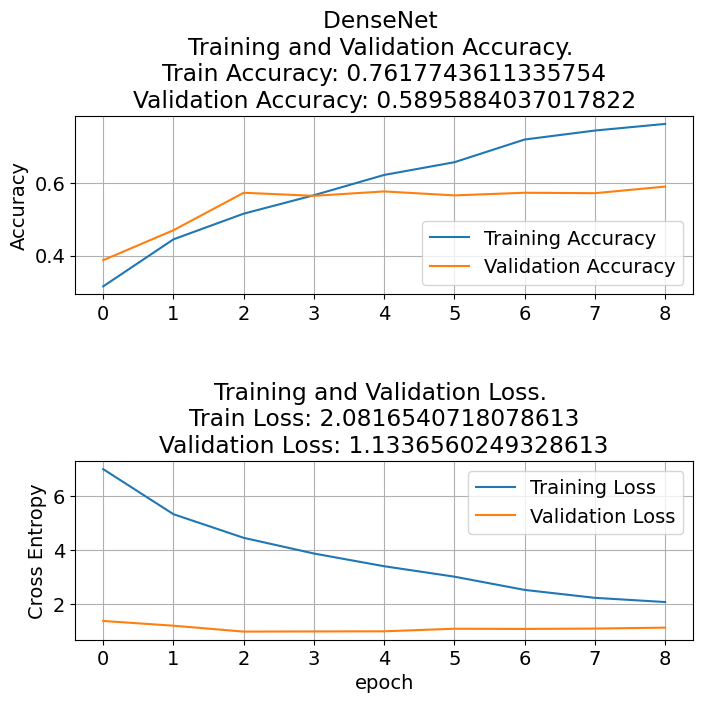

In [17]:
#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'DenseNet \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()